### Table of Contents

* [Creating Patient Group With Metabolomics Data](#Creating_patient_group)
* [KNN Imputation For NaNs](#KNN_Imputer)
* [Adding Covariates](#Adding_covariates)
* [Statistical Testing For Clusters From Pearson Correlation Clustering On Metabolites](#Stat_testing)
* [Survival Analysis](#Survival_analysis)
* [Addition of Clinical-Biological Features](#Involving_cb_features)
* [Statistical Testing For Clusters From Pearson Correlation Clustering On Clinical-Biological Features](#Stat_testing_cb)
    
<a class="anchor" id="Creating_patient_group"></a>

First we import the packages we may need for the notebook.

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import dask.dataframe as dd
import time
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import shap
import time
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from numpy import mean
from numpy import std
import seaborn as sns

First, we import our dataframe of all patients we will use in our model which we created in a previous notebook. This contains the eid (identifier variable for a patient) and target (labeled 0 if the patients did not progress to diabetes and 1 if the patient did progress to diabetes).

In [2]:
prediabetes_with_targets = pd.read_csv('prediabetic_patients_with_additional_4513_patients_from_unknown_patients_who_have_ICD_code_since_2018')
prediabetes_with_targets = prediabetes_with_targets.drop(columns = 'Unnamed: 0')
prediabetes_with_targets

eid  target
0     4754980       0
1     3990434       0
2     4341307       0
3     2189918       0
4     1384041       0
...       ...     ...
9939  6020998       0
9940  6022016       0
9941  6024268       0
9942  6024393       0
9943  6024501       0

[9944 rows x 2 columns]

Below we import the dataframe that has many features from the UKBiobank. We drop the first column which is just an identity column brought over from our previous analysis.

In [3]:
prediabetes_with_features = pd.read_csv('all_features_prediabetic_patients_with_additional_4513_patients_from_unknown_patients_who_have_ICD_code_since_2018')
prediabetes_with_features = prediabetes_with_features.drop(columns = ['Unnamed: 0'])
prediabetes_with_features

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3233,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 12711 columns]

Below we show some information about the total dataframe. We find that there are mostly float data types in our dataframe, but also a few integer and a bunch of object data types.

In [4]:
prediabetes_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Columns: 12711 entries, eid to 40021-16.0
dtypes: float64(10792), int64(6), object(1913)
memory usage: 964.3+ MB


Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [5]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [6]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [7]:
prediabetes_with_features.shape

(9944, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number from UK Biobank, with exception of eid)

In [8]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we show all remaining patients who are diagnosed with diabetes when their measurements are taken and we need to cut them out of the dataframe.

In [9]:
already_diabetic_patients_at_measurement = prediabetes_with_features[prediabetes_with_features['2443-0.0'] == 1]
already_diabetic_patients_at_measurement

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
14    2425377     1.0     NaN     NaN       0    1946     1.0     NaN     NaN   
56    5512282     3.0     NaN     NaN       1    1940     1.0     NaN     NaN   
61    5724786     1.0     NaN     NaN       1    1940     1.0     NaN     NaN   
200   4256846     3.0     NaN     1.0       1    1955     1.0     NaN     1.0   
222   2189918     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9640  1665367     1.0     NaN     NaN       1    1946     1.0     NaN     NaN   
9675  2739978     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   
9689  5684156     3.0     NaN     NaN       0    1940     1.0     NaN     NaN   
9779  5209790     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9863  4447186     1.0     NaN     NaN       0    1955     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
14    2818.0  ...        NaN        NaN        NaN         NaN         NaN   
56    1044.0  ...        NaN        NaN        NaN         NaN         NaN   
61    1057.0  ...        NaN        NaN        NaN         NaN         NaN   
200   1039.0  ...        NaN        NaN        NaN         NaN         NaN   
222   1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9640  1053.0  ...        NaN        NaN        NaN         NaN         NaN   
9675  1056.0  ...        NaN        NaN        NaN         NaN         NaN   
9689  1047.0  ...        NaN        NaN        NaN         NaN         NaN   
9779  2815.0  ...        NaN        NaN        NaN         NaN         NaN   
9863  1049.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
14           NaN         NaN         NaN         NaN         NaN  
56           NaN         NaN         NaN         NaN         NaN  
61           NaN         NaN         NaN         NaN         NaN  
200          NaN         NaN         NaN         NaN         NaN  
222          NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9640         NaN         NaN         NaN         NaN         NaN  
9675         NaN         NaN         NaN         NaN         NaN  
9689         NaN         NaN         NaN         NaN         NaN  
9779         NaN         NaN         NaN         NaN         NaN  
9863         NaN         NaN         NaN         NaN         NaN  

[190 rows x 11059 columns]

Below we make a list of the eid numbers.

In [10]:
dfToList_already_diabetic_at_start = already_diabetic_patients_at_measurement['eid'].tolist()
dfToList_already_diabetic_at_start

[2425377,
 5512282,
 5724786,
 4256846,
 2189918,
 2546801,
 1706511,
 4387781,
 3462831,
 2817041,
 1072495,
 2268893,
 4683307,
 2748729,
 4623980,
 5605075,
 5275213,
 1146097,
 4821929,
 5415675,
 2429507,
 3265844,
 4578103,
 1202644,
 2586223,
 2763479,
 3593711,
 2480161,
 1526262,
 2268137,
 4861030,
 2238033,
 4496514,
 1731265,
 3829166,
 2883116,
 5708973,
 2693446,
 4246045,
 3857759,
 2484797,
 2994186,
 4745503,
 1338136,
 5905564,
 1336221,
 4270479,
 3342350,
 2225944,
 1328378,
 2500901,
 2850077,
 2219400,
 2203109,
 4690101,
 3264433,
 1637230,
 1457680,
 5083386,
 5011490,
 2591687,
 1404125,
 1936742,
 4779249,
 2839824,
 3230080,
 3669628,
 4983552,
 1067255,
 1895718,
 2648322,
 1424752,
 2693862,
 1117612,
 4157944,
 3836870,
 5402929,
 5903604,
 3415657,
 3676477,
 1105902,
 2650506,
 4791134,
 2862531,
 4876864,
 3348953,
 3392380,
 2233450,
 4729030,
 2191774,
 5311017,
 4641634,
 5878402,
 2031987,
 4366316,
 1340066,
 2344091,
 1568527,
 2997821,
 5665933,


Next, we import the information with the metabolomics data.

In [11]:
prediabetes_metabolomics = pd.read_csv('prediabetics_with_metabolomic_and_telomere_length_data')
prediabetes_metabolomics = prediabetes_metabolomics.drop(columns = 'Unnamed: 0')
prediabetes_metabolomics

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9938  6024145   0.706609        NaN        NaN   0.782405        NaN   
9939  6024268   0.870288        NaN        NaN   0.938913        NaN   
9940  6024393   0.667180        NaN        NaN   0.737532        NaN   
9941  6024501        NaN        NaN        NaN        NaN        NaN   
9942  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23864-1.0  23867-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9938        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9939        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9940        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9941        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9942        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23868-0.0  23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9938        NaN        NaN        NaN        NaN        NaN        NaN   
9939        NaN        NaN        NaN        NaN        NaN        NaN   
9940        NaN        NaN        NaN        NaN        NaN        NaN   
9941        NaN        NaN        NaN        NaN        NaN        NaN   
9942        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-0.0  23878-1.0  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
9938        NaN        NaN  
9939        NaN        NaN  
9940        NaN        NaN  
9941        NaN        NaN  
9942        NaN        NaN  

[9943 rows x 483 columns]

Below we cut out all patients who are already diabetic.

In [12]:
prediabetes_metabolomics = prediabetes_metabolomics[~prediabetes_metabolomics.eid.isin(dfToList_already_diabetic_at_start)]
prediabetes_metabolomics

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9938  6024145   0.706609        NaN        NaN   0.782405        NaN   
9939  6024268   0.870288        NaN        NaN   0.938913        NaN   
9940  6024393   0.667180        NaN        NaN   0.737532        NaN   
9941  6024501        NaN        NaN        NaN        NaN        NaN   
9942  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23864-1.0  23867-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9938        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9939        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9940        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9941        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9942        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23868-0.0  23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9938        NaN        NaN        NaN        NaN        NaN        NaN   
9939        NaN        NaN        NaN        NaN        NaN        NaN   
9940        NaN        NaN        NaN        NaN        NaN        NaN   
9941        NaN        NaN        NaN        NaN        NaN        NaN   
9942        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-0.0  23878-1.0  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
9938        NaN        NaN  
9939        NaN        NaN  
9940        NaN        NaN  
9941        NaN        NaN  
9942        NaN        NaN  

[9753 rows x 483 columns]

Below we merge the dataframes by eid to add the target column.

In [13]:
prediabetes_with_metabolomics_and_target = prediabetes_metabolomics.merge(prediabetes_with_targets, on = 'eid')
prediabetes_with_metabolomics_and_target

eid  22190-0.0  22190-1.0  22190-2.0  22191-0.0  22191-1.0  \
0     1000330   0.769934        NaN        NaN   0.868105        NaN   
1     1000789        NaN        NaN        NaN        NaN        NaN   
2     1000809   0.728637        NaN        NaN   0.749579        NaN   
3     1001783   0.613309        NaN        NaN   0.742680        NaN   
4     1002432   0.794364        NaN        NaN   0.933980        NaN   
...       ...        ...        ...        ...        ...        ...   
9748  6024145   0.706609        NaN        NaN   0.782405        NaN   
9749  6024268   0.870288        NaN        NaN   0.938913        NaN   
9750  6024393   0.667180        NaN        NaN   0.737532        NaN   
9751  6024501        NaN        NaN        NaN        NaN        NaN   
9752  6025367   0.827508        NaN        NaN   0.910620        NaN   

      22191-2.0  22192-0.0  22192-1.0  22192-2.0  ...  23867-0.0  23868-0.0  \
0           NaN   0.351325        NaN        NaN  ...        NaN        NaN   
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2           NaN  -0.598856        NaN        NaN  ...        NaN        NaN   
3           NaN  -0.658705        NaN        NaN  ...        NaN        NaN   
4           NaN   0.824742        NaN        NaN  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
9748        NaN  -0.321438        NaN        NaN  ...        NaN        NaN   
9749        NaN   0.858840        NaN        NaN  ...        NaN        NaN   
9750        NaN  -0.703726        NaN        NaN  ...        NaN        NaN   
9751        NaN        NaN        NaN        NaN  ...        NaN        NaN   
9752        NaN   0.660800        NaN        NaN  ...        NaN        NaN   

      23869-0.0  23870-0.0  23871-0.0  23871-1.0  23876-0.0  23878-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750        NaN        NaN        NaN        NaN        NaN        NaN   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23878-1.0  target  
0           NaN       0  
1           NaN       0  
2           NaN       1  
3           NaN       0  
4           NaN       1  
...         ...     ...  
9748        NaN       1  
9749        NaN       0  
9750        NaN       0  
9751        NaN       0  
9752        NaN       1  

[9753 rows x 484 columns]

Next we want to run a model using the metabolomic data. The whole CSV has continuous and categorical data in which the categorical data contains markers for specific patients with problems. We do not include the categorical data here because it is very sparse. Therefore, we first take only the continuous data. However, we show below that python reads in the data as floats. Therefore, we have to manually keep the columns we want.

In [14]:
prediabetes_with_metabolomics_and_target.dtypes

eid            int64
22190-0.0    float64
22190-1.0    float64
22190-2.0    float64
22191-0.0    float64
              ...   
23871-1.0    float64
23876-0.0    float64
23878-0.0    float64
23878-1.0    float64
target         int64
Length: 484, dtype: object

Below we keep the columns we want by name. First we have to show a list of all column names. 

In [15]:
print(prediabetes_with_metabolomics_and_target.columns.tolist())

['eid', '22190-0.0', '22190-1.0', '22190-2.0', '22191-0.0', '22191-1.0', '22191-2.0', '22192-0.0', '22192-1.0', '22192-2.0', '22194-0.0', '22194-1.0', '22194-2.0', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '234

Next we take the names of the columns we want to keep.

In [16]:
prediabetes_with_metabolomics_continuous_only = prediabetes_with_metabolomics_and_target[['eid', 'target', '23400-0.0', '23400-1.0', '23401-0.0', '23401-1.0', '23402-0.0', '23402-1.0', '23403-0.0', '23403-1.0', '23404-0.0', '23404-1.0', '23405-0.0', '23405-1.0', '23406-0.0', '23406-1.0', '23407-0.0', '23407-1.0', '23408-0.0', '23408-1.0', '23409-0.0', '23409-1.0', '23410-0.0', '23410-1.0', '23411-0.0', '23411-1.0', '23412-0.0', '23412-1.0', '23413-0.0', '23413-1.0', '23414-0.0', '23414-1.0', '23415-0.0', '23415-1.0', '23416-0.0', '23416-1.0', '23417-0.0', '23417-1.0', '23418-0.0', '23418-1.0', '23419-0.0', '23419-1.0', '23420-0.0', '23420-1.0', '23421-0.0', '23421-1.0', '23422-0.0', '23422-1.0', '23423-0.0', '23423-1.0', '23424-0.0', '23424-1.0', '23425-0.0', '23425-1.0', '23426-0.0', '23426-1.0', '23427-0.0', '23427-1.0', '23428-0.0', '23428-1.0', '23429-0.0', '23429-1.0', '23430-0.0', '23430-1.0', '23431-0.0', '23431-1.0', '23432-0.0', '23432-1.0', '23433-0.0', '23433-1.0', '23434-0.0', '23434-1.0', '23436-0.0', '23436-1.0', '23437-0.0', '23437-1.0', '23438-0.0', '23438-1.0', '23439-0.0', '23439-1.0', '23440-0.0', '23440-1.0', '23442-0.0', '23442-1.0', '23443-0.0', '23443-1.0', '23444-0.0', '23444-1.0', '23445-0.0', '23445-1.0', '23446-0.0', '23446-1.0', '23447-0.0', '23447-1.0', '23448-0.0', '23448-1.0', '23449-0.0', '23449-1.0', '23450-0.0', '23450-1.0', '23460-0.0', '23460-1.0', '23461-0.0', '23461-1.0', '23462-0.0', '23462-1.0', '23463-0.0', '23463-1.0', '23464-0.0', '23464-1.0', '23465-0.0', '23465-1.0', '23466-0.0', '23466-1.0', '23467-0.0', '23467-1.0', '23468-0.0', '23468-1.0', '23469-0.0', '23469-1.0', '23470-0.0', '23470-1.0', '23471-0.0', '23471-1.0', '23472-0.0', '23472-1.0', '23473-0.0', '23473-1.0', '23474-0.0', '23474-1.0', '23475-0.0', '23475-1.0', '23476-0.0', '23476-1.0', '23477-0.0', '23477-1.0', '23478-0.0', '23478-1.0', '23479-0.0', '23479-1.0', '23480-0.0', '23480-1.0', '23481-0.0', '23481-1.0', '23482-0.0', '23482-1.0', '23483-0.0', '23483-1.0', '23484-0.0', '23484-1.0', '23485-0.0', '23485-1.0', '23486-0.0', '23486-1.0', '23487-0.0', '23487-1.0', '23488-0.0', '23488-1.0', '23489-0.0', '23489-1.0', '23490-0.0', '23490-1.0', '23491-0.0', '23491-1.0', '23492-0.0', '23492-1.0', '23493-0.0', '23493-1.0', '23494-0.0', '23494-1.0', '23495-0.0', '23495-1.0', '23496-0.0', '23496-1.0', '23497-0.0', '23497-1.0', '23498-0.0', '23498-1.0', '23499-0.0', '23499-1.0', '23500-0.0', '23500-1.0', '23501-0.0', '23501-1.0', '23502-0.0', '23502-1.0', '23503-0.0', '23503-1.0', '23504-0.0', '23504-1.0', '23505-0.0', '23505-1.0', '23506-0.0', '23506-1.0', '23507-0.0', '23507-1.0', '23508-0.0', '23508-1.0', '23509-0.0', '23509-1.0', '23510-0.0', '23510-1.0', '23511-0.0', '23511-1.0', '23512-0.0', '23512-1.0', '23513-0.0', '23513-1.0', '23514-0.0', '23514-1.0', '23515-0.0', '23515-1.0', '23516-0.0', '23516-1.0', '23517-0.0', '23517-1.0', '23518-0.0', '23518-1.0', '23519-0.0', '23519-1.0', '23520-0.0', '23520-1.0', '23521-0.0', '23521-1.0', '23522-0.0', '23522-1.0', '23523-0.0', '23523-1.0', '23524-0.0', '23524-1.0', '23525-0.0', '23525-1.0', '23526-0.0', '23526-1.0', '23527-0.0', '23527-1.0', '23528-0.0', '23528-1.0', '23529-0.0', '23529-1.0', '23530-0.0', '23530-1.0', '23531-0.0', '23531-1.0', '23532-0.0', '23532-1.0', '23533-0.0', '23533-1.0', '23534-0.0', '23534-1.0', '23535-0.0', '23535-1.0', '23536-0.0', '23536-1.0', '23537-0.0', '23537-1.0', '23538-0.0', '23538-1.0', '23539-0.0', '23539-1.0', '23540-0.0', '23540-1.0', '23541-0.0', '23541-1.0', '23542-0.0', '23542-1.0', '23543-0.0', '23543-1.0', '23544-0.0', '23544-1.0', '23545-0.0', '23545-1.0', '23546-0.0', '23546-1.0', '23547-0.0', '23547-1.0', '23548-0.0', '23548-1.0', '23549-0.0', '23549-1.0', '23550-0.0', '23550-1.0', '23551-0.0', '23551-1.0', '23552-0.0', '23552-1.0', '23553-0.0', '23553-1.0', '23554-0.0', '23554-1.0', '23555-0.0', '23555-1.0', '23556-0.0', '23556-1.0', '23557-0.0', '23557-1.0', '23558-0.0', '23558-1.0', '23559-0.0', '23559-1.0', '23560-0.0', '23560-1.0', '23561-0.0', '23561-1.0', '23562-0.0', '23562-1.0', '23563-0.0', '23563-1.0', '23564-0.0', '23564-1.0', '23565-0.0', '23565-1.0', '23566-0.0', '23566-1.0', '23567-0.0', '23567-1.0', '23568-0.0', '23568-1.0', '23569-0.0', '23569-1.0', '23570-0.0', '23570-1.0', '23571-0.0', '23571-1.0', '23572-0.0', '23572-1.0', '23573-0.0', '23573-1.0', '23574-0.0', '23574-1.0', '23575-0.0', '23575-1.0', '23576-0.0', '23576-1.0', '23577-0.0', '23577-1.0', '23578-0.0', '23578-1.0']]
prediabetes_with_metabolomics_continuous_only

eid  target  23400-0.0  23400-1.0  23401-0.0  23401-1.0  23402-0.0  \
0     1000330       0        NaN        NaN        NaN        NaN        NaN   
1     1000789       0        NaN        NaN        NaN        NaN        NaN   
2     1000809       1     5.0722        NaN     3.6887        NaN     1.8404   
3     1001783       0        NaN        NaN        NaN        NaN        NaN   
4     1002432       1        NaN        NaN        NaN        NaN        NaN   
...       ...     ...        ...        ...        ...        ...        ...   
9748  6024145       1        NaN        NaN        NaN        NaN        NaN   
9749  6024268       0        NaN        NaN        NaN        NaN        NaN   
9750  6024393       0     5.1455        NaN     3.3451        NaN     1.4854   
9751  6024501       0        NaN        NaN        NaN        NaN        NaN   
9752  6025367       1        NaN        NaN        NaN        NaN        NaN   

      23402-1.0  23403-0.0  23403-1.0  ...  23574-0.0  23574-1.0  23575-0.0  \
0           NaN        NaN        NaN  ...        NaN        NaN        NaN   
1           NaN        NaN        NaN  ...        NaN        NaN        NaN   
2           NaN    0.84379        NaN  ...    0.61907        NaN    0.40574   
3           NaN        NaN        NaN  ...        NaN        NaN        NaN   
4           NaN        NaN        NaN  ...        NaN        NaN        NaN   
...         ...        ...        ...  ...        ...        ...        ...   
9748        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9749        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9750        NaN    0.53555        NaN  ...    0.74767        NaN    0.52592   
9751        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9752        NaN        NaN        NaN  ...        NaN        NaN        NaN   

      23575-1.0  23576-0.0  23576-1.0  23577-0.0  23577-1.0  23578-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN    0.29572        NaN    0.11002        NaN   0.047430   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750        NaN    0.39495        NaN    0.13097        NaN   0.037247   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23578-1.0  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
9748        NaN  
9749        NaN  
9750        NaN  
9751        NaN  
9752        NaN  

[9753 rows x 338 columns]

Below we keep only the columns that end in -0.0 or are the eid and target columns.

In [17]:
prediabetes_with_metabolomics_continuous_only_to_keep = prediabetes_with_metabolomics_continuous_only.filter(regex='-0.0|eid|target')
prediabetes_with_metabolomics_continuous_only_to_keep

eid  target  23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  \
0     1000330       0        NaN        NaN        NaN        NaN        NaN   
1     1000789       0        NaN        NaN        NaN        NaN        NaN   
2     1000809       1     5.0722     3.6887     1.8404    0.84379     2.8117   
3     1001783       0        NaN        NaN        NaN        NaN        NaN   
4     1002432       1        NaN        NaN        NaN        NaN        NaN   
...       ...     ...        ...        ...        ...        ...        ...   
9748  6024145       1        NaN        NaN        NaN        NaN        NaN   
9749  6024268       0        NaN        NaN        NaN        NaN        NaN   
9750  6024393       0     5.1455     3.3451     1.4854    0.53555     2.7781   
9751  6024501       0        NaN        NaN        NaN        NaN        NaN   
9752  6025367       1        NaN        NaN        NaN        NaN        NaN   

      23405-0.0  23406-0.0  23407-0.0  ...  23569-0.0  23570-0.0  23571-0.0  \
0           NaN        NaN        NaN  ...        NaN        NaN        NaN   
1           NaN        NaN        NaN  ...        NaN        NaN        NaN   
2        1.8483     1.3835    1.05560  ...    0.40360   0.089485    0.05340   
3           NaN        NaN        NaN  ...        NaN        NaN        NaN   
4           NaN        NaN        NaN  ...        NaN        NaN        NaN   
...         ...        ...        ...  ...        ...        ...        ...   
9748        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9749        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9750     1.8598     1.8004    0.75232  ...    0.56824   0.121000    0.04205   
9751        NaN        NaN        NaN  ...        NaN        NaN        NaN   
9752        NaN        NaN        NaN  ...        NaN        NaN        NaN   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2      0.008862     1.0722    0.61907    0.40574    0.29572    0.11002   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
9748        NaN        NaN        NaN        NaN        NaN        NaN   
9749        NaN        NaN        NaN        NaN        NaN        NaN   
9750   0.011256     1.3108    0.74767    0.52592    0.39495    0.13097   
9751        NaN        NaN        NaN        NaN        NaN        NaN   
9752        NaN        NaN        NaN        NaN        NaN        NaN   

      23578-0.0  
0           NaN  
1           NaN  
2      0.047430  
3           NaN  
4           NaN  
...         ...  
9748        NaN  
9749        NaN  
9750   0.037247  
9751        NaN  
9752        NaN  

[9753 rows x 170 columns]

Below we look at how many NaN values we have in the dataframe. We see that a lot of the patients do not have much information. Therefore, we will keep only the rows without many NaN values in them.

In [18]:
pd.options.display.max_rows = 200
prediabetes_with_metabolomics_continuous_only_to_keep.isnull().sum()

eid             0
target          0
23400-0.0    7414
23401-0.0    7414
23402-0.0    7414
23403-0.0    7414
23404-0.0    7414
23405-0.0    7414
23406-0.0    7414
23407-0.0    7414
23408-0.0    7414
23409-0.0    7414
23410-0.0    7414
23411-0.0    7414
23412-0.0    7414
23413-0.0    7414
23414-0.0    7414
23415-0.0    7414
23416-0.0    7414
23417-0.0    7414
23418-0.0    7414
23419-0.0    7414
23420-0.0    7414
23421-0.0    7414
23422-0.0    7414
23423-0.0    7414
23424-0.0    7414
23425-0.0    7414
23426-0.0    7414
23427-0.0    7414
23428-0.0    7414
23429-0.0    7414
23430-0.0    7414
23431-0.0    7414
23432-0.0    7414
23433-0.0    7414
23434-0.0    7416
23436-0.0    7416
23437-0.0    7416
23438-0.0    7416
23439-0.0    7414
23440-0.0    7414
23442-0.0    7416
23443-0.0    7416
23444-0.0    7416
23445-0.0    7416
23446-0.0    7416
23447-0.0    7416
23448-0.0    7416
23449-0.0    7416
23450-0.0    7416
23460-0.0    7414
23461-0.0    7423
23462-0.0    7414
23463-0.0    7420
23464-0.0 

Below we filter for rows without NaN values, keeping all rows with 3 or less NaN values in them.

In [19]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered = prediabetes_with_metabolomics_continuous_only_to_keep.dropna(thresh=3)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered

eid  target  23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  \
2     1000809       1     5.0722     3.6887     1.8404    0.84379     2.8117   
7     1005686       1     3.7716     2.4546     1.1090    0.42269     1.9801   
8     1005936       1     4.5190     3.5896     1.7915    0.97591     2.5595   
11    1007333       0     4.9518     3.1492     1.3743    0.45402     2.6832   
19    1016167       0     2.9259     1.8478     0.8703    0.35565     1.3400   
...       ...     ...        ...        ...        ...        ...        ...   
9734  6017696       0     5.5147     4.2459     2.1481    1.08270     3.2354   
9735  6017753       0     4.0321     2.8769     1.3677    0.64201     2.1882   
9736  6017871       1     3.5629     2.6253     1.2123    0.67483     1.7881   
9737  6018114       0     4.0710     2.8931     1.3145    0.72080     2.0921   
9750  6024393       0     5.1455     3.3451     1.4854    0.53555     2.7781   

      23405-0.0  23406-0.0  23407-0.0  ...  23569-0.0  23570-0.0  23571-0.0  \
2       1.84830    1.38350    1.05560  ...    0.40360   0.089485   0.053400   
7       1.34560    1.31700    0.72558  ...    0.41526   0.083232   0.033200   
8       1.79800    0.92939    2.13880  ...    0.29014   0.065946   0.086861   
11      1.77490    1.80260    0.56713  ...    0.50841   0.108500   0.016658   
19      0.97753    1.07800    0.92902  ...    0.34595   0.066720   0.035421   
...         ...        ...        ...  ...        ...        ...        ...   
9734    2.09780    1.26890    1.63230  ...    0.39407   0.087251   0.069017   
9735    1.50910    1.15530    1.27490  ...    0.38089   0.078563   0.050539   
9736    1.41300    0.93761    2.31370  ...    0.33310   0.071334   0.075526   
9737    1.57860    1.17800    1.97550  ...    0.40807   0.085483   0.065454   
9750    1.85980    1.80040    0.75232  ...    0.56824   0.121000   0.042050   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
2      0.008862    1.07220    0.61907    0.40574    0.29572   0.110020   
7      0.009097    1.07350    0.61140    0.42628    0.32234   0.103940   
8      0.009035    1.14000    0.65788    0.39831    0.28809   0.110220   
11     0.009099    1.01750    0.56630    0.43184    0.31848   0.113370   
19     0.008057    0.97235    0.56304    0.37241    0.28323   0.089176   
...         ...        ...        ...        ...        ...        ...   
9734   0.010124    1.22800    0.70412    0.45917    0.33805   0.121120   
9735   0.009690    1.17340    0.67604    0.44390    0.33278   0.111120   
9736   0.010021    1.25460    0.72523    0.44733    0.32932   0.118020   
9737   0.010734    1.31230    0.75289    0.48803    0.36378   0.124250   
9750   0.011256    1.31080    0.74767    0.52592    0.39495   0.130970   

      23578-0.0  
2      0.047430  
7      0.035841  
8      0.083784  
11     0.019326  
19     0.036902  
...         ...  
9734   0.064663  
9735   0.053463  
9736   0.082007  
9737   0.071392  
9750   0.037247  

[2339 rows x 170 columns]

Below we show the number of NaN values remaining.

In [20]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered.isnull().sum()


eid           0
target        0
23400-0.0     0
23401-0.0     0
23402-0.0     0
23403-0.0     0
23404-0.0     0
23405-0.0     0
23406-0.0     0
23407-0.0     0
23408-0.0     0
23409-0.0     0
23410-0.0     0
23411-0.0     0
23412-0.0     0
23413-0.0     0
23414-0.0     0
23415-0.0     0
23416-0.0     0
23417-0.0     0
23418-0.0     0
23419-0.0     0
23420-0.0     0
23421-0.0     0
23422-0.0     0
23423-0.0     0
23424-0.0     0
23425-0.0     0
23426-0.0     0
23427-0.0     0
23428-0.0     0
23429-0.0     0
23430-0.0     0
23431-0.0     0
23432-0.0     0
23433-0.0     0
23434-0.0     2
23436-0.0     2
23437-0.0     2
23438-0.0     2
23439-0.0     0
23440-0.0     0
23442-0.0     2
23443-0.0     2
23444-0.0     2
23445-0.0     2
23446-0.0     2
23447-0.0     2
23448-0.0     2
23449-0.0     2
23450-0.0     2
23460-0.0     0
23461-0.0     9
23462-0.0     0
23463-0.0     6
23464-0.0     0
23465-0.0     0
23466-0.0     0
23467-0.0     0
23468-0.0     2
23469-0.0     5
23470-0.0     6
23471-0.

Below we make a new list of the float columns so we can fill all NaN values.

In [21]:
pd.options.display.max_rows = 10
floats_final = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.select_dtypes(include=['float64']).columns.to_list()
floats_final

['23400-0.0',
 '23401-0.0',
 '23402-0.0',
 '23403-0.0',
 '23404-0.0',
 '23405-0.0',
 '23406-0.0',
 '23407-0.0',
 '23408-0.0',
 '23409-0.0',
 '23410-0.0',
 '23411-0.0',
 '23412-0.0',
 '23413-0.0',
 '23414-0.0',
 '23415-0.0',
 '23416-0.0',
 '23417-0.0',
 '23418-0.0',
 '23419-0.0',
 '23420-0.0',
 '23421-0.0',
 '23422-0.0',
 '23423-0.0',
 '23424-0.0',
 '23425-0.0',
 '23426-0.0',
 '23427-0.0',
 '23428-0.0',
 '23429-0.0',
 '23430-0.0',
 '23431-0.0',
 '23432-0.0',
 '23433-0.0',
 '23434-0.0',
 '23436-0.0',
 '23437-0.0',
 '23438-0.0',
 '23439-0.0',
 '23440-0.0',
 '23442-0.0',
 '23443-0.0',
 '23444-0.0',
 '23445-0.0',
 '23446-0.0',
 '23447-0.0',
 '23448-0.0',
 '23449-0.0',
 '23450-0.0',
 '23460-0.0',
 '23461-0.0',
 '23462-0.0',
 '23463-0.0',
 '23464-0.0',
 '23465-0.0',
 '23466-0.0',
 '23467-0.0',
 '23468-0.0',
 '23469-0.0',
 '23470-0.0',
 '23471-0.0',
 '23472-0.0',
 '23473-0.0',
 '23474-0.0',
 '23475-0.0',
 '23476-0.0',
 '23477-0.0',
 '23478-0.0',
 '23479-0.0',
 '23480-0.0',
 '23481-0.0',
 '2348

<a class="anchor" id="KNN_Imputer"></a>
Next we perform Imputation Using k-NN with k = 5. Implementation from: https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

In [22]:
from sklearn.impute import KNNImputer

prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.drop(columns = ['eid', 'target'])

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)

# transform the dataset
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final = imputer.transform(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final

array([[5.0722  , 3.6887  , 1.8404  , ..., 0.29572 , 0.11002 , 0.04743 ],
       [3.7716  , 2.4546  , 1.109   , ..., 0.32234 , 0.10394 , 0.035841],
       [4.519   , 3.5896  , 1.7915  , ..., 0.28809 , 0.11022 , 0.083784],
       ...,
       [3.5629  , 2.6253  , 1.2123  , ..., 0.32932 , 0.11802 , 0.082007],
       [4.071   , 2.8931  , 1.3145  , ..., 0.36378 , 0.12425 , 0.071392],
       [5.1455  , 3.3451  , 1.4854  , ..., 0.39495 , 0.13097 , 0.037247]])

Below we create a dataframe of these values.

In [23]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df = pd.DataFrame(data=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final, columns=prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn.columns)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0        5.0722     3.6887     1.8404    0.84379     2.8117    1.84830   
1        3.7716     2.4546     1.1090    0.42269     1.9801    1.34560   
2        4.5190     3.5896     1.7915    0.97591     2.5595    1.79800   
3        4.9518     3.1492     1.3743    0.45402     2.6832    1.77490   
4        2.9259     1.8478     0.8703    0.35565     1.3400    0.97753   
...         ...        ...        ...        ...        ...        ...   
2334     5.5147     4.2459     2.1481    1.08270     3.2354    2.09780   
2335     4.0321     2.8769     1.3677    0.64201     2.1882    1.50910   
2336     3.5629     2.6253     1.2123    0.67483     1.7881    1.41300   
2337     4.0710     2.8931     1.3145    0.72080     2.0921    1.57860   
2338     5.1455     3.3451     1.4854    0.53555     2.7781    1.85980   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23569-0.0  23570-0.0  \
0       1.38350    1.05560    0.65250    0.14697  ...    0.40360   0.089485   
1       1.31700    0.72558    0.44415    0.11384  ...    0.41526   0.083232   
2       0.92939    2.13880    1.54990    0.21661  ...    0.29014   0.065946   
3       1.80260    0.56713    0.31040    0.11897  ...    0.50841   0.108500   
4       1.07800    0.92902    0.69337    0.08373  ...    0.34595   0.066720   
...         ...        ...        ...        ...  ...        ...        ...   
2334    1.26890    1.63230    1.15280    0.17546  ...    0.39407   0.087251   
2335    1.15530    1.27490    0.91217    0.13757  ...    0.38089   0.078563   
2336    0.93761    2.31370    1.80970    0.18737  ...    0.33310   0.071334   
2337    1.17800    1.97550    1.52290    0.17258  ...    0.40807   0.085483   
2338    1.80040    0.75232    0.42868    0.12690  ...    0.56824   0.121000   

      23571-0.0  23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  \
0      0.053400   0.008862    1.07220    0.61907    0.40574    0.29572   
1      0.033200   0.009097    1.07350    0.61140    0.42628    0.32234   
2      0.086861   0.009035    1.14000    0.65788    0.39831    0.28809   
3      0.016658   0.009099    1.01750    0.56630    0.43184    0.31848   
4      0.035421   0.008057    0.97235    0.56304    0.37241    0.28323   
...         ...        ...        ...        ...        ...        ...   
2334   0.069017   0.010124    1.22800    0.70412    0.45917    0.33805   
2335   0.050539   0.009690    1.17340    0.67604    0.44390    0.33278   
2336   0.075526   0.010021    1.25460    0.72523    0.44733    0.32932   
2337   0.065454   0.010734    1.31230    0.75289    0.48803    0.36378   
2338   0.042050   0.011256    1.31080    0.74767    0.52592    0.39495   

      23577-0.0  23578-0.0  
0      0.110020   0.047430  
1      0.103940   0.035841  
2      0.110220   0.083784  
3      0.113370   0.019326  
4      0.089176   0.036902  
...         ...        ...  
2334   0.121120   0.064663  
2335   0.111120   0.053463  
2336   0.118020   0.082007  
2337   0.124250   0.071392  
2338   0.130970   0.037247  

[2339 rows x 168 columns]

Below we show which metabolomic data distributions are normal and which are not normal using the Shapiro-Wilk test. This is important for our statistical testing further on.

In [24]:
import scipy.stats as stats

normal_metabolites = []
not_normal_metabolites = []

for col in prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.columns:
    w, pvalue = stats.shapiro(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col])
    print('For feature:', col, 'Shapiro test statistic is:', w, 'With padjusted (pval*168):', pvalue)
    if pvalue*168 < 0.05:
        not_normal_metabolites.append(col)
        print('-------------------NOT NORMAL-----------------')
    else:
        normal_metabolites.append(col)
        print('-------------------NORMAL-----------------')

For feature: 23400-0.0 Shapiro test statistic is: 0.9926098585128784 With padjusted (pval*168): 1.6382571965678494e-09
-------------------NOT NORMAL-----------------
For feature: 23401-0.0 Shapiro test statistic is: 0.9882523417472839 With padjusted (pval*168): 6.110207825815728e-13
-------------------NOT NORMAL-----------------
For feature: 23402-0.0 Shapiro test statistic is: 0.9865480065345764 With padjusted (pval*168): 4.687404774766403e-14
-------------------NOT NORMAL-----------------
For feature: 23403-0.0 Shapiro test statistic is: 0.9841951131820679 With padjusted (pval*168): 1.8934386038091866e-15
-------------------NOT NORMAL-----------------
For feature: 23404-0.0 Shapiro test statistic is: 0.9892460107803345 With padjusted (pval*168): 3.0611492073812085e-12
-------------------NOT NORMAL-----------------
For feature: 23405-0.0 Shapiro test statistic is: 0.9900402426719666 With padjusted (pval*168): 1.190730760519676e-11
-------------------NOT NORMAL-----------------
For fea

For feature: 23460-0.0 Shapiro test statistic is: 0.988315999507904 With padjusted (pval*168): 6.756170059171729e-13
-------------------NOT NORMAL-----------------
For feature: 23461-0.0 Shapiro test statistic is: 0.9958756566047668 With padjusted (pval*168): 4.820469712285558e-06
-------------------NOT NORMAL-----------------
For feature: 23462-0.0 Shapiro test statistic is: 0.9248075485229492 With padjusted (pval*168): 1.0519019931560691e-32
-------------------NOT NORMAL-----------------
For feature: 23463-0.0 Shapiro test statistic is: 0.8674162030220032 With padjusted (pval*168): 1.114564772554673e-40
-------------------NOT NORMAL-----------------
For feature: 23464-0.0 Shapiro test statistic is: 0.9475915431976318 With padjusted (pval*168): 4.214772016362594e-28
-------------------NOT NORMAL-----------------
For feature: 23465-0.0 Shapiro test statistic is: 0.9117856025695801 With padjusted (pval*168): 7.380280440621527e-35
-------------------NOT NORMAL-----------------
For featur

For feature: 23510-0.0 Shapiro test statistic is: 0.9801120162010193 With padjusted (pval*168): 1.4608773932572468e-17
-------------------NOT NORMAL-----------------
For feature: 23511-0.0 Shapiro test statistic is: 0.9845162034034729 With padjusted (pval*168): 2.875694643620242e-15
-------------------NOT NORMAL-----------------
For feature: 23512-0.0 Shapiro test statistic is: 0.981955885887146 With padjusted (pval*168): 1.1944274963539926e-16
-------------------NOT NORMAL-----------------
For feature: 23513-0.0 Shapiro test statistic is: 0.9818296432495117 With padjusted (pval*168): 1.0295748339602575e-16
-------------------NOT NORMAL-----------------
For feature: 23514-0.0 Shapiro test statistic is: 0.982912540435791 With padjusted (pval*168): 3.7715605755309696e-16
-------------------NOT NORMAL-----------------
For feature: 23515-0.0 Shapiro test statistic is: 0.9604519605636597 With padjusted (pval*168): 9.114400291310418e-25
-------------------NOT NORMAL-----------------
For feat

For feature: 23559-0.0 Shapiro test statistic is: 0.8742889761924744 With padjusted (pval*168): 6.826635663727995e-40
-------------------NOT NORMAL-----------------
For feature: 23560-0.0 Shapiro test statistic is: 0.8893828392028809 With padjusted (pval*168): 4.930321230128422e-38
-------------------NOT NORMAL-----------------
For feature: 23561-0.0 Shapiro test statistic is: 0.8655694127082825 With padjusted (pval*168): 6.938108956565034e-41
-------------------NOT NORMAL-----------------
For feature: 23562-0.0 Shapiro test statistic is: 0.8669090270996094 With padjusted (pval*168): 9.780222501908628e-41
-------------------NOT NORMAL-----------------
For feature: 23563-0.0 Shapiro test statistic is: 0.8734933733940125 With padjusted (pval*168): 5.512301782099176e-40
-------------------NOT NORMAL-----------------
For feature: 23564-0.0 Shapiro test statistic is: 0.9247781038284302 With padjusted (pval*168): 1.039404651496905e-32
-------------------NOT NORMAL-----------------
For featur

Now we have to normalize all the float columns so that they have values between 0 and 1. We do this by dividing each value in a column by using min-max normalization.

In [25]:
for col in floats_final:
    prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] = (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col] - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min()) / (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].max() - prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df[col].min())
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23569-0.0  23570-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.330396   0.363306   
1      0.345652   0.073043   0.067466   0.103913  ...   0.344825   0.330879   
2      0.177170   0.333359   0.303467   0.302916  ...   0.189997   0.241236   
3      0.556726   0.043856   0.038919   0.113847  ...   0.460093   0.461915   
4      0.241766   0.110517   0.120657   0.045608  ...   0.259058   0.245250   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.318604   0.351721   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.302294   0.306666   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.243157   0.269177   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.335928   0.342552   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.534129   0.526738   

      23571-0.0  23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  \
0      0.235669   0.243458   0.228702   0.226876   0.250734   0.244515   
1      0.127482   0.261577   0.229491   0.219080   0.284609   0.301056   
2      0.414881   0.256776   0.269833   0.266324   0.238480   0.228309   
3      0.038885   0.261708   0.195518   0.173240   0.293779   0.292857   
4      0.139377   0.181507   0.168128   0.169926   0.195765   0.217986   
...         ...        ...        ...        ...        ...        ...   
2334   0.319311   0.340555   0.323218   0.313323   0.338853   0.334424   
2335   0.220346   0.307195   0.290095   0.284782   0.313669   0.323230   
2336   0.354173   0.332631   0.339355   0.334780   0.319326   0.315881   
2337   0.300229   0.387488   0.374359   0.362894   0.386450   0.389074   
2338   0.174881   0.427650   0.373449   0.357589   0.448940   0.455279   

      23577-0.0  23578-0.0  
0      0.321751   0.224446  
1      0.279932   0.160634  
2      0.323126   0.424620  
3      0.344792   0.069699  
4      0.178384   0.166476  
...         ...        ...  
2334   0.398098   0.319335  
2335   0.329317   0.257665  
2336   0.376775   0.414835  
2337   0.419626   0.356386  
2338   0.465847   0.168376  

[2339 rows x 168 columns]

Below we add the eid column back.

In [26]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'] = prediabetes_with_metabolomics_continuous_only_to_keep_filtered.reset_index(inplace = False)['eid']
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23570-0.0  23571-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.363306   0.235669   
1      0.345652   0.073043   0.067466   0.103913  ...   0.330879   0.127482   
2      0.177170   0.333359   0.303467   0.302916  ...   0.241236   0.414881   
3      0.556726   0.043856   0.038919   0.113847  ...   0.461915   0.038885   
4      0.241766   0.110517   0.120657   0.045608  ...   0.245250   0.139377   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.351721   0.319311   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.306666   0.220346   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.269177   0.354173   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.342552   0.300229   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.526738   0.174881   

      23572-0.0  23573-0.0  23574-0.0  23575-0.0  23576-0.0  23577-0.0  \
0      0.243458   0.228702   0.226876   0.250734   0.244515   0.321751   
1      0.261577   0.229491   0.219080   0.284609   0.301056   0.279932   
2      0.256776   0.269833   0.266324   0.238480   0.228309   0.323126   
3      0.261708   0.195518   0.173240   0.293779   0.292857   0.344792   
4      0.181507   0.168128   0.169926   0.195765   0.217986   0.178384   
...         ...        ...        ...        ...        ...        ...   
2334   0.340555   0.323218   0.313323   0.338853   0.334424   0.398098   
2335   0.307195   0.290095   0.284782   0.313669   0.323230   0.329317   
2336   0.332631   0.339355   0.334780   0.319326   0.315881   0.376775   
2337   0.387488   0.374359   0.362894   0.386450   0.389074   0.419626   
2338   0.427650   0.373449   0.357589   0.448940   0.455279   0.465847   

      23578-0.0      eid  
0      0.224446  1000809  
1      0.160634  1005686  
2      0.424620  1005936  
3      0.069699  1007333  
4      0.166476  1016167  
...         ...      ...  
2334   0.319335  6017696  
2335   0.257665  6017753  
2336   0.414835  6017871  
2337   0.356386  6018114  
2338   0.168376  6024393  

[2339 rows x 169 columns]

Below we create a list of these eid numbers.

In [27]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df_with_eid

[1000809,
 1005686,
 1005936,
 1007333,
 1016167,
 1017443,
 1018119,
 1025405,
 1025738,
 1026007,
 1027978,
 1030454,
 1034056,
 1035811,
 1036940,
 1037932,
 1039510,
 1040950,
 1041652,
 1042924,
 1043213,
 1045764,
 1046313,
 1048428,
 1049423,
 1049710,
 1050906,
 1052513,
 1056375,
 1056980,
 1062604,
 1063648,
 1063856,
 1068154,
 1068882,
 1069867,
 1072504,
 1073266,
 1075104,
 1075927,
 1076087,
 1077768,
 1082613,
 1084010,
 1086687,
 1087122,
 1087380,
 1090737,
 1094263,
 1094700,
 1097020,
 1098087,
 1099030,
 1099336,
 1099911,
 1101247,
 1102293,
 1102744,
 1102863,
 1104962,
 1106386,
 1107380,
 1115680,
 1116252,
 1117967,
 1120584,
 1120681,
 1125079,
 1125452,
 1128480,
 1128721,
 1130724,
 1137127,
 1145728,
 1147334,
 1148003,
 1149894,
 1150077,
 1151556,
 1151952,
 1155943,
 1157575,
 1168769,
 1169079,
 1169859,
 1174474,
 1177141,
 1177496,
 1179607,
 1185015,
 1192821,
 1193061,
 1196100,
 1196563,
 1200313,
 1201409,
 1201497,
 1202179,
 1202941,
 1204760,


<a class="anchor" id="Adding_covariates"></a>
# Below we account for covariates of sex, age, and ethnic backgound.

Below we add the sex, ethnicity, and age information to the dataframe. We will use these later on to account for the covariates and see if this changes the results of the model.

In [28]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_nan_knn_final_df.merge(prediabetes_with_features[['eid', '31-0.0', '21003-0.0', '21000-0.0']], on = 'eid')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.323218   0.313323   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.290095   0.284782   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.339355   0.334780   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.374359   0.362894   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.373449   0.357589   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21003-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0         50   
1      0.284609   0.301056   0.279932   0.160634  1005686       0         67   
2      0.238480   0.228309   0.323126   0.424620  1005936       1         61   
3      0.293779   0.292857   0.344792   0.069699  1007333       1         57   
4      0.195765   0.217986   0.178384   0.166476  1016167       0         64   
...         ...        ...        ...        ...      ...     ...        ...   
2334   0.338853   0.334424   0.398098   0.319335  6017696       0         61   
2335   0.313669   0.323230   0.329317   0.257665  6017753       1         55   
2336   0.319326   0.315881   0.376775   0.414835  6017871       1         50   
2337   0.386450   0.389074   0.419626   0.356386  6018114       0         61   
2338   0.448940   0.455279   0.465847   0.168376  6024393       0         63   

      21000-0.0  
0        3001.0  
1        1001.0  
2        1001.0  
3        4001.0  
4        3001.0  
...         ...  
2334        6.0  
2335        6.0  
2336     1001.0  
2337     1001.0  
2338     1001.0  

[2339 rows x 172 columns]

Below we show how many nan values are in the added sex, age, and race columns. We see that there are only 6 patients without a value in the race column, and therefore we can go ahead with our usual coding of ethnic background.

In [29]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.isnull().sum()

23400-0.0    0
23401-0.0    0
23402-0.0    0
23403-0.0    0
23404-0.0    0
            ..
23578-0.0    0
eid          0
31-0.0       0
21003-0.0    0
21000-0.0    6
Length: 172, dtype: int64

Next we create a column that specifies if a person is greater than or equal to 60 years of age. We suspect that age has an impact on metabolomics and so we create this covariate.

In [30]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['Age Covariate'] = np.where(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21003-0.0'] >= 60, 1, 0)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23574-0.0  23575-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.226876   0.250734   
1      0.345652   0.073043   0.067466   0.103913  ...   0.219080   0.284609   
2      0.177170   0.333359   0.303467   0.302916  ...   0.266324   0.238480   
3      0.556726   0.043856   0.038919   0.113847  ...   0.173240   0.293779   
4      0.241766   0.110517   0.120657   0.045608  ...   0.169926   0.195765   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.313323   0.338853   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.284782   0.313669   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.334780   0.319326   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.362894   0.386450   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.357589   0.448940   

      23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21003-0.0  21000-0.0  \
0      0.244515   0.321751   0.224446  1000809       0         50     3001.0   
1      0.301056   0.279932   0.160634  1005686       0         67     1001.0   
2      0.228309   0.323126   0.424620  1005936       1         61     1001.0   
3      0.292857   0.344792   0.069699  1007333       1         57     4001.0   
4      0.217986   0.178384   0.166476  1016167       0         64     3001.0   
...         ...        ...        ...      ...     ...        ...        ...   
2334   0.334424   0.398098   0.319335  6017696       0         61        6.0   
2335   0.323230   0.329317   0.257665  6017753       1         55        6.0   
2336   0.315881   0.376775   0.414835  6017871       1         50     1001.0   
2337   0.389074   0.419626   0.356386  6018114       0         61     1001.0   
2338   0.455279   0.465847   0.168376  6024393       0         63     1001.0   

      Age Covariate  
0                 0  
1                 1  
2                 1  
3                 0  
4                 1  
...             ...  
2334              1  
2335              0  
2336              0  
2337              1  
2338              1  

[2339 rows x 173 columns]

Below we drop the age column from the dataframe.

In [31]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.drop(columns = '21003-0.0')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.547160   0.537378   0.554354   0.509620   0.580900   0.572311   
2335   0.338695   0.318134   0.300294   0.276295   0.389081   0.406644   
2336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
2337   0.344165   0.320729   0.282975   0.318011   0.371478   0.426202   
2338   0.495247   0.393116   0.338612   0.219930   0.497135   0.505335   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
2334   0.324744   0.240061   0.218714   0.223234  ...   0.323218   0.313323   
2335   0.275366   0.174228   0.167356   0.149864  ...   0.290095   0.284782   
2336   0.180743   0.365576   0.358917   0.246296  ...   0.339355   0.334780   
2337   0.285233   0.303279   0.297705   0.217657  ...   0.374359   0.362894   
2338   0.555770   0.077968   0.064164   0.129202  ...   0.373449   0.357589   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  21000-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0     3001.0   
1      0.284609   0.301056   0.279932   0.160634  1005686       0     1001.0   
2      0.238480   0.228309   0.323126   0.424620  1005936       1     1001.0   
3      0.293779   0.292857   0.344792   0.069699  1007333       1     4001.0   
4      0.195765   0.217986   0.178384   0.166476  1016167       0     3001.0   
...         ...        ...        ...        ...      ...     ...        ...   
2334   0.338853   0.334424   0.398098   0.319335  6017696       0        6.0   
2335   0.313669   0.323230   0.329317   0.257665  6017753       1        6.0   
2336   0.319326   0.315881   0.376775   0.414835  6017871       1     1001.0   
2337   0.386450   0.389074   0.419626   0.356386  6018114       0     1001.0   
2338   0.448940   0.455279   0.465847   0.168376  6024393       0     1001.0   

      Age Covariate  
0                 0  
1                 1  
2                 1  
3                 0  
4                 1  
...             ...  
2334              1  
2335              0  
2336              0  
2337              1  
2338              1  

[2339 rows x 172 columns]

Below we show our coding for Ethnicity.

In [32]:
whites = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3001) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4001)]
dfToList_whites = whites['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_whites)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites['Ethnicity'] = '0'

mixed = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3002) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4002)]
dfToList_mixed = mixed['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_mixed)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed['Ethnicity'] = '1'

asian_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 1003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3003) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 4003)]
dfToList_asian_british = asian_british['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_asian_british)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british['Ethnicity'] = '2'

black_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 2004) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 3004)]
dfToList_black_british = black_british['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_black_british)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british['Ethnicity'] = '3'

chinese = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 5]
dfToList_chinese = chinese['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_chinese)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese['Ethnicity'] = '4'

other = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == 6]
dfToList_other = other['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_other)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other['Ethnicity'] = '5'

nan_values = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'].isnull()) | (prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates['21000-0.0'] == -3)]
dfToList_nan = nan_values['eid'].tolist()
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.eid.isin(dfToList_nan)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan['Ethnicity'] = np.nan

prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = pd.concat([prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_whites, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_mixed, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_asian_british, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_black_british, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_chinese, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_other, 
                                                              prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_nan])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Next we drop the column used to code ethnicity.

In [33]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.drop(columns = '21000-0.0')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
1538   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
1578   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
1645   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
1731   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
1931   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23573-0.0  23574-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.228702   0.226876   
1      0.345652   0.073043   0.067466   0.103913  ...   0.229491   0.219080   
2      0.177170   0.333359   0.303467   0.302916  ...   0.269833   0.266324   
3      0.556726   0.043856   0.038919   0.113847  ...   0.195518   0.173240   
4      0.241766   0.110517   0.120657   0.045608  ...   0.168128   0.169926   
...         ...        ...        ...        ...  ...        ...        ...   
1538   0.142349   0.062007   0.057552   0.092217  ...   0.138032   0.114978   
1578   0.170372   0.239048   0.235532   0.173991  ...   0.198976   0.186026   
1645   0.130296   0.108410   0.103448   0.099111  ...   0.153805   0.146670   
1731   0.347912   0.157687   0.155088   0.145720  ...   0.270804   0.247825   
1931   0.266282   0.246840   0.234913   0.206542  ...   0.309144   0.297203   

      23575-0.0  23576-0.0  23577-0.0  23578-0.0      eid  31-0.0  \
0      0.250734   0.244515   0.321751   0.224446  1000809       0   
1      0.284609   0.301056   0.279932   0.160634  1005686       0   
2      0.238480   0.228309   0.323126   0.424620  1005936       1   
3      0.293779   0.292857   0.344792   0.069699  1007333       1   
4      0.195765   0.217986   0.178384   0.166476  1016167       0   
...         ...        ...        ...        ...      ...     ...   
1538   0.196820   0.226078   0.156642   0.187477  4309199       0   
1578   0.214962   0.223126   0.241786   0.294975  4400000       1   
1645   0.174044   0.198509   0.150871   0.234952  4541241       0   
1731   0.334994   0.345532   0.346030   0.211710  4730666       1   
1931   0.325725   0.331854   0.351670   0.322958  5138748       1   

      Age Covariate  Ethnicity  
0                 0          0  
1                 1          0  
2                 1          0  
3                 0          0  
4                 1          0  
...             ...        ...  
1538              1        NaN  
1578              0        NaN  
1645              0        NaN  
1731              1        NaN  
1931              1        NaN  

[2339 rows x 172 columns]

We next have to one hot encode our object columns so that they are represented in a numerical way. Now we have 178 columns.

In [34]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates = pd.get_dummies(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
1538   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
1578   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
1645   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
1731   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
1931   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  23578-0.0      eid  \
0      0.374557   0.133833   0.111934   0.168066  ...   0.224446  1000809   
1      0.345652   0.073043   0.067466   0.103913  ...   0.160634  1005686   
2      0.177170   0.333359   0.303467   0.302916  ...   0.424620  1005936   
3      0.556726   0.043856   0.038919   0.113847  ...   0.069699  1007333   
4      0.241766   0.110517   0.120657   0.045608  ...   0.166476  1016167   
...         ...        ...        ...        ...  ...        ...      ...   
1538   0.142349   0.062007   0.057552   0.092217  ...   0.187477  4309199   
1578   0.170372   0.239048   0.235532   0.173991  ...   0.294975  4400000   
1645   0.130296   0.108410   0.103448   0.099111  ...   0.234952  4541241   
1731   0.347912   0.157687   0.155088   0.145720  ...   0.211710  4730666   
1931   0.266282   0.246840   0.234913   0.206542  ...   0.322958  5138748   

      31-0.0  Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  \
0          0              0            1            0            0   
1          0              1            1            0            0   
2          1              1            1            0            0   
3          1              0            1            0            0   
4          0              1            1            0            0   
...      ...            ...          ...          ...          ...   
1538       0              1            0            0            0   
1578       1              0            0            0            0   
1645       0              0            0            0            0   
1731       1              1            0            0            0   
1931       1              1            0            0            0   

      Ethnicity_3  Ethnicity_4  Ethnicity_5  
0               0            0            0  
1               0            0            0  
2               0            0            0  
3               0            0            0  
4               0            0            0  
...           ...          ...          ...  
1538            0            0            0  
1578            0            0            0  
1645            0            0            0  
1731            0            0            0  
1931            0            0            0  

[2339 rows x 177 columns]

Below we merge the target column.

In [35]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates.merge(prediabetes_with_targets, on = 'eid', how = 'left')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2334   0.199311   0.208368   0.178656   0.180189   0.306012   0.318956   
2335   0.298678   0.311232   0.302964   0.340216   0.362594   0.392235   
2336   0.146302   0.152444   0.143008   0.172512   0.231479   0.251471   
2337   0.398749   0.359789   0.310224   0.275162   0.450151   0.471284   
2338   0.317576   0.297395   0.273664   0.300989   0.348453   0.393248   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...  1000809       0   
1      0.345652   0.073043   0.067466   0.103913  ...  1005686       0   
2      0.177170   0.333359   0.303467   0.302916  ...  1005936       1   
3      0.556726   0.043856   0.038919   0.113847  ...  1007333       1   
4      0.241766   0.110517   0.120657   0.045608  ...  1016167       0   
...         ...        ...        ...        ...  ...      ...     ...   
2334   0.142349   0.062007   0.057552   0.092217  ...  4309199       0   
2335   0.170372   0.239048   0.235532   0.173991  ...  4400000       1   
2336   0.130296   0.108410   0.103448   0.099111  ...  4541241       0   
2337   0.347912   0.157687   0.155088   0.145720  ...  4730666       1   
2338   0.266282   0.246840   0.234913   0.206542  ...  5138748       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                 0            1            0            0            0   
1                 1            1            0            0            0   
2                 1            1            0            0            0   
3                 0            1            0            0            0   
4                 1            1            0            0            0   
...             ...          ...          ...          ...          ...   
2334              1            0            0            0            0   
2335              0            0            0            0            0   
2336              0            0            0            0            0   
2337              1            0            0            0            0   
2338              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
0               0            0       1  
1               0            0       1  
2               0            0       1  
3               0            0       0  
4               0            0       0  
...           ...          ...     ...  
2334            0            0       1  
2335            0            0       1  
2336            0            0       0  
2337            0            0       1  
2338            0            0       1  

[2339 rows x 178 columns]

Below we import the dataframe that contains incorrectly labeled patients who actually do progress to diabetes.

In [36]:
incorrectly_labeled_patients = pd.read_csv('dataframe_of_incorrectly_labeled_patients_who_do_progress_to_diabetes')
incorrectly_labeled_patients = incorrectly_labeled_patients.drop(columns = 'Unnamed: 0')
incorrectly_labeled_patients

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    1051431   0.327873   0.126984   0.556306   0.098499   0.286383   
1    1076523   0.286507   0.409704   0.529279   0.098963   0.422367   
2    1092269   0.300389   0.215034   0.522523   0.161319   0.321703   
3    1201476   0.314270   0.131177   0.506757   0.081769   0.403844   
4    1219935   0.317879   0.387242   0.500000   0.098499   0.307777   
..       ...        ...        ...        ...        ...        ...   
199  5857129   0.283731   0.054807   0.540541   0.082536   0.263629   
200  5875058   0.311494   0.134172   0.533784   0.038423   0.124400   
201  5917509   0.319822   0.132674   0.527027   0.064859   0.241680   
202  5963928   0.330927   0.058101   0.495495   0.098499   0.294703   
203  6022016   0.314270   0.136867   0.484234   0.096541   0.342884   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  21003-0.0  Ethnicity_0  \
0     0.223186  0.510870  0.433333  0.525641  ...   0.833333            1   
1     0.121133  0.358696  0.366667  0.423077  ...   0.866667            1   
2     0.043943  0.282609  0.277778  0.333333  ...   0.700000            1   
3     0.175773  0.641304  0.511111  0.596154  ...   0.200000            1   
4     0.223186  0.456522  0.422222  0.358974  ...   0.300000            0   
..         ...       ...       ...       ...  ...        ...          ...   
199   0.223764  0.413043  0.388889  0.512821  ...   0.900000            1   
200   0.127783  0.141304  0.133333  0.326923  ...   0.866667            1   
201   0.191674  0.402174  0.366667  0.403846  ...   0.866667            1   
202   0.223186  0.293478  0.255556  0.243590  ...   0.800000            1   
203   0.215380  0.326087  0.366667  0.256410  ...   0.100000            1   

     Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
0              0            0            0            0            0       0   
1              0            0            0            0            0       0   
2              0            0            0            0            0       0   
3              0            0            0            0            0       0   
4              0            1            0            0            0       0   
..           ...          ...          ...          ...          ...     ...   
199            0            0            0            0            0       0   
200            0            0            0            0            0       0   
201            0            0            0            0            0       0   
202            0            0            0            0            0       0   
203            0            0            0            0            0       0   

       epistart      53-0.0  
0    2020-05-11  2009-10-27  
1    2019-06-25  2008-05-07  
2    2020-07-15  2008-05-23  
3    2019-12-14  2008-04-09  
4    2020-01-10  2010-03-17  
..          ...         ...  
199  2020-08-21  2008-07-17  
200  2019-03-29  2008-04-01  
201  2020-06-05  2007-10-29  
202  2020-08-29  2009-07-22  
203  2020-09-23  2008-01-31  

[204 rows x 43 columns]

Below we create a list of the eid numbers from the dataframe.

In [37]:
dftolist_incorrectly_labeled_patients = incorrectly_labeled_patients['eid'].tolist()
dftolist_incorrectly_labeled_patients

[1051431,
 1076523,
 1092269,
 1201476,
 1219935,
 1240413,
 1263885,
 1265430,
 1297498,
 1329210,
 1360424,
 1362200,
 1371856,
 1374556,
 1400609,
 1413291,
 1461090,
 1461331,
 1484121,
 1504691,
 1519651,
 1532247,
 1603339,
 1633843,
 1661738,
 1683777,
 1726048,
 1770926,
 1810247,
 1825574,
 1887315,
 1899824,
 1919600,
 1972200,
 1978466,
 2004686,
 2024017,
 2073050,
 2097259,
 2110006,
 2136792,
 2200802,
 2262691,
 2287275,
 2292659,
 2293069,
 2439215,
 2440362,
 2471721,
 2473616,
 2484415,
 2510442,
 2516822,
 2575456,
 2606136,
 2629794,
 2684312,
 2702146,
 2719149,
 2733348,
 2733952,
 2740848,
 2799525,
 2818287,
 2870289,
 2885664,
 2892435,
 2918954,
 2932443,
 2957800,
 3016721,
 3018991,
 3033771,
 3048237,
 3090593,
 3115828,
 3138358,
 3143452,
 3154811,
 3215654,
 3224419,
 3236229,
 3301936,
 3346182,
 3370115,
 3396294,
 3421175,
 3438609,
 3454033,
 3479747,
 3507296,
 3527678,
 3544013,
 3566887,
 3632108,
 3638600,
 3672858,
 3684074,
 3729128,
 3732998,


Below we create a dataframe with just these patients with the features we want.

In [38]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target[prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target.eid.isin(dftolist_incorrectly_labeled_patients)]
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
123    0.388948   0.424201   0.424589   0.378644   0.497831   0.485608   
143    0.245163   0.250647   0.215456   0.222476   0.330484   0.361421   
153    0.486881   0.480125   0.479152   0.424426   0.538440   0.536712   
178    0.305034   0.275695   0.261814   0.242040   0.339935   0.365361   
185    0.370655   0.395086   0.338253   0.339877   0.474751   0.509049   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
123    0.142823   0.164668   0.171808   0.109741  ...  1265430       1   
143    0.169390   0.121668   0.108425   0.145991  ...  1297498       1   
153    0.293753   0.296758   0.296808   0.196492  ...  1329210       1   
178    0.286407   0.198929   0.191715   0.140956  ...  1362200       0   
185    0.165282   0.235364   0.228147   0.208052  ...  1374556       1   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
123               1            1            0            0            0   
143               1            1            0            0            0   
153               0            1            0            0            0   
178               1            1            0            0            0   
185               0            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
123             0            0       0  
143             0            0       0  
153             0            0       0  
178             0            0       0  
185             0            0       0  
...           ...          ...     ...  
2207            0            0       0  
2220            0            0       0  
2242            0            0       0  
2272            0            0       0  
2330            0            0       0  

[57 rows x 178 columns]

Below we change all incorrectly labeled patients from a 0 to a 1 in the target column.

In [39]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled['target'] = 1
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
123    0.388948   0.424201   0.424589   0.378644   0.497831   0.485608   
143    0.245163   0.250647   0.215456   0.222476   0.330484   0.361421   
153    0.486881   0.480125   0.479152   0.424426   0.538440   0.536712   
178    0.305034   0.275695   0.261814   0.242040   0.339935   0.365361   
185    0.370655   0.395086   0.338253   0.339877   0.474751   0.509049   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
123    0.142823   0.164668   0.171808   0.109741  ...  1265430       1   
143    0.169390   0.121668   0.108425   0.145991  ...  1297498       1   
153    0.293753   0.296758   0.296808   0.196492  ...  1329210       1   
178    0.286407   0.198929   0.191715   0.140956  ...  1362200       0   
185    0.165282   0.235364   0.228147   0.208052  ...  1374556       1   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
123               1            1            0            0            0   
143               1            1            0            0            0   
153               0            1            0            0            0   
178               1            1            0            0            0   
185               0            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
123             0            0       1  
143             0            0       1  
153             0            0       1  
178             0            0       1  
185             0            0       1  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[57 rows x 178 columns]

Below we append the dataframe keeping only the new rows with the target 1 and dropping the incorrect rows.

In [40]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_with_duplicates = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target.append(prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_with_duplicates.drop_duplicates(subset = 'eid', keep = 'last')
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.484941   0.448143   0.454182   0.383128   0.503289   0.502098   
1      0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
2      0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
3      0.468012   0.361743   0.302443   0.176763   0.479751   0.481443   
4      0.183155   0.153325   0.138365   0.124681   0.233713   0.257054   
...         ...        ...        ...        ...        ...        ...   
2207   0.466142   0.470740   0.445327   0.419772   0.533440   0.549460   
2220   0.647989   0.651436   0.569980   0.471341   0.758340   0.759224   
2242   0.578389   0.588850   0.568027   0.457067   0.668108   0.650937   
2272   0.450914   0.469331   0.434844   0.374281   0.554303   0.556045   
2330   0.265340   0.243585   0.225157   0.258119   0.277015   0.340625   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
0      0.374557   0.133833   0.111934   0.168066  ...  1000809       0   
1      0.345652   0.073043   0.067466   0.103913  ...  1005686       0   
2      0.177170   0.333359   0.303467   0.302916  ...  1005936       1   
3      0.556726   0.043856   0.038919   0.113847  ...  1007333       1   
4      0.241766   0.110517   0.120657   0.045608  ...  1016167       0   
...         ...        ...        ...        ...  ...      ...     ...   
2207   0.255067   0.311771   0.309657   0.212332  ...  3138358       1   
2220   0.326874   0.210239   0.206313   0.191806  ...  4145184       1   
2242   0.281538   0.231975   0.216345   0.219303  ...  5425071       0   
2272   0.211861   0.178059   0.173259   0.160185  ...  5755203       1   
2330   0.250894   0.279075   0.262211   0.227997  ...  3346182       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                 0            1            0            0            0   
1                 1            1            0            0            0   
2                 1            1            0            0            0   
3                 0            1            0            0            0   
4                 1            1            0            0            0   
...             ...          ...          ...          ...          ...   
2207              1            0            0            1            0   
2220              0            0            0            1            0   
2242              1            0            0            1            0   
2272              1            0            0            0            1   
2330              1            0            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
0               0            0       1  
1               0            0       1  
2               0            0       1  
3               0            0       0  
4               0            0       0  
...           ...          ...     ...  
2207            0            0       1  
2220            0            0       1  
2242            0            0       1  
2272            0            0       1  
2330            0            0       1  

[2339 rows x 178 columns]

Below we shuffle the rows with the eid column.

In [41]:
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final.sample(frac = 1, random_state = 100)
prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
135    0.368701   0.354952   0.317711   0.313315   0.410439   0.456313   
1089   0.178951   0.183385   0.195076   0.286471   0.185227   0.260847   
1490   0.529190   0.523941   0.545857   0.559230   0.528915   0.556045   
420    0.362598   0.340459   0.346718   0.345140   0.400694   0.405771   
2098   0.626181   0.509336   0.463818   0.313156   0.602129   0.601268   
...         ...        ...        ...        ...        ...        ...   
358    0.409575   0.430062   0.400141   0.398334   0.490266   0.517041   
1977   0.454162   0.399073   0.344602   0.296642   0.483616   0.510597   
79     0.292815   0.276207   0.258656   0.276523   0.333195   0.368991   
1904   0.299452   0.309983   0.311656   0.308671   0.366862   0.382527   
1578   0.205765   0.230645   0.194360   0.212756   0.317936   0.344508   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...      eid  31-0.0  \
135    0.268151   0.266144   0.243557   0.245425  ...  1281323       1   
1089   0.147217   0.412621   0.395243   0.290853  ...  3612804       1   
1490   0.305662   0.346235   0.312944   0.311998  ...  4595616       0   
420    0.288623   0.224699   0.229556   0.127227  ...  1908972       0   
2098   0.645094   0.132783   0.105471   0.206871  ...  2200802       0   
...         ...        ...        ...        ...  ...      ...     ...   
358    0.190667   0.248019   0.241892   0.191515  ...  1742251       1   
1977   0.412591   0.167026   0.155478   0.169499  ...  5757336       0   
79     0.247287   0.265757   0.259607   0.191012  ...  1177141       1   
1904   0.176149   0.265407   0.261677   0.192154  ...  5599911       1   
1578   0.101838   0.132322   0.137994   0.083949  ...  4806341       1   

      Age Covariate  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
135               0            1            0            0            0   
1089              1            1            0            0            0   
1490              1            1            0            0            0   
420               1            1            0            0            0   
2098              0            0            1            0            0   
...             ...          ...          ...          ...          ...   
358               1            1            0            0            0   
1977              1            1            0            0            0   
79                1            1            0            0            0   
1904              1            1            0            0            0   
1578              1            1            0            0            0   

      Ethnicity_4  Ethnicity_5  target  
135             0            0       1  
1089            0            0       1  
1490            0            0       0  
420             0            0       1  
2098            0            0       1  
...           ...          ...     ...  
358             0            0       1  
1977            0            0       1  
79              0            0       1  
1904            0            0       1  
1578            0            0       1  

[2339 rows x 178 columns]

Below we randomly assign groups of patients with the same sizes as those of our 7 pre-diabetic groups found using correlation clustering:

1. Group 1 - 341
2. Group 2 - 266
3. Group 3 - 599
4. Group 4 - 250
5. Group 5 - 722
6. Group 6 - 60
7. Group 7 - 101

In [42]:
# Take first random sample for group 1
cluster_1 = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled.sample(n = 341, random_state = 100)

# Take cluster 1 indices out of total dataframe
no_cluster_1 = prediabetes_with_metabolomics_continuous_only_to_keep_filtered_with_covariates_with_target_incorrectly_labeled_without_duplicates_final_shuffled.drop(cluster_1.index)

# Take second random sample for group 2
cluster_2 = no_cluster_1.sample(n = 266, random_state = 100)

# Take cluster 2 indices out of total dataframe
no_cluster_1_or_2 = no_cluster_1.drop(cluster_2.index)

# Take third random sample for group 3
cluster_3 = no_cluster_1_or_2.sample(n = 599, random_state = 100)

# Take cluster 3 indices out of total dataframe
no_cluster_1_or_2_or_3 = no_cluster_1_or_2.drop(cluster_3.index)

# Take fourth random sample for group 4
cluster_4 = no_cluster_1_or_2_or_3.sample(n = 250, random_state = 100)

# Take cluster 4 indices out of total dataframe
no_cluster_1_or_2_or_3_or_4 = no_cluster_1_or_2_or_3.drop(cluster_4.index)

# Take fifth random sample for group 5
cluster_5 = no_cluster_1_or_2_or_3_or_4.sample(n = 722, random_state = 100)

# Take cluster 5 indices out of total dataframe
no_cluster_1_or_2_or_3_or_4_or_5 = no_cluster_1_or_2_or_3_or_4.drop(cluster_5.index)

# Take sixth random sample for group 6
cluster_6 = no_cluster_1_or_2_or_3_or_4_or_5.sample(n = 60, random_state = 100)

# Take cluster 6 indices out of total dataframe to make cluster 7 with remaining patients
cluster_7 = no_cluster_1_or_2_or_3_or_4_or_5.drop(cluster_6.index)

Below we add the labels column to each cluster and give each an identifier.

In [43]:
cluster_1['labels'] = 1
cluster_2['labels'] = 2
cluster_3['labels'] = 3
cluster_4['labels'] = 4
cluster_5['labels'] = 5
cluster_6['labels'] = 6
cluster_7['labels'] = 7

Below we combine all dataframes back into one.

In [44]:
randomly_assigned_metabolomics_data = cluster_1.append([cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7])
randomly_assigned_metabolomics_data

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[2339 rows x 179 columns]

Below we visualize the data in a heatmap based on cluster label. We see no clear patterns The data look pretty uniform across clusters.

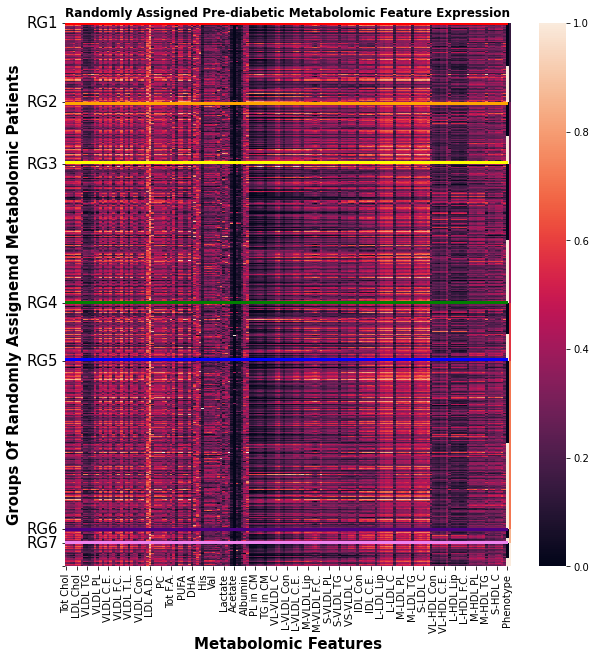

In [45]:
randomly_assigned_metabolomics_data_with_normalized_labels = randomly_assigned_metabolomics_data.drop_duplicates()
randomly_assigned_metabolomics_data_with_normalized_labels['labels'] = randomly_assigned_metabolomics_data_with_normalized_labels['labels']/7

randomly_assigned_metabolomics_data_with_normalized_labels_with_new_names = randomly_assigned_metabolomics_data_with_normalized_labels.rename(
    columns = {'target' : 'Phenotype', '23400-0.0' : 'Tot Chol', '23404-0.0' : 'LDL Chol', '23408-0.0' : 'VLDL TG', '23412-0.0' : 'VLDL PL', 
               '23416-0.0' : 'VLDL C.E.', '23420-0.0' : 'VLDL F.C.', '23424-0.0' : 'VLDL T.L.', '23428-0.0' : 'VLDL Con', 
               '23432-0.0' : 'LDL A.D.', '23437-0.0' : 'PC', '23442-0.0' : 'Tot F.A.', '23446-0.0' : 'PUFA', 
               '23450-0.0' : 'DHA', '23463-0.0' : 'His', '23467-0.0' : 'Val', '23471-0.0' : 'Lactate', 
               '23475-0.0' : 'Acetate', '23479-0.0' : 'Albumin', '23483-0.0' : 'PL in CM', '23487-0.0' : 'TG in CM', 
               '23491-0.0' : 'VL-VLDL C', '23495-0.0' : 'L-VLDL Con', '23499-0.0' : 'L-VLDL C.E.', 
               '23503-0.0' : 'M-VLDL Lip', '23507-0.0' : 'M-VLDL F.C.', '23511-0.0' : 'S-VLDL PL', 
               '23515-0.0' : 'S-VLDL TG', '23519-0.0' : 'VS-VLDL C', '23523-0.0' : 'IDL Con', '23527-0.0' : 'IDL C.E.', 
               '23531-0.0' : 'L-LDL Lip', '23535-0.0' : 'L-LDL C', '23539-0.0' : 'M-LDL PL', '23543-0.0' : 'M-LDL TG', 
               '23547-0.0' : 'S-LDL C', '23551-0.0' : 'VL-HDL Con', '23555-0.0' : 'VL-HDL C.E.', 
               '23559-0.0' : 'L-HDL Lip', '23563-0.0' : 'L-HDL F.C.', '23567-0.0' : 'M-HDL PL', 
               '23571-0.0' : 'M-HDL TG', '23575-0.0' : 'S-HDL C'})

plt.figure(figsize = (10, 10))
heatmap_by_clusters = sns.heatmap(randomly_assigned_metabolomics_data_with_normalized_labels_with_new_names.sort_values(by = ['labels', 'Phenotype']).drop(columns = ['eid', '31-0.0', 'Age Covariate', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']))

ax = heatmap_by_clusters  # this is the important part
# Horizontal lines
ax.plot([0, 168], [0, 0], '-', lw = 3, color = 'red')
#ax.plot([0, 168], [2330, 2330], '-', lw = 3)
ax.plot([0, 168], [345, 345], '-', lw = 3, color = 'orange')
ax.plot([0, 168], [600, 600], '-', lw = 3, color = 'yellow')
ax.plot([0, 168], [1200, 1200], '-', lw = 3, color = 'green')
ax.plot([0, 168], [1445, 1445], '-', lw = 3, color = 'blue')
ax.plot([0, 168], [2180, 2180], '-', lw = 3, color = 'indigo')
ax.plot([0, 168], [2235, 2235], '-', lw = 3, color = 'violet')
# Vertical lines at start and end
#ax.plot([0, 0], [0, 2339], 'c-', lw = 4)
#ax.plot([170, 170], [0, 2339], 'c-', lw = 4)

cluster_labels = ['RG1', 'RG2', 'RG3', 'RG4', 'RG5', 'RG6', 'RG7', '']
length = [0, 341, 607, 1206, 1456, 2178, 2238, 2339]

ax.set_yticks(length)
ax.set_yticklabels(cluster_labels)
ax.tick_params(axis='y', which='major', labelsize=15)

plt.title('Randomly Assigned Pre-diabetic Metabolomic Feature Expression', fontweight = 'bold')
plt.xlabel('Metabolomic Features', fontweight = 'bold', fontsize=15)
plt.ylabel('Groups Of Randomly Assignemd Metabolomic Patients', fontweight = 'bold', fontsize=15)
plt.show()

Below we standardize the columns so we can use them for PCA, TSNE, and Hierarchical clustering.

In [46]:
from sklearn.preprocessing import StandardScaler

randomly_assigned_metabolomics_data_standardized = StandardScaler().fit_transform(randomly_assigned_metabolomics_data.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 
                               'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']))
randomly_assigned_metabolomics_data_standardized

array([[-1.24191642, -1.03341215, -0.98769116, ..., -0.86874723,
        -1.56098575, -0.84917587],
       [ 0.11837746,  0.52041624,  0.67123855, ..., -1.33645849,
        -1.04419498,  0.07184665],
       [ 1.5516705 ,  1.57350412,  1.52559067, ..., -0.00915832,
         0.45734856, -0.11776135],
       ...,
       [-0.44300892, -0.88344362, -0.89035431, ..., -0.49762851,
        -0.45344998, -1.23890769],
       [-0.39948828, -0.96096412, -1.2062124 , ...,  0.68796024,
         0.69497394, -1.00572651],
       [ 1.17402686,  0.41290204,  0.34825717, ...,  0.04231534,
         1.09674454, -0.73021248]])

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(randomly_assigned_metabolomics_data_standardized)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

principal component 1  principal component 2
0                -10.769905               3.432935
1                  4.063914               3.736055
2                 10.671126              -4.880716
3                  5.907795             -13.149832
4                 -8.131205              10.100421
...                     ...                    ...
2334             -13.404999               2.095316
2335             -11.006188              -7.551671
2336             -10.056411              -8.314914
2337              -8.963266              -7.408768
2338               2.236828             -14.487765

[2339 rows x 2 columns]

In [48]:
finalDf = pd.concat([principalDf, randomly_assigned_metabolomics_data[['labels']].reset_index()], axis = 1)
finalDf

principal component 1  principal component 2  index  labels
0                -10.769905               3.432935    663       1
1                  4.063914               3.736055   1563       1
2                 10.671126              -4.880716    598       1
3                  5.907795             -13.149832    526       1
4                 -8.131205              10.100421     53       1
...                     ...                    ...    ...     ...
2334             -13.404999               2.095316   1955       7
2335             -11.006188              -7.551671   1493       7
2336             -10.056411              -8.314914   2135       7
2337              -8.963266              -7.408768    629       7
2338               2.236828             -14.487765   2162       7

[2339 rows x 4 columns]

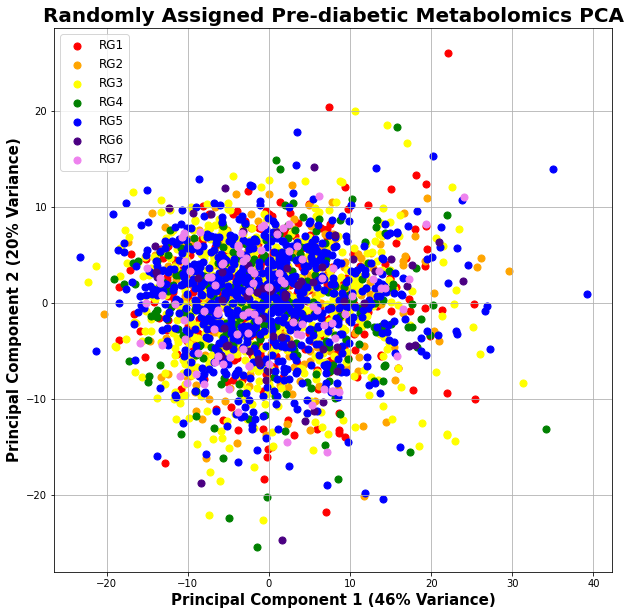

In [49]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (46% Variance)', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Principal Component 2 (20% Variance)', fontsize = 15, fontweight = 'bold')
ax.set_title('Randomly Assigned Pre-diabetic Metabolomics PCA', fontsize = 20, fontweight = 'bold')
labels = [1, 2, 3, 4, 5, 6, 7]
random_groups = ['RG1', 'RG2', 'RG3', 'RG4', 'RG5', 'RG6', 'RG7']

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['labels'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(random_groups, fontsize = 'large')
ax.grid()

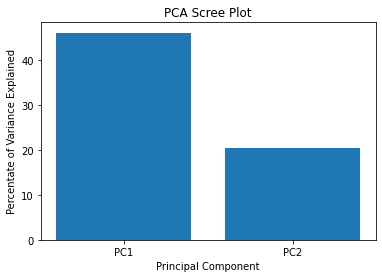

In [50]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2']
plt.bar(x= range(1,3), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

# TSNE with perplexity 30 - shows not really any distinct groups

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 100)
tsne_components = tsne.fit_transform(randomly_assigned_metabolomics_data_standardized)
principalDf = pd.DataFrame(data = tsne_components
             , columns = ['tsne component 1', 'tsne component 2'])
principalDf

tsne component 1  tsne component 2
0            19.158560        -40.306602
1             8.137384         15.380589
2           -21.745743         35.140205
3           -40.134918         18.470690
4            35.424904        -42.362576
...                ...               ...
2334          8.947388        -50.058640
2335        -20.494333        -41.879513
2336        -29.892075        -31.696234
2337        -23.707022        -36.962421
2338        -40.245197          9.484086

[2339 rows x 2 columns]

In [52]:
finalDf = pd.concat([principalDf, randomly_assigned_metabolomics_data[['labels']].reset_index()], axis = 1)
finalDf

tsne component 1  tsne component 2  index  labels
0            19.158560        -40.306602    663       1
1             8.137384         15.380589   1563       1
2           -21.745743         35.140205    598       1
3           -40.134918         18.470690    526       1
4            35.424904        -42.362576     53       1
...                ...               ...    ...     ...
2334          8.947388        -50.058640   1955       7
2335        -20.494333        -41.879513   1493       7
2336        -29.892075        -31.696234   2135       7
2337        -23.707022        -36.962421    629       7
2338        -40.245197          9.484086   2162       7

[2339 rows x 4 columns]

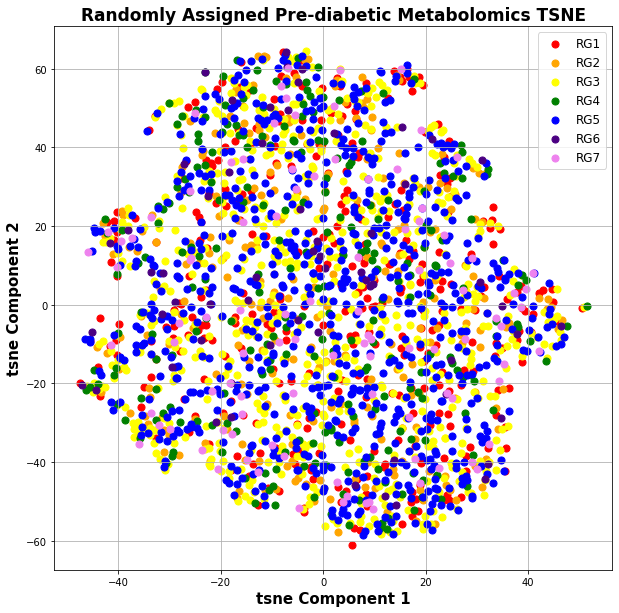

In [53]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne Component 1', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('tsne Component 2', fontsize = 15, fontweight = 'bold')
ax.set_title('Randomly Assigned Pre-diabetic Metabolomics TSNE', fontsize = 17, fontweight = 'bold')
labels = [1, 2, 3, 4, 5, 6, 7]
random_groups = ['RG1', 'RG2', 'RG3', 'RG4', 'RG5', 'RG6', 'RG7']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

for label, color in zip(labels,colors):
    indicesToKeep = finalDf['labels'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne component 1']
               , finalDf.loc[indicesToKeep, 'tsne component 2']
               , c = color
               , s = 50, alpha = 1)
ax.legend(random_groups, fontsize = 'large')
ax.grid()

#  TSNE with perplexity 200, learning rate 10, initializer pca - a little bit better and more clumped

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric = 'correlation', perplexity = 200, learning_rate = 10, init = 'pca', random_state = 100)
tsne_components = tsne.fit_transform(randomly_assigned_metabolomics_data_standardized)
principalDf = pd.DataFrame(data = tsne_components
             , columns = ['tsne component 1', 'tsne component 2'])
principalDf

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


tsne component 1  tsne component 2
0             1.114112         -2.606043
1             3.374719          3.399412
2            -1.130133          8.393345
3            -8.920202          1.243483
4             4.820377         -2.244476
...                ...               ...
2334         -1.199297         -5.308189
2335         -6.610642         -3.441551
2336         -8.881134         -3.882656
2337         -5.541826         -4.880206
2338         -9.590528         -3.496671

[2339 rows x 2 columns]

In [55]:
finalDf = pd.concat([principalDf, randomly_assigned_metabolomics_data[['labels']].reset_index()], axis = 1)
finalDf

tsne component 1  tsne component 2  index  labels
0             1.114112         -2.606043    663       1
1             3.374719          3.399412   1563       1
2            -1.130133          8.393345    598       1
3            -8.920202          1.243483    526       1
4             4.820377         -2.244476     53       1
...                ...               ...    ...     ...
2334         -1.199297         -5.308189   1955       7
2335         -6.610642         -3.441551   1493       7
2336         -8.881134         -3.882656   2135       7
2337         -5.541826         -4.880206    629       7
2338         -9.590528         -3.496671   2162       7

[2339 rows x 4 columns]

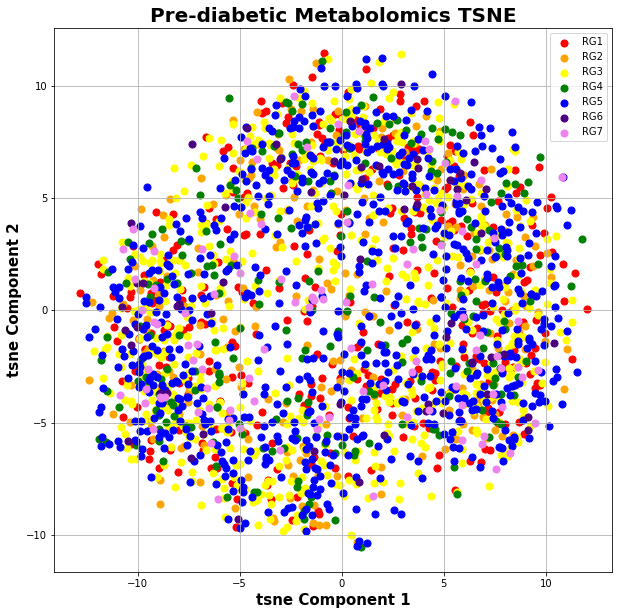

In [56]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tsne Component 1', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('tsne Component 2', fontsize = 15, fontweight = 'bold')
ax.set_title('Pre-diabetic Metabolomics TSNE', fontsize = 20, fontweight = 'bold')
group_numbers = [1, 2, 3, 4, 5, 6, 7]
labels = ['RG1', 'RG2', 'RG3', 'RG4', 'RG5', 'RG6', 'RG7']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

for group, color in zip(group_numbers,colors):
    indicesToKeep = finalDf['labels'] == group
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne component 1']
               , finalDf.loc[indicesToKeep, 'tsne component 2']
               , c = color
               , s = 50, alpha = 1)
ax.legend(labels)
ax.grid()

Below we use pearson correlation distance and color the points using the target variable. We see that the UMAP does not show a large difference between groups which the PCA and TSNE suggested.

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.


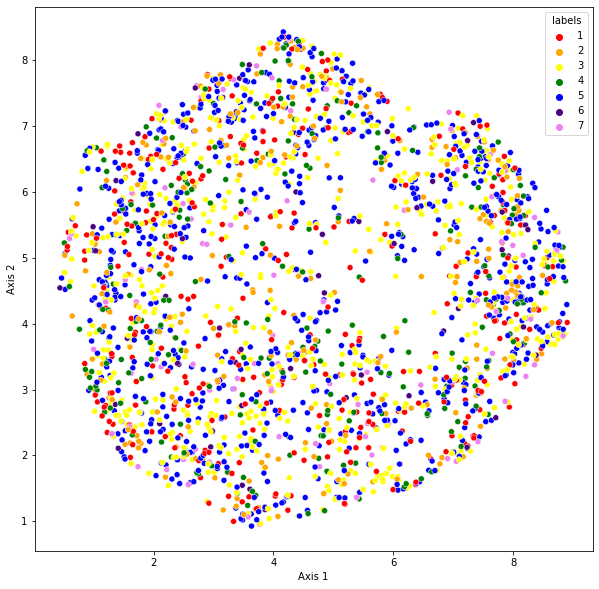

In [57]:
import umap.umap_ as umap

plt.figure(figsize=(10,10))
reducer = umap.UMAP(metric = 'correlation', random_state = 100)
embedding = reducer.fit_transform(randomly_assigned_metabolomics_data_standardized)
embedding_df = pd.DataFrame(embedding, columns = ['Axis 1', 'Axis 2'])
embedding_df['labels'] = randomly_assigned_metabolomics_data['labels']
sns.scatterplot(data = embedding_df,
                x = 'Axis 1',
                y = 'Axis 2',
                hue = 'labels', palette = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet'], legend = 'full')
#plt.legend(title = '1-Cluster 1; 2-Cluster 2; 3-Cluster 3; 4-Cluster 4; 5-Cluster 5; 6-Cluster 6; 7-Cluster 7')
plt.show()

<a class="anchor" id="Stat_testing"></a>

# Statistical Testing For Random Assignment Of Metabolites

First we run Tukey's HSD test. This shows that there are many significantly different metabolites between all the clusters. However, it does not give us good information on the unique metabolites that caused the clusters to be created as they are. For this reason, we implement a one-vs-all strategy for each cluster for all metabolites to see which are significantly different between a given cluster and the rest of the patients. This may show us unique metabolite expression to a single cluster.

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import psturng

for col in randomly_assigned_metabolomics_data.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    tukey = pairwise_tukeyhsd(endog=randomly_assigned_metabolomics_data[col],
                              groups=randomly_assigned_metabolomics_data['labels'],
                              alpha=0.05)
    print(col)
    print(tukey)

    p_values = psturng(np.abs(tukey.meandiffs / tukey.std_pairs), len(tukey.groupsunique), tukey.df_total)
    print("p values:", p_values)


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


23400-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0054    0.9 -0.0287 0.0395  False
     1      3  -0.0017    0.9   -0.03 0.0266  False
     1      4   0.0094    0.9 -0.0253 0.0441  False
     1      5  -0.0058    0.9 -0.0332 0.0216  False
     1      6   0.0303 0.6985  -0.028 0.0886  False
     1      7  -0.0105    0.9 -0.0577 0.0367  False
     2      3  -0.0071    0.9 -0.0378 0.0236  False
     2      4    0.004    0.9 -0.0328 0.0407  False
     2      5  -0.0112    0.9 -0.0411 0.0187  False
     2      6   0.0249 0.8748 -0.0347 0.0844  False
     2      7  -0.0159    0.9 -0.0646 0.0328  False
     3      4   0.0111    0.9 -0.0203 0.0425  False
     3      5  -0.0041    0.9 -0.0271 0.0189  False
     3      6    0.032 0.6157 -0.0244 0.0884  False
     3      7  -0.0088    0.9 -0.0536  0.036  False
     4      5  -0.0152 0.7385 -0.0458 0.0154  False
  

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.83009482 0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.67570887 0.9        0.9        0.9        0.9
 0.70114525 0.9        0.66001594]
23406-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0036    0.9  -0.026 0.0332  False
     1      3   0.0091    0.9 -0.0155 0.0336  False
     1      4   0.0119    0.9 -0.0182  0.042  False
     1      5  -0.0033    0.9  -0.027 0.0205  False
     1      6   0.0113    0.9 -0.0393 0.0619  False
     1      7   0.0136    0.9 -0.0274 0.0545  False
     2      3   0.0055    0.9 -0.0212 0.0321  False
     2      4   0.0083    0.9 -0.0236 0.0401  False
     2      5  -0.0069    0.9 -0.0328 0.0191  False
     2      6   0.0077    0.9  -0.044 0.0593  False
     2      7     0.01    0.9 -0.0323

 0.71841885 0.9        0.9       ]
23411-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0009    0.9 -0.0309 0.0327  False
     1      3  -0.0018    0.9 -0.0282 0.0246  False
     1      4   0.0045    0.9 -0.0279 0.0368  False
     1      5  -0.0088    0.9 -0.0344 0.0167  False
     1      6   0.0261 0.7665 -0.0283 0.0806  False
     1      7  -0.0086    0.9 -0.0527 0.0354  False
     2      3  -0.0027    0.9 -0.0313  0.026  False
     2      4   0.0036    0.9 -0.0307 0.0378  False
     2      5  -0.0097    0.9 -0.0376 0.0182  False
     2      6   0.0252 0.8112 -0.0303 0.0808  False
     2      7  -0.0095    0.9 -0.0549 0.0359  False
     3      4   0.0063    0.9  -0.023 0.0355  False
     3      5   -0.007    0.9 -0.0285 0.0145  False
     3      6   0.0279 0.6794 -0.0247 0.0806  False
     3      7  -0.0068    0.9 -0.0486  0.035  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.63094324 0.69902296
 0.9        0.9        0.9        0.56238718 0.83470581 0.9
 0.9        0.32170353 0.9        0.9        0.68622296 0.69773115
 0.32005588 0.9        0.16743375]
23417-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0049    0.9 -0.0263 0.0361  False
     1      3  -0.0048    0.9 -0.0306 0.0211  False
     1      4   0.0051    0.9 -0.0267 0.0368  False
     1      5  -0.0033    0.9 -0.0284 0.0217  False
     1      6   0.0237 0.8288 -0.0297 0.0772  False
     1      7  -0.0104    0.9 -0.0536 0.0329  False
     2      3  -0.0097    0.9 -0.0378 0.0185  False
     2      4   0.0001    0.9 -0.0335 0.0338  False
     2      5  -0.0083    0.9 -0.0356 0.0191  False
     2      6   0.0188    0.9 -0.0357 0.0734  False
     2      7  -0.0153 

 0.78110244 0.9        0.72497926]
23422-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0034    0.9 -0.0248 0.0316  False
     1      3   0.0072    0.9 -0.0162 0.0305  False
     1      4   0.0095    0.9 -0.0192 0.0382  False
     1      5  -0.0047    0.9 -0.0274 0.0179  False
     1      6   0.0187    0.9 -0.0296  0.067  False
     1      7   0.0066    0.9 -0.0324 0.0457  False
     2      3   0.0038    0.9 -0.0216 0.0292  False
     2      4   0.0061    0.9 -0.0243 0.0364  False
     2      5  -0.0081    0.9 -0.0328 0.0166  False
     2      6   0.0153    0.9  -0.034 0.0646  False
     2      7   0.0032    0.9 -0.0371 0.0435  False
     3      4   0.0023    0.9 -0.0237 0.0283  False
     3      5  -0.0119 0.5178 -0.0309 0.0072  False
     3      6   0.0115    0.9 -0.0351 0.0582  False
     3      7  -0.0005    0.9 -0.0376 0.0365  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.78006044 0.9        0.9        0.81407287 0.9        0.9
 0.9        0.86519222 0.9       ]
23428-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0054    0.9 -0.0373 0.0265  False
     1      3  -0.0107 0.8998 -0.0371 0.0158  False
     1      4  -0.0055    0.9 -0.0379  0.027  False
     1      5  -0.0086    0.9 -0.0342  0.017  False
     1      6   0.0265 0.7551  -0.028 0.0811  False
     1      7  -0.0234 0.6798 -0.0675 0.0207  False
     2      3  -0.0053    0.9  -0.034 0.0234  False
     2      4  -0.0001    0.9 -0.0344 0.0342  False
     2      5  -0.0032    0.9 -0.0311 0.0248  False
     2      6   0.0319 0.6045 -0.0238 0.0876  False
     2      7   -0.018    0.9 -0.0636

 0.9        0.9        0.9       ]
23433-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0067    0.9 -0.0265 0.0398  False
     1      3   0.0106    0.9 -0.0169 0.0381  False
     1      4   0.0123    0.9 -0.0214 0.0461  False
     1      5  -0.0027    0.9 -0.0294 0.0239  False
     1      6   0.0202    0.9 -0.0365  0.077  False
     1      7   0.0086    0.9 -0.0373 0.0545  False
     2      3   0.0039    0.9  -0.026 0.0338  False
     2      4   0.0056    0.9 -0.0301 0.0413  False
     2      5  -0.0094    0.9 -0.0385 0.0197  False
     2      6   0.0135    0.9 -0.0444 0.0715  False
     2      7   0.0019    0.9 -0.0454 0.0493  False
     3      4   0.0017    0.9 -0.0288 0.0322  False
     3      5  -0.0133 0.5675 -0.0357 0.0091  False
     3      6   0.0096    0.9 -0.0453 0.0645  False
     3      7   -0.002    0.9 -0.0456 0.0416  False
     4      5   -0.

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.69464693 0.83229098
 0.9        0.9        0.9        0.81194449 0.7350243  0.9
 0.9        0.46215343 0.9        0.9        0.86874555 0.6788715
 0.49977788 0.9        0.28062226]
23440-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0005    0.9 -0.0278 0.0288  False
     1      3   0.0059    0.9 -0.0176 0.0294  False
     1      4   0.0057    0.9 -0.0232 0.0345  False
     1      5  -0.0058    0.9 -0.0286 0.0169  False
     1      6   0.0091    0.9 -0.0394 0.0576  False
     1      7   0.0127    0.9 -0.0266 0.0519  False
     2      3   0.0054    0.9 -0.0201 0.0309  False
     2      4   0.0052    0.9 -0.0253 0.0357  False
     2      5  -0.0063    0.9 -0.0311 0.0185  False
     2      6   0.0086    0.9 -0.0409 0.0581  False
     2      7   0.0122  

 0.73198652 0.9        0.84255845]
23446-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0003    0.9  -0.034 0.0346  False
     1      3  -0.0062    0.9 -0.0347 0.0222  False
     1      4   0.0031    0.9 -0.0318  0.038  False
     1      5  -0.0089    0.9 -0.0365 0.0186  False
     1      6   0.0177    0.9  -0.041 0.0764  False
     1      7  -0.0152    0.9 -0.0627 0.0324  False
     2      3  -0.0065    0.9 -0.0374 0.0244  False
     2      4   0.0028    0.9 -0.0341 0.0397  False
     2      5  -0.0092    0.9 -0.0393 0.0208  False
     2      6   0.0174    0.9 -0.0426 0.0773  False
     2      7  -0.0155    0.9 -0.0645 0.0335  False
     3      4   0.0093    0.9 -0.0222 0.0409  False
     3      5  -0.0027    0.9 -0.0259 0.0205  False
     3      6   0.0239 0.8691 -0.0329 0.0807  False
     3      7  -0.0089    0.9  -0.054 0.0362  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.6714543  0.87620776 0.9        0.83046053
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9       ]
23461-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2    0.007   0.9 -0.0179 0.0318  False
     1      3   0.0001   0.9 -0.0205 0.0207  False
     1      4  -0.0015   0.9 -0.0269 0.0238  False
     1      5   0.0029   0.9 -0.0171 0.0228  False
     1      6   0.0132   0.9 -0.0294 0.0558  False
     1      7    0.007   0.9 -0.0275 0.0415  False
     2      3  -0.0068   0.9 -0.0293 0.0156  False
     2      4  -0.0085   0.9 -0.0353 0.0183  False
     2      5  -0.0041   0.9 -0.0259 0.0177  False
     2      6   0.0063   0.9 -0.0372 0.0497  False
     2      7      0.0   0.9 -0.0355 0.035

--------------------------------------------------
p values: [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9]
23467-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   -0.005    0.9 -0.0321  0.022  False
     1      3  -0.0047    0.9 -0.0272 0.0177  False
     1      4  -0.0128 0.7969 -0.0403 0.0148  False
     1      5   -0.012 0.6446 -0.0337 0.0098  False
     1      6    -0.03 0.4757 -0.0764 0.0164  False
     1      7  -0.0053    0.9 -0.0428 0.0322  False
     2      3   0.0003    0.9 -0.0241 0.0247  False
     2      4  -0.0077    0.9 -0.0369 0.0215  False
     2      5  -0.0069    0.9 -0.0307 0.0168  False
     2      6  -0.0249  0.685 -0.0723 0.0224  False
     2      7  -0.0003    0.9  -0.039 0.0384  False
     3      4   -0.008    0.9 -0.0329 0.0169  False
     3      5  -0.0072    0.9 -0.0255 0.0111  False
     3    

---------------------------------------------------
p values: [0.9        0.52252744 0.84778272 0.51141801 0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9       ]
23473-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0126  0.718 -0.0122 0.0373  False
     1      3   0.0076    0.9 -0.0129 0.0282  False
     1      4   0.0011    0.9 -0.0241 0.0263  False
     1      5   0.0032    0.9 -0.0167 0.0231  False
     1      6   0.0099    0.9 -0.0325 0.0523  False
     1      7   0.0098    0.9 -0.0245 0.0441  False
     2      3   -0.005    0.9 -0.0273 0.0173  False
     2      4  -0.0114 0.8551 -0.0381 0.0152  False
     2      5  -0.0093 0.8527 -0.0311 0.0124  False
     2      6  -0.0027    0.9 -0.0459 0.0406  False
     2      7  -0.0028    0.9 -0.0382

 0.9        0.9        0.9       ]
23478-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0025    0.9 -0.0158 0.0209  False
     1      3  -0.0061    0.9 -0.0213 0.0091  False
     1      4  -0.0097 0.7003 -0.0283  0.009  False
     1      5  -0.0028    0.9 -0.0176 0.0119  False
     1      6  -0.0135 0.8511 -0.0449 0.0178  False
     1      7  -0.0042    0.9 -0.0296 0.0212  False
     2      3  -0.0086 0.6957 -0.0251 0.0079  False
     2      4  -0.0122 0.5261  -0.032 0.0075  False
     2      5  -0.0054    0.9 -0.0214 0.0107  False
     2      6  -0.0161 0.7287 -0.0481  0.016  False
     2      7  -0.0068    0.9  -0.033 0.0194  False
     3      4  -0.0036    0.9 -0.0205 0.0133  False
     3      5   0.0032    0.9 -0.0092 0.0156  False
     3      6  -0.0075    0.9 -0.0378 0.0229  False
     3      7   0.0018    0.9 -0.0223  0.026  False
     4      5   0.0

---------------------------------------------------
p values: [0.84456212 0.37469872 0.67945495 0.67735259 0.9        0.61841262
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.84825976 0.9        0.9        0.9        0.9
 0.9        0.9        0.79911729]
23484-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0149 0.8128 -0.0478  0.018  False
     1      3   -0.019 0.3839 -0.0462 0.0083  False
     1      4  -0.0175 0.6938 -0.0509  0.016  False
     1      5  -0.0142 0.6684 -0.0406 0.0122  False
     1      6   0.0086    0.9 -0.0476 0.0649  False
     1      7  -0.0247 0.6601 -0.0702 0.0209  False
     2      3   -0.004    0.9 -0.0337 0.0256  False
     2      4  -0.0026    0.9  -0.038 0.0328  False
     2      5   0.0007    0.9 -0.0281 0.0296  False
     2      6   0.0236 0.8878 -0.0339  0.081  False
     2      7  -0.0097    0.9 

 0.9        0.9        0.79918793]
23489-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0085    0.9  -0.037   0.02  False
     1      3  -0.0145 0.5336 -0.0382 0.0091  False
     1      4  -0.0135 0.7891 -0.0426 0.0155  False
     1      5  -0.0076    0.9 -0.0305 0.0153  False
     1      6    0.007    0.9 -0.0418 0.0558  False
     1      7  -0.0185 0.7872 -0.0579  0.021  False
     2      3   -0.006    0.9 -0.0317 0.0196  False
     2      4  -0.0051    0.9 -0.0357 0.0256  False
     2      5   0.0009    0.9 -0.0241 0.0259  False
     2      6   0.0155    0.9 -0.0343 0.0653  False
     2      7    -0.01    0.9 -0.0507 0.0307  False
     3      4    0.001    0.9 -0.0253 0.0272  False
     3      5   0.0069    0.9 -0.0123 0.0262  False
     3      6   0.0215 0.8086 -0.0257 0.0687  False
     3      7   -0.004    0.9 -0.0414 0.0335  False
     4      5   0.0

---------------------------------------------------
p values: [0.9        0.56324718 0.7380257  0.9        0.9        0.86110477
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9       ]
23495-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0084    0.9 -0.0394 0.0227  False
     1      3  -0.0152  0.575 -0.0409 0.0105  False
     1      4  -0.0141  0.823 -0.0457 0.0174  False
     1      5  -0.0073    0.9 -0.0323 0.0176  False
     1      6   0.0109    0.9 -0.0422  0.064  False
     1      7  -0.0176 0.8888 -0.0605 0.0254  False
     2      3  -0.0068    0.9 -0.0348 0.0211  False
     2      4  -0.0058    0.9 -0.0392 0.0276  False
     2      5    0.001    0.9 -0.0262 0.0282  False
     2      6   0.0193    0.9 -0.0349 0.0734  False
     2      7  -0.0092    0.9 

 0.65381909 0.9        0.51726554]
23500-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0095    0.9 -0.0428 0.0237  False
     1      3  -0.0165 0.5603 -0.0441 0.0111  False
     1      4  -0.0143 0.8642 -0.0481 0.0195  False
     1      5  -0.0083    0.9  -0.035 0.0183  False
     1      6   0.0123    0.9 -0.0446 0.0691  False
     1      7    -0.02 0.8447  -0.066  0.026  False
     2      3   -0.007    0.9 -0.0369  0.023  False
     2      4  -0.0048    0.9 -0.0406  0.031  False
     2      5   0.0012    0.9 -0.0279 0.0303  False
     2      6   0.0218    0.9 -0.0362 0.0799  False
     2      7  -0.0105    0.9 -0.0579  0.037  False
     3      4   0.0022    0.9 -0.0284 0.0328  False
     3      5   0.0082    0.9 -0.0143 0.0306  False
     3      6   0.0288 0.6914 -0.0262 0.0838  False
     3      7  -0.0035    0.9 -0.0472 0.0402  False
     4      5    0.

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.62314229 0.9
 0.9        0.9        0.9        0.70119169 0.85141381 0.9
 0.9        0.44277999 0.9        0.9        0.87962854 0.64672939
 0.45512208 0.9        0.26844384]
23506-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0055    0.9 -0.0325 0.0436  False
     1      3  -0.0018    0.9 -0.0334 0.0297  False
     1      4   0.0137    0.9  -0.025 0.0525  False
     1      5  -0.0029    0.9 -0.0335 0.0277  False
     1      6   0.0362  0.636  -0.029 0.1013  False
     1      7   -0.019    0.9 -0.0717 0.0337  False
     2      3  -0.0074    0.9 -0.0416 0.0269  False
     2      4   0.0082    0.9 -0.0328 0.0492  False
     2      5  -0.0084    0.9 -0.0418  0.025  False
     2      6   0.0307 0.7996 -0.0359 0.0972  False
     2      7  -0.0245 0.8172 

 0.65067507 0.9        0.49298791]
23511-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0029    0.9 -0.0339 0.0281  False
     1      3   -0.008    0.9 -0.0336 0.0177  False
     1      4  -0.0014    0.9  -0.033 0.0301  False
     1      5  -0.0055    0.9 -0.0304 0.0194  False
     1      6   0.0251 0.7797  -0.028 0.0781  False
     1      7  -0.0185  0.853 -0.0614 0.0245  False
     2      3   -0.005    0.9 -0.0329 0.0229  False
     2      4   0.0015    0.9 -0.0319 0.0349  False
     2      5  -0.0026    0.9 -0.0298 0.0246  False
     2      6    0.028 0.7026 -0.0262 0.0821  False
     2      7  -0.0155    0.9 -0.0598 0.0287  False
     3      4   0.0065    0.9  -0.022  0.035  False
     3      5   0.0024    0.9 -0.0185 0.0234  False
     3      6    0.033 0.4822 -0.0183 0.0843  False
     3      7  -0.0105    0.9 -0.0513 0.0302  False
     4      5  -0.0

----------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.41566365 0.53164029
 0.9        0.9        0.9        0.39853854 0.61289475 0.9
 0.9        0.25077335 0.63494392 0.84797166 0.54918674 0.45307235
 0.12386224 0.84949831 0.04572574]
23517-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0016    0.9 -0.0333 0.0302  False
     1      3  -0.0031    0.9 -0.0294 0.0233  False
     1      4   0.0034    0.9 -0.0289 0.0358  False
     1      5  -0.0083    0.9 -0.0339 0.0172  False
     1      6   0.0358 0.4549 -0.0186 0.0902  False
     1      7  -0.0253 0.6027 -0.0693 0.0187  False
     2      3  -0.0015    0.9 -0.0301 0.0271  False
     2      4    0.005    0.9 -0.0292 0.0392  False
     2      5  -0.0068    0.9 -0.0346 0.0211  False
     2      6   0.0373 0.4271 -0.0182 0.0929  False
     2      7  -0.0237

 0.14238797 0.81019174 0.04655992]
23522-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0056    0.9 -0.0264 0.0152  False
     1      3  -0.0054    0.9 -0.0226 0.0118  False
     1      4  -0.0071    0.9 -0.0283  0.014  False
     1      5  -0.0062    0.9 -0.0229 0.0105  False
     1      6   0.0111    0.9 -0.0244 0.0467  False
     1      7  -0.0122 0.8613  -0.041 0.0165  False
     2      3   0.0002    0.9 -0.0185 0.0189  False
     2      4  -0.0015    0.9 -0.0239 0.0208  False
     2      5  -0.0006    0.9 -0.0188 0.0176  False
     2      6   0.0168 0.7979 -0.0195  0.053  False
     2      7  -0.0066    0.9 -0.0363  0.023  False
     3      4  -0.0017    0.9 -0.0208 0.0174  False
     3      5  -0.0008    0.9 -0.0148 0.0133  False
     3      6   0.0166 0.7627 -0.0178 0.0509  False
     3      7  -0.0068    0.9 -0.0341 0.0205  False
     4      5   0.0

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.75062385 0.9
 0.9        0.9        0.71761234 0.9        0.75266264 0.9
 0.9        0.77120181 0.9        0.73720148 0.9        0.75981453
 0.6300578  0.9        0.58130513]
23528-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0074    0.9 -0.0306 0.0453  False
     1      3  -0.0009    0.9 -0.0323 0.0306  False
     1      4   0.0143    0.9 -0.0243 0.0529  False
     1      5  -0.0079    0.9 -0.0383 0.0226  False
     1      6   0.0334  0.706 -0.0315 0.0983  False
     1      7  -0.0207    0.9 -0.0732 0.0319  False
     2      3  -0.0082    0.9 -0.0424 0.0259  False
     2      4    0.007    0.9 -0.0339 0.0478  False
     2      5  -0.0153 0.8032 -0.0485  0.018  False
     2      6   0.0261    0.9 -0.0402 0.0923  False
     2      7   -0.028 0.7021 

 0.70831445 0.9        0.66382245]
23533-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.007    0.9  -0.025 0.0391  False
     1      3  -0.0024    0.9  -0.029 0.0242  False
     1      4    0.008    0.9 -0.0246 0.0407  False
     1      5  -0.0023    0.9 -0.0281 0.0235  False
     1      6    0.026 0.7777 -0.0289 0.0809  False
     1      7  -0.0092    0.9 -0.0537 0.0352  False
     2      3  -0.0094    0.9 -0.0383 0.0195  False
     2      4    0.001    0.9 -0.0336 0.0355  False
     2      5  -0.0093    0.9 -0.0375 0.0188  False
     2      6    0.019    0.9 -0.0371  0.075  False
     2      7  -0.0163    0.9 -0.0621 0.0296  False
     3      4   0.0104    0.9 -0.0191 0.0399  False
     3      5   0.0001    0.9 -0.0216 0.0218  False
     3      6   0.0284 0.6723 -0.0247 0.0815  False
     3      7  -0.0068    0.9  -0.049 0.0353  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.72119024 0.9        0.9        0.9        0.9
 0.79207176 0.9        0.73378222]
23539-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.006    0.9  -0.027  0.039  False
     1      3  -0.0065    0.9 -0.0338 0.0209  False
     1      4   0.0031    0.9 -0.0305 0.0367  False
     1      5  -0.0033    0.9 -0.0298 0.0231  False
     1      6   0.0179    0.9 -0.0386 0.0743  False
     1      7  -0.0119    0.9 -0.0576 0.0338  False
     2      3  -0.0125 0.8706 -0.0422 0.0172  False
     2      4  -0.0029    0.9 -0.0384 0.0326  False
     2      5  -0.0093    0.9 -0.0383 0.0196  False
     2      6   0.0119    0.9 -0.0457 0.0695  False
     2      7  -0.0179    0.9  -0.065

 0.71851099 0.9        0.64531202]
23544-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0009    0.9 -0.0299 0.0318  False
     1      3  -0.0088    0.9 -0.0343 0.0168  False
     1      4    0.001    0.9 -0.0304 0.0324  False
     1      5  -0.0056    0.9 -0.0304 0.0192  False
     1      6   0.0262 0.7383 -0.0266  0.079  False
     1      7  -0.0207 0.7587 -0.0635  0.022  False
     2      3  -0.0097    0.9 -0.0375 0.0181  False
     2      4   0.0001    0.9 -0.0332 0.0333  False
     2      5  -0.0066    0.9 -0.0336 0.0205  False
     2      6   0.0253  0.786 -0.0286 0.0792  False
     2      7  -0.0216 0.7477 -0.0657 0.0225  False
     3      4   0.0098    0.9 -0.0186 0.0382  False
     3      5   0.0031    0.9 -0.0177  0.024  False
     3      6    0.035 0.4044 -0.0161 0.0861  False
     3      7   -0.012    0.9 -0.0525 0.0286  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.9        0.9        0.9        0.9
 0.86664437 0.9        0.9        0.9        0.80073352 0.86532849
 0.9        0.9        0.9        0.9        0.9        0.79680204
 0.9        0.9        0.83216757]
23550-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0065    0.9 -0.0319 0.0188  False
     1      3  -0.0115  0.647 -0.0326 0.0095  False
     1      4  -0.0113  0.837 -0.0371 0.0145  False
     1      5  -0.0085 0.8777 -0.0288 0.0119  False
     1      6   0.0095    0.9 -0.0339 0.0529  False
     1      7  -0.0167 0.7741 -0.0518 0.0184  False
     2      3   -0.005    0.9 -0.0278 0.0178  False
     2      4  -0.0048    0.9 -0.0321 0.0225  False
     2      5  -0.0019    0.9 -0.0241 0.0203  False
     2      6    0.016    0.9 -0.0282 0.0603  False
     2      7  -0.0102 

 0.42052021 0.9        0.56234918]
23555-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0055    0.9 -0.0201 0.0311  False
     1      3   0.0072    0.9 -0.0141 0.0284  False
     1      4    0.014  0.667 -0.0121 0.0401  False
     1      5  -0.0006    0.9 -0.0212 0.0199  False
     1      6   0.0262 0.5621 -0.0176 0.0701  False
     1      7  -0.0009    0.9 -0.0363 0.0346  False
     2      3   0.0017    0.9 -0.0214 0.0247  False
     2      4   0.0085    0.9 -0.0191 0.0361  False
     2      5  -0.0062    0.9 -0.0286 0.0163  False
     2      6   0.0207 0.7969 -0.0241 0.0655  False
     2      7  -0.0064    0.9  -0.043 0.0302  False
     3      4   0.0068    0.9 -0.0167 0.0304  False
     3      5  -0.0078 0.8161 -0.0251 0.0095  False
     3      6    0.019 0.8201 -0.0234 0.0615  False
     3      7   -0.008    0.9 -0.0417 0.0257  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.87772957 0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.47718652 0.9        0.9        0.65326964 0.9        0.9
 0.82382061 0.9        0.9       ]
23561-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0046    0.9 -0.0247 0.0339  False
     1      3   0.0096    0.9 -0.0147 0.0339  False
     1      4   0.0144 0.7628 -0.0154 0.0442  False
     1      5  -0.0016    0.9 -0.0251  0.022  False
     1      6   0.0208 0.8809 -0.0294 0.0709  False
     1      7   0.0074    0.9 -0.0332 0.0479  False
     2      3    0.005    0.9 -0.0214 0.0313  False
     2      4   0.0098    0.9 -0.0218 0.0413  False
     2      5  -0.0062    0.9 -0.0319 0.0195  False
     2      6   0.0161    0.9  -0.035 0.0673  False
     2      7   0.0027    0.9 -0.0391

 0.9        0.6474556  0.9       ]
23566-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0005    0.9 -0.0267 0.0258  False
     1      3   0.0056    0.9 -0.0162 0.0274  False
     1      4   0.0035    0.9 -0.0232 0.0303  False
     1      5  -0.0056    0.9 -0.0267 0.0155  False
     1      6   0.0017    0.9 -0.0432 0.0467  False
     1      7   0.0128    0.9 -0.0236 0.0492  False
     2      3   0.0061    0.9 -0.0176 0.0298  False
     2      4    0.004    0.9 -0.0243 0.0323  False
     2      5  -0.0051    0.9 -0.0282 0.0179  False
     2      6   0.0022    0.9 -0.0437 0.0481  False
     2      7   0.0132    0.9 -0.0243 0.0508  False
     3      4  -0.0021    0.9 -0.0263 0.0221  False
     3      5  -0.0112  0.505  -0.029 0.0066  False
     3      6  -0.0039    0.9 -0.0474 0.0396  False
     3      7   0.0072    0.9 -0.0274 0.0417  False
     4      5  -0.0

---------------------------------------------------
p values: [0.9        0.9        0.83606474 0.83072245 0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.79303652 0.9
 0.83367976 0.9        0.9       ]
23572-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0001    0.9 -0.0245 0.0244  False
     1      3  -0.0002    0.9 -0.0204 0.0201  False
     1      4   0.0002    0.9 -0.0247 0.0251  False
     1      5  -0.0036    0.9 -0.0232 0.0161  False
     1      6  -0.0062    0.9 -0.0481 0.0356  False
     1      7   0.0104    0.9 -0.0235 0.0443  False
     2      3  -0.0001    0.9 -0.0221 0.0219  False
     2      4   0.0003    0.9  -0.026 0.0266  False
     2      5  -0.0035    0.9  -0.025 0.0179  False
     2      6  -0.0062    0.9 -0.0489 0.0366  False
     2      7   0.0105    0.9 -0.0245

23577-0.0
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2     -0.0   0.9 -0.0281  0.028  False
     1      3   0.0001   0.9 -0.0232 0.0233  False
     1      4  -0.0006   0.9 -0.0292 0.0279  False
     1      5  -0.0059   0.9 -0.0285 0.0166  False
     1      6   0.0064   0.9 -0.0416 0.0544  False
     1      7   0.0059   0.9  -0.033 0.0447  False
     2      3   0.0001   0.9 -0.0251 0.0254  False
     2      4  -0.0006   0.9 -0.0308 0.0296  False
     2      5  -0.0059   0.9 -0.0305 0.0187  False
     2      6   0.0065   0.9 -0.0425 0.0555  False
     2      7   0.0059   0.9 -0.0342  0.046  False
     3      4  -0.0007   0.9 -0.0265 0.0251  False
     3      5   -0.006   0.9  -0.025 0.0129  False
     3      6   0.0063   0.9 -0.0401 0.0528  False
     3      7   0.0058   0.9 -0.0311 0.0427  False
     4      5  -0.0053   0.9 -0.0305 0.0198  False
     4      6    0.0

divide by zero encountered in true_divide


labels
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower upper reject
-----------------------------------------------
     1      2      1.0 0.001   1.0   1.0   True
     1      3      2.0 0.001   2.0   2.0   True
     1      4      3.0 0.001   3.0   3.0   True
     1      5      4.0 0.001   4.0   4.0   True
     1      6      5.0 0.001   5.0   5.0   True
     1      7      6.0 0.001   6.0   6.0   True
     2      3      1.0 0.001   1.0   1.0   True
     2      4      2.0 0.001   2.0   2.0   True
     2      5      3.0 0.001   3.0   3.0   True
     2      6      4.0 0.001   4.0   4.0   True
     2      7      5.0 0.001   5.0   5.0   True
     3      4      1.0 0.001   1.0   1.0   True
     3      5      2.0 0.001   2.0   2.0   True
     3      6      3.0 0.001   3.0   3.0   True
     3      7      4.0 0.001   4.0   4.0   True
     4      5      1.0 0.001   1.0   1.0   True
     4      6      2.0 0.001   2.0   2.0   True
     4      7      3.0 0.001 

divide by zero encountered in true_divide


p values: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]


Below we show the number of patients in each cluster.

In [59]:
print('Number of patients in Cluster 1:', len(cluster_1))
print('Number of patients in Cluster 2:', len(cluster_2))
print('Number of patients in Cluster 3:', len(cluster_3))
print('Number of patients in Cluster 4:', len(cluster_4))
print('Number of patients in Cluster 5:', len(cluster_5))
print('Number of patients in Cluster 6:', len(cluster_6))
print('Number of patients in Cluster 7:', len(cluster_7))

Number of patients in Cluster 1: 341
Number of patients in Cluster 2: 266
Number of patients in Cluster 3: 599
Number of patients in Cluster 4: 250
Number of patients in Cluster 5: 722
Number of patients in Cluster 6: 60
Number of patients in Cluster 7: 101


Below we show the proportion of patients progressing in each cluster.

In [60]:
print('Proportion of patients progressing in Cluster 1:', len(cluster_1[cluster_1['target'] == 1])/len(cluster_1))
print('Proportion of patients progressing in Cluster 2:', len(cluster_2[cluster_2['target'] == 1])/len(cluster_2))
print('Proportion of patients progressing in Cluster 3:', len(cluster_3[cluster_3['target'] == 1])/len(cluster_3))
print('Proportion of patients progressing in Cluster 4:', len(cluster_4[cluster_4['target'] == 1])/len(cluster_4))
print('Proportion of patients progressing in Cluster 5:', len(cluster_5[cluster_5['target'] == 1])/len(cluster_5))
print('Proportion of patients progressing in Cluster 6:', len(cluster_6[cluster_6['target'] == 1])/len(cluster_6))
print('Proportion of patients progressing in Cluster 7:', len(cluster_7[cluster_7['target'] == 1])/len(cluster_7))

Proportion of patients progressing in Cluster 1: 0.4604105571847507
Proportion of patients progressing in Cluster 2: 0.45112781954887216
Proportion of patients progressing in Cluster 3: 0.4540901502504174
Proportion of patients progressing in Cluster 4: 0.472
Proportion of patients progressing in Cluster 5: 0.5124653739612188
Proportion of patients progressing in Cluster 6: 0.38333333333333336
Proportion of patients progressing in Cluster 7: 0.3564356435643564


Below we make a bar graph for these results.

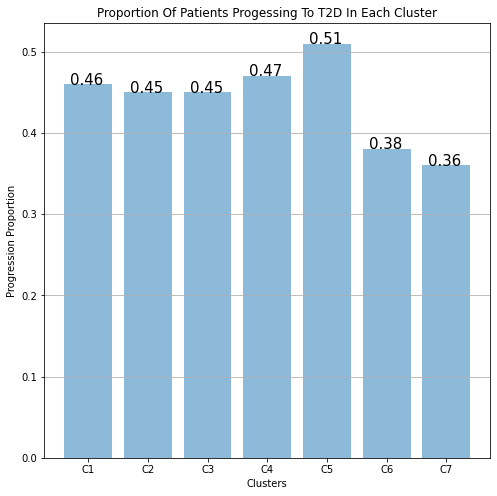

In [61]:
# Create lists for the plot
clusters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
x_pos = np.arange(len(clusters))
proportion_progressing = [0.46, 0.45, 0.45, 0.47, 0.51, 0.38, 0.36]


# Build the plot
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x_pos, proportion_progressing, align='center', alpha=0.5, capsize=10)
ax.set_ylabel('Progression Proportion')
ax.set_xlabel('Clusters')
ax.set_xticks(x_pos)
ax.set_xticklabels(clusters)
ax.set_title('Proportion Of Patients Progessing To T2D In Each Cluster')
ax.yaxis.grid(True)
for i, v in enumerate(proportion_progressing):
    plt.text(i-0.3, v, str(v), fontsize = 15)

Below we make it pretty.

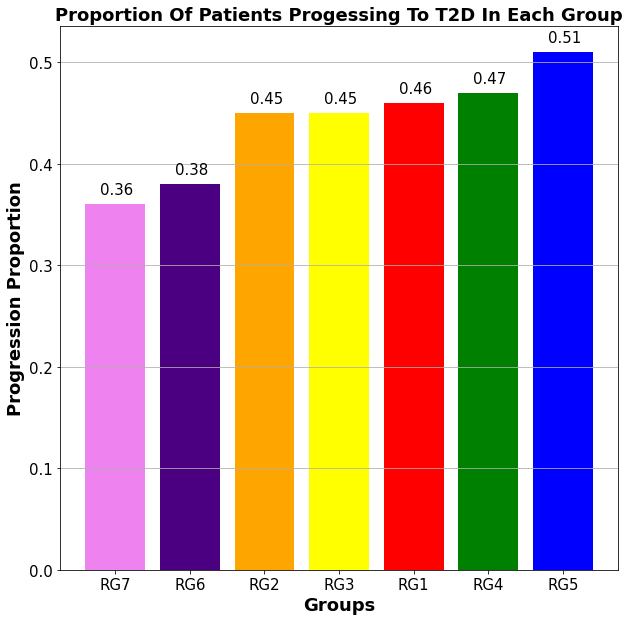

In [62]:
# Create lists for the plot
clusters = ['RG7', 'RG6', 'RG2', 'RG3', 'RG1', 'RG4', 'RG5']
x_pos = np.arange(len(clusters))
proportion_progressing = [0.36, 0.38, 0.45, 0.45, 0.46, 0.47, 0.51]

# Build the plot
fig, ax = plt.subplots(figsize = (10,10))

for i, v in enumerate(proportion_progressing):
    plt.text(i - 0.2, v + 0.01, str(format(v, '.2f')), fontsize = 15)

ax.bar(x_pos, proportion_progressing, align='center', alpha=1, capsize=10, color = ['violet', 'indigo', 'orange', 'yellow', 'red', 'green', 'blue'])
ax.set_ylabel('Progression Proportion', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Groups', fontsize = 18, fontweight = 'bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(clusters, fontsize = 15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_title('Proportion Of Patients Progessing To T2D In Each Group', fontsize = 18, fontweight = 'bold')
ax.yaxis.grid(True)


Below we rename the groups to make it easy for our analysis below we copied from Model 105.1 - Demographics Analysis Of 2339 Patients With Metabolomics Data With and Without Unsupervised Groups With Proportion Analysis For Paper

In [63]:
prediabetics_with_group_labels_and_demographics_group1 = cluster_1.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group2 = cluster_2.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group3 = cluster_3.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group4 = cluster_4.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group5 = cluster_5.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group6 = cluster_6.drop_duplicates()
prediabetics_with_group_labels_and_demographics_group7 = cluster_7.drop_duplicates()

# Below we do chi-square independence testing to find if there are differences in the numbers of patients progressing and not progressing between groups. For each test we multiply the p-value by 21 to account for multiple testing correction.

First is group 1 and group 2.

In [64]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import chi2

table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [146, 120]]
dof=1
[[185.38714992 155.61285008]
 [144.61285008 121.38714992]]
probability=0.950, critical=3.841, stat=0.021
Independent (fail to reject H0)
significance=0.050, p=18.56729
Independent (fail to reject H0)


Next is group 1 vs group 3.

In [65]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [327, 272]]
dof=1
[[185.37340426 155.62659574]
 [325.62659574 273.37340426]]
probability=0.950, critical=3.841, stat=0.014
Independent (fail to reject H0)
significance=0.050, p=19.01156
Independent (fail to reject H0)


Next is group 1 vs group 4.

In [66]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [132, 118]]
dof=1
[[182.32825719 158.67174281]
 [133.67174281 116.32825719]]
probability=0.950, critical=3.841, stat=0.038
Independent (fail to reject H0)
significance=0.050, p=17.74348
Independent (fail to reject H0)


Next is group 1 vs group 5.

In [67]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [352, 370]]
dof=1
[[171.94355597 169.05644403]
 [364.05644403 357.94355597]]
probability=0.950, critical=3.841, stat=2.307
Independent (fail to reject H0)
significance=0.050, p=2.70525
Independent (fail to reject H0)


Next is group 1 vs group 6.

In [68]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [37, 23]]
dof=1
[[187.93266833 153.06733167]
 [ 33.06733167  26.93266833]]
probability=0.950, critical=3.841, stat=0.934
Independent (fail to reject H0)
significance=0.050, p=7.01292
Independent (fail to reject H0)


Next is group 1 vs group 7.

In [69]:
table = [[len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group1[prediabetics_with_group_labels_and_demographics_group1['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[184, 157], [65, 36]]
dof=1
[[192.10180995 148.89819005]
 [ 56.89819005  44.10180995]]
probability=0.950, critical=3.841, stat=3.015
Independent (fail to reject H0)
significance=0.050, p=1.73259
Independent (fail to reject H0)


Next is group 2 vs group 3.

In [70]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[146, 120], [327, 272]]
dof=1
[[145.45433526 120.54566474]
 [327.54566474 271.45433526]]
probability=0.950, critical=3.841, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=20.88675
Independent (fail to reject H0)


Next is group 2 vs group 4.

In [71]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[146, 120], [132, 118]]
dof=1
[[143.31007752 122.68992248]
 [134.68992248 115.31007752]]
probability=0.950, critical=3.841, stat=0.150
Independent (fail to reject H0)
significance=0.050, p=14.67429
Independent (fail to reject H0)


Next is group 2 vs group 5.

In [72]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[146, 120], [352, 370]]
dof=1
[[134.07692308 131.92307692]
 [363.92307692 358.07692308]]
probability=0.950, critical=3.841, stat=2.685
Independent (fail to reject H0)
significance=0.050, p=2.12684
Independent (fail to reject H0)


Next is group 2 vs group 6.

In [73]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[146, 120], [37, 23]]
dof=1
[[149.3190184 116.6809816]
 [ 33.6809816  26.3190184]]
probability=0.950, critical=3.841, stat=0.659
Independent (fail to reject H0)
significance=0.050, p=8.75356
Independent (fail to reject H0)


Next is group 2 vs group 7.

In [74]:
table = [[len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group2[prediabetics_with_group_labels_and_demographics_group2['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[146, 120], [65, 36]]
dof=1
[[152.93188011 113.06811989]
 [ 58.06811989  42.93188011]]
probability=0.950, critical=3.841, stat=2.312
Independent (fail to reject H0)
significance=0.050, p=2.69525
Independent (fail to reject H0)


Next is group 3 vs group 4.

In [75]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[327, 272], [132, 118]]
dof=1
[[323.8409894 275.1590106]
 [135.1590106 114.8409894]]
probability=0.950, critical=3.841, stat=0.161
Independent (fail to reject H0)
significance=0.050, p=14.44518
Independent (fail to reject H0)


Next is group 3 vs group 5.

In [76]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[327, 272], [352, 370]]
dof=1
[[307.88872067 291.11127933]
 [371.11127933 350.88872067]]
probability=0.950, critical=3.841, stat=4.235
Dependent (reject H0)
significance=0.050, p=0.83139
Independent (fail to reject H0)


Next is group 3 vs group 6.

In [77]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[327, 272], [37, 23]]
dof=1
[[330.85887709 268.14112291]
 [ 33.14112291  26.85887709]]
probability=0.950, critical=3.841, stat=0.837
Independent (fail to reject H0)
significance=0.050, p=7.56750
Independent (fail to reject H0)


Next is group 3 vs group 7.

In [78]:
table = [[len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group3[prediabetics_with_group_labels_and_demographics_group3['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[327, 272], [65, 36]]
dof=1
[[335.44 263.56]
 [ 56.56  44.44]]
probability=0.950, critical=3.841, stat=2.960
Independent (fail to reject H0)
significance=0.050, p=1.79187
Independent (fail to reject H0)


Next is group 4 vs group 5.

In [79]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[132, 118], [352, 370]]
dof=1
[[124.48559671 125.51440329]
 [359.51440329 362.48559671]]
probability=0.950, critical=3.841, stat=1.060
Independent (fail to reject H0)
significance=0.050, p=6.36831
Independent (fail to reject H0)


Next is group 4 vs group 6.

In [80]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[132, 118], [37, 23]]
dof=1
[[136.29032258 113.70967742]
 [ 32.70967742  27.29032258]]
probability=0.950, critical=3.841, stat=1.197
Independent (fail to reject H0)
significance=0.050, p=5.75067
Independent (fail to reject H0)


Next is group 4 vs group 7.

In [81]:
table = [[len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group4[prediabetics_with_group_labels_and_demographics_group4['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[132, 118], [65, 36]]
dof=1
[[140.31339031 109.68660969]
 [ 56.68660969  44.31339031]]
probability=0.950, critical=3.841, stat=3.446
Independent (fail to reject H0)
significance=0.050, p=1.33127
Independent (fail to reject H0)


Next is group 5 vs group 6.

In [82]:
table = [[len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[352, 370], [37, 23]]
dof=1
[[359.15345269 362.84654731]
 [ 29.84654731  30.15345269]]
probability=0.950, critical=3.841, stat=3.197
Independent (fail to reject H0)
significance=0.050, p=1.54965
Independent (fail to reject H0)


Next is group 5 vs group 7.

In [83]:
table = [[len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group5[prediabetics_with_group_labels_and_demographics_group5['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[352, 370], [65, 36]]
dof=1
[[365.82503038 356.17496962]
 [ 51.17496962  49.82503038]]
probability=0.950, critical=3.841, stat=8.017
Dependent (reject H0)
significance=0.050, p=0.09731
Independent (fail to reject H0)


Next is group 6 vs group 7.

In [84]:
table = [[len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group6[prediabetics_with_group_labels_and_demographics_group6['target'] == 1])],
         [len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 0]), len(prediabetics_with_group_labels_and_demographics_group7[prediabetics_with_group_labels_and_demographics_group7['target'] == 1])]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.5f' % (alpha, p*21)) # Bonferroni correction with categorical testing = 7 * 1 (sex only)
if p*21 <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[37, 23], [65, 36]]
dof=1
[[38.01242236 21.98757764]
 [63.98757764 37.01242236]]
probability=0.950, critical=3.841, stat=0.030
Independent (fail to reject H0)
significance=0.050, p=18.11003
Independent (fail to reject H0)


Next, we import the information with the epistart dates and icd codes. 

In [85]:
prediabetes_containing_unknowns = pd.read_csv('icd_codes_and_epistart_dates_to_try_to_classify_unknown_patients')
prediabetes_containing_unknowns = prediabetes_containing_unknowns.drop(columns = 'Unnamed: 0')
prediabetes_containing_unknowns

eid  ins_index    epistart diag_icd10
0       1000072         12  28/08/2015       Z885
1       1000072         12  28/08/2015       Z867
2       1000072         12  28/08/2015       Z864
3       1000072         12  28/08/2015       Z922
4       1000072         12  28/08/2015       Z966
...         ...        ...         ...        ...
727730  6025367         12  02/11/2017        I10
727731  6025367         12  02/11/2017       N183
727732  6025367         12  02/11/2017       H269
727733  6025367         12  02/11/2017       Z961
727734  6025367          2  07/06/2005       I839

[727735 rows x 4 columns]

Next we filter for only patients with type 2 diabetes.

In [86]:
prediabetes_to_diabetes_with_date = prediabetes_containing_unknowns[prediabetes_containing_unknowns['diag_icd10'].str.contains('E11', na = False)]
prediabetes_to_diabetes_with_date

eid  ins_index    epistart diag_icd10
302     1002432          1  02/03/2020       E119
315     1003245          8  22/08/2013       E119
327     1003245          6  05/11/2012       E119
360     1005686          2  04/11/2019       E119
387     1005936          4  10/05/2016       E119
...         ...        ...         ...        ...
727678  6025367         11  07/09/2017       E119
727681  6025367          4  20/10/2014       E119
727704  6025367          6  09/04/2015       E119
727715  6025367          5  31/12/2014       E119
727727  6025367         12  02/11/2017       E119

[21287 rows x 4 columns]

Below we merge the epistart dates with the patients we know progress to diabetes.

In [87]:
randomly_assigned_metabolomics_data_with_dates = pd.merge(randomly_assigned_metabolomics_data, prediabetes_to_diabetes_with_date[['eid', 'epistart']], on = 'eid')
randomly_assigned_metabolomics_data_with_dates

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
2      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
3      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
4      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
...         ...        ...        ...        ...        ...        ...   
4980   0.313611   0.317830   0.345253   0.335393   0.374335   0.367274   
4981   0.359280   0.293503   0.253220   0.198296   0.374665   0.404083   
4982   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
4983   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
4984   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Age Covariate  \
0      0.136503   0.247706   0.235767   0.226100  ...              1   
1      0.136503   0.247706   0.235767   0.226100  ...              1   
2      0.136503   0.247706   0.235767   0.226100  ...              1   
3      0.136503   0.247706   0.235767   0.226100  ...              1   
4      0.136503   0.247706   0.235767   0.226100  ...              1   
...         ...        ...        ...        ...  ...            ...   
4980   0.198621   0.196480   0.195279   0.113537  ...              1   
4981   0.405810   0.110294   0.100003   0.110671  ...              1   
4982   0.444843   0.053610   0.038847   0.087918  ...              1   
4983   0.444843   0.053610   0.038847   0.087918  ...              1   
4984   0.444843   0.053610   0.038847   0.087918  ...              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
0               1            0            0            0            0   
1               1            0            0            0            0   
2               1            0            0            0            0   
3               1            0            0            0            0   
4               1            0            0            0            0   
...           ...          ...          ...          ...          ...   
4980            1            0            0            0            0   
4981            0            0            0            0            1   
4982            0            1            0            0            0   
4983            0            1            0            0            0   
4984            0            1            0            0            0   

      Ethnicity_5  target  labels    epistart  
0               0       1       1  25/09/2020  
1               0       1       1  14/04/2014  
2               0       1       1  04/08/2020  
3               0       1       1  11/12/2019  
4               0       1       1  08/04/2019  
...           ...     ...     ...         ...  
4980            0       1       7  02/12/2019  
4981            0       1       7  07/06/2016  
4982            0       1       7  21/08/2017  
4983            0       1       7  09/09/2017  
4984            0       1       7  17/08/2017  

[4985 rows x 180 columns]

Below we import the whole dataframe of prediabetic patients with all the features.

In [88]:
prediabetes_with_all = pd.read_csv('all_features_prediabetic_patients_with_additional_4513_patients_from_unknown_patients_who_have_ICD_code_since_2018')
prediabetes_with_all = prediabetes_with_all.drop(columns = 'Unnamed: 0')
prediabetes_with_all

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3233,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 12711 columns]

Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [89]:
spike_cols = [col for col in prediabetes_with_all.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [90]:
prediabetes_with_all = prediabetes_with_all.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_all

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [91]:
prediabetes_with_all.shape

(9944, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number, with exception of eid)

In [92]:
prediabetes_with_all.columns = prediabetes_with_all.columns.str.replace('_y','')
prediabetes_with_all

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we add the date attending assessment center column to the dataframe with epistart dates.

In [93]:
randomly_assigned_metabolomics_data_with_dates_all_included = pd.merge(randomly_assigned_metabolomics_data_with_dates, prediabetes_with_all[['eid', '53-0.0']], on = 'eid')
randomly_assigned_metabolomics_data_with_dates_all_included

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
2      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
3      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
4      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
...         ...        ...        ...        ...        ...        ...   
4980   0.313611   0.317830   0.345253   0.335393   0.374335   0.367274   
4981   0.359280   0.293503   0.253220   0.198296   0.374665   0.404083   
4982   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
4983   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
4984   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
0      0.136503   0.247706   0.235767   0.226100  ...            1   
1      0.136503   0.247706   0.235767   0.226100  ...            1   
2      0.136503   0.247706   0.235767   0.226100  ...            1   
3      0.136503   0.247706   0.235767   0.226100  ...            1   
4      0.136503   0.247706   0.235767   0.226100  ...            1   
...         ...        ...        ...        ...  ...          ...   
4980   0.198621   0.196480   0.195279   0.113537  ...            1   
4981   0.405810   0.110294   0.100003   0.110671  ...            0   
4982   0.444843   0.053610   0.038847   0.087918  ...            0   
4983   0.444843   0.053610   0.038847   0.087918  ...            0   
4984   0.444843   0.053610   0.038847   0.087918  ...            0   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
0               0            0            0            0            0       1   
1               0            0            0            0            0       1   
2               0            0            0            0            0       1   
3               0            0            0            0            0       1   
4               0            0            0            0            0       1   
...           ...          ...          ...          ...          ...     ...   
4980            0            0            0            0            0       1   
4981            0            0            0            1            0       1   
4982            1            0            0            0            0       1   
4983            1            0            0            0            0       1   
4984            1            0            0            0            0       1   

      labels    epistart      53-0.0  
0          1  25/09/2020  2008-06-10  
1          1  14/04/2014  2008-06-10  
2          1  04/08/2020  2008-06-10  
3          1  11/12/2019  2008-06-10  
4          1  08/04/2019  2008-06-10  
...      ...         ...         ...  
4980       7  02/12/2019  2009-06-24  
4981       7  07/06/2016  2010-06-19  
4982       7  21/08/2017  2009-07-06  
4983       7  09/09/2017  2009-07-06  
4984       7  17/08/2017  2009-07-06  

[4985 rows x 181 columns]

Below we convert the date columns to datetime.

In [94]:
randomly_assigned_metabolomics_data_with_dates_all_included['epistart'] = pd.to_datetime(randomly_assigned_metabolomics_data_with_dates_all_included['epistart'])
randomly_assigned_metabolomics_data_with_dates_all_included['53-0.0'] = pd.to_datetime(randomly_assigned_metabolomics_data_with_dates_all_included['53-0.0'])

Below we sort our dataframe such that we only have increasing dates for each eid number.

In [95]:
randomly_assigned_metabolomics_data_with_dates_sorted = randomly_assigned_metabolomics_data_with_dates_all_included.sort_values(by=['eid', 'epistart'])
randomly_assigned_metabolomics_data_with_dates_sorted

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
553    0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
1070   0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
4317   0.366704   0.386069   0.433119   0.541652   0.340906   0.411231   
4319   0.366704   0.386069   0.433119   0.541652   0.340906   0.411231   
4316   0.366704   0.386069   0.433119   0.541652   0.340906   0.411231   
...         ...        ...        ...        ...        ...        ...   
3632   0.601800   0.623234   0.574180   0.592797   0.679538   0.706037   
3699   0.207776   0.200361   0.208815   0.232488   0.241352   0.278798   
2704   0.573116   0.544505   0.542439   0.513856   0.571411   0.595105   
4335   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   
4336   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
553    0.345652   0.073043   0.067466   0.103913  ...            1   
1070   0.177170   0.333359   0.303467   0.302916  ...            1   
4317   0.177527   0.632925   0.602186   0.473261  ...            1   
4319   0.177527   0.632925   0.602186   0.473261  ...            1   
4316   0.177527   0.632925   0.602186   0.473261  ...            1   
...         ...        ...        ...        ...  ...          ...   
3632   0.260587   0.369168   0.360688   0.288200  ...            1   
3699   0.190263   0.188393   0.178078   0.142137  ...            1   
2704   0.385598   0.338480   0.309144   0.296720  ...            1   
4335   0.180743   0.365576   0.358917   0.246296  ...            1   
4336   0.180743   0.365576   0.358917   0.246296  ...            1   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
553             0            0            0            0            0       1   
1070            0            0            0            0            0       1   
4317            0            0            0            0            0       1   
4319            0            0            0            0            0       1   
4316            0            0            0            0            0       1   
...           ...          ...          ...          ...          ...     ...   
3632            0            0            0            0            0       1   
3699            0            0            0            0            0       1   
2704            0            0            0            0            0       1   
4335            0            0            0            0            0       1   
4336            0            0            0            0            0       1   

      labels   epistart     53-0.0  
553        1 2019-04-11 2010-06-18  
1070       2 2016-10-05 2009-07-09  
4317       5 2016-10-25 2008-11-08  
4319       5 2017-09-26 2008-11-08  
4316       5 2020-07-16 2008-11-08  
...      ...        ...        ...  
3632       5 2019-10-07 2009-09-23  
3699       5 2018-03-29 2009-07-27  
2704       4 2014-11-20 2008-10-07  
4335       5 2019-08-20 2008-04-01  
4336       5 2020-10-16 2008-04-01  

[4985 rows x 181 columns]

Now we can drop duplicates based on eid number since we will only keep our earliest diabetes diagnosis for each patient.

In [96]:
randomly_assigned_metabolomics_data_with_dates_sorted_final = randomly_assigned_metabolomics_data_with_dates_sorted.drop_duplicates(subset = 'eid')
randomly_assigned_metabolomics_data_with_dates_sorted_final

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
553    0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
1070   0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
4317   0.366704   0.386069   0.433119   0.541652   0.340906   0.411231   
3753   0.431145   0.444668   0.443634   0.437424   0.496915   0.505110   
1560   0.167112   0.163014   0.136842   0.169097   0.237285   0.275393   
...         ...        ...        ...        ...        ...        ...   
1222   0.259435   0.253914   0.291374   0.297913   0.293299   0.301536   
3631   0.601800   0.623234   0.574180   0.592797   0.679538   0.706037   
3699   0.207776   0.200361   0.208815   0.232488   0.241352   0.278798   
2704   0.573116   0.544505   0.542439   0.513856   0.571411   0.595105   
4335   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
553    0.345652   0.073043   0.067466   0.103913  ...            1   
1070   0.177170   0.333359   0.303467   0.302916  ...            1   
4317   0.177527   0.632925   0.602186   0.473261  ...            1   
3753   0.217686   0.303500   0.299220   0.220833  ...            1   
1560   0.165895   0.153100   0.148437   0.112840  ...            1   
...         ...        ...        ...        ...  ...          ...   
1222   0.204589   0.246490   0.237239   0.189037  ...            1   
3631   0.260587   0.369168   0.360688   0.288200  ...            1   
3699   0.190263   0.188393   0.178078   0.142137  ...            1   
2704   0.385598   0.338480   0.309144   0.296720  ...            1   
4335   0.180743   0.365576   0.358917   0.246296  ...            1   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
553             0            0            0            0            0       1   
1070            0            0            0            0            0       1   
4317            0            0            0            0            0       1   
3753            0            0            0            0            0       1   
1560            0            0            0            0            0       1   
...           ...          ...          ...          ...          ...     ...   
1222            0            0            0            0            0       1   
3631            0            0            0            0            0       1   
3699            0            0            0            0            0       1   
2704            0            0            0            0            0       1   
4335            0            0            0            0            0       1   

      labels   epistart     53-0.0  
553        1 2019-04-11 2010-06-18  
1070       2 2016-10-05 2009-07-09  
4317       5 2016-10-25 2008-11-08  
3753       5 2016-06-19 2008-06-25  
1560       3 2017-07-06 2008-11-18  
...      ...        ...        ...  
1222       2 2013-01-12 2010-06-26  
3631       5 2017-02-06 2009-09-23  
3699       5 2018-03-29 2009-07-27  
2704       4 2014-11-20 2008-10-07  
4335       5 2019-08-20 2008-04-01  

[1055 rows x 181 columns]

Below we compare the datetime columns to produce a column which contains information about how long after we classified the patient as pre-diabetic it took for them to develop diabetes.

In [97]:
randomly_assigned_metabolomics_data_with_dates_sorted_final['days between diagnoses'] = (randomly_assigned_metabolomics_data_with_dates_sorted_final['epistart'] - randomly_assigned_metabolomics_data_with_dates_sorted_final['53-0.0']).dt.days
randomly_assigned_metabolomics_data_with_dates_sorted_final


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
553    0.302067   0.250503   0.216074   0.160176   0.350962   0.360633   
1070   0.407157   0.432272   0.438263   0.453080   0.457093   0.487943   
4317   0.366704   0.386069   0.433119   0.541652   0.340906   0.411231   
3753   0.431145   0.444668   0.443634   0.437424   0.496915   0.505110   
1560   0.167112   0.163014   0.136842   0.169097   0.237285   0.275393   
...         ...        ...        ...        ...        ...        ...   
1222   0.259435   0.253914   0.291374   0.297913   0.293299   0.301536   
3631   0.601800   0.623234   0.574180   0.592797   0.679538   0.706037   
3699   0.207776   0.200361   0.208815   0.232488   0.241352   0.278798   
2704   0.573116   0.544505   0.542439   0.513856   0.571411   0.595105   
4335   0.272722   0.277841   0.249704   0.293672   0.315793   0.379600   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_1  \
553    0.345652   0.073043   0.067466   0.103913  ...            0   
1070   0.177170   0.333359   0.303467   0.302916  ...            0   
4317   0.177527   0.632925   0.602186   0.473261  ...            0   
3753   0.217686   0.303500   0.299220   0.220833  ...            0   
1560   0.165895   0.153100   0.148437   0.112840  ...            0   
...         ...        ...        ...        ...  ...          ...   
1222   0.204589   0.246490   0.237239   0.189037  ...            0   
3631   0.260587   0.369168   0.360688   0.288200  ...            0   
3699   0.190263   0.188393   0.178078   0.142137  ...            0   
2704   0.385598   0.338480   0.309144   0.296720  ...            0   
4335   0.180743   0.365576   0.358917   0.246296  ...            0   

      Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  labels  \
553             0            0            0            0       1       1   
1070            0            0            0            0       1       2   
4317            0            0            0            0       1       5   
3753            0            0            0            0       1       5   
1560            0            0            0            0       1       3   
...           ...          ...          ...          ...     ...     ...   
1222            0            0            0            0       1       2   
3631            0            0            0            0       1       5   
3699            0            0            0            0       1       5   
2704            0            0            0            0       1       4   
4335            0            0            0            0       1       5   

       epistart     53-0.0  days between diagnoses  
553  2019-04-11 2010-06-18                    3219  
1070 2016-10-05 2009-07-09                    2645  
4317 2016-10-25 2008-11-08                    2908  
3753 2016-06-19 2008-06-25                    2916  
1560 2017-07-06 2008-11-18                    3152  
...         ...        ...                     ...  
1222 2013-01-12 2010-06-26                     931  
3631 2017-02-06 2009-09-23                    2693  
3699 2018-03-29 2009-07-27                    3167  
2704 2014-11-20 2008-10-07                    2235  
4335 2019-08-20 2008-04-01                    4158  

[1055 rows x 182 columns]

Next we show the average days to progression for patients in each cluster.

In [98]:
print('Average Days To Progression For Cluster 1:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses'])/np.sqrt(len(cluster_1)))
print('Average Days To Progression For Cluster 2:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses'])/np.sqrt(len(cluster_2)))
print('Average Days To Progression For Cluster 3:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses'])/np.sqrt(len(cluster_3)))
print('Average Days To Progression For Cluster 4:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses'])/np.sqrt(len(cluster_4)))
print('Average Days To Progression For Cluster 5:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses'])/np.sqrt(len(cluster_5)))
print('Average Days To Progression For Cluster 6:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses'])/np.sqrt(len(cluster_6)))
print('Average Days To Progression For Cluster 7:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses'])/np.sqrt(len(cluster_7)))

Average Days To Progression For Cluster 1: 2433.7662337662337 with standard deviation 1078.6520977362213 with standard error 58.412285996019655
Average Days To Progression For Cluster 2: 2611.198275862069 with standard deviation 1028.6303851760222 with standard error 63.069375494099226
Average Days To Progression For Cluster 3: 2636.889312977099 with standard deviation 1080.9882172883854 with standard error 44.16798117183074
Average Days To Progression For Cluster 4: 2818.108108108108 with standard deviation 1081.5373138665211 with standard error 68.40242572557233
Average Days To Progression For Cluster 5: 2525.1492957746477 with standard deviation 1051.4617070406057 with standard error 39.13135280033659
Average Days To Progression For Cluster 6: 2523.818181818182 with standard deviation 1046.7917929804569 with standard error 135.14023937199704
Average Days To Progression For Cluster 7: 2472.9714285714285 with standard deviation 1014.7369676272702 with standard error 100.97010210700438

Below we make a bar graph for these results with standard error being the error.

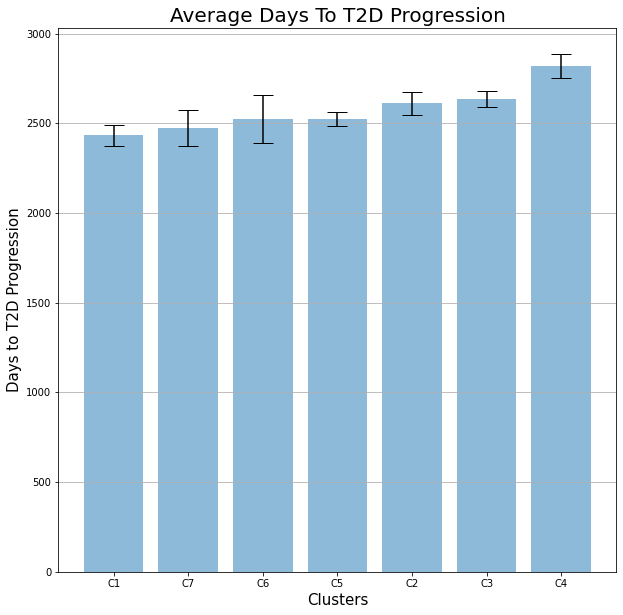

In [99]:
# Create lists for the plot
clusters = ['C1', 'C7', 'C6', 'C5', 'C2', 'C3', 'C4']
x_pos = np.arange(len(clusters))
time_to_progression = [2433, 2473, 2524, 2525, 2611, 2636, 2818]
error = [58, 101, 135, 39, 63, 44, 68]

# Build the plot
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(x_pos, time_to_progression, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Days to T2D Progression', fontsize = 15)
ax.set_xlabel('Clusters', fontsize = 15)
ax.set_xticks(x_pos)
ax.set_xticklabels(clusters)
ax.set_title('Average Days To T2D Progression', fontsize = 20)
ax.yaxis.grid(True)

Next we show the average days to progression for patients in each cluster WHEN TAKING THE STANDARD ERROR USING ONLY PROGRESSORS WITH DATES OF PROGRESSION.

In [100]:
print('Average Days To Progression For Cluster 1:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1])))
print('Average Days To Progression For Cluster 2:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2])))
print('Average Days To Progression For Cluster 3:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3])))
print('Average Days To Progression For Cluster 4:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4])))
print('Average Days To Progression For Cluster 5:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5])))
print('Average Days To Progression For Cluster 6:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6])))
print('Average Days To Progression For Cluster 7:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses'].mean(), 'with standard deviation', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses']), 'with standard error', std(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses'])/np.sqrt(len(randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7])))

Average Days To Progression For Cluster 1: 2433.7662337662337 with standard deviation 1078.6520977362213 with standard error 86.92026305499961
Average Days To Progression For Cluster 2: 2611.198275862069 with standard deviation 1028.6303851760222 with standard error 95.50593361722628
Average Days To Progression For Cluster 3: 2636.889312977099 with standard deviation 1080.9882172883854 with standard error 66.78367509521021
Average Days To Progression For Cluster 4: 2818.108108108108 with standard deviation 1081.5373138665211 with standard error 102.65497891610887
Average Days To Progression For Cluster 5: 2525.1492957746477 with standard deviation 1051.4617070406057 with standard error 55.80579306020257
Average Days To Progression For Cluster 6: 2523.818181818182 with standard deviation 1046.7917929804569 with standard error 223.17676013860725
Average Days To Progression For Cluster 7: 2472.9714285714285 with standard deviation 1014.7369676272702 with standard error 171.5218531241001


Below we make a bar graph for these results with standard error USING ONLY THE SIZE OF THE PATIENTS PROGRESSING IN EACH CLUSTER being the error.

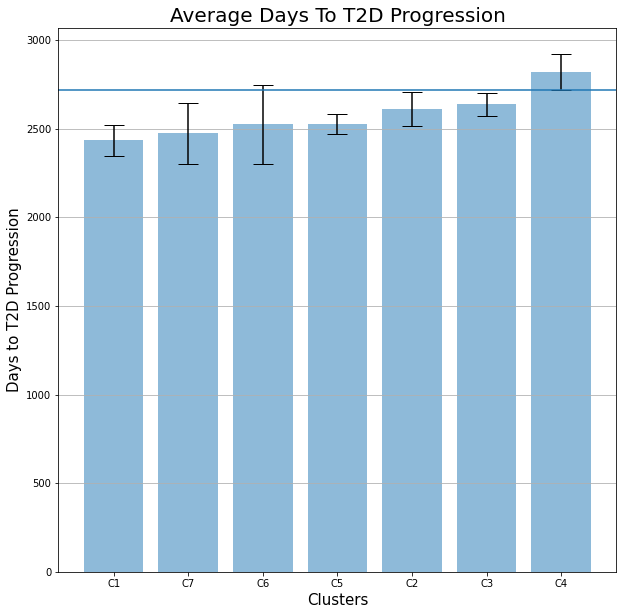

In [101]:
# Create lists for the plot
clusters = ['C1', 'C7', 'C6', 'C5', 'C2', 'C3', 'C4']
x_pos = np.arange(len(clusters))
time_to_progression = [2433, 2473, 2524, 2525, 2611, 2636, 2818]
error = [87, 172, 223, 56, 96, 67, 102]

# Build the plot
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(x_pos, time_to_progression, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Days to T2D Progression', fontsize = 15)
ax.set_xlabel('Clusters', fontsize = 15)
ax.set_xticks(x_pos)
ax.set_xticklabels(clusters)
ax.set_title('Average Days To T2D Progression', fontsize = 20)
ax.yaxis.grid(True)
plt.axhline(y = 2818 - 102)

Below we show the median progression time to T2D for each cluster.

In [102]:
print('Median Days To Progression For Cluster 1:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 1]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 2:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 2]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 3:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 3]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 4:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 4]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 5:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 5]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 6:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 6]['days between diagnoses'].median())
print('Median Days To Progression For Cluster 7:', randomly_assigned_metabolomics_data_with_dates_sorted_final[randomly_assigned_metabolomics_data_with_dates_sorted_final['labels'] == 7]['days between diagnoses'].median())


Median Days To Progression For Cluster 1: 2367.0
Median Days To Progression For Cluster 2: 2634.0
Median Days To Progression For Cluster 3: 2759.5
Median Days To Progression For Cluster 4: 3085.0
Median Days To Progression For Cluster 5: 2583.0
Median Days To Progression For Cluster 6: 2741.0
Median Days To Progression For Cluster 7: 2503.0


# Cluster 1

Below we look at a one-vs-all t-test comparison between cluster 1 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 1 for comparison.

In [103]:
not_cluster_1 = cluster_2.append([cluster_3, cluster_4, cluster_5, cluster_6, cluster_7])
not_cluster_1

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
1854   0.413822   0.385781   0.331026   0.342339   0.448374   0.499003   
1536   0.490734   0.498526   0.490155   0.442247   0.566026   0.559535   
638    0.509632   0.507830   0.495592   0.482142   0.548991   0.571185   
880    0.350534   0.304313   0.264712   0.249992   0.383989   0.413172   
112    0.538794   0.542743   0.505652   0.420259   0.638581   0.623837   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
1854   0.323918   0.395453   0.403246   0.240855  ...       1              0   
1536   0.255719   0.216834   0.216345   0.147540  ...       0              0   
638    0.288884   0.307221   0.287140   0.278557  ...       0              1   
880    0.349433   0.132599   0.127694   0.115493  ...       1              0   
112    0.284233   0.163121   0.159988   0.157938  ...       0              0   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
1854            1            0            0            0            0   
1536            1            0            0            0            0   
638             1            0            0            0            0   
880             1            0            0            0            0   
112             1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
1854            0       1       2  
1536            0       0       2  
638             0       1       2  
880             0       0       2  
112             0       0       2  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[1998 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [104]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_1.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_1[cluster_1[i].notnull()]
    filtered_df2 = not_cluster_1[not_cluster_1[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=0.137 pval=0.712
Statistic and pval for Column 23401-0.0: stat=2.450 pval=0.118
Statistic and pval for Column 23402-0.0: stat=2.032 pval=0.154
Statistic and pval for Column 23403-0.0: stat=2.058 pval=0.152
Statistic and pval for Column 23404-0.0: stat=0.999 pval=0.318
Statistic and pval for Column 23405-0.0: stat=1.583 pval=0.208
Statistic and pval for Column 23406-0.0: stat=0.163 pval=0.686
Statistic and pval for Column 23407-0.0: stat=1.039 pval=0.308
Statistic and pval for Column 23408-0.0: stat=0.597 pval=0.440
Statistic and pval for Column 23409-0.0: stat=0.861 pval=0.354
Statistic and pval for Column 23410-0.0: stat=2.455 pval=0.117
Statistic and pval for Column 23411-0.0: stat=0.163 pval=0.686
Statistic and pval for Column 23412-0.0: stat=0.047 pval=0.828
Statistic and pval for Column 23413-0.0: stat=1.859 pval=0.173
Statistic and pval for Column 23414-0.0: stat=0.595 pval=0.440
Statistic and pval for Column 23415-0.0: stat=0.020 pva

Statistic and pval for Column 23541-0.0: stat=2.875 pval=0.090
Statistic and pval for Column 23542-0.0: stat=0.778 pval=0.378
Statistic and pval for Column 23543-0.0: stat=1.296 pval=0.255
Statistic and pval for Column 23544-0.0: stat=2.867 pval=0.091
Statistic and pval for Column 23545-0.0: stat=3.416 pval=0.065
Statistic and pval for Column 23546-0.0: stat=2.759 pval=0.097
Statistic and pval for Column 23547-0.0: stat=3.291 pval=0.070
Statistic and pval for Column 23548-0.0: stat=3.659 pval=0.056
Statistic and pval for Column 23549-0.0: stat=0.239 pval=0.625
Statistic and pval for Column 23550-0.0: stat=2.614 pval=0.106
Statistic and pval for Column 23551-0.0: stat=2.709 pval=0.100
Statistic and pval for Column 23552-0.0: stat=2.589 pval=0.108
Statistic and pval for Column 23553-0.0: stat=2.642 pval=0.104
Statistic and pval for Column 23554-0.0: stat=2.392 pval=0.122
Statistic and pval for Column 23555-0.0: stat=2.216 pval=0.137
Statistic and pval for Column 23556-0.0: stat=2.019 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [105]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=0.040 pval=0.968
Statistic and pval for Column 23401-0.0: stat=0.241 pval=0.810
Statistic and pval for Column 23402-0.0: stat=0.430 pval=0.667
Statistic and pval for Column 23403-0.0: stat=0.964 pval=0.335
Statistic and pval for Column 23404-0.0: stat=-0.014 pval=0.989
Statistic and pval for Column 23405-0.0: stat=0.050 pval=0.960
Statistic and pval for Column 23406-0.0: stat=-0.631 pval=0.528
Statistic and pval for Column 23407-0.0: stat=1.437 pval=0.151
Statistic and pval for Column 23408-0.0: stat=1.441 pval=0.150
Statistic and pval for Column 23409-0.0: stat=1.213 pval=0.225
Statistic and pval for Column 23410-0.0: stat=1.253 pval=0.210
Statistic and pval for Column 23411-0.0: stat=0.349 pval=0.727
Statistic and pval for Column 23412-0.0: stat=1.282 pval=0.200
Statistic and pval for Column 23413-0.0: stat=0.080 pval=0.937
Statistic and pval for Column 23414-0.0: stat=-0.259 pval=0.795
Statistic and pval for Column 23415-0.0: stat=-0.026

Statistic and pval for Column 23550-0.0: stat=1.523 pval=0.128
Statistic and pval for Column 23551-0.0: stat=-0.457 pval=0.648
Statistic and pval for Column 23552-0.0: stat=-0.688 pval=0.492
Statistic and pval for Column 23553-0.0: stat=-0.720 pval=0.472
Statistic and pval for Column 23554-0.0: stat=-0.779 pval=0.436
Statistic and pval for Column 23555-0.0: stat=-0.828 pval=0.408
Statistic and pval for Column 23556-0.0: stat=-0.553 pval=0.580
Statistic and pval for Column 23557-0.0: stat=1.165 pval=0.244
Statistic and pval for Column 23558-0.0: stat=-0.657 pval=0.511
Statistic and pval for Column 23559-0.0: stat=-0.710 pval=0.478
Statistic and pval for Column 23560-0.0: stat=-0.709 pval=0.479
Statistic and pval for Column 23561-0.0: stat=-0.805 pval=0.421
Statistic and pval for Column 23562-0.0: stat=-0.822 pval=0.411
Statistic and pval for Column 23563-0.0: stat=-0.732 pval=0.464
Statistic and pval for Column 23564-0.0: stat=0.839 pval=0.402
Statistic and pval for Column 23565-0.0: st

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [106]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23429-0.0: stat=0.289 pval=0.773
Statistic and pval for Column 23439-0.0: stat=0.360 pval=0.719
Statistic and pval for Column 23460-0.0: stat=1.245 pval=0.214
Statistic and pval for Column 23476-0.0: stat=2.161 pval=0.031
Statistic and pval for Column 23477-0.0: stat=1.411 pval=0.159
Statistic and pval for Column 23478-0.0: stat=0.836 pval=0.404
Statistic and pval for Column 23511-0.0: stat=0.727 pval=0.468
Statistic and pval for Column 23512-0.0: stat=0.651 pval=0.516
Statistic and pval for Column 23514-0.0: stat=0.427 pval=0.669
Statistic and pval for Column 23537-0.0: stat=0.602 pval=0.548


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [107]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=0.040 pval=162.616
Statistic and pval for Column 23401-0.0: stat=0.241 pval=136.065
Statistic and pval for Column 23402-0.0: stat=0.430 pval=112.039
Statistic and pval for Column 23403-0.0: stat=0.964 pval=56.339
Statistic and pval for Column 23404-0.0: stat=-0.014 pval=166.159
Statistic and pval for Column 23405-0.0: stat=0.050 pval=161.330
Statistic and pval for Column 23406-0.0: stat=-0.631 pval=88.719
Statistic and pval for Column 23407-0.0: stat=1.437 pval=25.364
Statistic and pval for Column 23408-0.0: stat=1.441 pval=25.169
Statistic and pval for Column 23409-0.0: stat=1.213 pval=37.820
Statistic and pval for Column 23410-0.0: stat=1.253 pval=35.352
Statistic and pval for Column 23411-0.0: stat=0.349 pval=122.178
Statistic and pval for Column 23412-0.0: stat=1.282 pval=33.612
Statistic and pval for Column 23413-0.0: stat=0.080 pval=157.340
Statistic and pval for Column 23414-0.0: stat=-0.259 pval=133.612
Statistic and pval for Column

Statistic and pval for Column 23547-0.0: stat=0.285 pval=130.250
Statistic and pval for Column 23548-0.0: stat=0.556 pval=97.105
Statistic and pval for Column 23549-0.0: stat=-0.442 pval=110.623
Statistic and pval for Column 23550-0.0: stat=1.523 pval=21.485
Statistic and pval for Column 23551-0.0: stat=-0.457 pval=108.811
Statistic and pval for Column 23552-0.0: stat=-0.688 pval=82.597
Statistic and pval for Column 23553-0.0: stat=-0.720 pval=79.241
Statistic and pval for Column 23554-0.0: stat=-0.779 pval=73.245
Statistic and pval for Column 23555-0.0: stat=-0.828 pval=68.537
Statistic and pval for Column 23556-0.0: stat=-0.553 pval=97.455
Statistic and pval for Column 23557-0.0: stat=1.165 pval=41.009
Statistic and pval for Column 23558-0.0: stat=-0.657 pval=85.887
Statistic and pval for Column 23559-0.0: stat=-0.710 pval=80.305
Statistic and pval for Column 23560-0.0: stat=-0.709 pval=80.403
Statistic and pval for Column 23561-0.0: stat=-0.805 pval=70.745
Statistic and pval for Col

In [108]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23429-0.0: stat=0.289 pval=129.853
Statistic and pval for Column 23439-0.0: stat=0.360 pval=120.797
Statistic and pval for Column 23460-0.0: stat=1.245 pval=35.947
Statistic and pval for Column 23476-0.0: stat=2.161 pval=5.251
Statistic and pval for Column 23477-0.0: stat=1.411 pval=26.707
Statistic and pval for Column 23478-0.0: stat=0.836 pval=67.822
Statistic and pval for Column 23511-0.0: stat=0.727 pval=78.540
Statistic and pval for Column 23512-0.0: stat=0.651 pval=86.609
Statistic and pval for Column 23514-0.0: stat=0.427 pval=112.456
Statistic and pval for Column 23537-0.0: stat=0.602 pval=92.007


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [109]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=0.040 pval=1138.313
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.241 pval=952.457
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.430 pval=784.275
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.964 pval=394.372
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.014 pval=1163.115
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.050 pval=1129.309
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=-0.631 pval=621.034
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=1.437 pval=177.551
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=1.441 pval=176.183
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=1.213 pval=264.737
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=1.253 pval=247.466
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.349 pval=855.249
NOT SIGNIFICANT
Statistic and pval for 

Statistic and pval for Column 23520-0.0: stat=0.025 pval=1152.228
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.391 pval=818.472
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=1.148 pval=295.048
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=0.126 pval=1058.006
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=-0.138 pval=1046.824
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=-0.168 pval=1019.425
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=-0.257 pval=937.521
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=-0.361 pval=844.382
NOT SIGNIFICANT
Statistic and pval for Column 23528-0.0: stat=0.041 pval=1137.233
NOT SIGNIFICANT
Statistic and pval for Column 23529-0.0: stat=0.978 pval=385.796
NOT SIGNIFICANT
Statistic and pval for Column 23530-0.0: stat=0.062 pval=1117.823
NOT SIGNIFICANT
Statistic and pval for Column 23531-0.0: stat=0.013 pval=1164.272
NOT SIGNIFICANT
Statistic and pva

[]

In [110]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23429-0.0: stat=0.289 pval=908.973
NOT SIGNIFICANT
Statistic and pval for Column 23439-0.0: stat=0.360 pval=845.579
NOT SIGNIFICANT
Statistic and pval for Column 23460-0.0: stat=1.245 pval=251.627
NOT SIGNIFICANT
Statistic and pval for Column 23476-0.0: stat=2.161 pval=36.759
NOT SIGNIFICANT
Statistic and pval for Column 23477-0.0: stat=1.411 pval=186.952
NOT SIGNIFICANT
Statistic and pval for Column 23478-0.0: stat=0.836 pval=474.757
NOT SIGNIFICANT
Statistic and pval for Column 23511-0.0: stat=0.727 pval=549.783
NOT SIGNIFICANT
Statistic and pval for Column 23512-0.0: stat=0.651 pval=606.265
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=0.427 pval=787.189
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=0.602 pval=644.046
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 1.

In [111]:
sig_metabolites_c1 = significant_features_equal + significant_features_unequal
sig_metabolites_c1

[]

# There are NO significant metabolites specific to cluster 1.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 1.

In [112]:
from scipy.stats import ttest_ind

significant_features_equal_c1 = []
underexpressed_features_equal_c1 = []
overexpressed_features_equal_c1 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c1.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c1.append(i)
        else:
            overexpressed_features_equal_c1.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=0.040 pval=1138.313
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.241 pval=952.457
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.430 pval=784.275
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.964 pval=394.372
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.014 pval=1163.115
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.050 pval=1129.309
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=-0.631 pval=621.034
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=1.437 pval=177.551
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=1.441 pval=176.183
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=1.213 pval=264.737
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=1.253 pval=247.466
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.349 pval=855.249
NOT SIGNIFICANT
Statistic and pval for 

Statistic and pval for Column 23520-0.0: stat=0.025 pval=1152.228
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.391 pval=818.472
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=1.148 pval=295.048
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=0.126 pval=1058.006
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=-0.138 pval=1046.824
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=-0.168 pval=1019.425
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=-0.257 pval=937.521
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=-0.361 pval=844.382
NOT SIGNIFICANT
Statistic and pval for Column 23528-0.0: stat=0.041 pval=1137.233
NOT SIGNIFICANT
Statistic and pval for Column 23529-0.0: stat=0.978 pval=385.796
NOT SIGNIFICANT
Statistic and pval for Column 23530-0.0: stat=0.062 pval=1117.823
NOT SIGNIFICANT
Statistic and pval for Column 23531-0.0: stat=0.013 pval=1164.272
NOT SIGNIFICANT
Statistic and pva

In [113]:
from scipy.stats import ttest_ind

significant_features_unequal_c1 = []
underexpressed_features_unequal_c1 = []
overexpressed_features_unequal_c1 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1[i], not_cluster_1[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c1.append(i)
        else:
            overexpressed_features_unequal_c1.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23429-0.0: stat=0.289 pval=908.973
NOT SIGNIFICANT
Statistic and pval for Column 23439-0.0: stat=0.360 pval=845.579
NOT SIGNIFICANT
Statistic and pval for Column 23460-0.0: stat=1.245 pval=251.627
NOT SIGNIFICANT
Statistic and pval for Column 23476-0.0: stat=2.161 pval=36.759
NOT SIGNIFICANT
Statistic and pval for Column 23477-0.0: stat=1.411 pval=186.952
NOT SIGNIFICANT
Statistic and pval for Column 23478-0.0: stat=0.836 pval=474.757
NOT SIGNIFICANT
Statistic and pval for Column 23511-0.0: stat=0.727 pval=549.783
NOT SIGNIFICANT
Statistic and pval for Column 23512-0.0: stat=0.651 pval=606.265
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=0.427 pval=787.189
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=0.602 pval=644.046
NOT SIGNIFICANT


Below we create a list of significant features for cluster 1 underexpressed and overexpressed features.

In [114]:
sig_metabolites_underexpressed_c1 = underexpressed_features_equal_c1 + underexpressed_features_unequal_c1
print(len(sig_metabolites_underexpressed_c1))
sig_metabolites_overexpressed_c1 = overexpressed_features_equal_c1 + overexpressed_features_unequal_c1
print(len(sig_metabolites_overexpressed_c1))

0
0


# Cluster 2

Below we look at a one-vs-all t-test comparison between cluster 2 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 2 for comparison.

In [115]:
not_cluster_2 = cluster_1.append([cluster_3, cluster_4, cluster_5, cluster_6, cluster_7])
not_cluster_2

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[2073 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [116]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_2.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_2[cluster_2[i].notnull()]
    filtered_df2 = not_cluster_2[not_cluster_2[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=0.189 pval=0.664
Statistic and pval for Column 23401-0.0: stat=0.007 pval=0.932
Statistic and pval for Column 23402-0.0: stat=0.003 pval=0.959
Statistic and pval for Column 23403-0.0: stat=0.004 pval=0.947
Statistic and pval for Column 23404-0.0: stat=0.037 pval=0.847
Statistic and pval for Column 23405-0.0: stat=0.000 pval=0.986
Statistic and pval for Column 23406-0.0: stat=3.963 pval=0.047
Statistic and pval for Column 23407-0.0: stat=0.694 pval=0.405
Statistic and pval for Column 23408-0.0: stat=1.019 pval=0.313
Statistic and pval for Column 23409-0.0: stat=0.069 pval=0.793
Statistic and pval for Column 23410-0.0: stat=0.133 pval=0.715
Statistic and pval for Column 23411-0.0: stat=1.624 pval=0.203
Statistic and pval for Column 23412-0.0: stat=0.000 pval=0.993
Statistic and pval for Column 23413-0.0: stat=0.000 pval=0.984
Statistic and pval for Column 23414-0.0: stat=10.171 pval=0.001
Statistic and pval for Column 23415-0.0: stat=0.240 pv

Statistic and pval for Column 23541-0.0: stat=0.178 pval=0.673
Statistic and pval for Column 23542-0.0: stat=0.134 pval=0.714
Statistic and pval for Column 23543-0.0: stat=0.188 pval=0.665
Statistic and pval for Column 23544-0.0: stat=0.077 pval=0.781
Statistic and pval for Column 23545-0.0: stat=0.114 pval=0.736
Statistic and pval for Column 23546-0.0: stat=0.022 pval=0.882
Statistic and pval for Column 23547-0.0: stat=0.077 pval=0.781
Statistic and pval for Column 23548-0.0: stat=0.345 pval=0.557
Statistic and pval for Column 23549-0.0: stat=0.458 pval=0.499
Statistic and pval for Column 23550-0.0: stat=0.459 pval=0.498
Statistic and pval for Column 23551-0.0: stat=0.637 pval=0.425
Statistic and pval for Column 23552-0.0: stat=0.556 pval=0.456
Statistic and pval for Column 23553-0.0: stat=0.459 pval=0.498
Statistic and pval for Column 23554-0.0: stat=0.628 pval=0.428
Statistic and pval for Column 23555-0.0: stat=0.715 pval=0.398
Statistic and pval for Column 23556-0.0: stat=0.536 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [117]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=0.700 pval=0.484
Statistic and pval for Column 23401-0.0: stat=0.787 pval=0.431
Statistic and pval for Column 23402-0.0: stat=0.694 pval=0.487
Statistic and pval for Column 23403-0.0: stat=0.209 pval=0.834
Statistic and pval for Column 23404-0.0: stat=0.915 pval=0.360
Statistic and pval for Column 23405-0.0: stat=0.849 pval=0.396
Statistic and pval for Column 23407-0.0: stat=0.054 pval=0.957
Statistic and pval for Column 23408-0.0: stat=0.041 pval=0.967
Statistic and pval for Column 23409-0.0: stat=0.300 pval=0.764
Statistic and pval for Column 23410-0.0: stat=-0.089 pval=0.929
Statistic and pval for Column 23411-0.0: stat=0.419 pval=0.675
Statistic and pval for Column 23412-0.0: stat=0.130 pval=0.897
Statistic and pval for Column 23413-0.0: stat=0.967 pval=0.333
Statistic and pval for Column 23415-0.0: stat=0.725 pval=0.468
Statistic and pval for Column 23416-0.0: stat=0.270 pval=0.787
Statistic and pval for Column 23417-0.0: stat=0.790 pv

Statistic and pval for Column 23548-0.0: stat=0.834 pval=0.404
Statistic and pval for Column 23549-0.0: stat=1.043 pval=0.297
Statistic and pval for Column 23550-0.0: stat=0.241 pval=0.809
Statistic and pval for Column 23551-0.0: stat=0.232 pval=0.816
Statistic and pval for Column 23552-0.0: stat=0.130 pval=0.897
Statistic and pval for Column 23553-0.0: stat=0.046 pval=0.963
Statistic and pval for Column 23554-0.0: stat=0.226 pval=0.821
Statistic and pval for Column 23555-0.0: stat=0.182 pval=0.855
Statistic and pval for Column 23556-0.0: stat=0.376 pval=0.707
Statistic and pval for Column 23557-0.0: stat=0.078 pval=0.938
Statistic and pval for Column 23558-0.0: stat=-0.094 pval=0.925
Statistic and pval for Column 23559-0.0: stat=-0.047 pval=0.962
Statistic and pval for Column 23560-0.0: stat=-0.047 pval=0.962
Statistic and pval for Column 23561-0.0: stat=-0.038 pval=0.970
Statistic and pval for Column 23562-0.0: stat=-0.077 pval=0.939
Statistic and pval for Column 23563-0.0: stat=0.10

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [118]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23406-0.0: stat=-0.042 pval=0.967
Statistic and pval for Column 23414-0.0: stat=-0.089 pval=0.929
Statistic and pval for Column 23422-0.0: stat=0.143 pval=0.887
Statistic and pval for Column 23426-0.0: stat=-0.075 pval=0.940
Statistic and pval for Column 23430-0.0: stat=-0.003 pval=0.997
Statistic and pval for Column 23434-0.0: stat=0.341 pval=0.733
Statistic and pval for Column 23437-0.0: stat=0.351 pval=0.726
Statistic and pval for Column 23440-0.0: stat=-0.112 pval=0.911
Statistic and pval for Column 23565-0.0: stat=-0.185 pval=0.853
Statistic and pval for Column 23566-0.0: stat=-0.204 pval=0.839
Statistic and pval for Column 23567-0.0: stat=-0.166 pval=0.868
Statistic and pval for Column 23568-0.0: stat=-0.207 pval=0.836
Statistic and pval for Column 23569-0.0: stat=-0.247 pval=0.805
Statistic and pval for Column 23570-0.0: stat=-0.039 pval=0.969


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [119]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=0.700 pval=81.300
Statistic and pval for Column 23401-0.0: stat=0.787 pval=72.481
Statistic and pval for Column 23402-0.0: stat=0.694 pval=81.896
Statistic and pval for Column 23403-0.0: stat=0.209 pval=140.150
Statistic and pval for Column 23404-0.0: stat=0.915 pval=60.486
Statistic and pval for Column 23405-0.0: stat=0.849 pval=66.531
Statistic and pval for Column 23407-0.0: stat=0.054 pval=160.823
Statistic and pval for Column 23408-0.0: stat=0.041 pval=162.445
Statistic and pval for Column 23409-0.0: stat=0.300 pval=128.361
Statistic and pval for Column 23410-0.0: stat=-0.089 pval=156.118
Statistic and pval for Column 23411-0.0: stat=0.419 pval=113.431
Statistic and pval for Column 23412-0.0: stat=0.130 pval=150.657
Statistic and pval for Column 23413-0.0: stat=0.967 pval=56.023
Statistic and pval for Column 23415-0.0: stat=0.725 pval=78.663
Statistic and pval for Column 23416-0.0: stat=0.270 pval=132.264
Statistic and pval for Column 2

Statistic and pval for Column 23545-0.0: stat=0.955 pval=57.071
Statistic and pval for Column 23546-0.0: stat=1.074 pval=47.503
Statistic and pval for Column 23547-0.0: stat=0.922 pval=59.929
Statistic and pval for Column 23548-0.0: stat=0.834 pval=67.920
Statistic and pval for Column 23549-0.0: stat=1.043 pval=49.871
Statistic and pval for Column 23550-0.0: stat=0.241 pval=135.955
Statistic and pval for Column 23551-0.0: stat=0.232 pval=137.157
Statistic and pval for Column 23552-0.0: stat=0.130 pval=150.616
Statistic and pval for Column 23553-0.0: stat=0.046 pval=161.781
Statistic and pval for Column 23554-0.0: stat=0.226 pval=137.915
Statistic and pval for Column 23555-0.0: stat=0.182 pval=143.707
Statistic and pval for Column 23556-0.0: stat=0.376 pval=118.779
Statistic and pval for Column 23557-0.0: stat=0.078 pval=157.622
Statistic and pval for Column 23558-0.0: stat=-0.094 pval=155.476
Statistic and pval for Column 23559-0.0: stat=-0.047 pval=161.688
Statistic and pval for Colum

In [120]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23406-0.0: stat=-0.042 pval=162.434
Statistic and pval for Column 23414-0.0: stat=-0.089 pval=156.033
Statistic and pval for Column 23422-0.0: stat=0.143 pval=148.941
Statistic and pval for Column 23426-0.0: stat=-0.075 pval=157.897
Statistic and pval for Column 23430-0.0: stat=-0.003 pval=167.534
Statistic and pval for Column 23434-0.0: stat=0.341 pval=123.199
Statistic and pval for Column 23437-0.0: stat=0.351 pval=121.975
Statistic and pval for Column 23440-0.0: stat=-0.112 pval=153.051
Statistic and pval for Column 23565-0.0: stat=-0.185 pval=143.320
Statistic and pval for Column 23566-0.0: stat=-0.204 pval=140.926
Statistic and pval for Column 23567-0.0: stat=-0.166 pval=145.854
Statistic and pval for Column 23568-0.0: stat=-0.207 pval=140.413
Statistic and pval for Column 23569-0.0: stat=-0.247 pval=135.290
Statistic and pval for Column 23570-0.0: stat=-0.039 pval=162.802


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [121]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=0.700 pval=569.099
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.787 pval=507.364
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.694 pval=573.270
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.209 pval=981.047
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=0.915 pval=423.404
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.849 pval=465.720
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=0.054 pval=1125.763
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=0.041 pval=1137.117
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=0.300 pval=898.530
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.089 pval=1092.823
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.419 pval=794.014
NOT SIGNIFICANT
Statistic and pval for Column 23412-0.0: stat=0.130 pval=1054.601
NOT SIGNIFICANT
Statistic and pval for 

Statistic and pval for Column 23519-0.0: stat=0.408 pval=803.899
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=0.513 pval=715.109
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.144 pval=1041.018
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.134 pval=1050.757
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.252 pval=247.716
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.035 pval=353.484
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=0.839 pval=472.478
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=1.123 pval=307.481
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=1.214 pval=264.627
NOT SIGNIFICANT
Statistic and pval for Column 23528-0.0: stat=0.848 pval=466.455
NOT SIGNIFICANT
Statistic and pval for Column 23529-0.0: stat=0.109 pval=1073.653
NOT SIGNIFICANT
Statistic and pval for Column 23530-0.0: stat=0.595 pval=648.748
NOT SIGNIFICANT
Statistic and pval for C

[]

In [122]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23406-0.0: stat=-0.042 pval=1137.038
NOT SIGNIFICANT
Statistic and pval for Column 23414-0.0: stat=-0.089 pval=1092.231
NOT SIGNIFICANT
Statistic and pval for Column 23422-0.0: stat=0.143 pval=1042.590
NOT SIGNIFICANT
Statistic and pval for Column 23426-0.0: stat=-0.075 pval=1105.279
NOT SIGNIFICANT
Statistic and pval for Column 23430-0.0: stat=-0.003 pval=1172.735
NOT SIGNIFICANT
Statistic and pval for Column 23434-0.0: stat=0.341 pval=862.391
NOT SIGNIFICANT
Statistic and pval for Column 23437-0.0: stat=0.351 pval=853.824
NOT SIGNIFICANT
Statistic and pval for Column 23440-0.0: stat=-0.112 pval=1071.354
NOT SIGNIFICANT
Statistic and pval for Column 23565-0.0: stat=-0.185 pval=1003.243
NOT SIGNIFICANT
Statistic and pval for Column 23566-0.0: stat=-0.204 pval=986.483
NOT SIGNIFICANT
Statistic and pval for Column 23567-0.0: stat=-0.166 pval=1020.978
NOT SIGNIFICANT
Statistic and pval for Column 23568-0.0: stat=-0.207 pval=982.893
NOT SIGNIFICANT
Statistic a

[]

Below we create one list of significant features for cluster 2.

In [123]:
sig_metabolites_c2 = significant_features_equal + significant_features_unequal
sig_metabolites_c2

[]

# There are NO significant metabolites to cluster 2.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 2.

In [124]:
from scipy.stats import ttest_ind

significant_features_equal_c2 = []
underexpressed_features_equal_c2 = []
overexpressed_features_equal_c2 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c2.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c2.append(i)
        else:
            overexpressed_features_equal_c2.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=0.700 pval=569.099
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.787 pval=507.364
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.694 pval=573.270
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.209 pval=981.047
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=0.915 pval=423.404
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.849 pval=465.720
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=0.054 pval=1125.763
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=0.041 pval=1137.117
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=0.300 pval=898.530
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.089 pval=1092.823
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.419 pval=794.014
NOT SIGNIFICANT
Statistic and pval for Column 23412-0.0: stat=0.130 pval=1054.601
NOT SIGNIFICANT
Statistic and pval for 

Statistic and pval for Column 23519-0.0: stat=0.408 pval=803.899
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=0.513 pval=715.109
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.144 pval=1041.018
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.134 pval=1050.757
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.252 pval=247.716
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.035 pval=353.484
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=0.839 pval=472.478
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=1.123 pval=307.481
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=1.214 pval=264.627
NOT SIGNIFICANT
Statistic and pval for Column 23528-0.0: stat=0.848 pval=466.455
NOT SIGNIFICANT
Statistic and pval for Column 23529-0.0: stat=0.109 pval=1073.653
NOT SIGNIFICANT
Statistic and pval for Column 23530-0.0: stat=0.595 pval=648.748
NOT SIGNIFICANT
Statistic and pval for C

In [125]:
from scipy.stats import ttest_ind

significant_features_unequal_c2 = []
underexpressed_features_unequal_c2 = []
overexpressed_features_unequal_c2 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2[i], not_cluster_2[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c2.append(i)
        else:
            overexpressed_features_unequal_c2.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23406-0.0: stat=-0.042 pval=1137.038
NOT SIGNIFICANT
Statistic and pval for Column 23414-0.0: stat=-0.089 pval=1092.231
NOT SIGNIFICANT
Statistic and pval for Column 23422-0.0: stat=0.143 pval=1042.590
NOT SIGNIFICANT
Statistic and pval for Column 23426-0.0: stat=-0.075 pval=1105.279
NOT SIGNIFICANT
Statistic and pval for Column 23430-0.0: stat=-0.003 pval=1172.735
NOT SIGNIFICANT
Statistic and pval for Column 23434-0.0: stat=0.341 pval=862.391
NOT SIGNIFICANT
Statistic and pval for Column 23437-0.0: stat=0.351 pval=853.824
NOT SIGNIFICANT
Statistic and pval for Column 23440-0.0: stat=-0.112 pval=1071.354
NOT SIGNIFICANT
Statistic and pval for Column 23565-0.0: stat=-0.185 pval=1003.243
NOT SIGNIFICANT
Statistic and pval for Column 23566-0.0: stat=-0.204 pval=986.483
NOT SIGNIFICANT
Statistic and pval for Column 23567-0.0: stat=-0.166 pval=1020.978
NOT SIGNIFICANT
Statistic and pval for Column 23568-0.0: stat=-0.207 pval=982.893
NOT SIGNIFICANT
Statistic a

Below we create a list of significant features for cluster 2 underexpressed and overexpressed features.

In [126]:
sig_metabolites_underexpressed_c2 = underexpressed_features_equal_c2 + underexpressed_features_unequal_c2
print(len(sig_metabolites_underexpressed_c2))
sig_metabolites_overexpressed_c2 = overexpressed_features_equal_c2 + overexpressed_features_unequal_c2
print(len(sig_metabolites_overexpressed_c2))

0
0


# Cluster 3

Below we look at a one-vs-all t-test comparison between cluster 3 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 3 for comparison.

In [127]:
not_cluster_3 = cluster_1.append([cluster_2, cluster_4, cluster_5, cluster_6, cluster_7])
not_cluster_3

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[1740 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [128]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_3.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_3[cluster_3[i].notnull()]
    filtered_df2 = not_cluster_3[not_cluster_3[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=0.417 pval=0.519
Statistic and pval for Column 23401-0.0: stat=2.540 pval=0.111
Statistic and pval for Column 23402-0.0: stat=1.678 pval=0.195
Statistic and pval for Column 23403-0.0: stat=1.830 pval=0.176
Statistic and pval for Column 23404-0.0: stat=4.095 pval=0.043
Statistic and pval for Column 23405-0.0: stat=3.370 pval=0.067
Statistic and pval for Column 23406-0.0: stat=1.752 pval=0.186
Statistic and pval for Column 23407-0.0: stat=0.376 pval=0.540
Statistic and pval for Column 23408-0.0: stat=0.381 pval=0.537
Statistic and pval for Column 23409-0.0: stat=0.024 pval=0.876
Statistic and pval for Column 23410-0.0: stat=0.122 pval=0.727
Statistic and pval for Column 23411-0.0: stat=0.162 pval=0.688
Statistic and pval for Column 23412-0.0: stat=0.385 pval=0.535
Statistic and pval for Column 23413-0.0: stat=4.310 pval=0.038
Statistic and pval for Column 23414-0.0: stat=0.391 pval=0.532
Statistic and pval for Column 23415-0.0: stat=0.324 pva

Statistic and pval for Column 23541-0.0: stat=2.686 pval=0.101
Statistic and pval for Column 23542-0.0: stat=4.871 pval=0.027
Statistic and pval for Column 23543-0.0: stat=0.055 pval=0.814
Statistic and pval for Column 23544-0.0: stat=3.424 pval=0.064
Statistic and pval for Column 23545-0.0: stat=5.079 pval=0.024
Statistic and pval for Column 23546-0.0: stat=6.939 pval=0.008
Statistic and pval for Column 23547-0.0: stat=5.694 pval=0.017
Statistic and pval for Column 23548-0.0: stat=3.449 pval=0.063
Statistic and pval for Column 23549-0.0: stat=8.105 pval=0.004
Statistic and pval for Column 23550-0.0: stat=0.417 pval=0.518
Statistic and pval for Column 23551-0.0: stat=0.252 pval=0.615
Statistic and pval for Column 23552-0.0: stat=0.512 pval=0.474
Statistic and pval for Column 23553-0.0: stat=0.327 pval=0.567
Statistic and pval for Column 23554-0.0: stat=1.586 pval=0.208
Statistic and pval for Column 23555-0.0: stat=1.376 pval=0.241
Statistic and pval for Column 23556-0.0: stat=1.228 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [129]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=-0.285 pval=0.776
Statistic and pval for Column 23401-0.0: stat=-0.689 pval=0.491
Statistic and pval for Column 23402-0.0: stat=-0.580 pval=0.562
Statistic and pval for Column 23403-0.0: stat=-0.849 pval=0.396
Statistic and pval for Column 23405-0.0: stat=-0.769 pval=0.442
Statistic and pval for Column 23406-0.0: stat=1.202 pval=0.229
Statistic and pval for Column 23407-0.0: stat=-1.056 pval=0.291
Statistic and pval for Column 23408-0.0: stat=-1.232 pval=0.218
Statistic and pval for Column 23409-0.0: stat=-0.347 pval=0.729
Statistic and pval for Column 23410-0.0: stat=-0.062 pval=0.951
Statistic and pval for Column 23411-0.0: stat=0.110 pval=0.912
Statistic and pval for Column 23412-0.0: stat=-1.067 pval=0.286
Statistic and pval for Column 23414-0.0: stat=1.316 pval=0.188
Statistic and pval for Column 23415-0.0: stat=-0.222 pval=0.825
Statistic and pval for Column 23416-0.0: stat=-0.677 pval=0.499
Statistic and pval for Column 23417-0.0: st

Statistic and pval for Column 23551-0.0: stat=0.554 pval=0.580
Statistic and pval for Column 23552-0.0: stat=0.809 pval=0.419
Statistic and pval for Column 23553-0.0: stat=0.944 pval=0.345
Statistic and pval for Column 23554-0.0: stat=0.686 pval=0.493
Statistic and pval for Column 23555-0.0: stat=0.741 pval=0.459
Statistic and pval for Column 23556-0.0: stat=0.443 pval=0.658
Statistic and pval for Column 23557-0.0: stat=-0.415 pval=0.678
Statistic and pval for Column 23558-0.0: stat=1.113 pval=0.266
Statistic and pval for Column 23559-0.0: stat=1.231 pval=0.218
Statistic and pval for Column 23560-0.0: stat=1.356 pval=0.175
Statistic and pval for Column 23561-0.0: stat=1.098 pval=0.272
Statistic and pval for Column 23562-0.0: stat=1.082 pval=0.279
Statistic and pval for Column 23563-0.0: stat=1.135 pval=0.257
Statistic and pval for Column 23564-0.0: stat=0.411 pval=0.681
Statistic and pval for Column 23565-0.0: stat=1.256 pval=0.209
Statistic and pval for Column 23566-0.0: stat=1.300 pv

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [130]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23404-0.0: stat=-0.627 pval=0.531
Statistic and pval for Column 23413-0.0: stat=-0.712 pval=0.477
Statistic and pval for Column 23429-0.0: stat=-0.831 pval=0.406
Statistic and pval for Column 23505-0.0: stat=-0.647 pval=0.518
Statistic and pval for Column 23506-0.0: stat=-0.463 pval=0.643
Statistic and pval for Column 23537-0.0: stat=-0.836 pval=0.403
Statistic and pval for Column 23539-0.0: stat=-0.959 pval=0.338
Statistic and pval for Column 23542-0.0: stat=-0.740 pval=0.459
Statistic and pval for Column 23545-0.0: stat=-1.094 pval=0.274
Statistic and pval for Column 23546-0.0: stat=-1.004 pval=0.316
Statistic and pval for Column 23547-0.0: stat=-1.059 pval=0.290
Statistic and pval for Column 23549-0.0: stat=-0.864 pval=0.388


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [131]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=-0.285 pval=130.353
Statistic and pval for Column 23401-0.0: stat=-0.689 pval=82.514
Statistic and pval for Column 23402-0.0: stat=-0.580 pval=94.366
Statistic and pval for Column 23403-0.0: stat=-0.849 pval=66.488
Statistic and pval for Column 23405-0.0: stat=-0.769 pval=74.259
Statistic and pval for Column 23406-0.0: stat=1.202 pval=38.528
Statistic and pval for Column 23407-0.0: stat=-1.056 pval=48.939
Statistic and pval for Column 23408-0.0: stat=-1.232 pval=36.636
Statistic and pval for Column 23409-0.0: stat=-0.347 pval=122.460
Statistic and pval for Column 23410-0.0: stat=-0.062 pval=159.742
Statistic and pval for Column 23411-0.0: stat=0.110 pval=153.243
Statistic and pval for Column 23412-0.0: stat=-1.067 pval=48.059
Statistic and pval for Column 23414-0.0: stat=1.316 pval=31.612
Statistic and pval for Column 23415-0.0: stat=-0.222 pval=138.525
Statistic and pval for Column 23416-0.0: stat=-0.677 pval=83.751
Statistic and pval for 

Statistic and pval for Column 23548-0.0: stat=-1.118 pval=44.272
Statistic and pval for Column 23550-0.0: stat=-0.956 pval=56.960
Statistic and pval for Column 23551-0.0: stat=0.554 pval=97.426
Statistic and pval for Column 23552-0.0: stat=0.809 pval=70.373
Statistic and pval for Column 23553-0.0: stat=0.944 pval=57.972
Statistic and pval for Column 23554-0.0: stat=0.686 pval=82.788
Statistic and pval for Column 23555-0.0: stat=0.741 pval=77.100
Statistic and pval for Column 23556-0.0: stat=0.443 pval=110.552
Statistic and pval for Column 23557-0.0: stat=-0.415 pval=113.895
Statistic and pval for Column 23558-0.0: stat=1.113 pval=44.630
Statistic and pval for Column 23559-0.0: stat=1.231 pval=36.681
Statistic and pval for Column 23560-0.0: stat=1.356 pval=29.443
Statistic and pval for Column 23561-0.0: stat=1.098 pval=45.752
Statistic and pval for Column 23562-0.0: stat=1.082 pval=46.905
Statistic and pval for Column 23563-0.0: stat=1.135 pval=43.118
Statistic and pval for Column 23564

In [132]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23404-0.0: stat=-0.627 pval=89.153
Statistic and pval for Column 23413-0.0: stat=-0.712 pval=80.099
Statistic and pval for Column 23429-0.0: stat=-0.831 pval=68.225
Statistic and pval for Column 23505-0.0: stat=-0.647 pval=87.009
Statistic and pval for Column 23506-0.0: stat=-0.463 pval=108.080
Statistic and pval for Column 23537-0.0: stat=-0.836 pval=67.781
Statistic and pval for Column 23539-0.0: stat=-0.959 pval=56.711
Statistic and pval for Column 23542-0.0: stat=-0.740 pval=77.159
Statistic and pval for Column 23545-0.0: stat=-1.094 pval=46.059
Statistic and pval for Column 23546-0.0: stat=-1.004 pval=53.038
Statistic and pval for Column 23547-0.0: stat=-1.059 pval=48.678
Statistic and pval for Column 23549-0.0: stat=-0.864 pval=65.149


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [133]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=-0.285 pval=912.474
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-0.689 pval=577.597
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-0.580 pval=660.559
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-0.849 pval=465.415
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.769 pval=519.816
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=1.202 pval=269.699
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-1.056 pval=342.571
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-1.232 pval=256.454
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.347 pval=857.221
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.062 pval=1118.197
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.110 pval=1072.703
NOT SIGNIFICANT
Statistic and pval for Column 23412-0.0: stat=-1.067 pval=336.416
NOT SIGNIFICANT
Statistic and pv

Statistic and pval for Column 23516-0.0: stat=0.005 pval=1171.316
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=0.058 pval=1121.369
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=0.035 pval=1143.523
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=0.158 pval=1028.727
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=0.182 pval=1006.310
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.095 pval=1087.272
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.159 pval=1027.706
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=-0.554 pval=681.917
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=-0.149 pval=1036.754
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=-0.132 pval=1052.262
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=-0.168 pval=1019.448
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=-0.191 pval=998.250
NOT SIGNIFICANT
Statistic an

[]

In [134]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23404-0.0: stat=-0.627 pval=624.070
NOT SIGNIFICANT
Statistic and pval for Column 23413-0.0: stat=-0.712 pval=560.694
NOT SIGNIFICANT
Statistic and pval for Column 23429-0.0: stat=-0.831 pval=477.577
NOT SIGNIFICANT
Statistic and pval for Column 23505-0.0: stat=-0.647 pval=609.066
NOT SIGNIFICANT
Statistic and pval for Column 23506-0.0: stat=-0.463 pval=756.562
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=-0.836 pval=474.467
NOT SIGNIFICANT
Statistic and pval for Column 23539-0.0: stat=-0.959 pval=396.976
NOT SIGNIFICANT
Statistic and pval for Column 23542-0.0: stat=-0.740 pval=540.115
NOT SIGNIFICANT
Statistic and pval for Column 23545-0.0: stat=-1.094 pval=322.412
NOT SIGNIFICANT
Statistic and pval for Column 23546-0.0: stat=-1.004 pval=371.268
NOT SIGNIFICANT
Statistic and pval for Column 23547-0.0: stat=-1.059 pval=340.749
NOT SIGNIFICANT
Statistic and pval for Column 23549-0.0: stat=-0.864 pval=456.042
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 3.

In [135]:
sig_metabolites_c3 = significant_features_equal + significant_features_unequal
sig_metabolites_c3

[]

# There are NO significant metabolites to cluster 2.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 3.

In [136]:
from scipy.stats import ttest_ind

significant_features_equal_c3 = []
underexpressed_features_equal_c3 = []
overexpressed_features_equal_c3 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c3.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c3.append(i)
        else:
            overexpressed_features_equal_c3.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=-0.285 pval=912.474
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-0.689 pval=577.597
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-0.580 pval=660.559
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-0.849 pval=465.415
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.769 pval=519.816
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=1.202 pval=269.699
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-1.056 pval=342.571
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-1.232 pval=256.454
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.347 pval=857.221
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.062 pval=1118.197
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.110 pval=1072.703
NOT SIGNIFICANT
Statistic and pval for Column 23412-0.0: stat=-1.067 pval=336.416
NOT SIGNIFICANT
Statistic and pv

Statistic and pval for Column 23516-0.0: stat=0.005 pval=1171.316
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=0.058 pval=1121.369
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=0.035 pval=1143.523
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=0.158 pval=1028.727
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=0.182 pval=1006.310
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=0.095 pval=1087.272
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.159 pval=1027.706
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=-0.554 pval=681.917
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=-0.149 pval=1036.754
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=-0.132 pval=1052.262
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=-0.168 pval=1019.448
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=-0.191 pval=998.250
NOT SIGNIFICANT
Statistic an

In [137]:
from scipy.stats import ttest_ind

significant_features_unequal_c3 = []
underexpressed_features_unequal_c3 = []
overexpressed_features_unequal_c3 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3[i], not_cluster_3[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c3.append(i)
        else:
            overexpressed_features_unequal_c3.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23404-0.0: stat=-0.627 pval=624.070
NOT SIGNIFICANT
Statistic and pval for Column 23413-0.0: stat=-0.712 pval=560.694
NOT SIGNIFICANT
Statistic and pval for Column 23429-0.0: stat=-0.831 pval=477.577
NOT SIGNIFICANT
Statistic and pval for Column 23505-0.0: stat=-0.647 pval=609.066
NOT SIGNIFICANT
Statistic and pval for Column 23506-0.0: stat=-0.463 pval=756.562
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=-0.836 pval=474.467
NOT SIGNIFICANT
Statistic and pval for Column 23539-0.0: stat=-0.959 pval=396.976
NOT SIGNIFICANT
Statistic and pval for Column 23542-0.0: stat=-0.740 pval=540.115
NOT SIGNIFICANT
Statistic and pval for Column 23545-0.0: stat=-1.094 pval=322.412
NOT SIGNIFICANT
Statistic and pval for Column 23546-0.0: stat=-1.004 pval=371.268
NOT SIGNIFICANT
Statistic and pval for Column 23547-0.0: stat=-1.059 pval=340.749
NOT SIGNIFICANT
Statistic and pval for Column 23549-0.0: stat=-0.864 pval=456.042
NOT SIGNIFICANT


Below we create a list of significant features for cluster 3 underexpressed and overexpressed features.

In [138]:
sig_metabolites_underexpressed_c3 = underexpressed_features_equal_c3 + underexpressed_features_unequal_c3
print(len(sig_metabolites_underexpressed_c3))
sig_metabolites_overexpressed_c3 = overexpressed_features_equal_c3 + overexpressed_features_unequal_c3
print(len(sig_metabolites_overexpressed_c3))

0
0


# Cluster 4

Below we look at a one-vs-all t-test comparison between cluster 4 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 4 for comparison.

In [139]:
not_cluster_4 = cluster_1.append([cluster_2, cluster_3, cluster_5, cluster_6, cluster_7])
not_cluster_4

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[2089 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [140]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_4.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_4[cluster_4[i].notnull()]
    filtered_df2 = not_cluster_4[not_cluster_4[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=2.521 pval=0.112
Statistic and pval for Column 23401-0.0: stat=2.481 pval=0.115
Statistic and pval for Column 23402-0.0: stat=2.014 pval=0.156
Statistic and pval for Column 23403-0.0: stat=3.365 pval=0.067
Statistic and pval for Column 23404-0.0: stat=1.865 pval=0.172
Statistic and pval for Column 23405-0.0: stat=2.765 pval=0.096
Statistic and pval for Column 23406-0.0: stat=0.664 pval=0.415
Statistic and pval for Column 23407-0.0: stat=0.225 pval=0.635
Statistic and pval for Column 23408-0.0: stat=0.331 pval=0.565
Statistic and pval for Column 23409-0.0: stat=0.039 pval=0.843
Statistic and pval for Column 23410-0.0: stat=0.004 pval=0.948
Statistic and pval for Column 23411-0.0: stat=2.150 pval=0.143
Statistic and pval for Column 23412-0.0: stat=2.062 pval=0.151
Statistic and pval for Column 23413-0.0: stat=2.477 pval=0.116
Statistic and pval for Column 23414-0.0: stat=0.261 pval=0.610
Statistic and pval for Column 23415-0.0: stat=2.590 pva

Statistic and pval for Column 23541-0.0: stat=4.990 pval=0.026
Statistic and pval for Column 23542-0.0: stat=2.035 pval=0.154
Statistic and pval for Column 23543-0.0: stat=0.006 pval=0.938
Statistic and pval for Column 23544-0.0: stat=5.103 pval=0.024
Statistic and pval for Column 23545-0.0: stat=3.229 pval=0.072
Statistic and pval for Column 23546-0.0: stat=1.384 pval=0.240
Statistic and pval for Column 23547-0.0: stat=3.415 pval=0.065
Statistic and pval for Column 23548-0.0: stat=4.478 pval=0.034
Statistic and pval for Column 23549-0.0: stat=0.608 pval=0.436
Statistic and pval for Column 23550-0.0: stat=0.064 pval=0.800
Statistic and pval for Column 23551-0.0: stat=0.765 pval=0.382
Statistic and pval for Column 23552-0.0: stat=0.394 pval=0.530
Statistic and pval for Column 23553-0.0: stat=0.431 pval=0.512
Statistic and pval for Column 23554-0.0: stat=0.264 pval=0.608
Statistic and pval for Column 23555-0.0: stat=0.368 pval=0.544
Statistic and pval for Column 23556-0.0: stat=0.089 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [141]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=1.144 pval=0.253
Statistic and pval for Column 23401-0.0: stat=0.927 pval=0.354
Statistic and pval for Column 23402-0.0: stat=0.958 pval=0.338
Statistic and pval for Column 23403-0.0: stat=0.525 pval=0.600
Statistic and pval for Column 23404-0.0: stat=1.061 pval=0.289
Statistic and pval for Column 23405-0.0: stat=0.865 pval=0.387
Statistic and pval for Column 23406-0.0: stat=1.094 pval=0.274
Statistic and pval for Column 23407-0.0: stat=-0.712 pval=0.476
Statistic and pval for Column 23408-0.0: stat=-0.749 pval=0.454
Statistic and pval for Column 23409-0.0: stat=-0.199 pval=0.842
Statistic and pval for Column 23410-0.0: stat=-0.845 pval=0.398
Statistic and pval for Column 23411-0.0: stat=0.861 pval=0.389
Statistic and pval for Column 23412-0.0: stat=0.015 pval=0.988
Statistic and pval for Column 23413-0.0: stat=0.914 pval=0.361
Statistic and pval for Column 23414-0.0: stat=0.669 pval=0.504
Statistic and pval for Column 23415-0.0: stat=1.152

Statistic and pval for Column 23552-0.0: stat=1.384 pval=0.166
Statistic and pval for Column 23553-0.0: stat=1.309 pval=0.191
Statistic and pval for Column 23554-0.0: stat=1.530 pval=0.126
Statistic and pval for Column 23555-0.0: stat=1.516 pval=0.130
Statistic and pval for Column 23556-0.0: stat=1.489 pval=0.137
Statistic and pval for Column 23557-0.0: stat=-0.440 pval=0.660
Statistic and pval for Column 23558-0.0: stat=1.158 pval=0.247
Statistic and pval for Column 23559-0.0: stat=1.124 pval=0.261
Statistic and pval for Column 23560-0.0: stat=1.012 pval=0.312
Statistic and pval for Column 23561-0.0: stat=1.308 pval=0.191
Statistic and pval for Column 23562-0.0: stat=1.319 pval=0.187
Statistic and pval for Column 23563-0.0: stat=1.248 pval=0.212
Statistic and pval for Column 23564-0.0: stat=-0.626 pval=0.532
Statistic and pval for Column 23565-0.0: stat=0.552 pval=0.581
Statistic and pval for Column 23566-0.0: stat=0.445 pval=0.656
Statistic and pval for Column 23567-0.0: stat=0.345 p

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [142]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23449-0.0: stat=0.586 pval=0.559
Statistic and pval for Column 23462-0.0: stat=1.219 pval=0.224
Statistic and pval for Column 23477-0.0: stat=1.595 pval=0.112
Statistic and pval for Column 23502-0.0: stat=0.335 pval=0.738
Statistic and pval for Column 23504-0.0: stat=0.426 pval=0.670
Statistic and pval for Column 23537-0.0: stat=0.675 pval=0.500
Statistic and pval for Column 23538-0.0: stat=0.574 pval=0.567
Statistic and pval for Column 23539-0.0: stat=0.547 pval=0.584
Statistic and pval for Column 23540-0.0: stat=0.641 pval=0.522
Statistic and pval for Column 23541-0.0: stat=0.556 pval=0.578
Statistic and pval for Column 23544-0.0: stat=0.613 pval=0.540
Statistic and pval for Column 23548-0.0: stat=0.598 pval=0.551


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [143]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=1.144 pval=42.443
Statistic and pval for Column 23401-0.0: stat=0.927 pval=59.478
Statistic and pval for Column 23402-0.0: stat=0.958 pval=56.783
Statistic and pval for Column 23403-0.0: stat=0.525 pval=100.793
Statistic and pval for Column 23404-0.0: stat=1.061 pval=48.542
Statistic and pval for Column 23405-0.0: stat=0.865 pval=65.012
Statistic and pval for Column 23406-0.0: stat=1.094 pval=46.040
Statistic and pval for Column 23407-0.0: stat=-0.712 pval=80.048
Statistic and pval for Column 23408-0.0: stat=-0.749 pval=76.216
Statistic and pval for Column 23409-0.0: stat=-0.199 pval=141.439
Statistic and pval for Column 23410-0.0: stat=-0.845 pval=66.932
Statistic and pval for Column 23411-0.0: stat=0.861 pval=65.403
Statistic and pval for Column 23412-0.0: stat=0.015 pval=166.041
Statistic and pval for Column 23413-0.0: stat=0.914 pval=60.650
Statistic and pval for Column 23414-0.0: stat=0.669 pval=84.606
Statistic and pval for Column 234

Statistic and pval for Column 23549-0.0: stat=1.044 pval=49.812
Statistic and pval for Column 23550-0.0: stat=-0.531 pval=100.013
Statistic and pval for Column 23551-0.0: stat=1.281 pval=33.665
Statistic and pval for Column 23552-0.0: stat=1.384 pval=27.967
Statistic and pval for Column 23553-0.0: stat=1.309 pval=32.052
Statistic and pval for Column 23554-0.0: stat=1.530 pval=21.204
Statistic and pval for Column 23555-0.0: stat=1.516 pval=21.788
Statistic and pval for Column 23556-0.0: stat=1.489 pval=22.937
Statistic and pval for Column 23557-0.0: stat=-0.440 pval=110.862
Statistic and pval for Column 23558-0.0: stat=1.158 pval=41.516
Statistic and pval for Column 23559-0.0: stat=1.124 pval=43.875
Statistic and pval for Column 23560-0.0: stat=1.012 pval=52.350
Statistic and pval for Column 23561-0.0: stat=1.308 pval=32.074
Statistic and pval for Column 23562-0.0: stat=1.319 pval=31.446
Statistic and pval for Column 23563-0.0: stat=1.248 pval=35.645
Statistic and pval for Column 23564-

In [144]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23449-0.0: stat=0.586 pval=93.842
Statistic and pval for Column 23462-0.0: stat=1.219 pval=37.627
Statistic and pval for Column 23477-0.0: stat=1.595 pval=18.813
Statistic and pval for Column 23502-0.0: stat=0.335 pval=123.985
Statistic and pval for Column 23504-0.0: stat=0.426 pval=112.585
Statistic and pval for Column 23537-0.0: stat=0.675 pval=84.007
Statistic and pval for Column 23538-0.0: stat=0.574 pval=95.178
Statistic and pval for Column 23539-0.0: stat=0.547 pval=98.194
Statistic and pval for Column 23540-0.0: stat=0.641 pval=87.692
Statistic and pval for Column 23541-0.0: stat=0.556 pval=97.152
Statistic and pval for Column 23544-0.0: stat=0.613 pval=90.778
Statistic and pval for Column 23548-0.0: stat=0.598 pval=92.486


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [145]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=1.144 pval=297.100
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.927 pval=416.345
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.958 pval=397.479
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.525 pval=705.552
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=1.061 pval=339.797
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.865 pval=455.084
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=1.094 pval=322.278
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-0.712 pval=560.337
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-0.749 pval=533.514
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.199 pval=990.071
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.845 pval=468.527
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.861 pval=457.819
NOT SIGNIFICANT
Statistic and pval for C

Statistic and pval for Column 23516-0.0: stat=0.885 pval=442.346
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=0.859 pval=459.341
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=0.832 pval=476.959
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=1.296 pval=229.414
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=1.368 pval=201.444
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=1.074 pval=332.826
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.426 pval=787.678
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.093 pval=322.721
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.245 pval=250.833
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=1.313 pval=222.580
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=1.280 pval=235.808
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=1.173 pval=283.474
NOT SIGNIFICANT
Statistic and pval for Colu

[]

In [146]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23449-0.0: stat=0.586 pval=656.891
NOT SIGNIFICANT
Statistic and pval for Column 23462-0.0: stat=1.219 pval=263.390
NOT SIGNIFICANT
Statistic and pval for Column 23477-0.0: stat=1.595 pval=131.689
NOT SIGNIFICANT
Statistic and pval for Column 23502-0.0: stat=0.335 pval=867.897
NOT SIGNIFICANT
Statistic and pval for Column 23504-0.0: stat=0.426 pval=788.097
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=0.675 pval=588.047
NOT SIGNIFICANT
Statistic and pval for Column 23538-0.0: stat=0.574 pval=666.244
NOT SIGNIFICANT
Statistic and pval for Column 23539-0.0: stat=0.547 pval=687.357
NOT SIGNIFICANT
Statistic and pval for Column 23540-0.0: stat=0.641 pval=613.846
NOT SIGNIFICANT
Statistic and pval for Column 23541-0.0: stat=0.556 pval=680.064
NOT SIGNIFICANT
Statistic and pval for Column 23544-0.0: stat=0.613 pval=635.445
NOT SIGNIFICANT
Statistic and pval for Column 23548-0.0: stat=0.598 pval=647.403
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 4.

In [147]:
sig_metabolites_c4 = significant_features_equal + significant_features_unequal
sig_metabolites_c4

[]

# There are NO significant metabolites to cluster 4.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 4.

In [148]:
from scipy.stats import ttest_ind

significant_features_equal_c4 = []
underexpressed_features_equal_c4 = []
overexpressed_features_equal_c4 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c4.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c4.append(i)
        else:
            overexpressed_features_equal_c4.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=1.144 pval=297.100
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=0.927 pval=416.345
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=0.958 pval=397.479
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=0.525 pval=705.552
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=1.061 pval=339.797
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=0.865 pval=455.084
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=1.094 pval=322.278
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-0.712 pval=560.337
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-0.749 pval=533.514
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.199 pval=990.071
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.845 pval=468.527
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=0.861 pval=457.819
NOT SIGNIFICANT
Statistic and pval for C

Statistic and pval for Column 23516-0.0: stat=0.885 pval=442.346
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=0.859 pval=459.341
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=0.832 pval=476.959
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=1.296 pval=229.414
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=1.368 pval=201.444
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=1.074 pval=332.826
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.426 pval=787.678
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.093 pval=322.721
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.245 pval=250.833
NOT SIGNIFICANT
Statistic and pval for Column 23525-0.0: stat=1.313 pval=222.580
NOT SIGNIFICANT
Statistic and pval for Column 23526-0.0: stat=1.280 pval=235.808
NOT SIGNIFICANT
Statistic and pval for Column 23527-0.0: stat=1.173 pval=283.474
NOT SIGNIFICANT
Statistic and pval for Colu

In [149]:
from scipy.stats import ttest_ind

significant_features_unequal_c4 = []
underexpressed_features_unequal_c4 = []
overexpressed_features_unequal_c4 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4[i], not_cluster_4[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c4.append(i)
        else:
            overexpressed_features_unequal_c4.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23449-0.0: stat=0.586 pval=656.891
NOT SIGNIFICANT
Statistic and pval for Column 23462-0.0: stat=1.219 pval=263.390
NOT SIGNIFICANT
Statistic and pval for Column 23477-0.0: stat=1.595 pval=131.689
NOT SIGNIFICANT
Statistic and pval for Column 23502-0.0: stat=0.335 pval=867.897
NOT SIGNIFICANT
Statistic and pval for Column 23504-0.0: stat=0.426 pval=788.097
NOT SIGNIFICANT
Statistic and pval for Column 23537-0.0: stat=0.675 pval=588.047
NOT SIGNIFICANT
Statistic and pval for Column 23538-0.0: stat=0.574 pval=666.244
NOT SIGNIFICANT
Statistic and pval for Column 23539-0.0: stat=0.547 pval=687.357
NOT SIGNIFICANT
Statistic and pval for Column 23540-0.0: stat=0.641 pval=613.846
NOT SIGNIFICANT
Statistic and pval for Column 23541-0.0: stat=0.556 pval=680.064
NOT SIGNIFICANT
Statistic and pval for Column 23544-0.0: stat=0.613 pval=635.445
NOT SIGNIFICANT
Statistic and pval for Column 23548-0.0: stat=0.598 pval=647.403
NOT SIGNIFICANT


Below we create a list of significant features for cluster 4 underexpressed and overexpressed features.

In [150]:
sig_metabolites_underexpressed_c4 = underexpressed_features_equal_c4 + underexpressed_features_unequal_c4
print(len(sig_metabolites_underexpressed_c4))
sig_metabolites_overexpressed_c4 = overexpressed_features_equal_c4 + overexpressed_features_unequal_c4
print(len(sig_metabolites_overexpressed_c4))

0
0


# Cluster 5

Below we look at a one-vs-all t-test comparison between cluster 5 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 5 for comparison.

In [151]:
not_cluster_5 = cluster_1.append([cluster_2, cluster_3, cluster_4, cluster_6, cluster_7])
not_cluster_5

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[1617 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [152]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_5.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_5[cluster_5[i].notnull()]
    filtered_df2 = not_cluster_5[not_cluster_5[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=0.862 pval=0.353
Statistic and pval for Column 23401-0.0: stat=1.228 pval=0.268
Statistic and pval for Column 23402-0.0: stat=0.764 pval=0.382
Statistic and pval for Column 23403-0.0: stat=2.307 pval=0.129
Statistic and pval for Column 23404-0.0: stat=2.452 pval=0.118
Statistic and pval for Column 23405-0.0: stat=2.027 pval=0.155
Statistic and pval for Column 23406-0.0: stat=0.643 pval=0.423
Statistic and pval for Column 23407-0.0: stat=0.764 pval=0.382
Statistic and pval for Column 23408-0.0: stat=0.838 pval=0.360
Statistic and pval for Column 23409-0.0: stat=0.318 pval=0.573
Statistic and pval for Column 23410-0.0: stat=0.531 pval=0.466
Statistic and pval for Column 23411-0.0: stat=0.089 pval=0.766
Statistic and pval for Column 23412-0.0: stat=1.849 pval=0.174
Statistic and pval for Column 23413-0.0: stat=1.977 pval=0.160
Statistic and pval for Column 23414-0.0: stat=0.029 pval=0.865
Statistic and pval for Column 23415-0.0: stat=1.035 pva

Statistic and pval for Column 23541-0.0: stat=2.102 pval=0.147
Statistic and pval for Column 23542-0.0: stat=2.872 pval=0.090
Statistic and pval for Column 23543-0.0: stat=0.357 pval=0.550
Statistic and pval for Column 23544-0.0: stat=2.327 pval=0.127
Statistic and pval for Column 23545-0.0: stat=2.037 pval=0.154
Statistic and pval for Column 23546-0.0: stat=2.107 pval=0.147
Statistic and pval for Column 23547-0.0: stat=2.879 pval=0.090
Statistic and pval for Column 23548-0.0: stat=2.092 pval=0.148
Statistic and pval for Column 23549-0.0: stat=3.918 pval=0.048
Statistic and pval for Column 23550-0.0: stat=0.860 pval=0.354
Statistic and pval for Column 23551-0.0: stat=0.012 pval=0.913
Statistic and pval for Column 23552-0.0: stat=0.067 pval=0.796
Statistic and pval for Column 23553-0.0: stat=0.017 pval=0.895
Statistic and pval for Column 23554-0.0: stat=0.513 pval=0.474
Statistic and pval for Column 23555-0.0: stat=0.536 pval=0.464
Statistic and pval for Column 23556-0.0: stat=0.244 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [153]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=-1.262 pval=0.207
Statistic and pval for Column 23401-0.0: stat=-0.814 pval=0.416
Statistic and pval for Column 23402-0.0: stat=-0.971 pval=0.331
Statistic and pval for Column 23403-0.0: stat=-0.523 pval=0.601
Statistic and pval for Column 23404-0.0: stat=-0.789 pval=0.430
Statistic and pval for Column 23405-0.0: stat=-0.634 pval=0.526
Statistic and pval for Column 23406-0.0: stat=-1.881 pval=0.060
Statistic and pval for Column 23407-0.0: stat=0.244 pval=0.808
Statistic and pval for Column 23408-0.0: stat=0.482 pval=0.630
Statistic and pval for Column 23409-0.0: stat=-0.790 pval=0.430
Statistic and pval for Column 23410-0.0: stat=-0.715 pval=0.474
Statistic and pval for Column 23411-0.0: stat=-1.598 pval=0.110
Statistic and pval for Column 23412-0.0: stat=-0.136 pval=0.892
Statistic and pval for Column 23413-0.0: stat=-0.680 pval=0.496
Statistic and pval for Column 23414-0.0: stat=-1.977 pval=0.048
Statistic and pval for Column 23415-0.0: s

Statistic and pval for Column 23540-0.0: stat=-0.527 pval=0.598
Statistic and pval for Column 23541-0.0: stat=-0.538 pval=0.590
Statistic and pval for Column 23542-0.0: stat=-0.461 pval=0.645
Statistic and pval for Column 23543-0.0: stat=-0.552 pval=0.581
Statistic and pval for Column 23544-0.0: stat=-0.414 pval=0.679
Statistic and pval for Column 23545-0.0: stat=-0.296 pval=0.767
Statistic and pval for Column 23546-0.0: stat=-0.073 pval=0.942
Statistic and pval for Column 23547-0.0: stat=-0.387 pval=0.699
Statistic and pval for Column 23548-0.0: stat=-0.486 pval=0.627
Statistic and pval for Column 23550-0.0: stat=-0.144 pval=0.886
Statistic and pval for Column 23551-0.0: stat=-1.628 pval=0.104
Statistic and pval for Column 23552-0.0: stat=-1.595 pval=0.111
Statistic and pval for Column 23553-0.0: stat=-1.596 pval=0.111
Statistic and pval for Column 23554-0.0: stat=-1.523 pval=0.128
Statistic and pval for Column 23555-0.0: stat=-1.535 pval=0.125
Statistic and pval for Column 23556-0.0:

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [154]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23471-0.0: stat=0.784 pval=0.433
Statistic and pval for Column 23549-0.0: stat=-0.093 pval=0.926


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [155]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=-1.262 pval=34.765
Statistic and pval for Column 23401-0.0: stat=-0.814 pval=69.886
Statistic and pval for Column 23402-0.0: stat=-0.971 pval=55.676
Statistic and pval for Column 23403-0.0: stat=-0.523 pval=101.030
Statistic and pval for Column 23404-0.0: stat=-0.789 pval=72.241
Statistic and pval for Column 23405-0.0: stat=-0.634 pval=88.378
Statistic and pval for Column 23406-0.0: stat=-1.881 pval=10.087
Statistic and pval for Column 23407-0.0: stat=0.244 pval=135.674
Statistic and pval for Column 23408-0.0: stat=0.482 pval=105.773
Statistic and pval for Column 23409-0.0: stat=-0.790 pval=72.216
Statistic and pval for Column 23410-0.0: stat=-0.715 pval=79.698
Statistic and pval for Column 23411-0.0: stat=-1.598 pval=18.508
Statistic and pval for Column 23412-0.0: stat=-0.136 pval=149.790
Statistic and pval for Column 23413-0.0: stat=-0.680 pval=83.374
Statistic and pval for Column 23414-0.0: stat=-1.977 pval=8.092
Statistic and pval for C

Statistic and pval for Column 23537-0.0: stat=-0.728 pval=78.401
Statistic and pval for Column 23538-0.0: stat=-0.509 pval=102.607
Statistic and pval for Column 23539-0.0: stat=-0.381 pval=118.142
Statistic and pval for Column 23540-0.0: stat=-0.527 pval=100.466
Statistic and pval for Column 23541-0.0: stat=-0.538 pval=99.172
Statistic and pval for Column 23542-0.0: stat=-0.461 pval=108.332
Statistic and pval for Column 23543-0.0: stat=-0.552 pval=97.615
Statistic and pval for Column 23544-0.0: stat=-0.414 pval=114.040
Statistic and pval for Column 23545-0.0: stat=-0.296 pval=128.887
Statistic and pval for Column 23546-0.0: stat=-0.073 pval=158.204
Statistic and pval for Column 23547-0.0: stat=-0.387 pval=117.364
Statistic and pval for Column 23548-0.0: stat=-0.486 pval=105.386
Statistic and pval for Column 23550-0.0: stat=-0.144 pval=148.798
Statistic and pval for Column 23551-0.0: stat=-1.628 pval=17.404
Statistic and pval for Column 23552-0.0: stat=-1.595 pval=18.639
Statistic and p

In [156]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23471-0.0: stat=0.784 pval=72.780
Statistic and pval for Column 23549-0.0: stat=-0.093 pval=155.498


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [157]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=-1.262 pval=243.355
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-0.814 pval=489.199
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-0.971 pval=389.735
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-0.523 pval=707.207
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.789 pval=505.690
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.634 pval=618.649
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=-1.881 pval=70.610
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=0.244 pval=949.715
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=0.482 pval=740.408
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.790 pval=505.515
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.715 pval=557.887
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=-1.598 pval=129.553
NOT SIGNIFICANT
Statistic and pval 

Statistic and pval for Column 23512-0.0: stat=-0.516 pval=712.778
NOT SIGNIFICANT
Statistic and pval for Column 23513-0.0: stat=-0.565 pval=672.745
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=-0.421 pval=792.710
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=0.407 pval=804.139
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=-1.317 pval=220.911
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=-1.223 pval=260.527
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=-1.048 pval=346.604
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=-1.437 pval=177.268
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=-1.509 pval=154.417
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=-1.211 pval=266.002
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.469 pval=751.334
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=-1.061 pval=339.482
NOT SIGNIFICANT
Statistic and pva

[]

In [158]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23471-0.0: stat=0.784 pval=509.463
NOT SIGNIFICANT
Statistic and pval for Column 23549-0.0: stat=-0.093 pval=1088.484
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 5.

In [159]:
sig_metabolites_c5 = significant_features_equal + significant_features_unequal
sig_metabolites_c5

[]

# There are NO significant metabolites to cluster 5.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 5.

In [160]:
from scipy.stats import ttest_ind

significant_features_equal_c5 = []
underexpressed_features_equal_c5 = []
overexpressed_features_equal_c5 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c5.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c5.append(i)
        else:
            overexpressed_features_equal_c5.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=-1.262 pval=243.355
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-0.814 pval=489.199
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-0.971 pval=389.735
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-0.523 pval=707.207
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.789 pval=505.690
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.634 pval=618.649
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=-1.881 pval=70.610
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=0.244 pval=949.715
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=0.482 pval=740.408
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.790 pval=505.515
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.715 pval=557.887
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=-1.598 pval=129.553
NOT SIGNIFICANT
Statistic and pval 

Statistic and pval for Column 23512-0.0: stat=-0.516 pval=712.778
NOT SIGNIFICANT
Statistic and pval for Column 23513-0.0: stat=-0.565 pval=672.745
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=-0.421 pval=792.710
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=0.407 pval=804.139
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=-1.317 pval=220.911
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=-1.223 pval=260.527
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=-1.048 pval=346.604
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=-1.437 pval=177.268
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=-1.509 pval=154.417
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=-1.211 pval=266.002
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.469 pval=751.334
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=-1.061 pval=339.482
NOT SIGNIFICANT
Statistic and pva

In [161]:
from scipy.stats import ttest_ind

significant_features_unequal_c5 = []
underexpressed_features_unequal_c5 = []
overexpressed_features_unequal_c5 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5[i], not_cluster_5[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c5.append(i)
        else:
            overexpressed_features_unequal_c5.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23471-0.0: stat=0.784 pval=509.463
NOT SIGNIFICANT
Statistic and pval for Column 23549-0.0: stat=-0.093 pval=1088.484
NOT SIGNIFICANT


Below we create a list of significant features for cluster 5 underexpressed and overexpressed features.

In [162]:
sig_metabolites_underexpressed_c5 = underexpressed_features_equal_c5 + underexpressed_features_unequal_c5
print(len(sig_metabolites_underexpressed_c5))
sig_metabolites_overexpressed_c5 = overexpressed_features_equal_c5 + overexpressed_features_unequal_c5
print(len(sig_metabolites_overexpressed_c5))

0
0


# Cluster 6

Below we look at a one-vs-all t-test comparison between cluster 6 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 6 for comparison.

In [163]:
not_cluster_6 = cluster_1.append([cluster_2, cluster_3, cluster_4, cluster_5, cluster_7])
not_cluster_6

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[2279 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [164]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_6.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_6[cluster_6[i].notnull()]
    filtered_df2 = not_cluster_6[not_cluster_6[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=0.015 pval=0.904
Statistic and pval for Column 23401-0.0: stat=0.002 pval=0.968
Statistic and pval for Column 23402-0.0: stat=0.077 pval=0.782
Statistic and pval for Column 23403-0.0: stat=0.102 pval=0.749
Statistic and pval for Column 23404-0.0: stat=0.006 pval=0.940
Statistic and pval for Column 23405-0.0: stat=0.001 pval=0.977
Statistic and pval for Column 23406-0.0: stat=2.041 pval=0.153
Statistic and pval for Column 23407-0.0: stat=0.016 pval=0.899
Statistic and pval for Column 23408-0.0: stat=0.075 pval=0.784
Statistic and pval for Column 23409-0.0: stat=0.061 pval=0.805
Statistic and pval for Column 23410-0.0: stat=0.420 pval=0.517
Statistic and pval for Column 23411-0.0: stat=0.936 pval=0.333
Statistic and pval for Column 23412-0.0: stat=0.010 pval=0.919
Statistic and pval for Column 23413-0.0: stat=0.033 pval=0.856
Statistic and pval for Column 23414-0.0: stat=2.364 pval=0.124
Statistic and pval for Column 23415-0.0: stat=0.020 pva

Statistic and pval for Column 23541-0.0: stat=0.294 pval=0.588
Statistic and pval for Column 23542-0.0: stat=0.000 pval=0.997
Statistic and pval for Column 23543-0.0: stat=0.177 pval=0.674
Statistic and pval for Column 23544-0.0: stat=0.043 pval=0.835
Statistic and pval for Column 23545-0.0: stat=0.011 pval=0.916
Statistic and pval for Column 23546-0.0: stat=0.136 pval=0.712
Statistic and pval for Column 23547-0.0: stat=0.010 pval=0.922
Statistic and pval for Column 23548-0.0: stat=0.101 pval=0.751
Statistic and pval for Column 23549-0.0: stat=0.210 pval=0.647
Statistic and pval for Column 23550-0.0: stat=0.021 pval=0.885
Statistic and pval for Column 23551-0.0: stat=2.057 pval=0.152
Statistic and pval for Column 23552-0.0: stat=1.260 pval=0.262
Statistic and pval for Column 23553-0.0: stat=0.803 pval=0.370
Statistic and pval for Column 23554-0.0: stat=1.546 pval=0.214
Statistic and pval for Column 23555-0.0: stat=1.919 pval=0.166
Statistic and pval for Column 23556-0.0: stat=0.460 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [165]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=1.700 pval=0.089
Statistic and pval for Column 23401-0.0: stat=1.734 pval=0.083
Statistic and pval for Column 23402-0.0: stat=1.961 pval=0.050
Statistic and pval for Column 23403-0.0: stat=2.040 pval=0.041
Statistic and pval for Column 23404-0.0: stat=1.380 pval=0.168
Statistic and pval for Column 23405-0.0: stat=1.458 pval=0.145
Statistic and pval for Column 23406-0.0: stat=0.475 pval=0.635
Statistic and pval for Column 23407-0.0: stat=1.161 pval=0.246
Statistic and pval for Column 23408-0.0: stat=1.022 pval=0.307
Statistic and pval for Column 23409-0.0: stat=1.574 pval=0.116
Statistic and pval for Column 23410-0.0: stat=1.407 pval=0.160
Statistic and pval for Column 23411-0.0: stat=1.694 pval=0.090
Statistic and pval for Column 23412-0.0: stat=1.749 pval=0.080
Statistic and pval for Column 23413-0.0: stat=1.312 pval=0.190
Statistic and pval for Column 23414-0.0: stat=0.562 pval=0.574
Statistic and pval for Column 23415-0.0: stat=1.600 pva

Statistic and pval for Column 23541-0.0: stat=1.393 pval=0.164
Statistic and pval for Column 23542-0.0: stat=1.044 pval=0.297
Statistic and pval for Column 23543-0.0: stat=1.446 pval=0.148
Statistic and pval for Column 23544-0.0: stat=1.854 pval=0.064
Statistic and pval for Column 23545-0.0: stat=1.427 pval=0.154
Statistic and pval for Column 23546-0.0: stat=1.298 pval=0.194
Statistic and pval for Column 23547-0.0: stat=1.379 pval=0.168
Statistic and pval for Column 23548-0.0: stat=1.507 pval=0.132
Statistic and pval for Column 23549-0.0: stat=0.896 pval=0.370
Statistic and pval for Column 23550-0.0: stat=1.309 pval=0.191
Statistic and pval for Column 23551-0.0: stat=2.199 pval=0.028
Statistic and pval for Column 23552-0.0: stat=1.861 pval=0.063
Statistic and pval for Column 23553-0.0: stat=1.770 pval=0.077
Statistic and pval for Column 23554-0.0: stat=1.733 pval=0.083
Statistic and pval for Column 23555-0.0: stat=1.613 pval=0.107
Statistic and pval for Column 23556-0.0: stat=2.073 pva

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [166]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23422-0.0: stat=0.854 pval=0.396


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [167]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=1.700 pval=15.003
Statistic and pval for Column 23401-0.0: stat=1.734 pval=13.941
Statistic and pval for Column 23402-0.0: stat=1.961 pval=8.394
Statistic and pval for Column 23403-0.0: stat=2.040 pval=6.965
Statistic and pval for Column 23404-0.0: stat=1.380 pval=28.165
Statistic and pval for Column 23405-0.0: stat=1.458 pval=24.375
Statistic and pval for Column 23406-0.0: stat=0.475 pval=106.605
Statistic and pval for Column 23407-0.0: stat=1.161 pval=41.254
Statistic and pval for Column 23408-0.0: stat=1.022 pval=51.564
Statistic and pval for Column 23409-0.0: stat=1.574 pval=19.405
Statistic and pval for Column 23410-0.0: stat=1.407 pval=26.811
Statistic and pval for Column 23411-0.0: stat=1.694 pval=15.188
Statistic and pval for Column 23412-0.0: stat=1.749 pval=13.521
Statistic and pval for Column 23413-0.0: stat=1.312 pval=31.880
Statistic and pval for Column 23414-0.0: stat=0.562 pval=96.441
Statistic and pval for Column 23415-0.0: 

Statistic and pval for Column 23539-0.0: stat=1.128 pval=43.618
Statistic and pval for Column 23540-0.0: stat=1.323 pval=31.233
Statistic and pval for Column 23541-0.0: stat=1.393 pval=27.488
Statistic and pval for Column 23542-0.0: stat=1.044 pval=49.838
Statistic and pval for Column 23543-0.0: stat=1.446 pval=24.905
Statistic and pval for Column 23544-0.0: stat=1.854 pval=10.730
Statistic and pval for Column 23545-0.0: stat=1.427 pval=25.807
Statistic and pval for Column 23546-0.0: stat=1.298 pval=32.666
Statistic and pval for Column 23547-0.0: stat=1.379 pval=28.244
Statistic and pval for Column 23548-0.0: stat=1.507 pval=22.186
Statistic and pval for Column 23549-0.0: stat=0.896 pval=62.231
Statistic and pval for Column 23550-0.0: stat=1.309 pval=32.023
Statistic and pval for Column 23551-0.0: stat=2.199 pval=4.697
Statistic and pval for Column 23552-0.0: stat=1.861 pval=10.570
Statistic and pval for Column 23553-0.0: stat=1.770 pval=12.903
Statistic and pval for Column 23554-0.0: 

In [168]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23422-0.0: stat=0.854 pval=66.562


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [169]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=1.700 pval=105.024
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=1.734 pval=97.587
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=1.961 pval=58.755
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=2.040 pval=48.753
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=1.380 pval=197.152
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=1.458 pval=170.626
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=0.475 pval=746.233
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=1.161 pval=288.779
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=1.022 pval=360.950
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=1.574 pval=135.838
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=1.407 pval=187.679
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=1.694 pval=106.316
NOT SIGNIFICANT
Statistic and pval for Column 2

Statistic and pval for Column 23513-0.0: stat=1.872 pval=72.161
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=1.842 pval=77.078
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=1.112 pval=313.073
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=2.431 pval=17.806
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=2.332 pval=23.247
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=2.319 pval=24.116
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=2.312 pval=24.544
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=2.237 pval=29.811
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=2.393 pval=19.748
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=1.469 pval=166.932
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.647 pval=117.346
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.746 pval=95.156
NOT SIGNIFICANT
Statistic and pval for Column 23525-0

[]

In [170]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23422-0.0: stat=0.854 pval=465.935
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 6.

In [171]:
sig_metabolites_c6 = significant_features_equal + significant_features_unequal
sig_metabolites_c6

[]

# There are NO significant metabolites to cluster 6.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 6.

In [172]:
from scipy.stats import ttest_ind

significant_features_equal_c6 = []
underexpressed_features_equal_c6 = []
overexpressed_features_equal_c6 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c6.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c6.append(i)
        else:
            overexpressed_features_equal_c6.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=1.700 pval=105.024
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=1.734 pval=97.587
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=1.961 pval=58.755
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=2.040 pval=48.753
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=1.380 pval=197.152
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=1.458 pval=170.626
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=0.475 pval=746.233
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=1.161 pval=288.779
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=1.022 pval=360.950
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=1.574 pval=135.838
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=1.407 pval=187.679
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=1.694 pval=106.316
NOT SIGNIFICANT
Statistic and pval for Column 2

Statistic and pval for Column 23513-0.0: stat=1.872 pval=72.161
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=1.842 pval=77.078
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=1.112 pval=313.073
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=2.431 pval=17.806
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=2.332 pval=23.247
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=2.319 pval=24.116
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=2.312 pval=24.544
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=2.237 pval=29.811
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=2.393 pval=19.748
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=1.469 pval=166.932
NOT SIGNIFICANT
Statistic and pval for Column 23523-0.0: stat=1.647 pval=117.346
NOT SIGNIFICANT
Statistic and pval for Column 23524-0.0: stat=1.746 pval=95.156
NOT SIGNIFICANT
Statistic and pval for Column 23525-0

In [173]:
from scipy.stats import ttest_ind

significant_features_unequal_c6 = []
underexpressed_features_unequal_c6 = []
overexpressed_features_unequal_c6 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6[i], not_cluster_6[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c6.append(i)
        else:
            overexpressed_features_unequal_c6.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23422-0.0: stat=0.854 pval=465.935
NOT SIGNIFICANT


Below we create a list of significant features for cluster 6 underexpressed and overexpressed features.

In [174]:
sig_metabolites_underexpressed_c6 = underexpressed_features_equal_c6 + underexpressed_features_unequal_c6
print(len(sig_metabolites_underexpressed_c6))
sig_metabolites_overexpressed_c6 = overexpressed_features_equal_c6 + overexpressed_features_unequal_c6
print(len(sig_metabolites_overexpressed_c6))

0
0


# Cluster 7

Below we look at a one-vs-all t-test comparison between cluster 7 and the rest of the data to try to find signicantly expressed metabolites unique to this cluster. To do this, we create a dataframe for all patients not in cluster 7 for comparison.

In [175]:
not_cluster_7 = cluster_1.append([cluster_2, cluster_3, cluster_4, cluster_5, cluster_6])
not_cluster_7

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
977    0.338287   0.355113   0.311623   0.266627   0.459786   0.461857   
2120   0.436811   0.393004   0.359349   0.318143   0.463962   0.487184   
1463   0.164033   0.169612   0.146328   0.209309   0.208783   0.278770   
1341   0.407987   0.353159   0.369637   0.352849   0.367338   0.408248   
196    0.590031   0.527945   0.504740   0.419677   0.578757   0.598623   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
977    0.173715   0.094663   0.088527   0.127459  ...       1              1   
2120   0.375383   0.192501   0.182727   0.161346  ...       0              1   
1463   0.138472   0.270712   0.254485   0.221317  ...       1              1   
1341   0.394508   0.236267   0.197541   0.249433  ...       0              1   
196    0.482833   0.173933   0.152505   0.192735  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
977             1            0            0            0            0   
2120            0            1            0            0            0   
1463            1            0            0            0            0   
1341            1            0            0            0            0   
196             1            0            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
977             0       1       6  
2120            0       0       6  
1463            0       1       6  
1341            0       1       6  
196             0       0       6  

[2238 rows x 179 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [176]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_7.drop(columns = ['eid', '31-0.0', 'Age Covariate', 'target', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5', 'labels']):
    filtered_df = cluster_7[cluster_7[i].notnull()]
    filtered_df2 = not_cluster_7[not_cluster_7[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 23400-0.0: stat=1.323 pval=0.250
Statistic and pval for Column 23401-0.0: stat=2.521 pval=0.112
Statistic and pval for Column 23402-0.0: stat=1.674 pval=0.196
Statistic and pval for Column 23403-0.0: stat=0.345 pval=0.557
Statistic and pval for Column 23404-0.0: stat=3.096 pval=0.079
Statistic and pval for Column 23405-0.0: stat=2.653 pval=0.103
Statistic and pval for Column 23406-0.0: stat=0.037 pval=0.847
Statistic and pval for Column 23407-0.0: stat=0.233 pval=0.630
Statistic and pval for Column 23408-0.0: stat=0.221 pval=0.639
Statistic and pval for Column 23409-0.0: stat=0.602 pval=0.438
Statistic and pval for Column 23410-0.0: stat=0.145 pval=0.704
Statistic and pval for Column 23411-0.0: stat=0.294 pval=0.588
Statistic and pval for Column 23412-0.0: stat=0.106 pval=0.744
Statistic and pval for Column 23413-0.0: stat=3.393 pval=0.066
Statistic and pval for Column 23414-0.0: stat=0.172 pval=0.679
Statistic and pval for Column 23415-0.0: stat=1.342 pva

Statistic and pval for Column 23541-0.0: stat=1.718 pval=0.190
Statistic and pval for Column 23542-0.0: stat=2.271 pval=0.132
Statistic and pval for Column 23543-0.0: stat=0.649 pval=0.421
Statistic and pval for Column 23544-0.0: stat=4.752 pval=0.029
Statistic and pval for Column 23545-0.0: stat=4.979 pval=0.026
Statistic and pval for Column 23546-0.0: stat=6.150 pval=0.013
Statistic and pval for Column 23547-0.0: stat=3.998 pval=0.046
Statistic and pval for Column 23548-0.0: stat=2.965 pval=0.085
Statistic and pval for Column 23549-0.0: stat=2.989 pval=0.084
Statistic and pval for Column 23550-0.0: stat=0.554 pval=0.457
Statistic and pval for Column 23551-0.0: stat=0.138 pval=0.711
Statistic and pval for Column 23552-0.0: stat=0.616 pval=0.433
Statistic and pval for Column 23553-0.0: stat=0.608 pval=0.436
Statistic and pval for Column 23554-0.0: stat=0.606 pval=0.436
Statistic and pval for Column 23555-0.0: stat=0.740 pval=0.390
Statistic and pval for Column 23556-0.0: stat=0.650 pva

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [177]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23400-0.0: stat=-0.744 pval=0.457
Statistic and pval for Column 23401-0.0: stat=-1.077 pval=0.282
Statistic and pval for Column 23402-0.0: stat=-1.359 pval=0.174
Statistic and pval for Column 23403-0.0: stat=-1.372 pval=0.170
Statistic and pval for Column 23404-0.0: stat=-0.908 pval=0.364
Statistic and pval for Column 23405-0.0: stat=-0.768 pval=0.442
Statistic and pval for Column 23406-0.0: stat=0.813 pval=0.416
Statistic and pval for Column 23407-0.0: stat=-0.685 pval=0.493
Statistic and pval for Column 23408-0.0: stat=-0.672 pval=0.502
Statistic and pval for Column 23409-0.0: stat=-0.957 pval=0.339
Statistic and pval for Column 23410-0.0: stat=-0.087 pval=0.930
Statistic and pval for Column 23411-0.0: stat=-0.493 pval=0.622
Statistic and pval for Column 23412-0.0: stat=-1.208 pval=0.227
Statistic and pval for Column 23413-0.0: stat=-0.937 pval=0.349
Statistic and pval for Column 23414-0.0: stat=0.780 pval=0.435
Statistic and pval for Column 23415-0.0: s

Statistic and pval for Column 23539-0.0: stat=-0.763 pval=0.445
Statistic and pval for Column 23540-0.0: stat=-0.679 pval=0.497
Statistic and pval for Column 23541-0.0: stat=-0.668 pval=0.504
Statistic and pval for Column 23542-0.0: stat=-0.662 pval=0.508
Statistic and pval for Column 23543-0.0: stat=-0.825 pval=0.409
Statistic and pval for Column 23548-0.0: stat=-0.907 pval=0.364
Statistic and pval for Column 23549-0.0: stat=-1.013 pval=0.311
Statistic and pval for Column 23550-0.0: stat=-0.851 pval=0.395
Statistic and pval for Column 23551-0.0: stat=-0.714 pval=0.475
Statistic and pval for Column 23552-0.0: stat=-0.672 pval=0.501
Statistic and pval for Column 23553-0.0: stat=-0.589 pval=0.556
Statistic and pval for Column 23554-0.0: stat=-0.685 pval=0.494
Statistic and pval for Column 23555-0.0: stat=-0.508 pval=0.611
Statistic and pval for Column 23556-0.0: stat=-1.296 pval=0.195
Statistic and pval for Column 23557-0.0: stat=-0.826 pval=0.409
Statistic and pval for Column 23558-0.0:

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [178]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 23544-0.0: stat=-1.544 pval=0.125
Statistic and pval for Column 23545-0.0: stat=-1.336 pval=0.184
Statistic and pval for Column 23546-0.0: stat=-1.731 pval=0.086
Statistic and pval for Column 23547-0.0: stat=-1.104 pval=0.272


Below we account for multiple testing correction by multiplying the p-values by the number of metabolites (168)

In [179]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23400-0.0: stat=-0.744 pval=76.771
Statistic and pval for Column 23401-0.0: stat=-1.077 pval=47.343
Statistic and pval for Column 23402-0.0: stat=-1.359 pval=29.259
Statistic and pval for Column 23403-0.0: stat=-1.372 pval=28.613
Statistic and pval for Column 23404-0.0: stat=-0.908 pval=61.127
Statistic and pval for Column 23405-0.0: stat=-0.768 pval=74.302
Statistic and pval for Column 23406-0.0: stat=0.813 pval=69.907
Statistic and pval for Column 23407-0.0: stat=-0.685 pval=82.880
Statistic and pval for Column 23408-0.0: stat=-0.672 pval=84.274
Statistic and pval for Column 23409-0.0: stat=-0.957 pval=56.873
Statistic and pval for Column 23410-0.0: stat=-0.087 pval=156.291
Statistic and pval for Column 23411-0.0: stat=-0.493 pval=104.561
Statistic and pval for Column 23412-0.0: stat=-1.208 pval=38.134
Statistic and pval for Column 23413-0.0: stat=-0.937 pval=58.636
Statistic and pval for Column 23414-0.0: stat=0.780 pval=73.121
Statistic and pval for Co

Statistic and pval for Column 23536-0.0: stat=-1.017 pval=51.995
Statistic and pval for Column 23537-0.0: stat=-0.819 pval=69.345
Statistic and pval for Column 23538-0.0: stat=-0.732 pval=77.976
Statistic and pval for Column 23539-0.0: stat=-0.763 pval=74.831
Statistic and pval for Column 23540-0.0: stat=-0.679 pval=83.494
Statistic and pval for Column 23541-0.0: stat=-0.668 pval=84.701
Statistic and pval for Column 23542-0.0: stat=-0.662 pval=85.311
Statistic and pval for Column 23543-0.0: stat=-0.825 pval=68.782
Statistic and pval for Column 23548-0.0: stat=-0.907 pval=61.231
Statistic and pval for Column 23549-0.0: stat=-1.013 pval=52.296
Statistic and pval for Column 23550-0.0: stat=-0.851 pval=66.354
Statistic and pval for Column 23551-0.0: stat=-0.714 pval=79.809
Statistic and pval for Column 23552-0.0: stat=-0.672 pval=84.249
Statistic and pval for Column 23553-0.0: stat=-0.589 pval=93.385
Statistic and pval for Column 23554-0.0: stat=-0.685 pval=82.933
Statistic and pval for Co

In [180]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*168))

Statistic and pval for Column 23544-0.0: stat=-1.544 pval=21.050
Statistic and pval for Column 23545-0.0: stat=-1.336 pval=30.952
Statistic and pval for Column 23546-0.0: stat=-1.731 pval=14.472
Statistic and pval for Column 23547-0.0: stat=-1.104 pval=45.666


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of metabolites*number of tests (1176)

In [181]:
from scipy.stats import ttest_ind

significant_features_equal = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_equal

Statistic and pval for Column 23400-0.0: stat=-0.744 pval=537.397
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-1.077 pval=331.404
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-1.359 pval=204.814
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-1.372 pval=200.289
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.908 pval=427.889
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.768 pval=520.114
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=0.813 pval=489.350
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-0.685 pval=580.163
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-0.672 pval=589.919
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.957 pval=398.109
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.087 pval=1094.035
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=-0.493 pval=731.924
NOT SIGNIFICANT
Statistic and pv

Statistic and pval for Column 23511-0.0: stat=-1.127 pval=305.803
NOT SIGNIFICANT
Statistic and pval for Column 23512-0.0: stat=-1.331 pval=215.491
NOT SIGNIFICANT
Statistic and pval for Column 23513-0.0: stat=-1.366 pval=202.365
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=-1.245 pval=250.715
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=-0.341 pval=861.730
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=-1.810 pval=82.821
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=-1.712 pval=102.447
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=-1.844 pval=76.889
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=-1.713 pval=102.184
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=-1.625 pval=122.599
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=-1.849 pval=75.930
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.871 pval=451.500
NOT SIGNIFICANT
Statistic and pval 

[]

In [182]:
from scipy.stats import ttest_ind

significant_features_unequal = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
    else:
        print('NOT SIGNIFICANT')
significant_features_unequal

Statistic and pval for Column 23544-0.0: stat=-1.544 pval=147.347
NOT SIGNIFICANT
Statistic and pval for Column 23545-0.0: stat=-1.336 pval=216.666
NOT SIGNIFICANT
Statistic and pval for Column 23546-0.0: stat=-1.731 pval=101.304
NOT SIGNIFICANT
Statistic and pval for Column 23547-0.0: stat=-1.104 pval=319.663
NOT SIGNIFICANT


[]

Below we create one list of significant features for cluster 7.

In [183]:
sig_metabolites_c7 = significant_features_equal + significant_features_unequal
sig_metabolites_c7

[]

# There are NO significant metabolites to cluster 7.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed metabolites for cluster 7.

In [184]:
from scipy.stats import ttest_ind

significant_features_equal_c7 = []
underexpressed_features_equal_c7 = []
overexpressed_features_equal_c7 = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_equal_c7.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c7.append(i)
        else:
            overexpressed_features_equal_c7.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23400-0.0: stat=-0.744 pval=537.397
NOT SIGNIFICANT
Statistic and pval for Column 23401-0.0: stat=-1.077 pval=331.404
NOT SIGNIFICANT
Statistic and pval for Column 23402-0.0: stat=-1.359 pval=204.814
NOT SIGNIFICANT
Statistic and pval for Column 23403-0.0: stat=-1.372 pval=200.289
NOT SIGNIFICANT
Statistic and pval for Column 23404-0.0: stat=-0.908 pval=427.889
NOT SIGNIFICANT
Statistic and pval for Column 23405-0.0: stat=-0.768 pval=520.114
NOT SIGNIFICANT
Statistic and pval for Column 23406-0.0: stat=0.813 pval=489.350
NOT SIGNIFICANT
Statistic and pval for Column 23407-0.0: stat=-0.685 pval=580.163
NOT SIGNIFICANT
Statistic and pval for Column 23408-0.0: stat=-0.672 pval=589.919
NOT SIGNIFICANT
Statistic and pval for Column 23409-0.0: stat=-0.957 pval=398.109
NOT SIGNIFICANT
Statistic and pval for Column 23410-0.0: stat=-0.087 pval=1094.035
NOT SIGNIFICANT
Statistic and pval for Column 23411-0.0: stat=-0.493 pval=731.924
NOT SIGNIFICANT
Statistic and pv

Statistic and pval for Column 23511-0.0: stat=-1.127 pval=305.803
NOT SIGNIFICANT
Statistic and pval for Column 23512-0.0: stat=-1.331 pval=215.491
NOT SIGNIFICANT
Statistic and pval for Column 23513-0.0: stat=-1.366 pval=202.365
NOT SIGNIFICANT
Statistic and pval for Column 23514-0.0: stat=-1.245 pval=250.715
NOT SIGNIFICANT
Statistic and pval for Column 23515-0.0: stat=-0.341 pval=861.730
NOT SIGNIFICANT
Statistic and pval for Column 23516-0.0: stat=-1.810 pval=82.821
NOT SIGNIFICANT
Statistic and pval for Column 23517-0.0: stat=-1.712 pval=102.447
NOT SIGNIFICANT
Statistic and pval for Column 23518-0.0: stat=-1.844 pval=76.889
NOT SIGNIFICANT
Statistic and pval for Column 23519-0.0: stat=-1.713 pval=102.184
NOT SIGNIFICANT
Statistic and pval for Column 23520-0.0: stat=-1.625 pval=122.599
NOT SIGNIFICANT
Statistic and pval for Column 23521-0.0: stat=-1.849 pval=75.930
NOT SIGNIFICANT
Statistic and pval for Column 23522-0.0: stat=-0.871 pval=451.500
NOT SIGNIFICANT
Statistic and pval 

In [185]:
from scipy.stats import ttest_ind

significant_features_unequal_c7 = []
underexpressed_features_unequal_c7 = []
overexpressed_features_unequal_c7 = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7[i], not_cluster_7[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*1176))
    if t_pval*1176 < 0.05:
        significant_features_unequal.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c7.append(i)
        else:
            overexpressed_features_unequal_c7.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 23544-0.0: stat=-1.544 pval=147.347
NOT SIGNIFICANT
Statistic and pval for Column 23545-0.0: stat=-1.336 pval=216.666
NOT SIGNIFICANT
Statistic and pval for Column 23546-0.0: stat=-1.731 pval=101.304
NOT SIGNIFICANT
Statistic and pval for Column 23547-0.0: stat=-1.104 pval=319.663
NOT SIGNIFICANT


Below we create a list of significant features for cluster 7 underexpressed and overexpressed features.

In [186]:
sig_metabolites_underexpressed_c7 = underexpressed_features_equal_c7 + underexpressed_features_unequal_c7
print(len(sig_metabolites_underexpressed_c7))
sig_metabolites_overexpressed_c7 = overexpressed_features_equal_c7 + overexpressed_features_unequal_c7
print(len(sig_metabolites_overexpressed_c7))

0
0


Below we make a bar chart for the final number of underexpressed metabolomic features in each group.

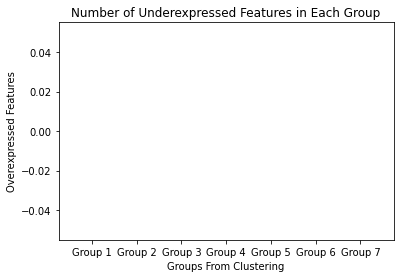

In [187]:
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']
significant_underexpressed_features_all = [0, 0, 0, 0, 0, 0, 0]



plt.bar(groups, significant_underexpressed_features_all)
plt.title('Number of Underexpressed Features in Each Group')
plt.xlabel('Groups From Clustering')
plt.ylabel('Overexpressed Features')
plt.show()

Below we make a bar chart for the final number of overexpressed metabolomic features in each group.

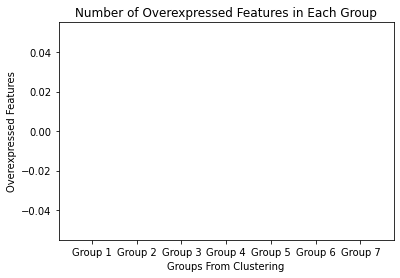

In [188]:
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']
significant_overexpressed_features_all = [0, 0, 0, 0, 0, 0, 0]



plt.bar(groups, significant_overexpressed_features_all)
plt.title('Number of Overexpressed Features in Each Group')
plt.xlabel('Groups From Clustering')
plt.ylabel('Overexpressed Features')
plt.show()

## Unique Cluster Overexpressed Features

Below we show the significant overexpressed features unique to every cluster. 

In [189]:
unique_overexpressed_features_c1 = np.setdiff1d(sig_metabolites_overexpressed_c1, (sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c6 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c1

array([], dtype=float64)

In [190]:
unique_overexpressed_features_c2 = np.setdiff1d(sig_metabolites_overexpressed_c2, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c6 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c2

array([], dtype=float64)

In [191]:
unique_overexpressed_features_c3 = np.setdiff1d(sig_metabolites_overexpressed_c3, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c6 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c3

array([], dtype=float64)

In [192]:
unique_overexpressed_features_c4 = np.setdiff1d(sig_metabolites_overexpressed_c4, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c6 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c4

array([], dtype=float64)

In [193]:
unique_overexpressed_features_c5 = np.setdiff1d(sig_metabolites_overexpressed_c5, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c6 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c5

array([], dtype=float64)

In [194]:
unique_overexpressed_features_c6 = np.setdiff1d(sig_metabolites_overexpressed_c6, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c7))
unique_overexpressed_features_c6

array([], dtype=float64)

In [195]:
unique_overexpressed_features_c7 = np.setdiff1d(sig_metabolites_overexpressed_c7, (sig_metabolites_overexpressed_c1 + sig_metabolites_overexpressed_c2 + sig_metabolites_overexpressed_c3 + sig_metabolites_overexpressed_c4 + sig_metabolites_overexpressed_c5 + sig_metabolites_overexpressed_c6))
unique_overexpressed_features_c7

array([], dtype=float64)

## Overexpression Results: NO OVEREXPRESSED FEATURES SPECIFIC TO ANY CLUSTERS

Below we make a bar chart for the final number of unique overexpressed metabolomic features in each group.

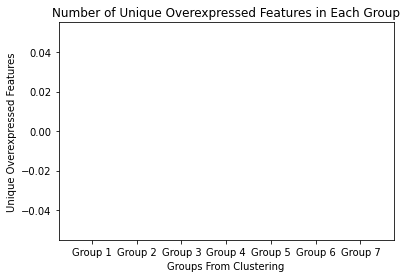

In [196]:
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']
significant_overexpressed_features = [0, 0, 0, 0, 0, 0, 0]



plt.bar(groups, significant_overexpressed_features)
plt.title('Number of Unique Overexpressed Features in Each Group')
plt.xlabel('Groups From Clustering')
plt.ylabel('Unique Overexpressed Features')
plt.show()

## Unique Cluster Underexpressed Features

Below we show the significant underexpressed features unique to every cluster. 

In [197]:
unique_underexpressed_features_c1 = np.setdiff1d(sig_metabolites_underexpressed_c1, (sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c6 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c1

array([], dtype=float64)

In [198]:
unique_underexpressed_features_c2 = np.setdiff1d(sig_metabolites_underexpressed_c2, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c6 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c2

array([], dtype=float64)

In [199]:
unique_underexpressed_features_c3 = np.setdiff1d(sig_metabolites_underexpressed_c3, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c6 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c3

array([], dtype=float64)

In [200]:
unique_underexpressed_features_c4 = np.setdiff1d(sig_metabolites_underexpressed_c4, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c6 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c4

array([], dtype=float64)

In [201]:
unique_underexpressed_features_c5 = np.setdiff1d(sig_metabolites_underexpressed_c5, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c6 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c5

array([], dtype=float64)

In [202]:
unique_underexpressed_features_c6 = np.setdiff1d(sig_metabolites_underexpressed_c6, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c7))
unique_underexpressed_features_c6

array([], dtype=float64)

In [203]:
unique_underexpressed_features_c7 = np.setdiff1d(sig_metabolites_underexpressed_c7, (sig_metabolites_underexpressed_c1 + sig_metabolites_underexpressed_c2 + sig_metabolites_underexpressed_c3 + sig_metabolites_underexpressed_c4 + sig_metabolites_underexpressed_c5 + sig_metabolites_underexpressed_c6))
unique_underexpressed_features_c7

array([], dtype=float64)

## Underexpression Results: NO UNDEREXPRESSED FEATURES SPECIFIC TO ANY CLUSTERS

Below we make a bar chart for the final number of unique overexpressed metabolomic features in each group.

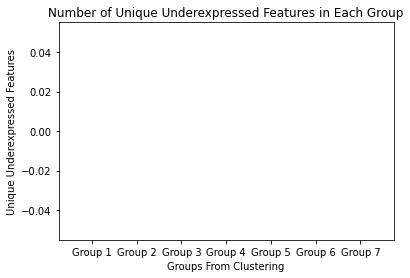

In [204]:
groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7']
significant_overexpressed_features = [0, 0, 0, 0, 0, 0, 0]



plt.bar(groups, significant_overexpressed_features)
plt.title('Number of Unique Underexpressed Features in Each Group')
plt.xlabel('Groups From Clustering')
plt.ylabel('Unique Underexpressed Features')
plt.show()

<a class="anchor" id="Survival_analysis"></a>
# Survival Analysis 

In [205]:
prediabetes_with_metabolomics_with_diagnosis_column = randomly_assigned_metabolomics_data.drop_duplicates()
prediabetes_with_metabolomics_with_diagnosis_column

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
663    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1563   0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
598    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
526    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
53     0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
1955   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
1493   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2135   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
629    0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2162   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  31-0.0  Age Covariate  \
663    0.155259   0.109124   0.110154   0.082361  ...       0              0   
1563   0.136503   0.247706   0.235767   0.226100  ...       1              1   
598    0.346956   0.235291   0.216451   0.235820  ...       1              1   
526    0.546772   0.124531   0.105653   0.144422  ...       0              1   
53     0.076562   0.235033   0.227720   0.189792  ...       1              1   
...         ...        ...        ...        ...  ...     ...            ...   
1955   0.248417   0.111243   0.114023   0.070756  ...       1              1   
1493   0.437497   0.031933   0.031295   0.062784  ...       1              1   
2135   0.444843   0.053610   0.038847   0.087918  ...       1              1   
629    0.494438   0.091690   0.073186   0.161521  ...       0              1   
2162   0.639617   0.133170   0.104596   0.169266  ...       0              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
663             1            0            0            0            0   
1563            1            0            0            0            0   
598             1            0            0            0            0   
526             1            0            0            0            0   
53              1            0            0            0            0   
...           ...          ...          ...          ...          ...   
1955            1            0            0            0            0   
1493            1            0            0            0            0   
2135            0            1            0            0            0   
629             1            0            0            0            0   
2162            0            1            0            0            0   

      Ethnicity_5  target  labels  
663             0       0       1  
1563            0       1       1  
598             0       0       1  
526             0       0       1  
53              0       0       1  
...           ...     ...     ...  
1955            0       0       7  
1493            0       0       7  
2135            0       1       7  
629             0       0       7  
2162            0       0       7  

[2339 rows x 179 columns]

Below we add the days to diagnoses column.

In [206]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days = prediabetes_with_metabolomics_with_diagnosis_column.merge(randomly_assigned_metabolomics_data_with_dates_sorted_final[['eid', 'days between diagnoses']], how = 'left')
prediabetes_with_metabolomics_with_diagnosis_column_with_days

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
2      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
2334   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
2335   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2336   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
2337   0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2338   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Age Covariate  \
0      0.155259   0.109124   0.110154   0.082361  ...              0   
1      0.136503   0.247706   0.235767   0.226100  ...              1   
2      0.346956   0.235291   0.216451   0.235820  ...              1   
3      0.546772   0.124531   0.105653   0.144422  ...              1   
4      0.076562   0.235033   0.227720   0.189792  ...              1   
...         ...        ...        ...        ...  ...            ...   
2334   0.248417   0.111243   0.114023   0.070756  ...              1   
2335   0.437497   0.031933   0.031295   0.062784  ...              1   
2336   0.444843   0.053610   0.038847   0.087918  ...              1   
2337   0.494438   0.091690   0.073186   0.161521  ...              1   
2338   0.639617   0.133170   0.104596   0.169266  ...              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
0               1            0            0            0            0   
1               1            0            0            0            0   
2               1            0            0            0            0   
3               1            0            0            0            0   
4               1            0            0            0            0   
...           ...          ...          ...          ...          ...   
2334            1            0            0            0            0   
2335            1            0            0            0            0   
2336            0            1            0            0            0   
2337            1            0            0            0            0   
2338            0            1            0            0            0   

      Ethnicity_5  target  labels  days between diagnoses  
0               0       0       1                     NaN  
1               0       1       1                  1896.0  
2               0       0       1                     NaN  
3               0       0       1                     NaN  
4               0       0       1                     NaN  
...           ...     ...     ...                     ...  
2334            0       0       7                     NaN  
2335            0       0       7                     NaN  
2336            0       1       7                  2964.0  
2337            0       0       7                     NaN  
2338            0       0       7                     NaN  

[2339 rows x 180 columns]

Since all other 

In [207]:
test = pd.isnull(prediabetes_with_metabolomics_with_diagnosis_column_with_days['days between diagnoses'])
cut_out = prediabetes_with_metabolomics_with_diagnosis_column_with_days[test][prediabetes_with_metabolomics_with_diagnosis_column_with_days['target'] == 1]
dftolist_cut_out = cut_out.eid.tolist()
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors = prediabetes_with_metabolomics_with_diagnosis_column_with_days[~prediabetes_with_metabolomics_with_diagnosis_column_with_days.eid.isin(dftolist_cut_out)]
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors

Boolean Series key will be reindexed to match DataFrame index.


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
2      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
2334   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
2335   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2336   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
2337   0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2338   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Age Covariate  \
0      0.155259   0.109124   0.110154   0.082361  ...              0   
1      0.136503   0.247706   0.235767   0.226100  ...              1   
2      0.346956   0.235291   0.216451   0.235820  ...              1   
3      0.546772   0.124531   0.105653   0.144422  ...              1   
4      0.076562   0.235033   0.227720   0.189792  ...              1   
...         ...        ...        ...        ...  ...            ...   
2334   0.248417   0.111243   0.114023   0.070756  ...              1   
2335   0.437497   0.031933   0.031295   0.062784  ...              1   
2336   0.444843   0.053610   0.038847   0.087918  ...              1   
2337   0.494438   0.091690   0.073186   0.161521  ...              1   
2338   0.639617   0.133170   0.104596   0.169266  ...              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
0               1            0            0            0            0   
1               1            0            0            0            0   
2               1            0            0            0            0   
3               1            0            0            0            0   
4               1            0            0            0            0   
...           ...          ...          ...          ...          ...   
2334            1            0            0            0            0   
2335            1            0            0            0            0   
2336            0            1            0            0            0   
2337            1            0            0            0            0   
2338            0            1            0            0            0   

      Ethnicity_5  target  labels  days between diagnoses  
0               0       0       1                     NaN  
1               0       1       1                  1896.0  
2               0       0       1                     NaN  
3               0       0       1                     NaN  
4               0       0       1                     NaN  
...           ...     ...     ...                     ...  
2334            0       0       7                     NaN  
2335            0       0       7                     NaN  
2336            0       1       7                  2964.0  
2337            0       0       7                     NaN  
2338            0       0       7                     NaN  

[2298 rows x 180 columns]

Next we fill the remaining nan values with the value 5110 = 365*14 years which should be large enough for all patients not progressing to make it to the end of the study.

In [208]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors.fillna(5110)
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
2      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
...         ...        ...        ...        ...        ...        ...   
2334   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
2335   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2336   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   
2337   0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2338   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Age Covariate  \
0      0.155259   0.109124   0.110154   0.082361  ...              0   
1      0.136503   0.247706   0.235767   0.226100  ...              1   
2      0.346956   0.235291   0.216451   0.235820  ...              1   
3      0.546772   0.124531   0.105653   0.144422  ...              1   
4      0.076562   0.235033   0.227720   0.189792  ...              1   
...         ...        ...        ...        ...  ...            ...   
2334   0.248417   0.111243   0.114023   0.070756  ...              1   
2335   0.437497   0.031933   0.031295   0.062784  ...              1   
2336   0.444843   0.053610   0.038847   0.087918  ...              1   
2337   0.494438   0.091690   0.073186   0.161521  ...              1   
2338   0.639617   0.133170   0.104596   0.169266  ...              1   

      Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  \
0               1            0            0            0            0   
1               1            0            0            0            0   
2               1            0            0            0            0   
3               1            0            0            0            0   
4               1            0            0            0            0   
...           ...          ...          ...          ...          ...   
2334            1            0            0            0            0   
2335            1            0            0            0            0   
2336            0            1            0            0            0   
2337            1            0            0            0            0   
2338            0            1            0            0            0   

      Ethnicity_5  target  labels  days between diagnoses  
0               0       0       1                  5110.0  
1               0       1       1                  1896.0  
2               0       0       1                  5110.0  
3               0       0       1                  5110.0  
4               0       0       1                  5110.0  
...           ...     ...     ...                     ...  
2334            0       0       7                  5110.0  
2335            0       0       7                  5110.0  
2336            0       1       7                  2964.0  
2337            0       0       7                  5110.0  
2338            0       0       7                  5110.0  

[2298 rows x 180 columns]

Below we make the kaplan meier curves for each cluster. We use this reference: https://plotly.com/python/v3/ipython-notebooks/survival-analysis-r-vs-python/

Text(0.5, 1.0, 'Time to T2D Kaplan Meier Curves')

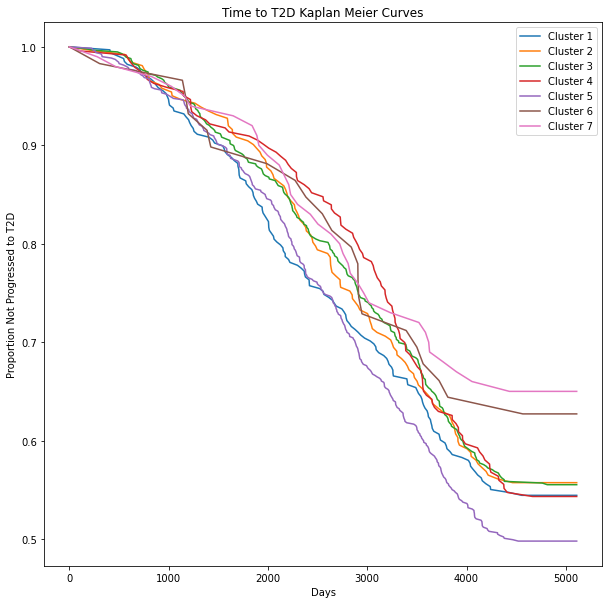

In [209]:
import kaplanmeier as km
import lifelines as ll
from lifelines import KaplanMeierFitter
import matplotlib.patches as mpatches

plt.figure(figsize = (10, 10))
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

T = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 1]['days between diagnoses']
C = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 1]['target']

T2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 2]['days between diagnoses']
C2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 2]['target']

T3 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 3]['days between diagnoses']
C3 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 3]['target']

T4 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 4]['days between diagnoses']
C4 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 4]['target']

T5 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 5]['days between diagnoses']
C5 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 5]['target']

T6 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 6]['days between diagnoses']
C6 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 6]['target']

T7 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 7]['days between diagnoses']
C7 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored.labels == 7]['target']

kmf.fit(T, event_observed=C, label='Cluster 1')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label='Cluster 2')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T3, event_observed=C3, label='Cluster 3')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T4, event_observed=C4, label='Cluster 4')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T5, event_observed=C5, label='Cluster 5')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T6, event_observed=C6, label='Cluster 6')
kmf.survival_function_.plot(ax=ax)
kmf.fit(T7, event_observed=C7, label='Cluster 7')
kmf.survival_function_.plot(ax=ax)

plt.ylabel('Proportion Not Progressed to T2D')
plt.xlabel('Days')
plt.title('Time to T2D Kaplan Meier Curves')



We estimate the cumulative hazard function using the Nelson-Aalen estimator. We see the shape is indicative of wear-out mortality.

Text(0.5, 1.0, 'Nelson-Aalen Estimate')

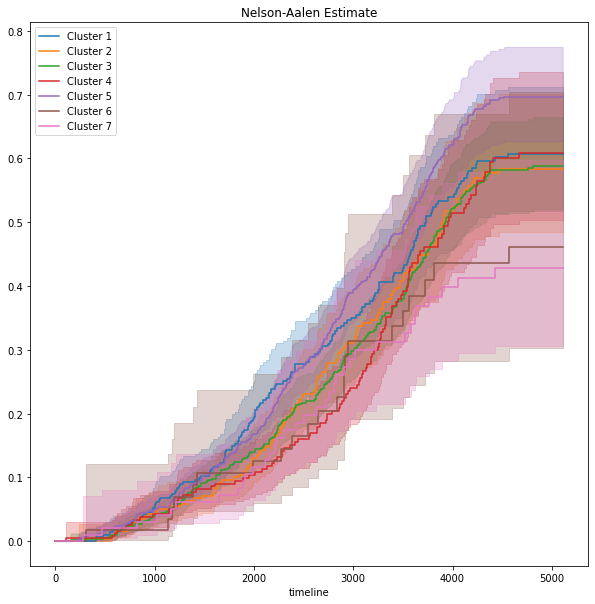

In [210]:
from lifelines import NelsonAalenFitter

plt.figure(figsize = (10, 10))
naf = NelsonAalenFitter()
naf.fit(T, event_observed=C)
naf2 = NelsonAalenFitter()
naf2.fit(T2, event_observed=C2)
naf3 = NelsonAalenFitter()
naf3.fit(T3, event_observed=C3)
naf4 = NelsonAalenFitter()
naf4.fit(T4, event_observed=C4)
naf5 = NelsonAalenFitter()
naf5.fit(T5, event_observed=C5)
naf6 = NelsonAalenFitter()
naf6.fit(T6, event_observed=C6)
naf7 = NelsonAalenFitter()
naf7.fit(T7, event_observed=C7)

naf.plot(label = 'Cluster 1')
naf2.plot(label = 'Cluster 2')
naf3.plot(label = 'Cluster 3')
naf4.plot(label = 'Cluster 4')
naf5.plot(label = 'Cluster 5')
naf6.plot(label = 'Cluster 6')
naf7.plot(label = 'Cluster 7')

plt.legend(loc = 'upper left')
plt.title('Nelson-Aalen Estimate')

Next we want to compare the groups statistically to see if they are different. We do this using the pairwise logrank test shown here: https://github.com/CamDavidsonPilon/lifelines/issues/185 We have to first label all censored patients.

In [211]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_only = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored['days between diagnoses'] == 5110]
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_only['status'] = 0
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_only


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
2      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
5      0.352925   0.313025   0.286458   0.245132   0.400657   0.409655   
...         ...        ...        ...        ...        ...        ...   
2333   0.456341   0.398289   0.418241   0.451735   0.380691   0.445563   
2334   0.185644   0.153725   0.129732   0.133173   0.235655   0.265206   
2335   0.340087   0.259968   0.198853   0.115844   0.380014   0.392151   
2337   0.333816   0.231862   0.176527   0.102465   0.328560   0.362040   
2338   0.555976   0.431391   0.405284   0.301354   0.478854   0.514903   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
0      0.155259   0.109124   0.110154   0.082361  ...            1   
2      0.346956   0.235291   0.216451   0.235820  ...            1   
3      0.546772   0.124531   0.105653   0.144422  ...            1   
4      0.076562   0.235033   0.227720   0.189792  ...            1   
5      0.333177   0.107695   0.113802   0.065727  ...            1   
...         ...        ...        ...        ...  ...          ...   
2333   0.421501   0.399248   0.338000   0.414124  ...            1   
2334   0.248417   0.111243   0.114023   0.070756  ...            1   
2335   0.437497   0.031933   0.031295   0.062784  ...            1   
2337   0.494438   0.091690   0.073186   0.161521  ...            1   
2338   0.639617   0.133170   0.104596   0.169266  ...            0   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
0               0            0            0            0            0       0   
2               0            0            0            0            0       0   
3               0            0            0            0            0       0   
4               0            0            0            0            0       0   
5               0            0            0            0            0       0   
...           ...          ...          ...          ...          ...     ...   
2333            0            0            0            0            0       0   
2334            0            0            0            0            0       0   
2335            0            0            0            0            0       0   
2337            0            0            0            0            0       0   
2338            1            0            0            0            0       0   

      labels  days between diagnoses  status  
0          1                  5110.0       0  
2          1                  5110.0       0  
3          1                  5110.0       0  
4          1                  5110.0       0  
5          1                  5110.0       0  
...      ...                     ...     ...  
2333       7                  5110.0       0  
2334       7                  5110.0       0  
2335       7                  5110.0       0  
2337       7                  5110.0       0  
2338       7                  5110.0       0  

[1243 rows x 181 columns]

Next we label all progressing patients.

In [212]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_progressors_only = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored['days between diagnoses'] != 5110]
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_progressors_only['status'] = 1
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_progressors_only


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
1      0.406932   0.447006   0.452815   0.465527   0.493416   0.501282   
7      0.295247   0.313666   0.301694   0.294911   0.384428   0.397610   
8      0.292238   0.218409   0.248629   0.304330   0.179714   0.276097   
10     0.468040   0.480301   0.435007   0.365434   0.570001   0.575181   
12     0.337809   0.344302   0.354433   0.364894   0.379885   0.405856   
...         ...        ...        ...        ...        ...        ...   
2325   0.277011   0.271803   0.227404   0.242273   0.347757   0.388268   
2327   0.375675   0.391979   0.391514   0.404047   0.428170   0.457579   
2329   0.313611   0.317830   0.345253   0.335393   0.374335   0.367274   
2332   0.359280   0.293503   0.253220   0.198296   0.374665   0.404083   
2336   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
1      0.136503   0.247706   0.235767   0.226100  ...            1   
7      0.153155   0.193680   0.190477   0.146765  ...            1   
8      0.402376   0.462060   0.397420   0.391100  ...            1   
10     0.235029   0.220739   0.212588   0.184738  ...            0   
12     0.201547   0.283201   0.265562   0.243953  ...            1   
...         ...        ...        ...        ...  ...          ...   
2325   0.210383   0.208471   0.211222   0.143144  ...            1   
2327   0.189211   0.345793   0.343123   0.226061  ...            1   
2329   0.198621   0.196480   0.195279   0.113537  ...            1   
2332   0.405810   0.110294   0.100003   0.110671  ...            0   
2336   0.444843   0.053610   0.038847   0.087918  ...            0   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
1               0            0            0            0            0       1   
7               0            0            0            0            0       1   
8               0            0            0            0            0       1   
10              1            0            0            0            0       1   
12              0            0            0            0            0       1   
...           ...          ...          ...          ...          ...     ...   
2325            0            0            0            0            0       1   
2327            0            0            0            0            0       1   
2329            0            0            0            0            0       1   
2332            0            0            0            1            0       1   
2336            1            0            0            0            0       1   

      labels  days between diagnoses  status  
1          1                  1896.0       1  
7          1                  1592.0       1  
8          1                  1941.0       1  
10         1                  3086.0       1  
12         1                   819.0       1  
...      ...                     ...     ...  
2325       7                  2904.0       1  
2327       7                  2807.0       1  
2329       7                  3520.0       1  
2332       7                  2209.0       1  
2336       7                  2964.0       1  

[1055 rows x 181 columns]

Below we combine these groups.

In [213]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_only.append(prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_progressors_only)
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
2      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
5      0.352925   0.313025   0.286458   0.245132   0.400657   0.409655   
...         ...        ...        ...        ...        ...        ...   
2325   0.277011   0.271803   0.227404   0.242273   0.347757   0.388268   
2327   0.375675   0.391979   0.391514   0.404047   0.428170   0.457579   
2329   0.313611   0.317830   0.345253   0.335393   0.374335   0.367274   
2332   0.359280   0.293503   0.253220   0.198296   0.374665   0.404083   
2336   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  \
0      0.155259   0.109124   0.110154   0.082361  ...            1   
2      0.346956   0.235291   0.216451   0.235820  ...            1   
3      0.546772   0.124531   0.105653   0.144422  ...            1   
4      0.076562   0.235033   0.227720   0.189792  ...            1   
5      0.333177   0.107695   0.113802   0.065727  ...            1   
...         ...        ...        ...        ...  ...          ...   
2325   0.210383   0.208471   0.211222   0.143144  ...            1   
2327   0.189211   0.345793   0.343123   0.226061  ...            1   
2329   0.198621   0.196480   0.195279   0.113537  ...            1   
2332   0.405810   0.110294   0.100003   0.110671  ...            0   
2336   0.444843   0.053610   0.038847   0.087918  ...            0   

      Ethnicity_1  Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  \
0               0            0            0            0            0       0   
2               0            0            0            0            0       0   
3               0            0            0            0            0       0   
4               0            0            0            0            0       0   
5               0            0            0            0            0       0   
...           ...          ...          ...          ...          ...     ...   
2325            0            0            0            0            0       1   
2327            0            0            0            0            0       1   
2329            0            0            0            0            0       1   
2332            0            0            0            1            0       1   
2336            1            0            0            0            0       1   

      labels  days between diagnoses  status  
0          1                  5110.0       0  
2          1                  5110.0       0  
3          1                  5110.0       0  
4          1                  5110.0       0  
5          1                  5110.0       0  
...      ...                     ...     ...  
2325       7                  2904.0       1  
2327       7                  2807.0       1  
2329       7                  3520.0       1  
2332       7                  2209.0       1  
2336       7                  2964.0       1  

[2298 rows x 181 columns]

Now we can run our statistical testing.

In [214]:
from lifelines.statistics import pairwise_logrank_test

pairwise_logrank_test(prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status['days between diagnoses'], prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status['labels'], event_observed = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status['status'], alpha=0.95, bonferroni=True)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
        bonferroni = True
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
1 2            0.30 0.59      0.77
  3            0.41 0.52      0.93
  4            0.22 0.64      0.64
  5            1.45 0.23      2.13
  6            1.40 0.24      2.08
  7            3.40 0.07      3.93
2 3            0.00 1.00      0.00
  4            0.00 0.99      0.01
  5            2.98 0.08      3.57
  6            0.81 0.37      1.45
  7            2.12 0.15      2.78
3 4            0.00 0.96      0.06
  5            5.15 0.02      5.42
  6            0.89 0.35      1.53
  7            2.49 0.11      3.12
4 5            2.82 0.09      3.42
  6            0.87 0.35      1.51
  7            2.24 0.13      2.90
5 6            3.21 0.07      3.78
  7            6.95 0.01      6.90
6 7            0.06 0.80      0.31

Below we merge the death date column to the dataframe. We need to factor these into the survival analysis. 

In [215]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status.merge(prediabetes_with_all[['eid', '40000-0.0']])
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0      0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
1      0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
2      0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
3      0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
4      0.352925   0.313025   0.286458   0.245132   0.400657   0.409655   
...         ...        ...        ...        ...        ...        ...   
2293   0.277011   0.271803   0.227404   0.242273   0.347757   0.388268   
2294   0.375675   0.391979   0.391514   0.404047   0.428170   0.457579   
2295   0.313611   0.317830   0.345253   0.335393   0.374335   0.367274   
2296   0.359280   0.293503   0.253220   0.198296   0.374665   0.404083   
2297   0.327672   0.243120   0.223009   0.157354   0.324750   0.341638   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_1  \
0      0.155259   0.109124   0.110154   0.082361  ...            0   
1      0.346956   0.235291   0.216451   0.235820  ...            0   
2      0.546772   0.124531   0.105653   0.144422  ...            0   
3      0.076562   0.235033   0.227720   0.189792  ...            0   
4      0.333177   0.107695   0.113802   0.065727  ...            0   
...         ...        ...        ...        ...  ...          ...   
2293   0.210383   0.208471   0.211222   0.143144  ...            0   
2294   0.189211   0.345793   0.343123   0.226061  ...            0   
2295   0.198621   0.196480   0.195279   0.113537  ...            0   
2296   0.405810   0.110294   0.100003   0.110671  ...            0   
2297   0.444843   0.053610   0.038847   0.087918  ...            1   

      Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  labels  \
0               0            0            0            0       0       1   
1               0            0            0            0       0       1   
2               0            0            0            0       0       1   
3               0            0            0            0       0       1   
4               0            0            0            0       0       1   
...           ...          ...          ...          ...     ...     ...   
2293            0            0            0            0       1       7   
2294            0            0            0            0       1       7   
2295            0            0            0            0       1       7   
2296            0            0            1            0       1       7   
2297            0            0            0            0       1       7   

      days between diagnoses  status  40000-0.0  
0                     5110.0       0        NaN  
1                     5110.0       0        NaN  
2                     5110.0       0        NaN  
3                     5110.0       0        NaN  
4                     5110.0       0        NaN  
...                      ...     ...        ...  
2293                  2904.0       1        NaN  
2294                  2807.0       1        NaN  
2295                  3520.0       1        NaN  
2296                  2209.0       1        NaN  
2297                  2964.0       1        NaN  

[2298 rows x 182 columns]

Below we look at patients who do not progress to T2D who die. 

In [216]:
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_censored = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death['40000-0.0'].notnull()
censored_with_death = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_censored][prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death['status'] == 0]
censored_with_death

Boolean Series key will be reindexed to match DataFrame index.


23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
183    0.201969   0.209041   0.223041   0.227729   0.268131   0.281753   
240    0.271527   0.237035   0.220144   0.241341   0.285331   0.333449   
629    0.482860   0.469795   0.482375   0.526827   0.486144   0.515775   
827    0.327011   0.246804   0.267251   0.240404   0.268809   0.309923   
946    0.146822   0.153853   0.148171   0.183175   0.216513   0.249498   
1187   0.187205   0.180983   0.172291   0.230254   0.231076   0.276322   

      23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_1  \
183    0.148761   0.109382   0.086813   0.136193  ...            1   
240    0.287798   0.205819   0.187574   0.177031  ...            0   
629    0.309357   0.351153   0.322676   0.287619  ...            0   
827    0.432759   0.152363   0.111977   0.208924  ...            1   
946    0.128044   0.147132   0.150431   0.083387  ...            0   
1187   0.179257   0.191432   0.185406   0.144577  ...            0   

      Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  labels  \
183             0            0            0            0       0       1   
240             0            0            0            0       0       2   
629             0            0            0            0       0       3   
827             0            0            0            0       0       5   
946             0            0            0            0       0       5   
1187            0            0            0            0       0       7   

      days between diagnoses  status   40000-0.0  
183                   5110.0       0  2013-01-28  
240                   5110.0       0  2015-06-10  
629                   5110.0       0  2017-10-29  
827                   5110.0       0  2017-04-01  
946                   5110.0       0  2015-01-08  
1187                  5110.0       0  2014-08-26  

[6 rows x 182 columns]

Below we merge the date of attending the assessment center to these patients.

In [217]:
censored_with_death_with_date = censored_with_death.merge(prediabetes_with_all[['eid', '53-0.0']])
censored_with_death_with_date

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0   0.201969   0.209041   0.223041   0.227729   0.268131   0.281753   
1   0.271527   0.237035   0.220144   0.241341   0.285331   0.333449   
2   0.482860   0.469795   0.482375   0.526827   0.486144   0.515775   
3   0.327011   0.246804   0.267251   0.240404   0.268809   0.309923   
4   0.146822   0.153853   0.148171   0.183175   0.216513   0.249498   
5   0.187205   0.180983   0.172291   0.230254   0.231076   0.276322   

   23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_2  Ethnicity_3  \
0   0.148761   0.109382   0.086813   0.136193  ...            0            0   
1   0.287798   0.205819   0.187574   0.177031  ...            0            0   
2   0.309357   0.351153   0.322676   0.287619  ...            0            0   
3   0.432759   0.152363   0.111977   0.208924  ...            0            0   
4   0.128044   0.147132   0.150431   0.083387  ...            0            0   
5   0.179257   0.191432   0.185406   0.144577  ...            0            0   

   Ethnicity_4  Ethnicity_5  target  labels  days between diagnoses  status  \
0            0            0       0       1                  5110.0       0   
1            0            0       0       2                  5110.0       0   
2            0            0       0       3                  5110.0       0   
3            0            0       0       5                  5110.0       0   
4            0            0       0       5                  5110.0       0   
5            0            0       0       7                  5110.0       0   

    40000-0.0      53-0.0  
0  2013-01-28  2009-09-07  
1  2015-06-10  2009-10-16  
2  2017-10-29  2009-04-24  
3  2017-04-01  2008-11-13  
4  2015-01-08  2009-06-02  
5  2014-08-26  2008-02-07  

[6 rows x 183 columns]

Below we change the date columns to date time format.

In [218]:
censored_with_death_with_date['53-0.0'] = pd.to_datetime(censored_with_death_with_date['53-0.0'])
censored_with_death_with_date['40000-0.0'] = pd.to_datetime(censored_with_death_with_date['40000-0.0'])
censored_with_death_with_date

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0   0.201969   0.209041   0.223041   0.227729   0.268131   0.281753   
1   0.271527   0.237035   0.220144   0.241341   0.285331   0.333449   
2   0.482860   0.469795   0.482375   0.526827   0.486144   0.515775   
3   0.327011   0.246804   0.267251   0.240404   0.268809   0.309923   
4   0.146822   0.153853   0.148171   0.183175   0.216513   0.249498   
5   0.187205   0.180983   0.172291   0.230254   0.231076   0.276322   

   23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_2  Ethnicity_3  \
0   0.148761   0.109382   0.086813   0.136193  ...            0            0   
1   0.287798   0.205819   0.187574   0.177031  ...            0            0   
2   0.309357   0.351153   0.322676   0.287619  ...            0            0   
3   0.432759   0.152363   0.111977   0.208924  ...            0            0   
4   0.128044   0.147132   0.150431   0.083387  ...            0            0   
5   0.179257   0.191432   0.185406   0.144577  ...            0            0   

   Ethnicity_4  Ethnicity_5  target  labels  days between diagnoses  status  \
0            0            0       0       1                  5110.0       0   
1            0            0       0       2                  5110.0       0   
2            0            0       0       3                  5110.0       0   
3            0            0       0       5                  5110.0       0   
4            0            0       0       5                  5110.0       0   
5            0            0       0       7                  5110.0       0   

   40000-0.0     53-0.0  
0 2013-01-28 2009-09-07  
1 2015-06-10 2009-10-16  
2 2017-10-29 2009-04-24  
3 2017-04-01 2008-11-13  
4 2015-01-08 2009-06-02  
5 2014-08-26 2008-02-07  

[6 rows x 183 columns]

Below we fill in the days between diagnoses with the time until death for each patient.

In [219]:
censored_with_death_with_date['days between diagnoses'] = (censored_with_death_with_date['40000-0.0'] - censored_with_death_with_date['53-0.0']).dt.days
censored_with_death_with_date

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0   0.201969   0.209041   0.223041   0.227729   0.268131   0.281753   
1   0.271527   0.237035   0.220144   0.241341   0.285331   0.333449   
2   0.482860   0.469795   0.482375   0.526827   0.486144   0.515775   
3   0.327011   0.246804   0.267251   0.240404   0.268809   0.309923   
4   0.146822   0.153853   0.148171   0.183175   0.216513   0.249498   
5   0.187205   0.180983   0.172291   0.230254   0.231076   0.276322   

   23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_2  Ethnicity_3  \
0   0.148761   0.109382   0.086813   0.136193  ...            0            0   
1   0.287798   0.205819   0.187574   0.177031  ...            0            0   
2   0.309357   0.351153   0.322676   0.287619  ...            0            0   
3   0.432759   0.152363   0.111977   0.208924  ...            0            0   
4   0.128044   0.147132   0.150431   0.083387  ...            0            0   
5   0.179257   0.191432   0.185406   0.144577  ...            0            0   

   Ethnicity_4  Ethnicity_5  target  labels  days between diagnoses  status  \
0            0            0       0       1                    1239       0   
1            0            0       0       2                    2063       0   
2            0            0       0       3                    3110       0   
3            0            0       0       5                    3061       0   
4            0            0       0       5                    2046       0   
5            0            0       0       7                    2392       0   

   40000-0.0     53-0.0  
0 2013-01-28 2009-09-07  
1 2015-06-10 2009-10-16  
2 2017-10-29 2009-04-24  
3 2017-04-01 2008-11-13  
4 2015-01-08 2009-06-02  
5 2014-08-26 2008-02-07  

[6 rows x 183 columns]

Below we add these columns back in and drop those from the current dataframe with the censored time between diagnoses.

In [220]:
censored_with_death_with_date_no_extra_cols = censored_with_death_with_date.drop(columns = ['40000-0.0', '53-0.0'])
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status.append(censored_with_death_with_date_no_extra_cols)
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death.drop_duplicates(subset = 'eid', keep = 'last')
prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final

23400-0.0  23401-0.0  23402-0.0  23403-0.0  23404-0.0  23405-0.0  \
0    0.214876   0.221340   0.208684   0.210474   0.303008   0.315776   
2    0.609294   0.599948   0.578542   0.510679   0.662742   0.661377   
3    0.632846   0.553153   0.555851   0.377394   0.631529   0.598735   
4    0.150183   0.176659   0.177695   0.258124   0.221221   0.264052   
5    0.352925   0.313025   0.286458   0.245132   0.400657   0.409655   
..        ...        ...        ...        ...        ...        ...   
1    0.271527   0.237035   0.220144   0.241341   0.285331   0.333449   
2    0.482860   0.469795   0.482375   0.526827   0.486144   0.515775   
3    0.327011   0.246804   0.267251   0.240404   0.268809   0.309923   
4    0.146822   0.153853   0.148171   0.183175   0.216513   0.249498   
5    0.187205   0.180983   0.172291   0.230254   0.231076   0.276322   

    23406-0.0  23407-0.0  23408-0.0  23409-0.0  ...  Ethnicity_0  Ethnicity_1  \
0    0.155259   0.109124   0.110154   0.082361  ...            1            0   
2    0.346956   0.235291   0.216451   0.235820  ...            1            0   
3    0.546772   0.124531   0.105653   0.144422  ...            1            0   
4    0.076562   0.235033   0.227720   0.189792  ...            1            0   
5    0.333177   0.107695   0.113802   0.065727  ...            1            0   
..        ...        ...        ...        ...  ...          ...          ...   
1    0.287798   0.205819   0.187574   0.177031  ...            1            0   
2    0.309357   0.351153   0.322676   0.287619  ...            1            0   
3    0.432759   0.152363   0.111977   0.208924  ...            0            1   
4    0.128044   0.147132   0.150431   0.083387  ...            1            0   
5    0.179257   0.191432   0.185406   0.144577  ...            1            0   

    Ethnicity_2  Ethnicity_3  Ethnicity_4  Ethnicity_5  target  labels  \
0             0            0            0            0       0       1   
2             0            0            0            0       0       1   
3             0            0            0            0       0       1   
4             0            0            0            0       0       1   
5             0            0            0            0       0       1   
..          ...          ...          ...          ...     ...     ...   
1             0            0            0            0       0       2   
2             0            0            0            0       0       3   
3             0            0            0            0       0       5   
4             0            0            0            0       0       5   
5             0            0            0            0       0       7   

    days between diagnoses  status  
0                   5110.0       0  
2                   5110.0       0  
3                   5110.0       0  
4                   5110.0       0  
5                   5110.0       0  
..                     ...     ...  
1                   2063.0       0  
2                   3110.0       0  
3                   3061.0       0  
4                   2046.0       0  
5                   2392.0       0  

[2298 rows x 181 columns]

Below we make the kaplan meier curves with our new data.

([<matplotlib.axis.YTick at 0x1ab610c1a08>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

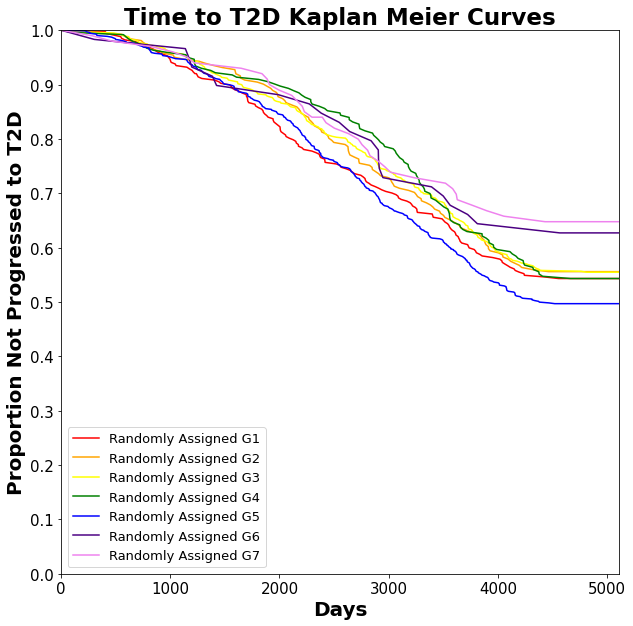

In [221]:
plt.figure(figsize = (10, 10))
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

T = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 1]['days between diagnoses']
C = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 1]['target']

T2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 2]['days between diagnoses']
C2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 2]['target']

T3 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 3]['days between diagnoses']
C3 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 3]['target']

T4 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 4]['days between diagnoses']
C4 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 4]['target']

T5 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 5]['days between diagnoses']
C5 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 5]['target']

T6 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 6]['days between diagnoses']
C6 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 6]['target']

T7 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 7]['days between diagnoses']
C7 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final.labels == 7]['target']

kmf.fit(T, event_observed=C, label='Randomly Assigned G1')
kmf.survival_function_.plot(ax=ax, color = 'Red')
kmf.fit(T2, event_observed=C2, label='Randomly Assigned G2')
kmf.survival_function_.plot(ax=ax, color = 'Orange')
kmf.fit(T3, event_observed=C3, label='Randomly Assigned G3')
kmf.survival_function_.plot(ax=ax, color = 'Yellow')
kmf.fit(T4, event_observed=C4, label='Randomly Assigned G4')
kmf.survival_function_.plot(ax=ax, color = 'Green')
kmf.fit(T5, event_observed=C5, label='Randomly Assigned G5')
kmf.survival_function_.plot(ax=ax, color = 'Blue')
kmf.fit(T6, event_observed=C6, label='Randomly Assigned G6')
kmf.survival_function_.plot(ax=ax, color = 'Indigo')
kmf.fit(T7, event_observed=C7, label='Randomly Assigned G7')
kmf.survival_function_.plot(ax=ax, color = 'Violet')

plt.ylabel('Proportion Not Progressed to T2D', fontsize = 20, fontweight = 'bold')
plt.xlabel('Days', fontsize = 20, fontweight = 'bold')
plt.title('Time to T2D Kaplan Meier Curves', fontsize = 23, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.ylim(0, 1)
plt.margins(0)
plt.yticks(np.arange(0, 1 + 0.1, 0.1))

We estimate the cumulative hazard function using the Nelson-Aalen estimator. We see the shape is indicative of wear-out mortality.

Text(0.5, 1.0, 'Nelson-Aalen Estimate')

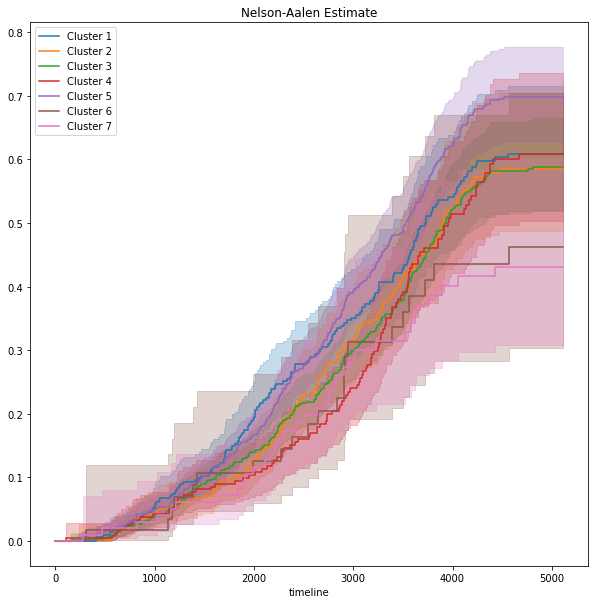

In [222]:
from lifelines import NelsonAalenFitter

plt.figure(figsize = (10, 10))
naf = NelsonAalenFitter()
naf.fit(T, event_observed=C)
naf2 = NelsonAalenFitter()
naf2.fit(T2, event_observed=C2)
naf3 = NelsonAalenFitter()
naf3.fit(T3, event_observed=C3)
naf4 = NelsonAalenFitter()
naf4.fit(T4, event_observed=C4)
naf5 = NelsonAalenFitter()
naf5.fit(T5, event_observed=C5)
naf6 = NelsonAalenFitter()
naf6.fit(T6, event_observed=C6)
naf7 = NelsonAalenFitter()
naf7.fit(T7, event_observed=C7)

naf.plot(label = 'Cluster 1')
naf2.plot(label = 'Cluster 2')
naf3.plot(label = 'Cluster 3')
naf4.plot(label = 'Cluster 4')
naf5.plot(label = 'Cluster 5')
naf6.plot(label = 'Cluster 6')
naf7.plot(label = 'Cluster 7')

plt.legend(loc = 'upper left')
plt.title('Nelson-Aalen Estimate')

Now we can run our statistical testing.

In [223]:
from lifelines.statistics import pairwise_logrank_test

pairwise_logrank_test(prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['days between diagnoses'], prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels'], event_observed = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['status'], alpha=0.95, bonferroni=True)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
        bonferroni = True
         test_name = logrank_test

---
     test_statistic    p  -log2(p)
1 2            0.30 0.59      0.77
  3            0.44 0.51      0.98
  4            0.25 0.62      0.69
  5            1.42 0.23      2.10
  6            1.44 0.23      2.11
  7            3.33 0.07      3.87
2 3            0.00 0.98      0.03
  4            0.00 0.98      0.02
  5            2.93 0.09      3.53
  6            0.84 0.36      1.48
  7            2.06 0.15      2.72
3 4            0.00 0.97      0.05
  5            5.23 0.02      5.49
  6            0.90 0.34      1.54
  7            2.36 0.12      3.01
4 5            2.90 0.09      3.49
  6            0.87 0.35      1.51
  7            2.10 0.15      2.76
5 6            3.25 0.07      3.81
  7            6.79 0.01      6.77
6 7            0.05 0.83      0.28

# For all analyses below, we have to multiple the p-values by 7 because the test does not account for Bonferroni correction. - https://medium.com/analytics-vidhya/log-rank-test-kaplan-meier-survival-curve-python-code-3fc78da644d5

Olivier said it would be better to condense these results in a one-vs-all fashion, just as we do for the statistics below comparing one cluster vs the rest of the data. Below we show the results for cluster 1 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.04 0.84      0.25

Text(0, 0.5, 'Proportion Not Progressed to T2D')

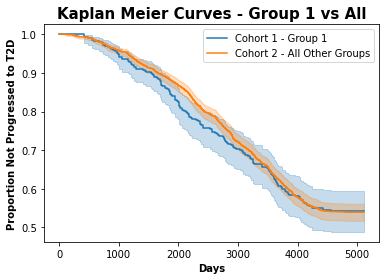

In [224]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==1]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=1]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 1").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 1 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

Below we show the results for cluster 2 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.34 0.56      0.83

Text(0, 0.5, 'Proportion Not Progressed to T2D')

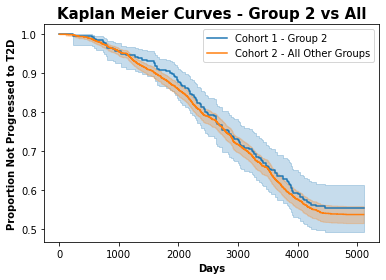

In [225]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==2]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=2]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 2").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 2 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

Below we show the results for cluster 3 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.01 0.31      1.67

Text(0, 0.5, 'Proportion Not Progressed to T2D')

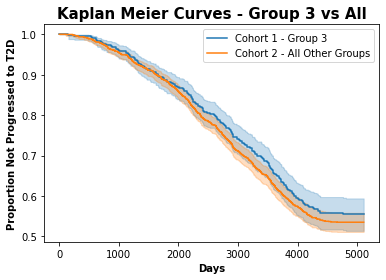

In [226]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==3]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=3]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 3").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 3 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

Below we show the results for cluster 4 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.32 0.57      0.80

Text(0, 0.5, 'Proportion Not Progressed to T2D')

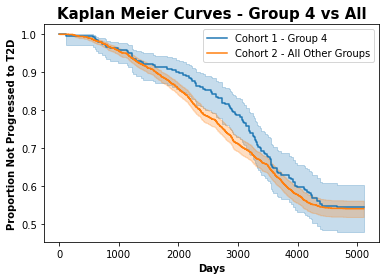

In [227]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==4]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=4]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 4").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 4 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')


Below we show the results for cluster 5 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.85 <0.005      8.42

Text(0, 0.5, 'Proportion Not Progressed to T2D')

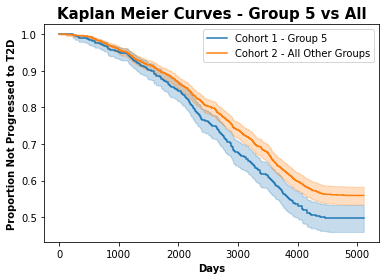

In [228]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==5]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=5]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 5").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 5 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

Below we show the results for cluster 6 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.58 0.21      2.26

Text(0, 0.5, 'Proportion Not Progressed to T2D')

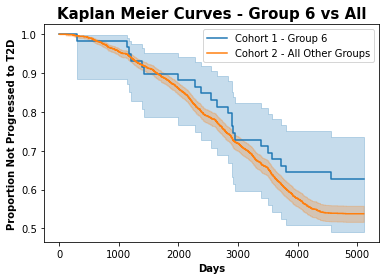

In [229]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==6]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=6]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 6").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 6 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

Below we show the results for cluster 7 vs all other clusters.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.99 0.05      4.45

Text(0, 0.5, 'Proportion Not Progressed to T2D')

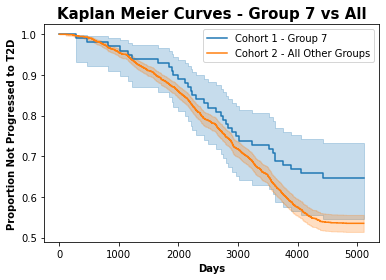

In [230]:
#KM curve
from lifelines import KaplanMeierFitter
group1 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']==7]
group2 = prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final[prediabetes_with_metabolomics_with_diagnosis_column_with_days_without_some_progressors_censored_with_status_with_death_final['labels']!=7]
T = group1['days between diagnoses']
E = group1['status']
T1 = group2['days between diagnoses']
E1 = group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label = "Cohort 1 - Group 7").plot(ax=ax)
ax = kmf.fit(T1, E1, label = "Cohort 2 - All Other Groups").plot(ax = ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T, T1, event_observed_A=E, event_observed_B=E1)
results.print_summary()

plt.title('Kaplan Meier Curves - Group 7 vs All', fontsize = 15, fontweight = 'bold')
plt.xlabel('Days', fontsize = 10, fontweight = 'bold')
plt.ylabel('Proportion Not Progressed to T2D', fontsize = 10, fontweight = 'bold')

# Applying Bonferroni correction (multiplying each p-value by the number of tests = 7) we get the following results:

1. Cluster 1 vs all: p-value = 1
2. Cluster 2 vs all: p-value = 1
3. Cluster 3 vs all: p-value = 1
4. Cluster 4 vs all: p-value = 1
5. Cluster 5 vs all: p-value = < 0.005
6. Cluster 6 vs all: p-value = 1
7. Cluster 7 vs all: p-value = 0.35

<a class="anchor" id="Involving_cb_features"></a>

# Adding Clinical-Biological Features

Below we do the same thing as above with metabolites but using the clinical-biological features to see if there are cluster-specific features that have significantly different expression than the other clusters.

We will also import the patients from a previous model so we can cut out the patients we know to have prediabetes and not progress to diabetes.

In [231]:
prediabetes_from_model_21 = pd.read_csv('prediabetic_all_possible_to_classify_WITH_PREDIABETIC_ICD_CODES_ALSO_INCORPORATING_DATES_BEFORE_ASSESSMENT_CENTER_final')
prediabetes_from_model_21 = prediabetes_from_model_21.drop(columns = 'Unnamed: 0')
prediabetes_from_model_21

eid  target
0     4754980       0
1     3990434       0
2     4341307       0
3     2189918       0
4     1384041       0
...       ...     ...
5426  3939961       1
5427  2215660       1
5428  5612713       1
5429  6022397       1
5430  5011216       1

[5431 rows x 2 columns]

Below we make a list of these patients.

In [232]:
dfToList_prediabetes_not_for_feature_selection = prediabetes_from_model_21['eid'].tolist()
dfToList_prediabetes_not_for_feature_selection

[4754980,
 3990434,
 4341307,
 2189918,
 1384041,
 2668919,
 4731399,
 5176915,
 2546801,
 4074087,
 5610428,
 4291108,
 1087841,
 2400159,
 2651683,
 3021843,
 3741116,
 2300870,
 5300315,
 3131032,
 5054628,
 3848034,
 3814179,
 4041516,
 3244213,
 2153925,
 5275213,
 4247282,
 3005969,
 5415675,
 2666156,
 1157575,
 3787794,
 1721346,
 4125910,
 4772707,
 2629558,
 4329061,
 3593711,
 3706865,
 3468606,
 1526262,
 2315761,
 1532705,
 3762664,
 1696778,
 2238033,
 2412934,
 2802052,
 3586593,
 2883116,
 1245115,
 3993670,
 3857759,
 2994186,
 4054334,
 1656085,
 5985181,
 1099911,
 1414086,
 5495249,
 2771587,
 3615764,
 5176828,
 4968900,
 3132679,
 2319445,
 3274237,
 2935906,
 1443994,
 1931859,
 5665291,
 3387357,
 3133140,
 4065319,
 5083386,
 2979692,
 2262386,
 2024396,
 2455237,
 3631850,
 2839824,
 5273096,
 3230080,
 4893226,
 3554949,
 3245699,
 2997509,
 4757559,
 5817242,
 3422921,
 2337129,
 1204343,
 2857922,
 3406342,
 5040694,
 1642615,
 5402929,
 3000943,
 2126187,


Below we cut these patients from the dataframe with all the icd codes.

In [233]:
prediabetes_for_unknowns_only = prediabetes_containing_unknowns[~prediabetes_containing_unknowns.eid.isin(dfToList_prediabetes_not_for_feature_selection)]
prediabetes_for_unknowns_only

eid  ins_index    epistart diag_icd10
0       1000072         12  28/08/2015       Z885
1       1000072         12  28/08/2015       Z867
2       1000072         12  28/08/2015       Z864
3       1000072         12  28/08/2015       Z922
4       1000072         12  28/08/2015       Z966
...         ...        ...         ...        ...
727673  6024501          2  01/06/1999       I251
727674  6024501          2  01/06/1999       I209
727675  6024501          0  29/12/2000       W790
727676  6024501          0  29/12/2000       T181
727677  6024501          0  29/12/2000       W790

[406727 rows x 4 columns]

Next, we change the epistart column to date time format.

In [234]:
prediabetes_for_unknowns_only['epistart'] = pd.to_datetime(prediabetes_for_unknowns_only['epistart'])
prediabetes_for_unknowns_only


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


eid  ins_index   epistart diag_icd10
0       1000072         12 2015-08-28       Z885
1       1000072         12 2015-08-28       Z867
2       1000072         12 2015-08-28       Z864
3       1000072         12 2015-08-28       Z922
4       1000072         12 2015-08-28       Z966
...         ...        ...        ...        ...
727673  6024501          2 1999-01-06       I251
727674  6024501          2 1999-01-06       I209
727675  6024501          0 2000-12-29       W790
727676  6024501          0 2000-12-29       T181
727677  6024501          0 2000-12-29       W790

[406727 rows x 4 columns]

Below we filter for all patients who had an epistart date later than 2018. This is about 10 years after most patients had their data taken at the assessment center. Therefore, if they are diagnosed with a disease from 2018 onwards, this means that they would most likely have been diagnosed with diabetes if they developed it. Therefore, we will keep these patients and classify them as those who do not progress to diabetes. First, we have to set the index as epistart.

In [235]:
prediabetes_for_unknowns_only_index_epistart = prediabetes_for_unknowns_only.set_index(['epistart'])
prediabetes_for_unknowns_only_index_epistart

eid  ins_index diag_icd10
epistart                                 
2015-08-28  1000072         12       Z885
2015-08-28  1000072         12       Z867
2015-08-28  1000072         12       Z864
2015-08-28  1000072         12       Z922
2015-08-28  1000072         12       Z966
...             ...        ...        ...
1999-01-06  6024501          2       I251
1999-01-06  6024501          2       I209
2000-12-29  6024501          0       W790
2000-12-29  6024501          0       T181
2000-12-29  6024501          0       W790

[406727 rows x 3 columns]

Next, we can filter for all epistart dates from 2018 onwards.

In [236]:
prediabetes_for_unknowns_only_index_epistart_later_than_2018 = prediabetes_for_unknowns_only_index_epistart.loc['2018' : '2021']
prediabetes_for_unknowns_only_index_epistart_later_than_2018

eid  ins_index diag_icd10
epistart                                 
2019-03-06  1000330         28        I10
2019-03-06  1000330         28       D123
2019-03-06  1000330         28       M139
2019-03-06  1000330         28       M858
2019-03-06  1000330         28        N26
...             ...        ...        ...
2020-03-20  6024501          5       Z951
2020-03-20  6024501          6       E780
2020-03-20  6024501          6        C61
2020-03-20  6024501          6        I10
2020-03-20  6024501          6       Z951

[109787 rows x 3 columns]

Below we make a list of these patients.

In [237]:
dfToList_prediabetes_for_unknowns_only_index_epistart_later_than_2018 = prediabetes_for_unknowns_only_index_epistart_later_than_2018['eid'].tolist()
dfToList_prediabetes_for_unknowns_only_index_epistart_later_than_2018

[1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000330,
 1000789,
 1000789,
 1000789,
 1005310,
 1005310,
 1005310,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006688,
 1006718,


Below we show that there are an additional 4513 patients we can use if our assumption is correct that we can classify as not progressing to diabetes.

In [238]:
prediabetes_for_unknowns_only_index_epistart_later_than_2018_patients = prediabetes_for_unknowns_only_index_epistart_later_than_2018.drop_duplicates(subset = 'eid')
prediabetes_for_unknowns_only_index_epistart_later_than_2018_patients

eid  ins_index diag_icd10
epistart                                 
2019-03-06  1000330         28        I10
2018-09-04  1000789          1       D509
2019-09-23  1005310          3       M179
2020-05-13  1006688          6       N201
2019-03-26  1006718          0       E039
...             ...        ...        ...
2020-06-25  6020998         33       C859
2019-06-26  6022016          7       Z907
2020-03-25  6024268         16        R69
2019-02-14  6024393          3       D510
2020-03-20  6024501          5       R798

[4513 rows x 3 columns]

Below we label these patients with a 0 and add them to the dataframe of known patients progressing to or not progressing to diabetes.

In [239]:
prediabetes_for_unknowns_only_index_epistart_later_than_2018_patients['target'] = 0
prediabetes_for_unknowns_only_index_epistart_later_than_2018_patients


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


eid  ins_index diag_icd10  target
epistart                                         
2019-03-06  1000330         28        I10       0
2018-09-04  1000789          1       D509       0
2019-09-23  1005310          3       M179       0
2020-05-13  1006688          6       N201       0
2019-03-26  1006718          0       E039       0
...             ...        ...        ...     ...
2020-06-25  6020998         33       C859       0
2019-06-26  6022016          7       Z907       0
2020-03-25  6024268         16        R69       0
2019-02-14  6024393          3       D510       0
2020-03-20  6024501          5       R798       0

[4513 rows x 4 columns]

Below we add the eid and target columns to the dataframe of patients we already classified. We also reset the index so that the epistart is no longer the index for the new patients.

In [240]:
final_classified_patients = prediabetes_from_model_21.append(prediabetes_for_unknowns_only_index_epistart_later_than_2018_patients[['eid', 'target']])
final_classified_patients = final_classified_patients.reset_index()
final_classified_patients = final_classified_patients.drop(columns = 'index')
final_classified_patients

eid  target
0     4754980       0
1     3990434       0
2     4341307       0
3     2189918       0
4     1384041       0
...       ...     ...
9939  6020998       0
9940  6022016       0
9941  6024268       0
9942  6024393       0
9943  6024501       0

[9944 rows x 2 columns]

Below we make a list of these patients.

In [241]:
dfToList_final_classified_patients = final_classified_patients['eid'].tolist()
dfToList_final_classified_patients

[4754980,
 3990434,
 4341307,
 2189918,
 1384041,
 2668919,
 4731399,
 5176915,
 2546801,
 4074087,
 5610428,
 4291108,
 1087841,
 2400159,
 2651683,
 3021843,
 3741116,
 2300870,
 5300315,
 3131032,
 5054628,
 3848034,
 3814179,
 4041516,
 3244213,
 2153925,
 5275213,
 4247282,
 3005969,
 5415675,
 2666156,
 1157575,
 3787794,
 1721346,
 4125910,
 4772707,
 2629558,
 4329061,
 3593711,
 3706865,
 3468606,
 1526262,
 2315761,
 1532705,
 3762664,
 1696778,
 2238033,
 2412934,
 2802052,
 3586593,
 2883116,
 1245115,
 3993670,
 3857759,
 2994186,
 4054334,
 1656085,
 5985181,
 1099911,
 1414086,
 5495249,
 2771587,
 3615764,
 5176828,
 4968900,
 3132679,
 2319445,
 3274237,
 2935906,
 1443994,
 1931859,
 5665291,
 3387357,
 3133140,
 4065319,
 5083386,
 2979692,
 2262386,
 2024396,
 2455237,
 3631850,
 2839824,
 5273096,
 3230080,
 4893226,
 3554949,
 3245699,
 2997509,
 4757559,
 5817242,
 3422921,
 2337129,
 1204343,
 2857922,
 3406342,
 5040694,
 1642615,
 5402929,
 3000943,
 2126187,


Below we import the dataframe with all the unknown patients.

In [242]:
all_features_unknown_patients = pd.read_csv('all_features_prediabetics_only_keeping_all_prediabetic_patients')
all_features_unknown_patients = all_features_unknown_patients.drop(columns = 'Unnamed: 0')
all_features_unknown_patients

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2880,2881,2882,2883,2895,2896,2897,2898,2899,2900,2912,2913,2914,2915,2916,2964,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3233,3260,3261,3262,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  \
0      1797967     1.0     NaN     NaN       1    1939     1.0     NaN   
1      1945240     1.0     NaN     NaN       1    1944     1.0     NaN   
2      1589923     1.0     NaN     NaN       1    1967     1.0     NaN   
3      4899746     1.0     NaN     NaN       0    1969     1.0     NaN   
4      4863545     1.0     NaN     NaN       1    1942     1.0     NaN   
...        ...     ...     ...     ...     ...     ...     ...     ...   
17195  3241124     1.0     NaN     NaN       1    1948     1.0     NaN   
17196  6022397     1.0     NaN     NaN       1    1945     1.0     NaN   
17197  5011216     1.0     NaN     NaN       0    1947     1.0     NaN   
17198  3482443     1.0     NaN     NaN       1    1950     1.0     NaN   
17199  2702146     1.0     NaN     NaN       0    1941     1.0     NaN   

       35-2.0  36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  \
0         NaN   159.0  ...        NaN        NaN        NaN         NaN   
1         NaN  1052.0  ...        NaN        NaN        NaN         NaN   
2         NaN  2816.0  ...        NaN        NaN        NaN         NaN   
3         NaN  1053.0  ...        NaN        NaN        NaN         NaN   
4         NaN  1056.0  ...        NaN        NaN        NaN         NaN   
...       ...     ...  ...        ...        ...        ...         ...   
17195     NaN  2818.0  ...        NaN        NaN        NaN         NaN   
17196     NaN  2818.0  ...        NaN        NaN        NaN         NaN   
17197     NaN  3155.0  ...        NaN        NaN        NaN         NaN   
17198     NaN  1045.0  ...        NaN        NaN        NaN         NaN   
17199     NaN  3156.0  ...        NaN        NaN        NaN         NaN   

       40021-11.0  40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0             NaN         NaN         NaN         NaN         NaN         NaN  
1             NaN         NaN         NaN         NaN         NaN         NaN  
2             NaN         NaN         NaN         NaN         NaN         NaN  
3             NaN         NaN         NaN         NaN         NaN         NaN  
4             NaN         NaN         NaN         NaN         NaN         NaN  
...           ...         ...         ...         ...         ...         ...  
17195         NaN         NaN         NaN         NaN         NaN         NaN  
17196         NaN         NaN         NaN         NaN         NaN         NaN  
17197         NaN         NaN         NaN         NaN         NaN         NaN  
17198         NaN         NaN         NaN         NaN         NaN         NaN  
17199         NaN         NaN         NaN         NaN         NaN         NaN  

[17200 rows x 12711 columns]

Below we keep the new patients from the dataframe with all the columns who were previously unknown.

In [243]:
prediabetes_with_features = all_features_unknown_patients[all_features_unknown_patients.eid.isin(dfToList_prediabetes_for_unknowns_only_index_epistart_later_than_2018)]
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  \
4      4863545     1.0     NaN     NaN       1    1942     1.0     NaN   
6      3440845     1.0     NaN     NaN       0    1950     1.0     NaN   
7      1191090     1.0     NaN     NaN       0    1954     1.0     NaN   
10     3087664     1.0     NaN     NaN       1    1944     1.0     NaN   
12     2195757     1.0     NaN     NaN       0    1958     1.0     NaN   
...        ...     ...     ...     ...     ...     ...     ...     ...   
17186  3412677     1.0     NaN     NaN       0    1952     1.0     NaN   
17190  4856320     1.0     NaN     NaN       1    1942     1.0     NaN   
17191  2835614     1.0     NaN     NaN       1    1956     1.0     NaN   
17198  3482443     1.0     NaN     NaN       1    1950     1.0     NaN   
17199  2702146     1.0     NaN     NaN       0    1941     1.0     NaN   

       35-2.0  36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  \
4         NaN  1056.0  ...        NaN        NaN        NaN         NaN   
6         NaN  3157.0  ...        NaN        NaN        NaN         NaN   
7         NaN  1044.0  ...        NaN        NaN        NaN         NaN   
10        NaN  1040.0  ...        NaN        NaN        NaN         NaN   
12        NaN  1039.0  ...        NaN        NaN        NaN         NaN   
...       ...     ...  ...        ...        ...        ...         ...   
17186     NaN  1043.0  ...        NaN        NaN        NaN         NaN   
17190     NaN  1047.0  ...        NaN        NaN        NaN         NaN   
17191     NaN  1051.0  ...        NaN        NaN        NaN         NaN   
17198     NaN  1045.0  ...        NaN        NaN        NaN         NaN   
17199     NaN  3156.0  ...        NaN        NaN        NaN         NaN   

       40021-11.0  40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
4             NaN         NaN         NaN         NaN         NaN         NaN  
6             NaN         NaN         NaN         NaN         NaN         NaN  
7             NaN         NaN         NaN         NaN         NaN         NaN  
10            NaN         NaN         NaN         NaN         NaN         NaN  
12            NaN         NaN         NaN         NaN         NaN         NaN  
...           ...         ...         ...         ...         ...         ...  
17186         NaN         NaN         NaN         NaN         NaN         NaN  
17190         NaN         NaN         NaN         NaN         NaN         NaN  
17191         NaN         NaN         NaN         NaN         NaN         NaN  
17198         NaN         NaN         NaN         NaN         NaN         NaN  
17199         NaN         NaN         NaN         NaN         NaN         NaN  

[4513 rows x 12711 columns]

Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [244]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [245]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  \
4      4863545     1.0     NaN     NaN       1    1942     1.0     NaN   
6      3440845     1.0     NaN     NaN       0    1950     1.0     NaN   
7      1191090     1.0     NaN     NaN       0    1954     1.0     NaN   
10     3087664     1.0     NaN     NaN       1    1944     1.0     NaN   
12     2195757     1.0     NaN     NaN       0    1958     1.0     NaN   
...        ...     ...     ...     ...     ...     ...     ...     ...   
17186  3412677     1.0     NaN     NaN       0    1952     1.0     NaN   
17190  4856320     1.0     NaN     NaN       1    1942     1.0     NaN   
17191  2835614     1.0     NaN     NaN       1    1956     1.0     NaN   
17198  3482443     1.0     NaN     NaN       1    1950     1.0     NaN   
17199  2702146     1.0     NaN     NaN       0    1941     1.0     NaN   

       35-2.0  36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  \
4         NaN  1056.0  ...        NaN        NaN        NaN         NaN   
6         NaN  3157.0  ...        NaN        NaN        NaN         NaN   
7         NaN  1044.0  ...        NaN        NaN        NaN         NaN   
10        NaN  1040.0  ...        NaN        NaN        NaN         NaN   
12        NaN  1039.0  ...        NaN        NaN        NaN         NaN   
...       ...     ...  ...        ...        ...        ...         ...   
17186     NaN  1043.0  ...        NaN        NaN        NaN         NaN   
17190     NaN  1047.0  ...        NaN        NaN        NaN         NaN   
17191     NaN  1051.0  ...        NaN        NaN        NaN         NaN   
17198     NaN  1045.0  ...        NaN        NaN        NaN         NaN   
17199     NaN  3156.0  ...        NaN        NaN        NaN         NaN   

       40021-11.0  40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
4             NaN         NaN         NaN         NaN         NaN         NaN  
6             NaN         NaN         NaN         NaN         NaN         NaN  
7             NaN         NaN         NaN         NaN         NaN         NaN  
10            NaN         NaN         NaN         NaN         NaN         NaN  
12            NaN         NaN         NaN         NaN         NaN         NaN  
...           ...         ...         ...         ...         ...         ...  
17186         NaN         NaN         NaN         NaN         NaN         NaN  
17190         NaN         NaN         NaN         NaN         NaN         NaN  
17191         NaN         NaN         NaN         NaN         NaN         NaN  
17198         NaN         NaN         NaN         NaN         NaN         NaN  
17199         NaN         NaN         NaN         NaN         NaN         NaN  

[4513 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [246]:
prediabetes_with_features.shape

(4513, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number, with exception of eid)

In [247]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  \
4      4863545     1.0     NaN     NaN       1    1942     1.0     NaN   
6      3440845     1.0     NaN     NaN       0    1950     1.0     NaN   
7      1191090     1.0     NaN     NaN       0    1954     1.0     NaN   
10     3087664     1.0     NaN     NaN       1    1944     1.0     NaN   
12     2195757     1.0     NaN     NaN       0    1958     1.0     NaN   
...        ...     ...     ...     ...     ...     ...     ...     ...   
17186  3412677     1.0     NaN     NaN       0    1952     1.0     NaN   
17190  4856320     1.0     NaN     NaN       1    1942     1.0     NaN   
17191  2835614     1.0     NaN     NaN       1    1956     1.0     NaN   
17198  3482443     1.0     NaN     NaN       1    1950     1.0     NaN   
17199  2702146     1.0     NaN     NaN       0    1941     1.0     NaN   

       35-2.0  36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  \
4         NaN  1056.0  ...        NaN        NaN        NaN         NaN   
6         NaN  3157.0  ...        NaN        NaN        NaN         NaN   
7         NaN  1044.0  ...        NaN        NaN        NaN         NaN   
10        NaN  1040.0  ...        NaN        NaN        NaN         NaN   
12        NaN  1039.0  ...        NaN        NaN        NaN         NaN   
...       ...     ...  ...        ...        ...        ...         ...   
17186     NaN  1043.0  ...        NaN        NaN        NaN         NaN   
17190     NaN  1047.0  ...        NaN        NaN        NaN         NaN   
17191     NaN  1051.0  ...        NaN        NaN        NaN         NaN   
17198     NaN  1045.0  ...        NaN        NaN        NaN         NaN   
17199     NaN  3156.0  ...        NaN        NaN        NaN         NaN   

       40021-11.0  40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
4             NaN         NaN         NaN         NaN         NaN         NaN  
6             NaN         NaN         NaN         NaN         NaN         NaN  
7             NaN         NaN         NaN         NaN         NaN         NaN  
10            NaN         NaN         NaN         NaN         NaN         NaN  
12            NaN         NaN         NaN         NaN         NaN         NaN  
...           ...         ...         ...         ...         ...         ...  
17186         NaN         NaN         NaN         NaN         NaN         NaN  
17190         NaN         NaN         NaN         NaN         NaN         NaN  
17191         NaN         NaN         NaN         NaN         NaN         NaN  
17198         NaN         NaN         NaN         NaN         NaN         NaN  
17199         NaN         NaN         NaN         NaN         NaN         NaN  

[4513 rows x 11059 columns]

# Below are all the features we will use in the model that should be given using the Cornell EHR as well and which do not have over a 50% occurrence of NaN values (no carbohydrates, calcium, or microalbumin in urine)

1.	Glycated haemoglobin (HbA1c). UDI 30750-0.0, 30750-1.0 - ukb42385
2.	Glucose (fasting blood glucose). UDI 30740-0.0, 30740-1.0 - ukb42385
3.	Body Mass Index (BMI). UDI 21001-0.0, 21001-1.0, 21001-2.0 - ukb26867
4.	HDL Cholesterol. UDI 30760-0.0, 30760-1.0 - ukb42385
5.	Diastolic blood pressure, automated reading. UDI 4079-0.0, 4079-0.1, 4079-1.0, 4079-1.1, 2079-2.0, 4079-2.1 - ukb26867
6.	Systolic blood pressure, automated reading. UDI 4080-0.0, 4080-0.1, 4080-1.0, 4080-1.1, 4080-2.0, 4080-2.1 - ukb26867
7.	Cholesterol (There is no LDL in UKBiobank). UDI 30690-0.0, 30690-1.0 - ukb42385
8.	Red blood cell (erythrocyte) distribution width. UDI 30070-0.0 - ukb26867
9.	Sex. UDI 31-0.0 - ukb26867
10.	Red blood cell (erythrocyte) count. UDI 30010-0.0, 30010-1.0, 30010-2.0 - ukb26867
11.	Haematocrit percentage. UDI 30030-0.0, 30030-1.0, 30030-2.0 - ukb42385
12.	Mean sphered cell volume. UDI 30270-0.0, 30270-1.0, 30270-2.0 - ukb42385
13.	Mean corpuscular volume. UDI 30040-0.0, 30040-1.0, 30040-2.0 - ukb42385
14.	Mean corpuscular haemoglobin. UDI 30050-0.0, 30050-1.0, 30050-2.0 - ukb42385
15.	Mean corpuscular haemoglobin concentration. UDI 30060-0.0, 30060-1.0, 30060-2.0 - ukb42385
16.	Platelet count. UDI 30080-0.0, 30080-1.0, 30080-2.0 - ukb42385
17.	White blood cell (leukocyte) count. UDI 30000-0.0, 30000-1.0, 30000-2.0
18.	Basophill count. UDI 30160-0.0, 30160-1.0, 30160-2.0 - ukb42385
19.	Lymphocyte count. UDI 30120-0.0, 30120-1.0, 30120-2.0 - ukb42385
20.	Monocyte count. UDI 30130-0.0, 30130-1.0, 30130-2.0 - ukb42385
21.	Eosinophill count. UDI 30150-0.0, 30150-1.0, 30150-2.0 - ukb42385
22.	Potassium in urine. UDI 30520-0.0, 30520-1.0 - ukb42385
23.	Urea. UDI 30670-0.0, 30670-1.0 - ukb42385
24.	Creatinine (enzymatic) in urine. UDI 30510-0.0, 30510-1.0 - ukb42385
25.	Sodium in urine. UDI 30530-0.0, 30530-1.0 - ukb42385
26.	Triglycerides. UDI 30870-0.0, 30870-1.0 - ukb42385
27.	Albumin. UDI 30600-0.0, 30600-1.0 - ukb42385
28.	Alkaline phosphatase. UDI 30610-0.0, 30610-1.0 - ukb42385
29.	Gamma glutamyltransferase. UDI 30730-0.0, 30730-1.0 - ukb42385
30.	Total protein. UDI 30860-0.0, 30860-1.0 - ukb42385
31.	Age when attended assessment centre. This gives us the age of all patients, as opposed to the age diabetes diagnosed feature which has many NaN values. UDI 21003-0.0, 21003-1.0, 21003-2.0 - ukb26867
32.	Ethnic background. Need to look at data coding. UDI 21000-0.0 - ukb 26867

In [248]:
prediabetes_with_features_from_literature = prediabetes_with_features[['eid', '30530-0.0', '21000-0.0', '30750-0.0', '30750-1.0', '30740-0.0', '30740-1.0', '21001-0.0', '21001-1.0', '21001-2.0', '30760-0.0', '30760-1.0', '4079-0.0', '4079-0.1', '4079-1.0', '4079-1.1', '4079-2.0', '4079-2.1', '4080-0.0', '4080-0.1', '4080-1.0', '4080-1.1', '4080-2.0', '4080-2.1', '30690-0.0', '30690-1.0', '30070-0.0', '31-0.0', '30010-0.0', '30010-1.0', '30010-2.0', '30030-0.0', '30030-1.0', '30030-2.0', '30270-0.0', '30270-1.0', '30270-2.0', '30040-0.0', '30040-1.0', '30040-2.0', '30050-0.0', '30050-1.0', '30050-2.0', '30060-0.0', '30060-1.0', '30060-2.0', '30080-0.0', '30080-1.0', '30080-2.0', '30000-0.0', '30000-1.0', '30000-2.0', '30160-0.0', '30160-1.0', '30160-2.0', '30120-0.0', '30120-1.0', '30120-2.0', '30130-0.0', '30130-1.0', '30130-2.0', '30150-0.0', '30150-1.0', '30150-2.0', '30520-0.0', '30520-1.0', '30670-0.0', '30670-1.0', '30510-0.0', '30510-1.0', '30530-0.0', '30530-1.0', '30870-0.0', '30870-1.0', '30600-0.0', '30600-1.0', '30610-0.0', '30610-1.0', '30730-0.0', '30730-1.0', '30860-0.0', '30860-1.0', '21003-0.0', '21003-1.0', '21003-2.0']]
prediabetes_with_features_from_literature

eid  30530-0.0  21000-0.0  30750-0.0  30750-1.0  30740-0.0  \
4      4863545        NaN     1001.0       42.7        NaN      5.151   
6      3440845       27.0     1001.0       43.1        NaN      4.415   
7      1191090      117.8     1001.0       42.1        NaN      4.940   
10     3087664      100.5     1001.0       42.0        NaN      5.252   
12     2195757      150.1     1001.0       44.4        NaN      4.174   
...        ...        ...        ...        ...        ...        ...   
17186  3412677       21.0     1001.0       46.1        NaN      4.340   
17190  4856320      152.8     1001.0       42.9        NaN      4.922   
17191  2835614       42.7     1001.0       42.5        NaN      6.459   
17198  3482443      124.3     1001.0       42.0        NaN      5.038   
17199  2702146       73.7     1001.0       43.9        NaN        NaN   

       30740-1.0  21001-0.0  21001-1.0  21001-2.0  ...  30600-1.0  30610-0.0  \
4            NaN    26.0670        NaN        NaN  ...        NaN       73.0   
6            NaN    30.7858        NaN        NaN  ...        NaN       99.4   
7            NaN    27.9202        NaN        NaN  ...        NaN      140.7   
10           NaN    28.8682        NaN        NaN  ...        NaN       69.5   
12           NaN    32.4234        NaN        NaN  ...        NaN      149.9   
...          ...        ...        ...        ...  ...        ...        ...   
17186        NaN    26.4781        NaN        NaN  ...        NaN       84.2   
17190        NaN    24.2123        NaN        NaN  ...        NaN       65.8   
17191        NaN    26.2622        NaN        NaN  ...        NaN      130.9   
17198        NaN    25.6206        NaN        NaN  ...        NaN       78.0   
17199        NaN    21.0334        NaN        NaN  ...        NaN       97.1   

       30610-1.0  30730-0.0  30730-1.0  30860-0.0  30860-1.0  21003-0.0  \
4            NaN       26.5        NaN      78.85        NaN         67   
6            NaN       36.9        NaN      76.62        NaN         58   
7            NaN       68.9        NaN      71.88        NaN         53   
10           NaN       96.4        NaN      75.48        NaN         65   
12           NaN       41.5        NaN      71.17        NaN         49   
...          ...        ...        ...        ...        ...        ...   
17186        NaN       23.2        NaN      69.87        NaN         55   
17190        NaN       24.7        NaN      66.19        NaN         67   
17191        NaN      124.3        NaN      67.89        NaN         52   
17198        NaN       23.7        NaN      69.49        NaN         57   
17199        NaN       36.9        NaN        NaN        NaN         67   

       21003-1.0  21003-2.0  
4            NaN        NaN  
6            NaN        NaN  
7            NaN        NaN  
10           NaN        NaN  
12           NaN        NaN  
...          ...        ...  
17186        NaN        NaN  
17190        NaN        NaN  
17191        NaN        NaN  
17198        NaN        NaN  
17199        NaN        NaN  

[4513 rows x 85 columns]

Next we show how many NaN values are present in each column.

In [249]:
prediabetes_with_features_from_literature.isnull().sum()

eid             0
30530-0.0     159
21000-0.0      12
30750-0.0      26
30750-1.0    4513
             ... 
30860-0.0     505
30860-1.0    4513
21003-0.0       0
21003-1.0    4513
21003-2.0    4511
Length: 85, dtype: int64

Below we show all columns that contain only NaN values. They will not give us any aide in our prediction.

In [250]:
prediabetes_with_features_from_literature.columns[prediabetes_with_features_from_literature.isnull().mean() == 1]

Index(['30750-1.0', '30740-1.0', '21001-1.0', '30760-1.0', '4079-1.0',
       '4079-1.1', '4080-1.0', '4080-1.1', '30690-1.0', '30010-1.0',
       '30010-2.0', '30030-1.0', '30030-2.0', '30270-1.0', '30270-2.0',
       '30040-1.0', '30040-2.0', '30050-1.0', '30050-2.0', '30060-1.0',
       '30060-2.0', '30080-1.0', '30080-2.0', '30000-1.0', '30000-2.0',
       '30160-1.0', '30160-2.0', '30120-1.0', '30120-2.0', '30130-1.0',
       '30130-2.0', '30150-1.0', '30150-2.0', '30520-1.0', '30670-1.0',
       '30510-1.0', '30530-1.0', '30870-1.0', '30600-1.0', '30610-1.0',
       '30730-1.0', '30860-1.0', '21003-1.0'],
      dtype='object')

Since we are trying to predict prediabetic patients who either do or do not progress to a diabetic state based on their first measurements at the assessment center, we only keep columns of the form X-0.X because these values represent the first measurements taken from the patients.

In [251]:
keep_cols = [col for col in prediabetes_with_features_from_literature.columns if '-0.' in col]
print(list(keep_cols))
print(len(keep_cols))

['30530-0.0', '21000-0.0', '30750-0.0', '30740-0.0', '21001-0.0', '30760-0.0', '4079-0.0', '4079-0.1', '4080-0.0', '4080-0.1', '30690-0.0', '30070-0.0', '31-0.0', '30010-0.0', '30030-0.0', '30270-0.0', '30040-0.0', '30050-0.0', '30060-0.0', '30080-0.0', '30000-0.0', '30160-0.0', '30120-0.0', '30130-0.0', '30150-0.0', '30520-0.0', '30670-0.0', '30510-0.0', '30530-0.0', '30870-0.0', '30600-0.0', '30610-0.0', '30730-0.0', '30860-0.0', '21003-0.0']
35


Below we keep only the columns of form X-0.X. We now have 38 columns in total.

In [252]:
prediabetes_with_features_from_literature_to_keep = prediabetes_with_features_from_literature[['eid', '30070-0.0', '30530-0.0', '21000-0.0', '30750-0.0', '30740-0.0', '21001-0.0', '30760-0.0', '4079-0.0', '4079-0.1', '4080-0.0', '4080-0.1', '30690-0.0', '31-0.0', '30010-0.0', '30030-0.0', '30270-0.0', '30040-0.0', '30050-0.0', '30060-0.0', '30080-0.0', '30000-0.0', '30160-0.0', '30120-0.0', '30130-0.0', '30150-0.0', '30520-0.0', '30670-0.0', '30510-0.0', '30530-0.0', '30870-0.0', '30600-0.0', '30610-0.0', '30730-0.0', '30860-0.0', '21003-0.0']]
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  30530-0.0  21000-0.0  30750-0.0  \
4      4863545      17.96        NaN        NaN     1001.0       42.7   
6      3440845      14.10       27.0       27.0     1001.0       43.1   
7      1191090      13.20      117.8      117.8     1001.0       42.1   
10     3087664      13.35      100.5      100.5     1001.0       42.0   
12     2195757      13.40      150.1      150.1     1001.0       44.4   
...        ...        ...        ...        ...        ...        ...   
17186  3412677      13.10       21.0       21.0     1001.0       46.1   
17190  4856320      14.24      152.8      152.8     1001.0       42.9   
17191  2835614      14.00       42.7       42.7     1001.0       42.5   
17198  3482443      14.20      124.3      124.3     1001.0       42.0   
17199  2702146      14.13       73.7       73.7     1001.0       43.9   

       30740-0.0  21001-0.0  30760-0.0  4079-0.0  ...  30670-0.0  30510-0.0  \
4          5.151    26.0670      0.816      83.0  ...       5.91        NaN   
6          4.415    30.7858      1.231      82.0  ...       5.88     4162.0   
7          4.940    27.9202      1.648      79.0  ...       5.43     4424.0   
10         5.252    28.8682      1.780      71.0  ...       6.91     6836.0   
12         4.174    32.4234      1.411      84.0  ...       4.96    11381.0   
...          ...        ...        ...       ...  ...        ...        ...   
17186      4.340    26.4781      1.323       NaN  ...       4.27     3498.0   
17190      4.922    24.2123      1.287      90.0  ...       5.77    15458.0   
17191      6.459    26.2622      1.265      82.0  ...       4.73     9813.0   
17198      5.038    25.6206      1.221       NaN  ...       6.42    31652.0   
17199        NaN    21.0334        NaN      79.0  ...       4.17     3741.0   

       30530-0.0  30530-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  \
4            NaN        NaN      1.695      40.28       73.0       26.5   
6           27.0       27.0      2.143      44.59       99.4       36.9   
7          117.8      117.8      2.145      47.50      140.7       68.9   
10         100.5      100.5      2.093      41.23       69.5       96.4   
12         150.1      150.1      2.424      44.87      149.9       41.5   
...          ...        ...        ...        ...        ...        ...   
17186       21.0       21.0      3.747      44.07       84.2       23.2   
17190      152.8      152.8      0.878      44.71       65.8       24.7   
17191       42.7       42.7      1.155      37.25      130.9      124.3   
17198      124.3      124.3      2.150      41.32       78.0       23.7   
17199       73.7       73.7      1.548        NaN       97.1       36.9   

       30860-0.0  21003-0.0  
4          78.85         67  
6          76.62         58  
7          71.88         53  
10         75.48         65  
12         71.17         49  
...          ...        ...  
17186      69.87         55  
17190      66.19         67  
17191      67.89         52  
17198      69.49         57  
17199        NaN         67  

[4513 rows x 38 columns]

We see there are duplicate columns in the dataframe. Therefore, we drop all duplicate columns. We now have 35 columns in total.

In [253]:
prediabetes_with_features_from_literature_to_keep = prediabetes_with_features_from_literature_to_keep.loc[:,~prediabetes_with_features_from_literature_to_keep.columns.duplicated()]
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  21000-0.0  30750-0.0  30740-0.0  \
4      4863545      17.96        NaN     1001.0       42.7      5.151   
6      3440845      14.10       27.0     1001.0       43.1      4.415   
7      1191090      13.20      117.8     1001.0       42.1      4.940   
10     3087664      13.35      100.5     1001.0       42.0      5.252   
12     2195757      13.40      150.1     1001.0       44.4      4.174   
...        ...        ...        ...        ...        ...        ...   
17186  3412677      13.10       21.0     1001.0       46.1      4.340   
17190  4856320      14.24      152.8     1001.0       42.9      4.922   
17191  2835614      14.00       42.7     1001.0       42.5      6.459   
17198  3482443      14.20      124.3     1001.0       42.0      5.038   
17199  2702146      14.13       73.7     1001.0       43.9        NaN   

       21001-0.0  30760-0.0  4079-0.0  4079-0.1  ...  30150-0.0  30520-0.0  \
4        26.0670      0.816      83.0      84.0  ...       0.11        NaN   
6        30.7858      1.231      82.0      85.0  ...       0.30       45.1   
7        27.9202      1.648      79.0      81.0  ...       0.10       29.0   
10       28.8682      1.780      71.0      74.0  ...       0.27       57.5   
12       32.4234      1.411      84.0       NaN  ...       0.30       97.6   
...          ...        ...       ...       ...  ...        ...        ...   
17186    26.4781      1.323       NaN       NaN  ...       0.10       45.6   
17190    24.2123      1.287      90.0      90.0  ...       0.12       79.7   
17191    26.2622      1.265      82.0       NaN  ...       0.10       58.5   
17198    25.6206      1.221       NaN       NaN  ...       0.10       70.2   
17199    21.0334        NaN      79.0      82.0  ...       0.08       42.8   

       30670-0.0  30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  \
4           5.91        NaN      1.695      40.28       73.0       26.5   
6           5.88     4162.0      2.143      44.59       99.4       36.9   
7           5.43     4424.0      2.145      47.50      140.7       68.9   
10          6.91     6836.0      2.093      41.23       69.5       96.4   
12          4.96    11381.0      2.424      44.87      149.9       41.5   
...          ...        ...        ...        ...        ...        ...   
17186       4.27     3498.0      3.747      44.07       84.2       23.2   
17190       5.77    15458.0      0.878      44.71       65.8       24.7   
17191       4.73     9813.0      1.155      37.25      130.9      124.3   
17198       6.42    31652.0      2.150      41.32       78.0       23.7   
17199       4.17     3741.0      1.548        NaN       97.1       36.9   

       30860-0.0  21003-0.0  
4          78.85         67  
6          76.62         58  
7          71.88         53  
10         75.48         65  
12         71.17         49  
...          ...        ...  
17186      69.87         55  
17190      66.19         67  
17191      67.89         52  
17198      69.49         57  
17199        NaN         67  

[4513 rows x 35 columns]

Below we show information about this dataframe.

In [254]:
prediabetes_with_features_from_literature_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4513 entries, 4 to 17199
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   eid        4513 non-null   int64  
 1   30070-0.0  4370 non-null   float64
 2   30530-0.0  4354 non-null   float64
 3   21000-0.0  4501 non-null   float64
 4   30750-0.0  4487 non-null   float64
 5   30740-0.0  4008 non-null   float64
 6   21001-0.0  4486 non-null   float64
 7   30760-0.0  4007 non-null   float64
 8   4079-0.0   4142 non-null   float64
 9   4079-0.1   4083 non-null   float64
 10  4080-0.0   4142 non-null   float64
 11  4080-0.1   4083 non-null   float64
 12  30690-0.0  4326 non-null   float64
 13  31-0.0     4513 non-null   int64  
 14  30010-0.0  4370 non-null   float64
 15  30030-0.0  4370 non-null   float64
 16  30270-0.0  4298 non-null   float64
 17  30040-0.0  4370 non-null   float64
 18  30050-0.0  4370 non-null   float64
 19  30060-0.0  4370 non-null   float64
 20  30080-0

Below we make a list of all float columns.

In [255]:
floats = prediabetes_with_features_from_literature_to_keep.select_dtypes(include=['float64']).columns.to_list()
floats

['30070-0.0',
 '30530-0.0',
 '21000-0.0',
 '30750-0.0',
 '30740-0.0',
 '21001-0.0',
 '30760-0.0',
 '4079-0.0',
 '4079-0.1',
 '4080-0.0',
 '4080-0.1',
 '30690-0.0',
 '30010-0.0',
 '30030-0.0',
 '30270-0.0',
 '30040-0.0',
 '30050-0.0',
 '30060-0.0',
 '30080-0.0',
 '30000-0.0',
 '30160-0.0',
 '30120-0.0',
 '30130-0.0',
 '30150-0.0',
 '30520-0.0',
 '30670-0.0',
 '30510-0.0',
 '30870-0.0',
 '30600-0.0',
 '30610-0.0',
 '30730-0.0',
 '30860-0.0']

### We notice that some of the float columns contain negatives, which our model does not allow for. We therefore need to make a coding for these patients which rectifies the situation, shown below. When we set the values of -1 and -3 to NaN, these will be disregarded during one hot encoding.

The columns with negatives are shown below.

In [256]:
prediabetes_with_features_from_literature_to_keep.columns[(prediabetes_with_features_from_literature_to_keep < 0).any()].tolist()

['21000-0.0']

The values of ethnicity 21000-0.0 are coded a few cells below. 

In [257]:
prediabetes_with_features_from_literature_to_keep['21000-0.0'] = prediabetes_with_features_from_literature_to_keep['21000-0.0'].replace([-1, -3], np.nan)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Below we show our coding for Ethnicity.

In [258]:
whites = prediabetes_with_features_from_literature_to_keep[(prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 1) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 1001) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 2001) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 3001) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 4001)]
dfToList_whites = whites['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_whites = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_whites)]
prediabetes_with_features_from_literature_to_keep_whites['Ethnicity'] = '0'

mixed = prediabetes_with_features_from_literature_to_keep[(prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 2) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 1002) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 2002) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 3002) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 4002)]
dfToList_mixed = mixed['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_mixed = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_mixed)]
prediabetes_with_features_from_literature_to_keep_mixed['Ethnicity'] = '1'

asian_british = prediabetes_with_features_from_literature_to_keep[(prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 3) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 1003) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 2003) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 3003) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 4003)]
dfToList_asian_british = asian_british['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_asian_british = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_asian_british)]
prediabetes_with_features_from_literature_to_keep_asian_british['Ethnicity'] = '2'
''
black_british = prediabetes_with_features_from_literature_to_keep[(prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 4) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 2004) | (prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 3004)]
dfToList_black_british = black_british['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_black_british = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_black_british)]
prediabetes_with_features_from_literature_to_keep_black_british['Ethnicity'] = '3'

chinese = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 5]
dfToList_chinese = chinese['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_chinese = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_chinese)]
prediabetes_with_features_from_literature_to_keep_chinese['Ethnicity'] = '4'

other = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep['21000-0.0'] == 6]
dfToList_other = other['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_other = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_other)]
prediabetes_with_features_from_literature_to_keep_other['Ethnicity'] = '5'

nan_values = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep['21000-0.0'].isnull()]
dfToList_nan = nan_values['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_nan = prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_nan)]
prediabetes_with_features_from_literature_to_keep_nan['Ethnicity'] = np.nan

prediabetes_with_features_from_literature_to_keep = pd.concat([prediabetes_with_features_from_literature_to_keep_whites, 
                                                              prediabetes_with_features_from_literature_to_keep_mixed, 
                                                              prediabetes_with_features_from_literature_to_keep_asian_british, 
                                                              prediabetes_with_features_from_literature_to_keep_black_british, 
                                                              prediabetes_with_features_from_literature_to_keep_chinese, 
                                                              prediabetes_with_features_from_literature_to_keep_other, 
                                                              prediabetes_with_features_from_literature_to_keep_nan])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Next we drop the column used to code ethnicity.

In [259]:
prediabetes_with_features_from_literature_to_keep = prediabetes_with_features_from_literature_to_keep.drop(columns = '21000-0.0')
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
4      4863545      17.96        NaN       42.7      5.151    26.0670   
6      3440845      14.10       27.0       43.1      4.415    30.7858   
7      1191090      13.20      117.8       42.1      4.940    27.9202   
10     3087664      13.35      100.5       42.0      5.252    28.8682   
12     2195757      13.40      150.1       44.4      4.174    32.4234   
...        ...        ...        ...        ...        ...        ...   
15201  1661337      13.26        NaN       44.8      3.876    22.0082   
15518  1559770      13.50      169.3       36.5      5.824    24.4374   
16228  1417382      14.14       82.7       42.1      3.896    26.5744   
16718  1804129      12.90      102.8       43.9      5.684    35.7051   
17070  3313264      13.52       25.3       44.0      4.967    32.8059   

       30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30520-0.0  30670-0.0  \
4          0.816      83.0      84.0     157.0  ...        NaN       5.91   
6          1.231      82.0      85.0     125.0  ...       45.1       5.88   
7          1.648      79.0      81.0     133.0  ...       29.0       5.43   
10         1.780      71.0      74.0     168.0  ...       57.5       6.91   
12         1.411      84.0       NaN     141.0  ...       97.6       4.96   
...          ...       ...       ...       ...  ...        ...        ...   
15201      1.805      65.0      65.0     121.0  ...        NaN       5.92   
15518      1.217      84.0      82.0     137.0  ...      146.3       4.40   
16228      1.503      80.0      82.0     133.0  ...      117.1       5.66   
16718      1.021      95.0      83.0     161.0  ...      121.9       6.97   
17070      1.256      80.0      91.0     135.0  ...       28.8       6.92   

       30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  30860-0.0  \
4            NaN      1.695      40.28       73.0       26.5      78.85   
6         4162.0      2.143      44.59       99.4       36.9      76.62   
7         4424.0      2.145      47.50      140.7       68.9      71.88   
10        6836.0      2.093      41.23       69.5       96.4      75.48   
12       11381.0      2.424      44.87      149.9       41.5      71.17   
...          ...        ...        ...        ...        ...        ...   
15201        NaN      1.789      47.22       77.4       21.9      69.48   
15518    15971.0      1.753      47.64       72.8       58.6      79.36   
16228    14681.0      1.367      44.59       49.7       26.4      67.17   
16718    16357.0      2.032      40.93       77.6       35.3      72.30   
17070     3768.0      1.846      44.40      111.8       16.8      72.60   

       21003-0.0  Ethnicity  
4             67          0  
6             58          0  
7             53          0  
10            65          0  
12            49          0  
...          ...        ...  
15201         58        NaN  
15518         45        NaN  
16228         67        NaN  
16718         67        NaN  
17070         47        NaN  

[4513 rows x 35 columns]

Next we again import the dataframe from a previous model and give it a different name.

In [260]:
prediabetes_for_feature_selection = pd.read_csv('prediabetic_all_possible_to_classify_WITH_PREDIABETIC_ICD_CODES_ALSO_INCORPORATING_DATES_BEFORE_ASSESSMENT_CENTER_final')
prediabetes_for_feature_selection = prediabetes_for_feature_selection.drop(columns = 'Unnamed: 0')
prediabetes_for_feature_selection

eid  target
0     4754980       0
1     3990434       0
2     4341307       0
3     2189918       0
4     1384041       0
...       ...     ...
5426  3939961       1
5427  2215660       1
5428  5612713       1
5429  6022397       1
5430  5011216       1

[5431 rows x 2 columns]

Below we make a list of these patients.

In [261]:
dfToList_prediabetes_for_feature_selection = prediabetes_for_feature_selection['eid'].tolist()
dfToList_prediabetes_for_feature_selection

[4754980,
 3990434,
 4341307,
 2189918,
 1384041,
 2668919,
 4731399,
 5176915,
 2546801,
 4074087,
 5610428,
 4291108,
 1087841,
 2400159,
 2651683,
 3021843,
 3741116,
 2300870,
 5300315,
 3131032,
 5054628,
 3848034,
 3814179,
 4041516,
 3244213,
 2153925,
 5275213,
 4247282,
 3005969,
 5415675,
 2666156,
 1157575,
 3787794,
 1721346,
 4125910,
 4772707,
 2629558,
 4329061,
 3593711,
 3706865,
 3468606,
 1526262,
 2315761,
 1532705,
 3762664,
 1696778,
 2238033,
 2412934,
 2802052,
 3586593,
 2883116,
 1245115,
 3993670,
 3857759,
 2994186,
 4054334,
 1656085,
 5985181,
 1099911,
 1414086,
 5495249,
 2771587,
 3615764,
 5176828,
 4968900,
 3132679,
 2319445,
 3274237,
 2935906,
 1443994,
 1931859,
 5665291,
 3387357,
 3133140,
 4065319,
 5083386,
 2979692,
 2262386,
 2024396,
 2455237,
 3631850,
 2839824,
 5273096,
 3230080,
 4893226,
 3554949,
 3245699,
 2997509,
 4757559,
 5817242,
 3422921,
 2337129,
 1204343,
 2857922,
 3406342,
 5040694,
 1642615,
 5402929,
 3000943,
 2126187,


Below we import the dataframe that has all the features from the UKBiobank with less than half of the values in the feature as NaN values. As we have seen before, we drop the first column which is just an identity column brought over from the SCU python.

In [262]:
prediabetes_with_features_to_be_taken_from = pd.read_csv('all_features_prediabetics_only_WITH_PREDIABETIC_ICD_CODES')
prediabetes_with_features_to_be_taken_from = prediabetes_with_features_to_be_taken_from.drop(columns = ['Unnamed: 0'])
prediabetes_with_features_to_be_taken_from

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3204,3205,3206,3207,3211,3212,3213,3214,3215,3216,3217,3218,3219,3259,3260,3261,3262,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     5100710     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
1     4647495     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
2     5494714     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
3     2863808     1.0     NaN     NaN       0    1943     1.0     NaN     NaN   
4     3319119     1.0     NaN     NaN       0    1942     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
6977  1533628     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
6978  2215660     1.0     NaN     NaN       0    1943     1.0     NaN     NaN   
6979  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
6980  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
6981  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     3159.0  ...        NaN        NaN        NaN         NaN         NaN   
1     1055.0  ...        NaN        NaN        NaN         NaN         NaN   
2     3155.0  ...        NaN        NaN        NaN         NaN         NaN   
3     2818.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1054.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
6977  1039.0  ...        NaN        NaN        NaN         NaN         NaN   
6978  1055.0  ...        NaN        NaN        NaN         NaN         NaN   
6979  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
6980  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
6981  3155.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
6977         NaN         NaN         NaN         NaN         NaN  
6978         NaN         NaN         NaN         NaN         NaN  
6979         NaN         NaN         NaN         NaN         NaN  
6980         NaN         NaN         NaN         NaN         NaN  
6981         NaN         NaN         NaN         NaN         NaN  

[6982 rows x 12711 columns]

Below we take only the patients from the list we made.

In [263]:
prediabetes_with_features = prediabetes_with_features_to_be_taken_from[prediabetes_with_features_to_be_taken_from.eid.isin(dfToList_prediabetes_for_feature_selection)]
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     5100710     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
1     4647495     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
2     5494714     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
4     3319119     1.0     NaN     NaN       0    1942     1.0     NaN     NaN   
5     1814566     1.0     NaN     NaN       1    1951     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
6974  3939961     1.0     NaN     NaN       0    1948     1.0     NaN     NaN   
6978  2215660     1.0     NaN     NaN       0    1943     1.0     NaN     NaN   
6979  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
6980  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
6981  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     3159.0  ...        NaN        NaN        NaN         NaN         NaN   
1     1055.0  ...        NaN        NaN        NaN         NaN         NaN   
2     3155.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1054.0  ...        NaN        NaN        NaN         NaN         NaN   
5     2815.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
6974  1039.0  ...        NaN        NaN        NaN         NaN         NaN   
6978  1055.0  ...        NaN        NaN        NaN         NaN         NaN   
6979  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
6980  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
6981  3155.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
5            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
6974         NaN         NaN         NaN         NaN         NaN  
6978         NaN         NaN         NaN         NaN         NaN  
6979         NaN         NaN         NaN         NaN         NaN  
6980         NaN         NaN         NaN         NaN         NaN  
6981         NaN         NaN         NaN         NaN         NaN  

[5431 rows x 12711 columns]

Below we show some information about the total dataframe. We find that there are mostly float data types in our dataframe, but also a few integer and a bunch of object data types.

In [264]:
prediabetes_with_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5431 entries, 0 to 6981
Columns: 12711 entries, eid to 40021-16.0
dtypes: float64(10850), int64(6), object(1855)
memory usage: 526.7+ MB


Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [265]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [266]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     5100710     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
1     4647495     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
2     5494714     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
4     3319119     1.0     NaN     NaN       0    1942     1.0     NaN     NaN   
5     1814566     1.0     NaN     NaN       1    1951     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
6974  3939961     1.0     NaN     NaN       0    1948     1.0     NaN     NaN   
6978  2215660     1.0     NaN     NaN       0    1943     1.0     NaN     NaN   
6979  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
6980  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
6981  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     3159.0  ...        NaN        NaN        NaN         NaN         NaN   
1     1055.0  ...        NaN        NaN        NaN         NaN         NaN   
2     3155.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1054.0  ...        NaN        NaN        NaN         NaN         NaN   
5     2815.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
6974  1039.0  ...        NaN        NaN        NaN         NaN         NaN   
6978  1055.0  ...        NaN        NaN        NaN         NaN         NaN   
6979  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
6980  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
6981  3155.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
5            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
6974         NaN         NaN         NaN         NaN         NaN  
6978         NaN         NaN         NaN         NaN         NaN  
6979         NaN         NaN         NaN         NaN         NaN  
6980         NaN         NaN         NaN         NaN         NaN  
6981         NaN         NaN         NaN         NaN         NaN  

[5431 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [267]:
prediabetes_with_features.shape

(5431, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number, with exception of eid)

In [268]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     5100710     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
1     4647495     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
2     5494714     1.0     NaN     NaN       0    1940     1.0     NaN     NaN   
4     3319119     1.0     NaN     NaN       0    1942     1.0     NaN     NaN   
5     1814566     1.0     NaN     NaN       1    1951     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
6974  3939961     1.0     NaN     NaN       0    1948     1.0     NaN     NaN   
6978  2215660     1.0     NaN     NaN       0    1943     1.0     NaN     NaN   
6979  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
6980  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
6981  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     3159.0  ...        NaN        NaN        NaN         NaN         NaN   
1     1055.0  ...        NaN        NaN        NaN         NaN         NaN   
2     3155.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1054.0  ...        NaN        NaN        NaN         NaN         NaN   
5     2815.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
6974  1039.0  ...        NaN        NaN        NaN         NaN         NaN   
6978  1055.0  ...        NaN        NaN        NaN         NaN         NaN   
6979  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
6980  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
6981  3155.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
5            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
6974         NaN         NaN         NaN         NaN         NaN  
6978         NaN         NaN         NaN         NaN         NaN  
6979         NaN         NaN         NaN         NaN         NaN  
6980         NaN         NaN         NaN         NaN         NaN  
6981         NaN         NaN         NaN         NaN         NaN  

[5431 rows x 11059 columns]

# Below are all the features we will use in the model that should be given using the Cornell EHR as well and which do not have over a 50% occurrence of NaN values (no carbohydrates, calcium, or microalbumin in urine)

1.	Glycated haemoglobin (HbA1c). UDI 30750-0.0, 30750-1.0 - ukb42385
2.	Glucose (fasting blood glucose). UDI 30740-0.0, 30740-1.0 - ukb42385
3.	Body Mass Index (BMI). UDI 21001-0.0, 21001-1.0, 21001-2.0 - ukb26867
4.	HDL Cholesterol. UDI 30760-0.0, 30760-1.0 - ukb42385
5.	Diastolic blood pressure, automated reading. UDI 4079-0.0, 4079-0.1, 4079-1.0, 4079-1.1, 2079-2.0, 4079-2.1 - ukb26867
6.	Systolic blood pressure, automated reading. UDI 4080-0.0, 4080-0.1, 4080-1.0, 4080-1.1, 4080-2.0, 4080-2.1 - ukb26867
7.	Cholesterol (There is no LDL in UKBiobank). UDI 30690-0.0, 30690-1.0 - ukb42385
8.	Red blood cell (erythrocyte) distribution width. UDI 30070-0.0 - ukb26867
9.	Sex. UDI 31-0.0 - ukb26867
10.	Red blood cell (erythrocyte) count. UDI 30010-0.0, 30010-1.0, 30010-2.0 - ukb26867
11.	Haematocrit percentage. UDI 30030-0.0, 30030-1.0, 30030-2.0 - ukb42385
12.	Mean sphered cell volume. UDI 30270-0.0, 30270-1.0, 30270-2.0 - ukb42385
13.	Mean corpuscular volume. UDI 30040-0.0, 30040-1.0, 30040-2.0 - ukb42385
14.	Mean corpuscular haemoglobin. UDI 30050-0.0, 30050-1.0, 30050-2.0 - ukb42385
15.	Mean corpuscular haemoglobin concentration. UDI 30060-0.0, 30060-1.0, 30060-2.0 - ukb42385
16.	Platelet count. UDI 30080-0.0, 30080-1.0, 30080-2.0 - ukb42385
17.	White blood cell (leukocyte) count. UDI 30000-0.0, 30000-1.0, 30000-2.0
18.	Basophill count. UDI 30160-0.0, 30160-1.0, 30160-2.0 - ukb42385
19.	Lymphocyte count. UDI 30120-0.0, 30120-1.0, 30120-2.0 - ukb42385
20.	Monocyte count. UDI 30130-0.0, 30130-1.0, 30130-2.0 - ukb42385
21.	Eosinophill count. UDI 30150-0.0, 30150-1.0, 30150-2.0 - ukb42385
22.	Potassium in urine. UDI 30520-0.0, 30520-1.0 - ukb42385
23.	Urea. UDI 30670-0.0, 30670-1.0 - ukb42385
24.	Creatinine (enzymatic) in urine. UDI 30510-0.0, 30510-1.0 - ukb42385
25.	Sodium in urine. UDI 30530-0.0, 30530-1.0 - ukb42385
26.	Triglycerides. UDI 30870-0.0, 30870-1.0 - ukb42385
27.	Albumin. UDI 30600-0.0, 30600-1.0 - ukb42385
28.	Alkaline phosphatase. UDI 30610-0.0, 30610-1.0 - ukb42385
29.	Gamma glutamyltransferase. UDI 30730-0.0, 30730-1.0 - ukb42385
30.	Total protein. UDI 30860-0.0, 30860-1.0 - ukb42385
31.	Age when attended assessment centre. This gives us the age of all patients, as opposed to the age diabetes diagnosed feature which has many NaN values. UDI 21003-0.0, 21003-1.0, 21003-2.0 - ukb26867
32.	Ethnic background. Need to look at data coding. UDI 21000-0.0 - ukb 26867

In [269]:
prediabetes_with_features_from_literature = prediabetes_with_features[['eid', '30070-0.0', '30530-0.0', '21000-0.0', '30750-0.0', '30740-0.0', '21001-0.0', '30760-0.0', '4079-0.0', '4079-0.1', '4080-0.0', '4080-0.1', '30690-0.0', '31-0.0', '30010-0.0', '30030-0.0', '30270-0.0', '30040-0.0', '30050-0.0', '30060-0.0', '30080-0.0', '30000-0.0', '30160-0.0', '30120-0.0', '30130-0.0', '30150-0.0', '30520-0.0', '30670-0.0', '30510-0.0', '30530-0.0', '30870-0.0', '30600-0.0', '30610-0.0', '30730-0.0', '30860-0.0', '21003-0.0']]
prediabetes_with_features_from_literature

eid  30070-0.0  30530-0.0  21000-0.0  30750-0.0  30740-0.0  \
0     5100710      13.86       74.9     1001.0       43.2      5.846   
1     4647495      14.47       45.5     1001.0       44.5        NaN   
2     5494714      16.27       24.1     1001.0       43.1      8.032   
4     3319119      13.00       71.0     1001.0       44.8      5.661   
5     1814566      13.60      142.4     1001.0       44.9      4.558   
...       ...        ...        ...        ...        ...        ...   
6974  3939961      13.10       90.9     1001.0       42.7      5.145   
6978  2215660      13.10       68.2     1001.0       42.7      5.067   
6979  5612713      13.10      144.6     1001.0       42.4      6.107   
6980  6022397      14.40       68.9     1001.0       44.2      5.257   
6981  5011216      12.83       64.3     1001.0       43.1      5.099   

      21001-0.0  30760-0.0  4079-0.0  4079-0.1  ...  30520-0.0  30670-0.0  \
0       34.1291      1.347      84.0      72.0  ...       38.0       4.00   
1       27.3723        NaN      71.0      72.0  ...       82.6       8.15   
2       35.7239      1.093      74.0      77.0  ...       70.7       6.84   
4       29.8985      1.298      76.0      77.0  ...       23.2       5.62   
5       32.8954      1.073      97.0      90.0  ...       68.2       5.97   
...         ...        ...       ...       ...  ...        ...        ...   
6974    36.1328      0.990      82.0      80.0  ...       54.0       6.49   
6978    34.8727      1.089      80.0      91.0  ...       21.3       3.73   
6979    31.2872      1.001      80.0      83.0  ...      125.2       5.63   
6980    26.7820      1.145      68.0      80.0  ...       57.0       5.51   
6981    34.7296      1.486      85.0      76.0  ...       36.8       4.69   

      30510-0.0  30530-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  \
0        6113.0       74.9      1.304      39.92       88.1       28.2   
1       12911.0       45.5      2.756        NaN       88.6       39.0   
2       12201.0       24.1      1.970      39.97       85.2       13.1   
4        2346.0       71.0      2.803      46.98       87.4       32.1   
5       11208.0      142.4      4.464      44.90       95.4       76.2   
...         ...        ...        ...        ...        ...        ...   
6974     3974.0       90.9      3.717      42.28       67.1       41.3   
6978     2919.0       68.2      2.160      43.92       83.0       22.1   
6979    19348.0      144.6      1.185      45.08       66.3       38.7   
6980     6403.0       68.9      1.595      46.01       92.9       76.0   
6981     4961.0       64.3      2.050      46.16      106.4       47.6   

      30860-0.0  21003-0.0  
0         70.25         47  
1           NaN         68  
2         62.39         69  
4         80.48         65  
5         72.03         56  
...         ...        ...  
6974      68.74         58  
6978      70.72         64  
6979      70.59         49  
6980      84.64         62  
6981      73.21         62  

[5431 rows x 36 columns]

Next we show how many NaN values are present in each column.

In [270]:
prediabetes_with_features_from_literature.isnull().sum()

eid            0
30070-0.0    204
30530-0.0    204
21000-0.0     11
30750-0.0     76
            ... 
30600-0.0    681
30610-0.0    261
30730-0.0    264
30860-0.0    687
21003-0.0      0
Length: 36, dtype: int64

Below we show all columns that contain only NaN values. They will not give us any aide in our prediction.

In [271]:
prediabetes_with_features_from_literature.columns[prediabetes_with_features_from_literature.isnull().mean() == 1]

Index([], dtype='object')

Since we are trying to predict prediabetic patients who either do or do not progress to a diabetic state based on their first measurements at the assessment center, we only keep columns of the form X-0.X because these values represent the first measurements taken from the patients.

In [272]:
keep_cols = [col for col in prediabetes_with_features_from_literature.columns if '-0.' in col]
print(list(keep_cols))
print(len(keep_cols))

['30070-0.0', '30530-0.0', '21000-0.0', '30750-0.0', '30740-0.0', '21001-0.0', '30760-0.0', '4079-0.0', '4079-0.1', '4080-0.0', '4080-0.1', '30690-0.0', '31-0.0', '30010-0.0', '30030-0.0', '30270-0.0', '30040-0.0', '30050-0.0', '30060-0.0', '30080-0.0', '30000-0.0', '30160-0.0', '30120-0.0', '30130-0.0', '30150-0.0', '30520-0.0', '30670-0.0', '30510-0.0', '30530-0.0', '30870-0.0', '30600-0.0', '30610-0.0', '30730-0.0', '30860-0.0', '21003-0.0']
35


Below we keep only the columns of form X-0.X. We now have 38 columns in total.

In [273]:
prediabetes_with_features_from_literature_to_keep_known_patients = prediabetes_with_features_from_literature[['eid', '30070-0.0', '30530-0.0', '21000-0.0', '30750-0.0', '30740-0.0', '21001-0.0', '30760-0.0', '4079-0.0', '4079-0.1', '4080-0.0', '4080-0.1', '30690-0.0', '31-0.0', '30010-0.0', '30030-0.0', '30270-0.0', '30040-0.0', '30050-0.0', '30060-0.0', '30080-0.0', '30000-0.0', '30160-0.0', '30120-0.0', '30130-0.0', '30150-0.0', '30520-0.0', '30670-0.0', '30510-0.0', '30530-0.0', '30870-0.0', '30600-0.0', '30610-0.0', '30730-0.0', '30860-0.0', '21003-0.0']]
prediabetes_with_features_from_literature_to_keep_known_patients

eid  30070-0.0  30530-0.0  30530-0.0  21000-0.0  30750-0.0  \
0     5100710      13.86       74.9       74.9     1001.0       43.2   
1     4647495      14.47       45.5       45.5     1001.0       44.5   
2     5494714      16.27       24.1       24.1     1001.0       43.1   
4     3319119      13.00       71.0       71.0     1001.0       44.8   
5     1814566      13.60      142.4      142.4     1001.0       44.9   
...       ...        ...        ...        ...        ...        ...   
6974  3939961      13.10       90.9       90.9     1001.0       42.7   
6978  2215660      13.10       68.2       68.2     1001.0       42.7   
6979  5612713      13.10      144.6      144.6     1001.0       42.4   
6980  6022397      14.40       68.9       68.9     1001.0       44.2   
6981  5011216      12.83       64.3       64.3     1001.0       43.1   

      30740-0.0  21001-0.0  30760-0.0  4079-0.0  ...  30670-0.0  30510-0.0  \
0         5.846    34.1291      1.347      84.0  ...       4.00     6113.0   
1           NaN    27.3723        NaN      71.0  ...       8.15    12911.0   
2         8.032    35.7239      1.093      74.0  ...       6.84    12201.0   
4         5.661    29.8985      1.298      76.0  ...       5.62     2346.0   
5         4.558    32.8954      1.073      97.0  ...       5.97    11208.0   
...         ...        ...        ...       ...  ...        ...        ...   
6974      5.145    36.1328      0.990      82.0  ...       6.49     3974.0   
6978      5.067    34.8727      1.089      80.0  ...       3.73     2919.0   
6979      6.107    31.2872      1.001      80.0  ...       5.63    19348.0   
6980      5.257    26.7820      1.145      68.0  ...       5.51     6403.0   
6981      5.099    34.7296      1.486      85.0  ...       4.69     4961.0   

      30530-0.0  30530-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  \
0          74.9       74.9      1.304      39.92       88.1       28.2   
1          45.5       45.5      2.756        NaN       88.6       39.0   
2          24.1       24.1      1.970      39.97       85.2       13.1   
4          71.0       71.0      2.803      46.98       87.4       32.1   
5         142.4      142.4      4.464      44.90       95.4       76.2   
...         ...        ...        ...        ...        ...        ...   
6974       90.9       90.9      3.717      42.28       67.1       41.3   
6978       68.2       68.2      2.160      43.92       83.0       22.1   
6979      144.6      144.6      1.185      45.08       66.3       38.7   
6980       68.9       68.9      1.595      46.01       92.9       76.0   
6981       64.3       64.3      2.050      46.16      106.4       47.6   

      30860-0.0  21003-0.0  
0         70.25         47  
1           NaN         68  
2         62.39         69  
4         80.48         65  
5         72.03         56  
...         ...        ...  
6974      68.74         58  
6978      70.72         64  
6979      70.59         49  
6980      84.64         62  
6981      73.21         62  

[5431 rows x 38 columns]

We see there are duplicate columns in the dataframe. Therefore, we drop all duplicate columns. We now have 35 columns in total.

In [274]:
prediabetes_with_features_from_literature_to_keep_known_patients = prediabetes_with_features_from_literature_to_keep_known_patients.loc[:,~prediabetes_with_features_from_literature_to_keep_known_patients.columns.duplicated()]
prediabetes_with_features_from_literature_to_keep_known_patients

eid  30070-0.0  30530-0.0  21000-0.0  30750-0.0  30740-0.0  \
0     5100710      13.86       74.9     1001.0       43.2      5.846   
1     4647495      14.47       45.5     1001.0       44.5        NaN   
2     5494714      16.27       24.1     1001.0       43.1      8.032   
4     3319119      13.00       71.0     1001.0       44.8      5.661   
5     1814566      13.60      142.4     1001.0       44.9      4.558   
...       ...        ...        ...        ...        ...        ...   
6974  3939961      13.10       90.9     1001.0       42.7      5.145   
6978  2215660      13.10       68.2     1001.0       42.7      5.067   
6979  5612713      13.10      144.6     1001.0       42.4      6.107   
6980  6022397      14.40       68.9     1001.0       44.2      5.257   
6981  5011216      12.83       64.3     1001.0       43.1      5.099   

      21001-0.0  30760-0.0  4079-0.0  4079-0.1  ...  30150-0.0  30520-0.0  \
0       34.1291      1.347      84.0      72.0  ...       0.37       38.0   
1       27.3723        NaN      71.0      72.0  ...       0.14       82.6   
2       35.7239      1.093      74.0      77.0  ...       0.31       70.7   
4       29.8985      1.298      76.0      77.0  ...       0.50       23.2   
5       32.8954      1.073      97.0      90.0  ...       0.20       68.2   
...         ...        ...       ...       ...  ...        ...        ...   
6974    36.1328      0.990      82.0      80.0  ...       0.10       54.0   
6978    34.8727      1.089      80.0      91.0  ...       0.20       21.3   
6979    31.2872      1.001      80.0      83.0  ...       0.30      125.2   
6980    26.7820      1.145      68.0      80.0  ...       0.10       57.0   
6981    34.7296      1.486      85.0      76.0  ...        NaN       36.8   

      30670-0.0  30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  \
0          4.00     6113.0      1.304      39.92       88.1       28.2   
1          8.15    12911.0      2.756        NaN       88.6       39.0   
2          6.84    12201.0      1.970      39.97       85.2       13.1   
4          5.62     2346.0      2.803      46.98       87.4       32.1   
5          5.97    11208.0      4.464      44.90       95.4       76.2   
...         ...        ...        ...        ...        ...        ...   
6974       6.49     3974.0      3.717      42.28       67.1       41.3   
6978       3.73     2919.0      2.160      43.92       83.0       22.1   
6979       5.63    19348.0      1.185      45.08       66.3       38.7   
6980       5.51     6403.0      1.595      46.01       92.9       76.0   
6981       4.69     4961.0      2.050      46.16      106.4       47.6   

      30860-0.0  21003-0.0  
0         70.25         47  
1           NaN         68  
2         62.39         69  
4         80.48         65  
5         72.03         56  
...         ...        ...  
6974      68.74         58  
6978      70.72         64  
6979      70.59         49  
6980      84.64         62  
6981      73.21         62  

[5431 rows x 35 columns]

Below we show information about this dataframe.

In [275]:
prediabetes_with_features_from_literature_to_keep_known_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5431 entries, 0 to 6981
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   eid        5431 non-null   int64  
 1   30070-0.0  5227 non-null   float64
 2   30530-0.0  5227 non-null   float64
 3   21000-0.0  5420 non-null   float64
 4   30750-0.0  5355 non-null   float64
 5   30740-0.0  4744 non-null   float64
 6   21001-0.0  5392 non-null   float64
 7   30760-0.0  4746 non-null   float64
 8   4079-0.0   5178 non-null   float64
 9   4079-0.1   5073 non-null   float64
 10  4080-0.0   5177 non-null   float64
 11  4080-0.1   5073 non-null   float64
 12  30690-0.0  5170 non-null   float64
 13  31-0.0     5431 non-null   int64  
 14  30010-0.0  5227 non-null   float64
 15  30030-0.0  5227 non-null   float64
 16  30270-0.0  5143 non-null   float64
 17  30040-0.0  5227 non-null   float64
 18  30050-0.0  5227 non-null   float64
 19  30060-0.0  5226 non-null   float64
 20  30080-0.

Below we make a list of all float columns.

In [276]:
floats = prediabetes_with_features_from_literature_to_keep_known_patients.select_dtypes(include=['float64']).columns.to_list()
floats

['30070-0.0',
 '30530-0.0',
 '21000-0.0',
 '30750-0.0',
 '30740-0.0',
 '21001-0.0',
 '30760-0.0',
 '4079-0.0',
 '4079-0.1',
 '4080-0.0',
 '4080-0.1',
 '30690-0.0',
 '30010-0.0',
 '30030-0.0',
 '30270-0.0',
 '30040-0.0',
 '30050-0.0',
 '30060-0.0',
 '30080-0.0',
 '30000-0.0',
 '30160-0.0',
 '30120-0.0',
 '30130-0.0',
 '30150-0.0',
 '30520-0.0',
 '30670-0.0',
 '30510-0.0',
 '30870-0.0',
 '30600-0.0',
 '30610-0.0',
 '30730-0.0',
 '30860-0.0']

### We notice that some of the float columns contain negatives, which our model does not allow for. We therefore need to make a coding for these patients which rectifies the situation, shown below. When we set the values of -1 and -3 to NaN, these will be disregarded when one hot encoding.

The columns with negatives are shown below.

In [277]:
prediabetes_with_features_from_literature_to_keep_known_patients.columns[(prediabetes_with_features_from_literature_to_keep_known_patients < 0).any()].tolist()

['21000-0.0']

The values of ethnicity 21000-0.0 are coded a few cells below. 

In [278]:
prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] = prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'].replace([-1, -3], np.nan)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [279]:
prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0']

0       1001.0
1       1001.0
2       1001.0
4       1001.0
5       1001.0
         ...  
6974    1001.0
6978    1001.0
6979    1001.0
6980    1001.0
6981    1001.0
Name: 21000-0.0, Length: 5431, dtype: float64

Below we show our coding for Ethnicity.

In [280]:
whites = prediabetes_with_features_from_literature_to_keep_known_patients[(prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 1) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 1001) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 2001) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 3001) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 4001)]
dfToList_whites = whites['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_whites = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_whites)]
prediabetes_with_features_from_literature_to_keep_whites['Ethnicity'] = '0'

mixed = prediabetes_with_features_from_literature_to_keep_known_patients[(prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 1002) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 2002) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 3002) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 4002)]
dfToList_mixed = mixed['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_mixed = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_mixed)]
prediabetes_with_features_from_literature_to_keep_mixed['Ethnicity'] = '1'

asian_british = prediabetes_with_features_from_literature_to_keep_known_patients[(prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 1003) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 2003) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 3003) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 4003)]
dfToList_asian_british = asian_british['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_asian_british = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_asian_british)]
prediabetes_with_features_from_literature_to_keep_asian_british['Ethnicity'] = '2'
''
black_british = prediabetes_with_features_from_literature_to_keep_known_patients[(prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 2004) | (prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 3004)]
dfToList_black_british = black_british['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_black_british = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_black_british)]
prediabetes_with_features_from_literature_to_keep_black_british['Ethnicity'] = '3'

chinese = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 5]
dfToList_chinese = chinese['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_chinese = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_chinese)]
prediabetes_with_features_from_literature_to_keep_chinese['Ethnicity'] = '4'

other = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'] == 6]
dfToList_other = other['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_other = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_other)]
prediabetes_with_features_from_literature_to_keep_other['Ethnicity'] = '5'

nan_values = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients['21000-0.0'].isnull()]
dfToList_nan = nan_values['eid'].tolist()
prediabetes_with_features_from_literature_to_keep_nan = prediabetes_with_features_from_literature_to_keep_known_patients[prediabetes_with_features_from_literature_to_keep_known_patients.eid.isin(dfToList_nan)]
prediabetes_with_features_from_literature_to_keep_nan['Ethnicity'] = np.nan

prediabetes_with_features_from_literature_to_keep_known_patients = pd.concat([prediabetes_with_features_from_literature_to_keep_whites, 
                                                              prediabetes_with_features_from_literature_to_keep_mixed, 
                                                              prediabetes_with_features_from_literature_to_keep_asian_british, 
                                                              prediabetes_with_features_from_literature_to_keep_black_british, 
                                                              prediabetes_with_features_from_literature_to_keep_chinese, 
                                                              prediabetes_with_features_from_literature_to_keep_other, 
                                                              prediabetes_with_features_from_literature_to_keep_nan])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Next we drop the column used to code ethnicity.

In [281]:
prediabetes_with_features_from_literature_to_keep_known_patients = prediabetes_with_features_from_literature_to_keep_known_patients.drop(columns = '21000-0.0')
prediabetes_with_features_from_literature_to_keep_known_patients

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0     5100710      13.86       74.9       43.2      5.846    34.1291   
1     4647495      14.47       45.5       44.5        NaN    27.3723   
2     5494714      16.27       24.1       43.1      8.032    35.7239   
4     3319119      13.00       71.0       44.8      5.661    29.8985   
5     1814566      13.60      142.4       44.9      4.558    32.8954   
...       ...        ...        ...        ...        ...        ...   
6157  3356494      13.95       83.7       46.4      5.259    32.2316   
6220  5219908      13.42      116.2       45.9      5.746    40.7584   
6419  2190594      13.47      121.9       45.0      4.924    35.0335   
6658  1292247      14.13       72.0       42.7        NaN    21.5065   
6797  4400000      15.05      118.3       42.8      4.791    28.6365   

      30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30520-0.0  30670-0.0  \
0         1.347      84.0      72.0     173.0  ...       38.0       4.00   
1           NaN      71.0      72.0     144.0  ...       82.6       8.15   
2         1.093      74.0      77.0     145.0  ...       70.7       6.84   
4         1.298      76.0      77.0     169.0  ...       23.2       5.62   
5         1.073      97.0      90.0     136.0  ...       68.2       5.97   
...         ...       ...       ...       ...  ...        ...        ...   
6157      1.271      81.0      78.0     122.0  ...       45.8       4.43   
6220      0.954      83.0     100.0     147.0  ...       91.8       5.27   
6419      1.047      94.0      96.0     157.0  ...       51.9       6.42   
6658        NaN      83.0      83.0     157.0  ...       37.0       4.52   
6797      0.991      76.0      74.0     114.0  ...      101.2       3.36   

      30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  30860-0.0  \
0        6113.0      1.304      39.92       88.1       28.2      70.25   
1       12911.0      2.756        NaN       88.6       39.0        NaN   
2       12201.0      1.970      39.97       85.2       13.1      62.39   
4        2346.0      2.803      46.98       87.4       32.1      80.48   
5       11208.0      4.464      44.90       95.4       76.2      72.03   
...         ...        ...        ...        ...        ...        ...   
6157     5280.0      1.736      46.34      119.4       27.0      74.77   
6220    13057.0      1.974      44.28       68.0       30.0      68.90   
6419    11232.0      0.798      44.33      120.5       38.7      80.60   
6658     5845.0      0.901        NaN       63.0       44.2        NaN   
6797    29324.0      2.018      40.15       87.8       23.6      76.88   

      21003-0.0  Ethnicity  
0            47          0  
1            68          0  
2            69          0  
4            65          0  
5            56          0  
...         ...        ...  
6157         67        NaN  
6220         62        NaN  
6419         64        NaN  
6658         64        NaN  
6797         54        NaN  

[5431 rows x 35 columns]

Below we combine our two dataframes together so that we can normalize everything.

In [282]:
prediabetes_with_features_from_literature_to_keep = prediabetes_with_features_from_literature_to_keep.append(prediabetes_with_features_from_literature_to_keep_known_patients)
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
4     4863545      17.96        NaN       42.7      5.151    26.0670   
6     3440845      14.10       27.0       43.1      4.415    30.7858   
7     1191090      13.20      117.8       42.1      4.940    27.9202   
10    3087664      13.35      100.5       42.0      5.252    28.8682   
12    2195757      13.40      150.1       44.4      4.174    32.4234   
...       ...        ...        ...        ...        ...        ...   
6157  3356494      13.95       83.7       46.4      5.259    32.2316   
6220  5219908      13.42      116.2       45.9      5.746    40.7584   
6419  2190594      13.47      121.9       45.0      4.924    35.0335   
6658  1292247      14.13       72.0       42.7        NaN    21.5065   
6797  4400000      15.05      118.3       42.8      4.791    28.6365   

      30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30520-0.0  30670-0.0  \
4         0.816      83.0      84.0     157.0  ...        NaN       5.91   
6         1.231      82.0      85.0     125.0  ...       45.1       5.88   
7         1.648      79.0      81.0     133.0  ...       29.0       5.43   
10        1.780      71.0      74.0     168.0  ...       57.5       6.91   
12        1.411      84.0       NaN     141.0  ...       97.6       4.96   
...         ...       ...       ...       ...  ...        ...        ...   
6157      1.271      81.0      78.0     122.0  ...       45.8       4.43   
6220      0.954      83.0     100.0     147.0  ...       91.8       5.27   
6419      1.047      94.0      96.0     157.0  ...       51.9       6.42   
6658        NaN      83.0      83.0     157.0  ...       37.0       4.52   
6797      0.991      76.0      74.0     114.0  ...      101.2       3.36   

      30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  30860-0.0  \
4           NaN      1.695      40.28       73.0       26.5      78.85   
6        4162.0      2.143      44.59       99.4       36.9      76.62   
7        4424.0      2.145      47.50      140.7       68.9      71.88   
10       6836.0      2.093      41.23       69.5       96.4      75.48   
12      11381.0      2.424      44.87      149.9       41.5      71.17   
...         ...        ...        ...        ...        ...        ...   
6157     5280.0      1.736      46.34      119.4       27.0      74.77   
6220    13057.0      1.974      44.28       68.0       30.0      68.90   
6419    11232.0      0.798      44.33      120.5       38.7      80.60   
6658     5845.0      0.901        NaN       63.0       44.2        NaN   
6797    29324.0      2.018      40.15       87.8       23.6      76.88   

      21003-0.0  Ethnicity  
4            67          0  
6            58          0  
7            53          0  
10           65          0  
12           49          0  
...         ...        ...  
6157         67        NaN  
6220         62        NaN  
6419         64        NaN  
6658         64        NaN  
6797         54        NaN  

[9944 rows x 35 columns]

# We know that there are 190 patients in the above dataframe with diabetes at recruitment who we still need to cut out. This process is shown below.

First, we import our dataframe of all patients we will use in our model which we created in Model 34 and 34.1

In [283]:
all_prediabetes_for_model = pd.read_csv('prediabetic_patients_with_additional_4513_patients_from_unknown_patients_who_have_ICD_code_since_2018')
all_prediabetes_for_model = all_prediabetes_for_model.drop(columns = ['Unnamed: 0'])
all_prediabetes_for_model

eid  target
0     4754980       0
1     3990434       0
2     4341307       0
3     2189918       0
4     1384041       0
...       ...     ...
9939  6020998       0
9940  6022016       0
9941  6024268       0
9942  6024393       0
9943  6024501       0

[9944 rows x 2 columns]

Below we import the dataframe that has all the features from the UKBiobank with less than half of the values in the feature as NaN values. As we have seen before, we drop the first column which is just an identity column brought over from the SCU python.

In [284]:
prediabetes_with_features = pd.read_csv('all_features_prediabetic_patients_with_additional_4513_patients_from_unknown_patients_who_have_ICD_code_since_2018')
prediabetes_with_features = prediabetes_with_features.drop(columns = ['Unnamed: 0'])
prediabetes_with_features

Columns (42,43,213,317,318,319,320,321,322,323,324,325,326,327,328,329,330,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2847,2851,2855,2859,2862,2864,2866,2867,2868,2869,2870,2871,2872,2895,2896,2897,2898,2912,2913,2914,2915,2964,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3124,3125,3126,3127,3128,3129,3130,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3233,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 12711 columns]

Below we show some information about the total dataframe. We find that there are mostly float data types in our dataframe, but also a few integer and a bunch of object data types.

In [285]:
prediabetes_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Columns: 12711 entries, eid to 40021-16.0
dtypes: float64(10792), int64(6), object(1913)
memory usage: 964.3+ MB


Below we show that there are many columns in which duplicate data is recorded. This may be due to patients requesting not to have their data used in the study after it was originally recorded and posted for use. After these patients decided not to share their data, their information was removed in a column in a different text file. The higher the number of the csv file (e.g. whole_file_26867 < whole_file_42385) the less patients kept in the columns. We need to account for this request of removal and not use patients who decide not to share their information as ethical researchers. Since both columns are kept, they are differentiated by x (representing column from lower number of csv file) and y (representing column from higher number of csv file which we want to keep) in the pandas dataframe. Therefore, we want to get rid of all columns ending in x and keep all columns ending in y. Below we search for all columns ending in x. and print all the column names so that we can easily drop them from the dataframe.

In [286]:
spike_cols = [col for col in prediabetes_with_features.columns if 'x' in col]
print(spike_cols)
print(len(spike_cols))

['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x


1652


Now we want to delete these columns from the final dataframe, shown below.

In [287]:
prediabetes_with_features = prediabetes_with_features.drop(columns = ['84-0.0_x', '84-0.1_x', '84-0.2_x', '84-0.3_x', '84-0.4_x', '84-0.5_x', '84-1.0_x', '84-1.1_x', '84-1.2_x', '84-1.3_x', '84-1.4_x', '84-1.5_x', '84-2.0_x', '84-2.1_x', '84-2.2_x', '84-2.3_x', '84-2.4_x', '84-2.5_x', '87-0.0_x', '87-0.1_x', '87-0.2_x', '87-0.3_x', '87-0.4_x', '87-0.5_x', '87-0.6_x', '87-0.7_x', '87-0.8_x', '87-0.9_x', '87-0.10_x', '87-0.11_x', '87-0.12_x', '87-0.13_x', '87-0.14_x', '87-0.15_x', '87-0.16_x', '87-0.17_x', '87-0.18_x', '87-0.19_x', '87-0.20_x', '87-0.21_x', '87-0.22_x', '87-0.23_x', '87-0.24_x', '87-0.25_x', '87-0.26_x', '87-0.27_x', '87-0.28_x', '87-0.29_x', '87-0.30_x', '87-0.31_x', '87-0.32_x', '87-0.33_x', '87-1.0_x', '87-1.1_x', '87-1.2_x', '87-1.3_x', '87-1.4_x', '87-1.5_x', '87-1.6_x', '87-1.7_x', '87-1.8_x', '87-1.9_x', '87-1.10_x', '87-1.11_x', '87-1.12_x', '87-1.13_x', '87-1.14_x', '87-1.15_x', '87-1.16_x', '87-1.17_x', '87-1.18_x', '87-1.19_x', '87-1.20_x', '87-1.21_x', '87-1.22_x', '87-1.23_x', '87-1.24_x', '87-1.25_x', '87-1.26_x', '87-1.27_x', '87-1.28_x', '87-1.29_x', '87-1.30_x', '87-1.31_x', '87-1.32_x', '87-1.33_x', '87-2.0_x', '87-2.1_x', '87-2.2_x', '87-2.3_x', '87-2.4_x', '87-2.5_x', '87-2.6_x', '87-2.7_x', '87-2.8_x', '87-2.9_x', '87-2.10_x', '87-2.11_x', '87-2.12_x', '87-2.13_x', '87-2.14_x', '87-2.15_x', '87-2.16_x', '87-2.17_x', '87-2.18_x', '87-2.19_x', '87-2.20_x', '87-2.21_x', '87-2.22_x', '87-2.23_x', '87-2.24_x', '87-2.25_x', '87-2.26_x', '87-2.27_x', '87-2.28_x', '87-2.29_x', '87-2.30_x', '87-2.31_x', '87-2.32_x', '87-2.33_x', '134-0.0_x', '134-1.0_x', '134-2.0_x', '135-0.0_x', '135-1.0_x', '135-2.0_x', '1259-0.0_x', '1259-1.0_x', '1259-2.0_x', '1558-0.0_x', '1558-1.0_x', '1558-2.0_x', '1647-0.0_x', '1647-1.0_x', '1647-2.0_x', '1677-0.0_x', '1677-1.0_x', '1677-2.0_x', '1687-0.0_x', '1687-1.0_x', '1687-2.0_x', '1697-0.0_x', '1697-1.0_x', '1697-2.0_x', '1707-0.0_x', '1707-1.0_x', '1707-2.0_x', '1767-0.0_x', '1767-1.0_x', '1767-2.0_x', '1777-0.0_x', '1777-1.0_x', '1777-2.0_x', '1787-0.0_x', '1787-1.0_x', '1787-2.0_x', '1797-0.0_x', '1797-1.0_x', '1797-2.0_x', '1807-0.0_x', '1807-1.0_x', '1807-2.0_x', '1835-0.0_x', '1835-1.0_x', '1835-2.0_x', '1845-0.0_x', '1845-1.0_x', '1845-2.0_x', '1873-0.0_x', '1873-1.0_x', '1873-2.0_x', '1883-0.0_x', '1883-1.0_x', '1883-2.0_x', '2946-0.0_x', '2946-1.0_x', '2946-2.0_x', '3140-0.0_x', '3140-1.0_x', '3140-2.0_x', '3526-0.0_x', '3526-1.0_x', '3526-2.0_x', '3912-0.0_x', '3912-1.0_x', '3912-2.0_x', '3942-0.0_x', '3942-1.0_x', '3942-2.0_x', '3972-0.0_x', '3972-1.0_x', '3972-2.0_x', '3982-0.0_x', '3982-1.0_x', '3982-2.0_x', '4501-0.0_x', '4501-1.0_x', '4501-2.0_x', '5057-0.0_x', '5057-1.0_x', '5057-2.0_x', '5364-0.0_x', '5364-1.0_x', '5364-2.0_x', '20001-0.0_x', '20001-0.1_x', '20001-0.2_x', '20001-0.3_x', '20001-0.4_x', '20001-0.5_x', '20001-1.0_x', '20001-1.1_x', '20001-1.2_x', '20001-1.3_x', '20001-1.4_x', '20001-1.5_x', '20001-2.0_x', '20001-2.1_x', '20001-2.2_x', '20001-2.3_x', '20001-2.4_x', '20001-2.5_x', '20002-0.0_x', '20002-0.1_x', '20002-0.2_x', '20002-0.3_x', '20002-0.4_x', '20002-0.5_x', '20002-0.6_x', '20002-0.7_x', '20002-0.8_x', '20002-0.9_x', '20002-0.10_x', '20002-0.11_x', '20002-0.12_x', '20002-0.13_x', '20002-0.14_x', '20002-0.15_x', '20002-0.16_x', '20002-0.17_x', '20002-0.18_x', '20002-0.19_x', '20002-0.20_x', '20002-0.21_x', '20002-0.22_x', '20002-0.23_x', '20002-0.24_x', '20002-0.25_x', '20002-0.26_x', '20002-0.27_x', '20002-0.28_x', '20002-0.29_x', '20002-0.30_x', '20002-0.31_x', '20002-0.32_x', '20002-0.33_x', '20002-1.0_x', '20002-1.1_x', '20002-1.2_x', '20002-1.3_x', '20002-1.4_x', '20002-1.5_x', '20002-1.6_x', '20002-1.7_x', '20002-1.8_x', '20002-1.9_x', '20002-1.10_x', '20002-1.11_x', '20002-1.12_x', '20002-1.13_x', '20002-1.14_x', '20002-1.15_x', '20002-1.16_x', '20002-1.17_x', '20002-1.18_x', '20002-1.19_x', '20002-1.20_x', '20002-1.21_x', '20002-1.22_x', '20002-1.23_x', '20002-1.24_x', '20002-1.25_x', '20002-1.26_x', '20002-1.27_x', '20002-1.28_x', '20002-1.29_x', '20002-1.30_x', '20002-1.31_x', '20002-1.32_x', '20002-1.33_x', '20002-2.0_x', '20002-2.1_x', '20002-2.2_x', '20002-2.3_x', '20002-2.4_x', '20002-2.5_x', '20002-2.6_x', '20002-2.7_x', '20002-2.8_x', '20002-2.9_x', '20002-2.10_x', '20002-2.11_x', '20002-2.12_x', '20002-2.13_x', '20002-2.14_x', '20002-2.15_x', '20002-2.16_x', '20002-2.17_x', '20002-2.18_x', '20002-2.19_x', '20002-2.20_x', '20002-2.21_x', '20002-2.22_x', '20002-2.23_x', '20002-2.24_x', '20002-2.25_x', '20002-2.26_x', '20002-2.27_x', '20002-2.28_x', '20002-2.29_x', '20002-2.30_x', '20002-2.31_x', '20002-2.32_x', '20002-2.33_x', '20006-0.0_x', '20006-0.1_x', '20006-0.2_x', '20006-0.3_x', '20006-0.4_x', '20006-0.5_x', '20006-1.0_x', '20006-1.1_x', '20006-1.2_x', '20006-1.3_x', '20006-1.4_x', '20006-1.5_x', '20006-2.0_x', '20006-2.1_x', '20006-2.2_x', '20006-2.3_x', '20006-2.4_x', '20006-2.5_x', '20007-0.0_x', '20007-0.1_x', '20007-0.2_x', '20007-0.3_x', '20007-0.4_x', '20007-0.5_x', '20007-1.0_x', '20007-1.1_x', '20007-1.2_x', '20007-1.3_x', '20007-1.4_x', '20007-1.5_x', '20007-2.0_x', '20007-2.1_x', '20007-2.2_x', '20007-2.3_x', '20007-2.4_x', '20007-2.5_x', '20008-0.0_x', '20008-0.1_x', '20008-0.2_x', '20008-0.3_x', '20008-0.4_x', '20008-0.5_x', '20008-0.6_x', '20008-0.7_x', '20008-0.8_x', '20008-0.9_x', '20008-0.10_x', '20008-0.11_x', '20008-0.12_x', '20008-0.13_x', '20008-0.14_x', '20008-0.15_x', '20008-0.16_x', '20008-0.17_x', '20008-0.18_x', '20008-0.19_x', '20008-0.20_x', '20008-0.21_x', '20008-0.22_x', '20008-0.23_x', '20008-0.24_x', '20008-0.25_x', '20008-0.26_x', '20008-0.27_x', '20008-0.28_x', '20008-0.29_x', '20008-0.30_x', '20008-0.31_x', '20008-0.32_x', '20008-0.33_x', '20008-1.0_x', '20008-1.1_x', '20008-1.2_x', '20008-1.3_x', '20008-1.4_x', '20008-1.5_x', '20008-1.6_x', '20008-1.7_x', '20008-1.8_x', '20008-1.9_x', '20008-1.10_x', '20008-1.11_x', '20008-1.12_x', '20008-1.13_x', '20008-1.14_x', '20008-1.15_x', '20008-1.16_x', '20008-1.17_x', '20008-1.18_x', '20008-1.19_x', '20008-1.20_x', '20008-1.21_x', '20008-1.22_x', '20008-1.23_x', '20008-1.24_x', '20008-1.25_x', '20008-1.26_x', '20008-1.27_x', '20008-1.28_x', '20008-1.29_x', '20008-1.30_x', '20008-1.31_x', '20008-1.32_x', '20008-1.33_x', '20008-2.0_x', '20008-2.1_x', '20008-2.2_x', '20008-2.3_x', '20008-2.4_x', '20008-2.5_x', '20008-2.6_x', '20008-2.7_x', '20008-2.8_x', '20008-2.9_x', '20008-2.10_x', '20008-2.11_x', '20008-2.12_x', '20008-2.13_x', '20008-2.14_x', '20008-2.15_x', '20008-2.16_x', '20008-2.17_x', '20008-2.18_x', '20008-2.19_x', '20008-2.20_x', '20008-2.21_x', '20008-2.22_x', '20008-2.23_x', '20008-2.24_x', '20008-2.25_x', '20008-2.26_x', '20008-2.27_x', '20008-2.28_x', '20008-2.29_x', '20008-2.30_x', '20008-2.31_x', '20008-2.32_x', '20008-2.33_x', '20009-0.0_x', '20009-0.1_x', '20009-0.2_x', '20009-0.3_x', '20009-0.4_x', '20009-0.5_x', '20009-0.6_x', '20009-0.7_x', '20009-0.8_x', '20009-0.9_x', '20009-0.10_x', '20009-0.11_x', '20009-0.12_x', '20009-0.13_x', '20009-0.14_x', '20009-0.15_x', '20009-0.16_x', '20009-0.17_x', '20009-0.18_x', '20009-0.19_x', '20009-0.20_x', '20009-0.21_x', '20009-0.22_x', '20009-0.23_x', '20009-0.24_x', '20009-0.25_x', '20009-0.26_x', '20009-0.27_x', '20009-0.28_x', '20009-0.29_x', '20009-0.30_x', '20009-0.31_x', '20009-0.32_x', '20009-0.33_x', '20009-1.0_x', '20009-1.1_x', '20009-1.2_x', '20009-1.3_x', '20009-1.4_x', '20009-1.5_x', '20009-1.6_x', '20009-1.7_x', '20009-1.8_x', '20009-1.9_x', '20009-1.10_x', '20009-1.11_x', '20009-1.12_x', '20009-1.13_x', '20009-1.14_x', '20009-1.15_x', '20009-1.16_x', '20009-1.17_x', '20009-1.18_x', '20009-1.19_x', '20009-1.20_x', '20009-1.21_x', '20009-1.22_x', '20009-1.23_x', '20009-1.24_x', '20009-1.25_x', '20009-1.26_x', '20009-1.27_x', '20009-1.28_x', '20009-1.29_x', '20009-1.30_x', '20009-1.31_x', '20009-1.32_x', '20009-1.33_x', '20009-2.0_x', '20009-2.1_x', '20009-2.2_x', '20009-2.3_x', '20009-2.4_x', '20009-2.5_x', '20009-2.6_x', '20009-2.7_x', '20009-2.8_x', '20009-2.9_x', '20009-2.10_x', '20009-2.11_x', '20009-2.12_x', '20009-2.13_x', '20009-2.14_x', '20009-2.15_x', '20009-2.16_x', '20009-2.17_x', '20009-2.18_x', '20009-2.19_x', '20009-2.20_x', '20009-2.21_x', '20009-2.22_x', '20009-2.23_x', '20009-2.24_x', '20009-2.25_x', '20009-2.26_x', '20009-2.27_x', '20009-2.28_x', '20009-2.29_x', '20009-2.30_x', '20009-2.31_x', '20009-2.32_x', '20009-2.33_x', '20012-0.0_x', '20012-0.1_x', '20012-0.2_x', '20012-0.3_x', '20012-0.4_x', '20012-0.5_x', '20012-1.0_x', '20012-1.1_x', '20012-1.2_x', '20012-1.3_x', '20012-1.4_x', '20012-1.5_x', '20012-2.0_x', '20012-2.1_x', '20012-2.2_x', '20012-2.3_x', '20012-2.4_x', '20012-2.5_x', '20013-0.0_x', '20013-0.1_x', '20013-0.2_x', '20013-0.3_x', '20013-0.4_x', '20013-0.5_x', '20013-0.6_x', '20013-0.7_x', '20013-0.8_x', '20013-0.9_x', '20013-0.10_x', '20013-0.11_x', '20013-0.12_x', '20013-0.13_x', '20013-0.14_x', '20013-0.15_x', '20013-0.16_x', '20013-0.17_x', '20013-0.18_x', '20013-0.19_x', '20013-0.20_x', '20013-0.21_x', '20013-0.22_x', '20013-0.23_x', '20013-0.24_x', '20013-0.25_x', '20013-0.26_x', '20013-0.27_x', '20013-0.28_x', '20013-0.29_x', '20013-0.30_x', '20013-0.31_x', '20013-0.32_x', '20013-0.33_x', '20013-1.0_x', '20013-1.1_x', '20013-1.2_x', '20013-1.3_x', '20013-1.4_x', '20013-1.5_x', '20013-1.6_x', '20013-1.7_x', '20013-1.8_x', '20013-1.9_x', '20013-1.10_x', '20013-1.11_x', '20013-1.12_x', '20013-1.13_x', '20013-1.14_x', '20013-1.15_x', '20013-1.16_x', '20013-1.17_x', '20013-1.18_x', '20013-1.19_x', '20013-1.20_x', '20013-1.21_x', '20013-1.22_x', '20013-1.23_x', '20013-1.24_x', '20013-1.25_x', '20013-1.26_x', '20013-1.27_x', '20013-1.28_x', '20013-1.29_x', '20013-1.30_x', '20013-1.31_x', '20013-1.32_x', '20013-1.33_x', '20013-2.0_x', '20013-2.1_x', '20013-2.2_x', '20013-2.3_x', '20013-2.4_x', '20013-2.5_x', '20013-2.6_x', '20013-2.7_x', '20013-2.8_x', '20013-2.9_x', '20013-2.10_x', '20013-2.11_x', '20013-2.12_x', '20013-2.13_x', '20013-2.14_x', '20013-2.15_x', '20013-2.16_x', '20013-2.17_x', '20013-2.18_x', '20013-2.19_x', '20013-2.20_x', '20013-2.21_x', '20013-2.22_x', '20013-2.23_x', '20013-2.24_x', '20013-2.25_x', '20013-2.26_x', '20013-2.27_x', '20013-2.28_x', '20013-2.29_x', '20013-2.30_x', '20013-2.31_x', '20013-2.32_x', '20013-2.33_x', '20107-0.0_x', '20107-0.1_x', '20107-0.2_x', '20107-0.3_x', '20107-0.4_x', '20107-0.5_x', '20107-0.6_x', '20107-0.7_x', '20107-0.8_x', '20107-0.9_x', '20107-1.0_x', '20107-1.1_x', '20107-1.2_x', '20107-1.3_x', '20107-1.4_x', '20107-1.5_x', '20107-1.6_x', '20107-1.7_x', '20107-1.8_x', '20107-1.9_x', '20107-2.0_x', '20107-2.1_x', '20107-2.2_x', '20107-2.3_x', '20107-2.4_x', '20107-2.5_x', '20107-2.6_x', '20107-2.7_x', '20107-2.8_x', '20107-2.9_x', '20110-0.0_x', '20110-0.1_x', '20110-0.2_x', '20110-0.3_x', '20110-0.4_x', '20110-0.5_x', '20110-0.6_x', '20110-0.7_x', '20110-0.8_x', '20110-0.9_x', '20110-0.10_x', '20110-1.0_x', '20110-1.1_x', '20110-1.2_x', '20110-1.3_x', '20110-1.4_x', '20110-1.5_x', '20110-1.6_x', '20110-1.7_x', '20110-1.8_x', '20110-1.9_x', '20110-1.10_x', '20110-2.0_x', '20110-2.1_x', '20110-2.2_x', '20110-2.3_x', '20110-2.4_x', '20110-2.5_x', '20110-2.6_x', '20110-2.7_x', '20110-2.8_x', '20110-2.9_x', '20110-2.10_x', '20111-0.0_x', '20111-0.1_x', '20111-0.2_x', '20111-0.3_x', '20111-0.4_x', '20111-0.5_x', '20111-0.6_x', '20111-0.7_x', '20111-0.8_x', '20111-0.9_x', '20111-0.10_x', '20111-0.11_x', '20111-1.0_x', '20111-1.1_x', '20111-1.2_x', '20111-1.3_x', '20111-1.4_x', '20111-1.5_x', '20111-1.6_x', '20111-1.7_x', '20111-1.8_x', '20111-1.9_x', '20111-1.10_x', '20111-1.11_x', '20111-2.0_x', '20111-2.1_x', '20111-2.2_x', '20111-2.3_x', '20111-2.4_x', '20111-2.5_x', '20111-2.6_x', '20111-2.7_x', '20111-2.8_x', '20111-2.9_x', '20111-2.10_x', '20111-2.11_x', '20112-0.0_x', '20112-0.1_x', '20112-0.2_x', '20112-0.3_x', '20112-0.4_x', '20112-0.5_x', '20112-0.6_x', '20112-1.0_x', '20112-1.1_x', '20112-1.2_x', '20112-1.3_x', '20112-1.4_x', '20112-1.5_x', '20112-1.6_x', '20112-2.0_x', '20112-2.1_x', '20112-2.2_x', '20112-2.3_x', '20112-2.4_x', '20112-2.5_x', '20112-2.6_x', '20113-0.0_x', '20113-0.1_x', '20113-0.2_x', '20113-0.3_x', '20113-0.4_x', '20113-0.5_x', '20113-1.0_x', '20113-1.1_x', '20113-1.2_x', '20113-1.3_x', '20113-1.4_x', '20113-1.5_x', '20113-2.0_x', '20113-2.1_x', '20113-2.2_x', '20113-2.3_x', '20113-2.4_x', '20113-2.5_x', '20114-0.0_x', '20114-0.1_x', '20114-0.2_x', '20114-0.3_x', '20114-0.4_x', '20114-0.5_x', '20114-0.6_x', '20114-1.0_x', '20114-1.1_x', '20114-1.2_x', '20114-1.3_x', '20114-1.4_x', '20114-1.5_x', '20114-1.6_x', '20114-2.0_x', '20114-2.1_x', '20114-2.2_x', '20114-2.3_x', '20114-2.4_x', '20114-2.5_x', '20114-2.6_x', '20116-0.0_x', '20116-1.0_x', '20116-2.0_x', '20117-0.0_x', '20117-1.0_x', '20117-2.0_x', '20160-0.0_x', '20160-1.0_x', '20160-2.0_x', '20161-0.0_x', '20161-1.0_x', '20161-2.0_x', '30000-0.0_x', '30000-1.0_x', '30000-2.0_x', '30010-0.0_x', '30010-1.0_x', '30010-2.0_x', '30020-0.0_x', '30020-1.0_x', '30020-2.0_x', '30030-0.0_x', '30030-1.0_x', '30030-2.0_x', '30040-0.0_x', '30040-1.0_x', '30040-2.0_x', '30050-0.0_x', '30050-1.0_x', '30050-2.0_x', '30060-0.0_x', '30060-1.0_x', '30060-2.0_x', '30070-0.0_x', '30070-1.0_x', '30070-2.0_x', '30080-0.0_x', '30080-1.0_x', '30080-2.0_x', '30090-0.0_x', '30090-1.0_x', '30090-2.0_x', '30100-0.0_x', '30100-1.0_x', '30100-2.0_x', '30110-0.0_x', '30110-1.0_x', '30110-2.0_x', '30120-0.0_x', '30120-1.0_x', '30120-2.0_x', '30130-0.0_x', '30130-1.0_x', '30130-2.0_x', '30140-0.0_x', '30140-1.0_x', '30140-2.0_x', '30150-0.0_x', '30150-1.0_x', '30150-2.0_x', '30160-0.0_x', '30160-1.0_x', '30160-2.0_x', '30170-0.0_x', '30170-1.0_x', '30170-2.0_x', '30180-0.0_x', '30180-1.0_x', '30180-2.0_x', '30190-0.0_x', '30190-1.0_x', '30190-2.0_x', '30200-0.0_x', '30200-1.0_x', '30200-2.0_x', '30210-0.0_x', '30210-1.0_x', '30210-2.0_x', '30220-0.0_x', '30220-1.0_x', '30220-2.0_x', '30230-0.0_x', '30230-1.0_x', '30230-2.0_x', '30240-0.0_x', '30240-1.0_x', '30240-2.0_x', '30250-0.0_x', '30250-1.0_x', '30250-2.0_x', '30260-0.0_x', '30260-1.0_x', '30260-2.0_x', '30270-0.0_x', '30270-1.0_x', '30270-2.0_x', '30280-0.0_x', '30280-1.0_x', '30280-2.0_x', '30290-0.0_x', '30290-1.0_x', '30290-2.0_x', '30300-0.0_x', '30300-1.0_x', '30300-2.0_x', '30502-0.0_x', '30502-1.0_x', '30503-0.0_x', '30503-1.0_x', '30512-0.0_x', '30512-1.0_x', '30513-0.0_x', '30513-1.0_x', '30522-0.0_x', '30522-1.0_x', '30523-0.0_x', '30523-1.0_x', '30532-0.0_x', '30532-1.0_x', '30533-0.0_x', '30533-1.0_x', '40005-0.0_x', '40005-1.0_x', '40005-2.0_x', '40005-3.0_x', '40005-4.0_x', '40005-5.0_x', '40005-6.0_x', '40005-7.0_x', '40005-8.0_x', '40005-9.0_x', '40005-10.0_x', '40005-11.0_x', '40005-12.0_x', '40005-13.0_x', '40005-14.0_x', '40005-15.0_x', '40005-16.0_x', '40006-0.0_x', '40006-1.0_x', '40006-2.0_x', '40006-3.0_x', '40006-4.0_x', '40006-5.0_x', '40006-6.0_x', '40006-7.0_x', '40006-8.0_x', '40006-9.0_x', '40006-10.0_x', '40006-11.0_x', '40006-12.0_x', '40006-13.0_x', '40006-14.0_x', '40006-15.0_x', '40006-16.0_x', '40008-0.0_x', '40008-1.0_x', '40008-2.0_x', '40008-3.0_x', '40008-4.0_x', '40008-5.0_x', '40008-6.0_x', '40008-7.0_x', '40008-8.0_x', '40008-9.0_x', '40008-10.0_x', '40008-11.0_x', '40008-12.0_x', '40008-13.0_x', '40008-14.0_x', '40008-15.0_x', '40008-16.0_x', '40009-0.0_x', '40011-0.0_x', '40011-1.0_x', '40011-2.0_x', '40011-3.0_x', '40011-4.0_x', '40011-5.0_x', '40011-6.0_x', '40011-7.0_x', '40011-8.0_x', '40011-9.0_x', '40011-10.0_x', '40011-11.0_x', '40011-12.0_x', '40011-13.0_x', '40011-14.0_x', '40011-15.0_x', '40011-16.0_x', '40012-0.0_x', '40012-1.0_x', '40012-2.0_x', '40012-3.0_x', '40012-4.0_x', '40012-5.0_x', '40012-6.0_x', '40012-7.0_x', '40012-8.0_x', '40012-9.0_x', '40012-10.0_x', '40012-11.0_x', '40012-12.0_x', '40012-13.0_x', '40012-14.0_x', '40012-15.0_x', '40012-16.0_x', '40013-0.0_x', '40013-1.0_x', '40013-2.0_x', '40013-3.0_x', '40013-4.0_x', '40013-5.0_x', '40013-6.0_x', '40013-7.0_x', '40013-8.0_x', '40013-9.0_x', '40013-10.0_x', '40013-11.0_x', '40013-12.0_x', '40013-13.0_x', '40013-14.0_x', '40019-0.0_x', '40019-1.0_x', '40019-2.0_x', '40019-3.0_x', '40019-4.0_x', '40019-5.0_x', '40019-6.0_x', '40019-7.0_x', '40019-8.0_x', '40019-9.0_x', '40019-10.0_x', '40019-11.0_x', '40019-12.0_x', '40019-13.0_x', '40019-14.0_x', '40019-15.0_x', '40019-16.0_x', '41200-0.0_x', '41200-0.1_x', '41200-0.2_x', '41200-0.3_x', '41200-0.4_x', '41200-0.5_x', '41200-0.6_x', '41200-0.7_x', '41200-0.8_x', '41200-0.9_x', '41200-0.10_x', '41200-0.11_x', '41200-0.12_x', '41200-0.13_x', '41200-0.14_x', '41200-0.15_x', '41200-0.16_x', '41200-0.17_x', '41200-0.18_x', '41200-0.19_x', '41200-0.20_x', '41200-0.21_x', '41200-0.22_x', '41200-0.23_x', '41200-0.24_x', '41200-0.25_x', '41200-0.26_x', '41200-0.27_x', '41200-0.28_x', '41200-0.29_x', '41200-0.30_x', '41200-0.31_x', '41200-0.32_x', '41200-0.33_x', '41200-0.34_x', '41200-0.35_x', '41200-0.36_x', '41200-0.37_x', '41200-0.38_x', '41200-0.39_x', '41200-0.40_x', '41200-0.41_x', '41200-0.42_x', '41200-0.43_x', '41200-0.44_x', '41200-0.45_x', '41200-0.46_x', '41200-0.47_x', '41200-0.48_x', '41210-0.0_x', '41210-0.1_x', '41210-0.2_x', '41210-0.3_x', '41210-0.4_x', '41210-0.5_x', '41210-0.6_x', '41210-0.7_x', '41210-0.8_x', '41210-0.9_x', '41210-0.10_x', '41210-0.11_x', '41210-0.12_x', '41210-0.13_x', '41210-0.14_x', '41210-0.15_x', '41210-0.16_x', '41210-0.17_x', '41210-0.18_x', '41210-0.19_x', '41210-0.20_x', '41210-0.21_x', '41210-0.22_x', '41210-0.23_x', '41210-0.24_x', '41210-0.25_x', '41210-0.26_x', '41210-0.27_x', '41210-0.28_x', '41210-0.29_x', '41210-0.30_x', '41210-0.31_x', '41210-0.32_x', '41210-0.33_x', '41210-0.34_x', '41210-0.35_x', '41210-0.36_x', '41210-0.37_x', '41210-0.38_x', '41210-0.39_x', '41210-0.40_x', '41210-0.41_x', '41210-0.42_x', '41210-0.43_x', '41210-0.44_x', '41210-0.45_x', '41210-0.46_x', '41210-0.47_x', '41210-0.48_x', '41210-0.49_x', '41210-0.50_x', '41210-0.51_x', '41210-0.52_x', '41210-0.53_x', '41210-0.54_x', '41210-0.55_x', '41210-0.56_x', '41210-0.57_x', '41210-0.58_x', '41210-0.59_x', '41210-0.60_x', '41210-0.61_x', '41210-0.62_x', '41210-0.63_x', '41210-0.64_x', '41210-0.65_x', '41210-0.66_x', '41210-0.67_x', '41210-0.68_x', '41210-0.69_x', '41210-0.70_x', '41210-0.71_x', '41210-0.72_x', '41210-0.73_x', '41210-0.74_x', '41210-0.75_x', '41210-0.76_x', '41210-0.77_x', '41210-0.78_x', '41210-0.79_x', '41210-0.80_x', '41210-0.81_x', '41210-0.82_x', '41210-0.83_x', '41210-0.84_x', '41210-0.85_x', '864-0.0_x', '864-1.0_x', '864-2.0_x', '874-0.0_x', '874-1.0_x', '874-2.0_x', '884-0.0_x', '884-1.0_x', '884-2.0_x', '894-0.0_x', '894-1.0_x', '894-2.0_x', '904-0.0_x', '904-1.0_x', '904-2.0_x', '914-0.0_x', '914-1.0_x', '914-2.0_x', '924-0.0_x', '924-1.0_x', '924-2.0_x', '943-0.0_x', '943-1.0_x', '943-2.0_x', '971-0.0_x', '971-1.0_x', '971-2.0_x', '981-0.0_x', '981-1.0_x', '981-2.0_x', '991-0.0_x', '991-1.0_x', '991-2.0_x', '1001-0.0_x', '1001-1.0_x', '1001-2.0_x', '1011-0.0_x', '1011-1.0_x', '1011-2.0_x', '1021-0.0_x', '1021-1.0_x', '1021-2.0_x', '1050-0.0_x', '1050-1.0_x', '1050-2.0_x', '1060-0.0_x', '1060-1.0_x', '1060-2.0_x', '1070-0.0_x', '1070-1.0_x', '1070-2.0_x', '1080-0.0_x', '1080-1.0_x', '1080-2.0_x', '1090-0.0_x', '1090-1.0_x', '1090-2.0_x', '1100-0.0_x', '1100-1.0_x', '1100-2.0_x', '1160-0.0_x', '1160-1.0_x', '1160-2.0_x', '1170-0.0_x', '1170-1.0_x', '1170-2.0_x', '1180-0.0_x', '1180-1.0_x', '1180-2.0_x', '1190-0.0_x', '1190-1.0_x', '1190-2.0_x', '1200-0.0_x', '1200-1.0_x', '1200-2.0_x', '1210-0.0_x', '1210-1.0_x', '1210-2.0_x', '1220-0.0_x', '1220-1.0_x', '1220-2.0_x', '1239-0.0_x', '1239-1.0_x', '1239-2.0_x', '1249-0.0_x', '1249-1.0_x', '1249-2.0_x', '1269-0.0_x', '1269-1.0_x', '1269-2.0_x', '1279-0.0_x', '1279-1.0_x', '1279-2.0_x', '1289-0.0_x', '1289-1.0_x', '1289-2.0_x', '1299-0.0_x', '1299-1.0_x', '1299-2.0_x', '1309-0.0_x', '1309-1.0_x', '1309-2.0_x', '1319-0.0_x', '1319-1.0_x', '1319-2.0_x', '1329-0.0_x', '1329-1.0_x', '1329-2.0_x', '1339-0.0_x', '1339-1.0_x', '1339-2.0_x', '1349-0.0_x', '1349-1.0_x', '1349-2.0_x', '1359-0.0_x', '1359-1.0_x', '1359-2.0_x', '1369-0.0_x', '1369-1.0_x', '1369-2.0_x', '1379-0.0_x', '1379-1.0_x', '1379-2.0_x', '1389-0.0_x', '1389-1.0_x', '1389-2.0_x', '1408-0.0_x', '1408-1.0_x', '1408-2.0_x', '1418-0.0_x', '1418-1.0_x', '1418-2.0_x', '1428-0.0_x', '1428-1.0_x', '1428-2.0_x', '1438-0.0_x', '1438-1.0_x', '1438-2.0_x', '1448-0.0_x', '1448-1.0_x', '1448-2.0_x', '1458-0.0_x', '1458-1.0_x', '1458-2.0_x', '1468-0.0_x', '1468-1.0_x', '1468-2.0_x', '1478-0.0_x', '1478-1.0_x', '1478-2.0_x', '1488-0.0_x', '1488-1.0_x', '1488-2.0_x', '1498-0.0_x', '1498-1.0_x', '1498-2.0_x', '1508-0.0_x', '1508-1.0_x', '1508-2.0_x', '1518-0.0_x', '1518-1.0_x', '1518-2.0_x', '1528-0.0_x', '1528-1.0_x', '1528-2.0_x', '1538-0.0_x', '1538-1.0_x', '1538-2.0_x', '1548-0.0_x', '1548-1.0_x', '1548-2.0_x', '1568-0.0_x', '1568-1.0_x', '1568-2.0_x', '1578-0.0_x', '1578-1.0_x', '1578-2.0_x', '1588-0.0_x', '1588-1.0_x', '1588-2.0_x', '1598-0.0_x', '1598-1.0_x', '1598-2.0_x', '1608-0.0_x', '1608-1.0_x', '1608-2.0_x', '1618-0.0_x', '1618-1.0_x', '1618-2.0_x', '1628-0.0_x', '1628-1.0_x', '1628-2.0_x', '1717-0.0_x', '1717-1.0_x', '1717-2.0_x', '1727-0.0_x', '1727-1.0_x', '1727-2.0_x', '1737-0.0_x', '1737-1.0_x', '1737-2.0_x', '1747-0.0_x', '1747-1.0_x', '1747-2.0_x', '1757-0.0_x', '1757-1.0_x', '1757-2.0_x', '2129-0.0_x', '2129-1.0_x', '2129-2.0_x', '2139-0.0_x', '2139-1.0_x', '2139-2.0_x', '2149-0.0_x', '2149-1.0_x', '2149-2.0_x', '2159-0.0_x', '2159-1.0_x', '2159-2.0_x', '2267-0.0_x', '2267-1.0_x', '2267-2.0_x', '2277-0.0_x', '2277-1.0_x', '2277-2.0_x', '2624-0.0_x', '2624-1.0_x', '2624-2.0_x', '2634-0.0_x', '2634-1.0_x', '2634-2.0_x', '2644-0.0_x', '2644-1.0_x', '2644-2.0_x', '2654-0.0_x', '2654-1.0_x', '2654-2.0_x', '2664-0.0_x', '2664-1.0_x', '2664-2.0_x', '2714-0.0_x', '2714-1.0_x', '2714-2.0_x', '2724-0.0_x', '2724-1.0_x', '2724-2.0_x', '2867-0.0_x', '2867-1.0_x', '2867-2.0_x', '2877-0.0_x', '2877-1.0_x', '2877-2.0_x', '2887-0.0_x', '2887-1.0_x', '2887-2.0_x', '2897-0.0_x', '2897-1.0_x', '2897-2.0_x', '2907-0.0_x', '2907-1.0_x', '2907-2.0_x', '2926-0.0_x', '2926-1.0_x', '2926-2.0_x', '2936-0.0_x', '2936-1.0_x', '2936-2.0_x', '3436-0.0_x', '3436-1.0_x', '3436-2.0_x', '3446-0.0_x', '3446-1.0_x', '3446-2.0_x', '3456-0.0_x', '3456-1.0_x', '3456-2.0_x', '3466-0.0_x', '3466-1.0_x', '3466-2.0_x', '3476-0.0_x', '3476-1.0_x', '3476-2.0_x', '3486-0.0_x', '3486-1.0_x', '3486-2.0_x', '3496-0.0_x', '3496-1.0_x', '3496-2.0_x', '3506-0.0_x', '3506-1.0_x', '3506-2.0_x', '3637-0.0_x', '3637-1.0_x', '3637-2.0_x', '3647-0.0_x', '3647-1.0_x', '3647-2.0_x', '3669-0.0_x', '3669-1.0_x', '3669-2.0_x', '3680-0.0_x', '3680-1.0_x', '3680-2.0_x', '3700-0.0_x', '3700-1.0_x', '3700-2.0_x', '3710-0.0_x', '3710-1.0_x', '3710-2.0_x', '3720-0.0_x', '3720-1.0_x', '3720-2.0_x', '3731-0.0_x', '3731-1.0_x', '3731-2.0_x', '3859-0.0_x', '3859-1.0_x', '3859-2.0_x', '4407-0.0_x', '4407-1.0_x', '4407-2.0_x', '4418-0.0_x', '4418-1.0_x', '4418-2.0_x', '4429-0.0_x', '4429-1.0_x', '4429-2.0_x', '4440-0.0_x', '4440-1.0_x', '4440-2.0_x', '4451-0.0_x', '4451-1.0_x', '4451-2.0_x', '4462-0.0_x', '4462-1.0_x', '4462-2.0_x', '5959-0.0_x', '5959-1.0_x', '5959-2.0_x', '6144-0.0_x', '6144-0.1_x', '6144-0.2_x', '6144-0.3_x', '6144-1.0_x', '6144-1.1_x', '6144-1.2_x', '6144-1.3_x', '6144-2.0_x', '6144-2.1_x', '6144-2.2_x', '6144-2.3_x', '6157-0.0_x', '6157-0.1_x', '6157-0.2_x', '6157-0.3_x', '6157-1.0_x', '6157-1.1_x', '6157-1.2_x', '6157-1.3_x', '6157-2.0_x', '6157-2.1_x', '6157-2.2_x', '6157-2.3_x', '6158-0.0_x', '6158-0.1_x', '6158-0.2_x', '6158-0.3_x', '6158-1.0_x', '6158-1.1_x', '6158-1.2_x', '6158-1.3_x', '6158-2.0_x', '6158-2.1_x', '6158-2.2_x', '6158-2.3_x', '6162-0.0_x', '6162-0.1_x', '6162-0.2_x', '6162-0.3_x', '6162-1.0_x', '6162-1.1_x', '6162-1.2_x', '6162-1.3_x', '6162-2.0_x', '6162-2.1_x', '6162-2.2_x', '6162-2.3_x', '6164-0.0_x', '6164-0.1_x', '6164-0.2_x', '6164-0.3_x', '6164-0.4_x', '6164-1.0_x', '6164-1.1_x', '6164-1.2_x', '6164-1.3_x', '6164-1.4_x', '6164-2.0_x', '6164-2.1_x', '6164-2.2_x', '6164-2.3_x', '6164-2.4_x', '6183-0.0_x', '6183-1.0_x', '6183-2.0_x', '6194-0.0_x', '6194-1.0_x', '6194-2.0_x', '10115-0.0_x', '10767-0.0_x', '10776-0.0_x', '10818-0.0_x', '10827-0.0_x', '10853-0.0_x', '10855-0.0_x', '10855-0.1_x', '10855-0.2_x', '10855-0.3_x', '10895-0.0_x', '10912-0.0_x', '10953-0.0_x', '10962-0.0_x', '10971-0.0_x', '20162-0.0_x', '20162-1.0_x', '20162-2.0_x', '22032-0.0_x', '22033-0.0_x', '22034-0.0_x', '22035-0.0_x', '22036-0.0_x', '22037-0.0_x', '22038-0.0_x', '22039-0.0_x', '22040-0.0_x'])
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we show that the shape has decreased by the number of columns with an x at the end (1652).

In [288]:
prediabetes_with_features.shape

(9944, 11059)

The next step is to rename all the columns ending in y such that we drop the "_y" pattern from them so that all columns are kept in the same form (UDI number, with exception of eid)

In [289]:
prediabetes_with_features.columns = prediabetes_with_features.columns.str.replace('_y','')
prediabetes_with_features

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
0     4863545     1.0     NaN     NaN       1    1942     1.0     NaN     NaN   
1     3440845     1.0     NaN     NaN       0    1950     1.0     NaN     NaN   
2     1191090     1.0     NaN     NaN       0    1954     1.0     NaN     NaN   
3     3087664     1.0     NaN     NaN       1    1944     1.0     NaN     NaN   
4     2195757     1.0     NaN     NaN       0    1958     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9939  5612713     1.0     NaN     NaN       1    1958     1.0     NaN     NaN   
9940  6022397     1.0     NaN     NaN       1    1945     1.0     NaN     NaN   
9941  5011216     1.0     NaN     NaN       0    1947     1.0     NaN     NaN   
9942  3482443     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9943  2702146     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
0     1056.0  ...        NaN        NaN        NaN         NaN         NaN   
1     3157.0  ...        NaN        NaN        NaN         NaN         NaN   
2     1044.0  ...        NaN        NaN        NaN         NaN         NaN   
3     1040.0  ...        NaN        NaN        NaN         NaN         NaN   
4     1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9939  3156.0  ...        NaN        NaN        NaN         NaN         NaN   
9940  2818.0  ...        NaN        NaN        NaN         NaN         NaN   
9941  3155.0  ...        NaN        NaN        NaN         NaN         NaN   
9942  1045.0  ...        NaN        NaN        NaN         NaN         NaN   
9943  3156.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
0            NaN         NaN         NaN         NaN         NaN  
1            NaN         NaN         NaN         NaN         NaN  
2            NaN         NaN         NaN         NaN         NaN  
3            NaN         NaN         NaN         NaN         NaN  
4            NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9939         NaN         NaN         NaN         NaN         NaN  
9940         NaN         NaN         NaN         NaN         NaN  
9941         NaN         NaN         NaN         NaN         NaN  
9942         NaN         NaN         NaN         NaN         NaN  
9943         NaN         NaN         NaN         NaN         NaN  

[9944 rows x 11059 columns]

Below we show all patients who are diagnosed with diabetes when their measurements are taken and we need to cut them out of the dataframe.

In [290]:
already_diabetic_patients_at_measurement = prediabetes_with_features[prediabetes_with_features['2443-0.0'] == 1]
already_diabetic_patients_at_measurement

eid  21-0.0  21-1.0  21-2.0  31-0.0  34-0.0  35-0.0  35-1.0  35-2.0  \
14    2425377     1.0     NaN     NaN       0    1946     1.0     NaN     NaN   
56    5512282     3.0     NaN     NaN       1    1940     1.0     NaN     NaN   
61    5724786     1.0     NaN     NaN       1    1940     1.0     NaN     NaN   
200   4256846     3.0     NaN     1.0       1    1955     1.0     NaN     1.0   
222   2189918     1.0     NaN     NaN       0    1961     1.0     NaN     NaN   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9640  1665367     1.0     NaN     NaN       1    1946     1.0     NaN     NaN   
9675  2739978     1.0     NaN     NaN       0    1941     1.0     NaN     NaN   
9689  5684156     3.0     NaN     NaN       0    1940     1.0     NaN     NaN   
9779  5209790     1.0     NaN     NaN       1    1950     1.0     NaN     NaN   
9863  4447186     1.0     NaN     NaN       0    1955     1.0     NaN     NaN   

      36-0.0  ...  40021-7.0  40021-8.0  40021-9.0  40021-10.0  40021-11.0  \
14    2818.0  ...        NaN        NaN        NaN         NaN         NaN   
56    1044.0  ...        NaN        NaN        NaN         NaN         NaN   
61    1057.0  ...        NaN        NaN        NaN         NaN         NaN   
200   1039.0  ...        NaN        NaN        NaN         NaN         NaN   
222   1039.0  ...        NaN        NaN        NaN         NaN         NaN   
...      ...  ...        ...        ...        ...         ...         ...   
9640  1053.0  ...        NaN        NaN        NaN         NaN         NaN   
9675  1056.0  ...        NaN        NaN        NaN         NaN         NaN   
9689  1047.0  ...        NaN        NaN        NaN         NaN         NaN   
9779  2815.0  ...        NaN        NaN        NaN         NaN         NaN   
9863  1049.0  ...        NaN        NaN        NaN         NaN         NaN   

      40021-12.0  40021-13.0  40021-14.0  40021-15.0  40021-16.0  
14           NaN         NaN         NaN         NaN         NaN  
56           NaN         NaN         NaN         NaN         NaN  
61           NaN         NaN         NaN         NaN         NaN  
200          NaN         NaN         NaN         NaN         NaN  
222          NaN         NaN         NaN         NaN         NaN  
...          ...         ...         ...         ...         ...  
9640         NaN         NaN         NaN         NaN         NaN  
9675         NaN         NaN         NaN         NaN         NaN  
9689         NaN         NaN         NaN         NaN         NaN  
9779         NaN         NaN         NaN         NaN         NaN  
9863         NaN         NaN         NaN         NaN         NaN  

[190 rows x 11059 columns]

Below we make a list of the eid numbers.

In [291]:
dfToList_already_diabetic_at_start = already_diabetic_patients_at_measurement['eid'].tolist()
dfToList_already_diabetic_at_start

[2425377,
 5512282,
 5724786,
 4256846,
 2189918,
 2546801,
 1706511,
 4387781,
 3462831,
 2817041,
 1072495,
 2268893,
 4683307,
 2748729,
 4623980,
 5605075,
 5275213,
 1146097,
 4821929,
 5415675,
 2429507,
 3265844,
 4578103,
 1202644,
 2586223,
 2763479,
 3593711,
 2480161,
 1526262,
 2268137,
 4861030,
 2238033,
 4496514,
 1731265,
 3829166,
 2883116,
 5708973,
 2693446,
 4246045,
 3857759,
 2484797,
 2994186,
 4745503,
 1338136,
 5905564,
 1336221,
 4270479,
 3342350,
 2225944,
 1328378,
 2500901,
 2850077,
 2219400,
 2203109,
 4690101,
 3264433,
 1637230,
 1457680,
 5083386,
 5011490,
 2591687,
 1404125,
 1936742,
 4779249,
 2839824,
 3230080,
 3669628,
 4983552,
 1067255,
 1895718,
 2648322,
 1424752,
 2693862,
 1117612,
 4157944,
 3836870,
 5402929,
 5903604,
 3415657,
 3676477,
 1105902,
 2650506,
 4791134,
 2862531,
 4876864,
 3348953,
 3392380,
 2233450,
 4729030,
 2191774,
 5311017,
 4641634,
 5878402,
 2031987,
 4366316,
 1340066,
 2344091,
 1568527,
 2997821,
 5665933,


Below we cut out all patients who are already diabetic.

In [292]:
prediabetes_with_features_from_literature_to_keep = prediabetes_with_features_from_literature_to_keep[~prediabetes_with_features_from_literature_to_keep.eid.isin(dfToList_already_diabetic_at_start)]
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
4     4863545      17.96        NaN       42.7      5.151    26.0670   
6     3440845      14.10       27.0       43.1      4.415    30.7858   
7     1191090      13.20      117.8       42.1      4.940    27.9202   
10    3087664      13.35      100.5       42.0      5.252    28.8682   
12    2195757      13.40      150.1       44.4      4.174    32.4234   
...       ...        ...        ...        ...        ...        ...   
6157  3356494      13.95       83.7       46.4      5.259    32.2316   
6220  5219908      13.42      116.2       45.9      5.746    40.7584   
6419  2190594      13.47      121.9       45.0      4.924    35.0335   
6658  1292247      14.13       72.0       42.7        NaN    21.5065   
6797  4400000      15.05      118.3       42.8      4.791    28.6365   

      30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30520-0.0  30670-0.0  \
4         0.816      83.0      84.0     157.0  ...        NaN       5.91   
6         1.231      82.0      85.0     125.0  ...       45.1       5.88   
7         1.648      79.0      81.0     133.0  ...       29.0       5.43   
10        1.780      71.0      74.0     168.0  ...       57.5       6.91   
12        1.411      84.0       NaN     141.0  ...       97.6       4.96   
...         ...       ...       ...       ...  ...        ...        ...   
6157      1.271      81.0      78.0     122.0  ...       45.8       4.43   
6220      0.954      83.0     100.0     147.0  ...       91.8       5.27   
6419      1.047      94.0      96.0     157.0  ...       51.9       6.42   
6658        NaN      83.0      83.0     157.0  ...       37.0       4.52   
6797      0.991      76.0      74.0     114.0  ...      101.2       3.36   

      30510-0.0  30870-0.0  30600-0.0  30610-0.0  30730-0.0  30860-0.0  \
4           NaN      1.695      40.28       73.0       26.5      78.85   
6        4162.0      2.143      44.59       99.4       36.9      76.62   
7        4424.0      2.145      47.50      140.7       68.9      71.88   
10       6836.0      2.093      41.23       69.5       96.4      75.48   
12      11381.0      2.424      44.87      149.9       41.5      71.17   
...         ...        ...        ...        ...        ...        ...   
6157     5280.0      1.736      46.34      119.4       27.0      74.77   
6220    13057.0      1.974      44.28       68.0       30.0      68.90   
6419    11232.0      0.798      44.33      120.5       38.7      80.60   
6658     5845.0      0.901        NaN       63.0       44.2        NaN   
6797    29324.0      2.018      40.15       87.8       23.6      76.88   

      21003-0.0  Ethnicity  
4            67          0  
6            58          0  
7            53          0  
10           65          0  
12           49          0  
...         ...        ...  
6157         67        NaN  
6220         62        NaN  
6419         64        NaN  
6658         64        NaN  
6797         54        NaN  

[9754 rows x 35 columns]

Below we show the number of nan values in each feature. 

In [293]:
pd.options.display.max_rows = 45
prediabetes_with_features_from_literature_to_keep.isnull().sum()

eid             0
30070-0.0     334
30530-0.0     356
30750-0.0      82
30740-0.0    1164
21001-0.0      63
30760-0.0    1163
4079-0.0      609
4079-0.1      767
4080-0.0      610
4080-0.1      767
30690-0.0     435
31-0.0          0
30010-0.0     334
30030-0.0     334
30270-0.0     488
30040-0.0     334
30050-0.0     334
30060-0.0     335
30080-0.0     334
30000-0.0     334
30160-0.0     352
30120-0.0     352
30130-0.0     352
30150-0.0     352
30520-0.0     362
30670-0.0     436
30510-0.0     342
30870-0.0     441
30600-0.0    1156
30610-0.0     434
30730-0.0     440
30860-0.0    1163
21003-0.0       0
Ethnicity      75
dtype: int64

Below we show the percentage of nan values for each column.

In [294]:
for col in prediabetes_with_features_from_literature_to_keep.columns:
    print('Percentage of Nan For ', col, ':', len(prediabetes_with_features_from_literature_to_keep[prediabetes_with_features_from_literature_to_keep[col].isnull()])/len(prediabetes_with_features_from_literature_to_keep))


Percentage of Nan For  eid : 0.0
Percentage of Nan For  30070-0.0 : 0.03424236210785319
Percentage of Nan For  30530-0.0 : 0.03649784703711298
Percentage of Nan For  30750-0.0 : 0.008406807463604674
Percentage of Nan For  30740-0.0 : 0.11933565716629076
Percentage of Nan For  21001-0.0 : 0.006458888661062128
Percentage of Nan For  30760-0.0 : 0.11923313512405168
Percentage of Nan For  4079-0.0 : 0.06243592372360057
Percentage of Nan For  4079-0.1 : 0.07863440639737544
Percentage of Nan For  4080-0.0 : 0.06253844576583965
Percentage of Nan For  4080-0.1 : 0.07863440639737544
Percentage of Nan For  30690-0.0 : 0.04459708837400041
Percentage of Nan For  31-0.0 : 0.0
Percentage of Nan For  30010-0.0 : 0.03424236210785319
Percentage of Nan For  30030-0.0 : 0.03424236210785319
Percentage of Nan For  30270-0.0 : 0.05003075661267172
Percentage of Nan For  30040-0.0 : 0.03424236210785319
Percentage of Nan For  30050-0.0 : 0.03424236210785319
Percentage of Nan For  30060-0.0 : 0.0343448841500922

We next have to one hot encode our object columns so that they are represented in a numerical way. Now we have 40 columns.

In [295]:
prediabetes_with_features_from_literature_to_keep = pd.get_dummies(prediabetes_with_features_from_literature_to_keep)
prediabetes_with_features_from_literature_to_keep

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
4     4863545      17.96        NaN       42.7      5.151    26.0670   
6     3440845      14.10       27.0       43.1      4.415    30.7858   
7     1191090      13.20      117.8       42.1      4.940    27.9202   
10    3087664      13.35      100.5       42.0      5.252    28.8682   
12    2195757      13.40      150.1       44.4      4.174    32.4234   
...       ...        ...        ...        ...        ...        ...   
6157  3356494      13.95       83.7       46.4      5.259    32.2316   
6220  5219908      13.42      116.2       45.9      5.746    40.7584   
6419  2190594      13.47      121.9       45.0      4.924    35.0335   
6658  1292247      14.13       72.0       42.7        NaN    21.5065   
6797  4400000      15.05      118.3       42.8      4.791    28.6365   

      30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
4         0.816      83.0      84.0     157.0  ...       73.0       26.5   
6         1.231      82.0      85.0     125.0  ...       99.4       36.9   
7         1.648      79.0      81.0     133.0  ...      140.7       68.9   
10        1.780      71.0      74.0     168.0  ...       69.5       96.4   
12        1.411      84.0       NaN     141.0  ...      149.9       41.5   
...         ...       ...       ...       ...  ...        ...        ...   
6157      1.271      81.0      78.0     122.0  ...      119.4       27.0   
6220      0.954      83.0     100.0     147.0  ...       68.0       30.0   
6419      1.047      94.0      96.0     157.0  ...      120.5       38.7   
6658        NaN      83.0      83.0     157.0  ...       63.0       44.2   
6797      0.991      76.0      74.0     114.0  ...       87.8       23.6   

      30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  \
4         78.85         67            1            0            0   
6         76.62         58            1            0            0   
7         71.88         53            1            0            0   
10        75.48         65            1            0            0   
12        71.17         49            1            0            0   
...         ...        ...          ...          ...          ...   
6157      74.77         67            0            0            0   
6220      68.90         62            0            0            0   
6419      80.60         64            0            0            0   
6658        NaN         64            0            0            0   
6797      76.88         54            0            0            0   

      Ethnicity_3  Ethnicity_4  Ethnicity_5  
4               0            0            0  
6               0            0            0  
7               0            0            0  
10              0            0            0  
12              0            0            0  
...           ...          ...          ...  
6157            0            0            0  
6220            0            0            0  
6419            0            0            0  
6658            0            0            0  
6797            0            0            0  

[9754 rows x 40 columns]

Below we drop the eid column so that we only have the data left.

In [296]:
prediabetes_with_features_from_literature_to_keep_without_eid = prediabetes_with_features_from_literature_to_keep.drop(columns = 'eid')
prediabetes_with_features_from_literature_to_keep_without_eid

30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  30760-0.0  \
4         17.96        NaN       42.7      5.151    26.0670      0.816   
6         14.10       27.0       43.1      4.415    30.7858      1.231   
7         13.20      117.8       42.1      4.940    27.9202      1.648   
10        13.35      100.5       42.0      5.252    28.8682      1.780   
12        13.40      150.1       44.4      4.174    32.4234      1.411   
...         ...        ...        ...        ...        ...        ...   
6157      13.95       83.7       46.4      5.259    32.2316      1.271   
6220      13.42      116.2       45.9      5.746    40.7584      0.954   
6419      13.47      121.9       45.0      4.924    35.0335      1.047   
6658      14.13       72.0       42.7        NaN    21.5065        NaN   
6797      15.05      118.3       42.8      4.791    28.6365      0.991   

      4079-0.0  4079-0.1  4080-0.0  4080-0.1  ...  30610-0.0  30730-0.0  \
4         83.0      84.0     157.0     158.0  ...       73.0       26.5   
6         82.0      85.0     125.0     139.0  ...       99.4       36.9   
7         79.0      81.0     133.0     137.0  ...      140.7       68.9   
10        71.0      74.0     168.0     156.0  ...       69.5       96.4   
12        84.0       NaN     141.0       NaN  ...      149.9       41.5   
...        ...       ...       ...       ...  ...        ...        ...   
6157      81.0      78.0     122.0     124.0  ...      119.4       27.0   
6220      83.0     100.0     147.0     151.0  ...       68.0       30.0   
6419      94.0      96.0     157.0     136.0  ...      120.5       38.7   
6658      83.0      83.0     157.0     156.0  ...       63.0       44.2   
6797      76.0      74.0     114.0     109.0  ...       87.8       23.6   

      30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  \
4         78.85         67            1            0            0   
6         76.62         58            1            0            0   
7         71.88         53            1            0            0   
10        75.48         65            1            0            0   
12        71.17         49            1            0            0   
...         ...        ...          ...          ...          ...   
6157      74.77         67            0            0            0   
6220      68.90         62            0            0            0   
6419      80.60         64            0            0            0   
6658        NaN         64            0            0            0   
6797      76.88         54            0            0            0   

      Ethnicity_3  Ethnicity_4  Ethnicity_5  
4               0            0            0  
6               0            0            0  
7               0            0            0  
10              0            0            0  
12              0            0            0  
...           ...          ...          ...  
6157            0            0            0  
6220            0            0            0  
6419            0            0            0  
6658            0            0            0  
6797            0            0            0  

[9754 rows x 39 columns]

Below we merge the clinical-biological features with the metabolite patients with the cluster labels.

In [297]:
cb_features_with_metabolomic_labels = randomly_assigned_metabolomics_data[['eid', 'labels']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cb_features_with_metabolomic_labels

eid  labels  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0     2469642       1      12.55      118.8       36.8      5.630    39.2390   
1     4767340       1      15.80      111.8       45.0      5.207    30.7306   
2     2341969       1      13.37       36.9       42.6      4.594    24.2288   
3     2152644       1      14.12       67.1       42.7      5.153    28.2407   
4     1104962       1      15.89      103.6       42.9      5.750    34.7807   
...       ...     ...        ...        ...        ...        ...        ...   
2334  5713955       7      13.69       54.7       43.5      6.014    31.8753   
2335  4604230       7      14.08       36.3       42.4      4.420    24.4706   
2336  3985141       7      14.11       95.7       45.3        NaN    22.7933   
2337  2398455       7      14.80       53.0       43.2      4.889    24.5312   
2338  5300315       7      13.20       37.8        NaN      4.515    21.0440   

      30760-0.0  4079-0.0  4079-0.1  ...  30610-0.0  30730-0.0  30860-0.0  \
0         1.039      77.0      74.0  ...      122.4       26.1      67.76   
1         0.914      90.0      85.0  ...      134.0       39.7      83.03   
2         1.611      73.0      77.0  ...       59.0       26.5      72.78   
3         2.047      89.0      99.0  ...      108.8       33.3      76.99   
4         0.833      74.0      86.0  ...       82.3       54.7      67.64   
...         ...       ...       ...  ...        ...        ...        ...   
2334      1.140      88.0      86.0  ...       87.7       40.7      71.72   
2335      1.718      91.0      83.0  ...       58.4       29.2      77.96   
2336        NaN      82.0      82.0  ...        NaN        NaN        NaN   
2337      1.563      55.0      58.0  ...      106.2       15.2      63.17   
2338      2.112       NaN       NaN  ...       78.2       36.0      72.08   

      21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0            59            1            0            0            0   
1            61            1            0            0            0   
2            68            1            0            0            0   
3            64            1            0            0            0   
4            68            1            0            0            0   
...         ...          ...          ...          ...          ...   
2334         69            1            0            0            0   
2335         66            1            0            0            0   
2336         63            0            1            0            0   
2337         67            1            0            0            0   
2338         61            0            1            0            0   

      Ethnicity_4  Ethnicity_5  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
2334            0            0  
2335            0            0  
2336            0            0  
2337            0            0  
2338            0            0  

[2339 rows x 41 columns]

Below we normalize the numerical columns.

In [298]:
cb_features_with_metabolomic_labels_normalized = cb_features_with_metabolomic_labels.drop_duplicates()

for col in cb_features_with_metabolomic_labels_normalized.drop(columns = ['eid', 'labels', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    cb_features_with_metabolomic_labels_normalized[col] = (cb_features_with_metabolomic_labels_normalized[col] - cb_features_with_metabolomic_labels_normalized[col].min()) / (cb_features_with_metabolomic_labels_normalized[col].max() - cb_features_with_metabolomic_labels_normalized[col].min())
cb_features_with_metabolomic_labels_normalized

eid  labels  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0     2469642       1   0.481933   0.325846   0.291291   0.254583   0.598732   
1     4767340       1   0.634444   0.304882   0.537538   0.212435   0.376496   
2     2341969       1   0.520413   0.080563   0.465465   0.151355   0.206671   
3     2152644       1   0.555608   0.171009   0.468468   0.207055   0.311461   
4     1104962       1   0.638667   0.280323   0.474474   0.266540   0.482283   
...       ...     ...        ...        ...        ...        ...        ...   
2334  5713955       7   0.535429   0.133872   0.492492   0.292846   0.406395   
2335  4604230       7   0.553731   0.078766   0.459459   0.134018   0.212987   
2336  3985141       7   0.555138   0.256664   0.546547        NaN   0.169177   
2337  2398455       7   0.587518   0.128781   0.483483   0.180749   0.214570   
2338  5300315       7   0.512435   0.083258        NaN   0.143483   0.123486   

      30760-0.0  4079-0.0  4079-0.1  ...  30610-0.0  30730-0.0  30860-0.0  \
0      0.169259  0.351351  0.272727  ...   0.255501   0.034960   0.225665   
1      0.124051  0.527027  0.415584  ...   0.287404   0.060385   0.672026   
2      0.376130  0.297297  0.311688  ...   0.081133   0.035708   0.372406   
3      0.533816  0.513514  0.597403  ...   0.218097   0.048420   0.495469   
4      0.094756  0.310811  0.428571  ...   0.145215   0.088428   0.222157   
...         ...       ...       ...  ...        ...        ...        ...   
2334   0.205787  0.500000  0.428571  ...   0.160066   0.062255   0.341421   
2335   0.414828  0.540541  0.389610  ...   0.079483   0.040755   0.523823   
2336        NaN  0.418919  0.376623  ...        NaN        NaN        NaN   
2337   0.358770  0.054054  0.064935  ...   0.210946   0.014582   0.091494   
2338   0.557324       NaN       NaN  ...   0.133938   0.053468   0.351944   

      21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0      0.633333            1            0            0            0   
1      0.700000            1            0            0            0   
2      0.933333            1            0            0            0   
3      0.800000            1            0            0            0   
4      0.933333            1            0            0            0   
...         ...          ...          ...          ...          ...   
2334   0.966667            1            0            0            0   
2335   0.866667            1            0            0            0   
2336   0.766667            0            1            0            0   
2337   0.900000            1            0            0            0   
2338   0.700000            0            1            0            0   

      Ethnicity_4  Ethnicity_5  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
2334            0            0  
2335            0            0  
2336            0            0  
2337            0            0  
2338            0            0  

[2339 rows x 41 columns]

Below we make a heatmap for the numerical features sorted by the labels on the lefthand side.

<AxesSubplot:>

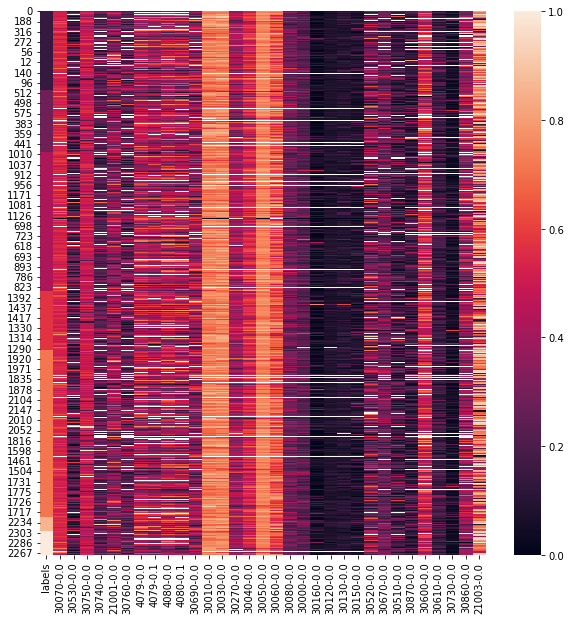

In [299]:
plt.figure(figsize=(10,10))
cb_features_with_metabolomic_labels_normalized_with_labels_normalized = cb_features_with_metabolomic_labels_normalized.drop_duplicates()
cb_features_with_metabolomic_labels_normalized_with_labels_normalized['labels'] = cb_features_with_metabolomic_labels_normalized_with_labels_normalized['labels']/7
sns.heatmap(cb_features_with_metabolomic_labels_normalized_with_labels_normalized.sort_values(by = 'labels').drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']))

Below we make the same heatmap as above but with the target column as well.

<AxesSubplot:>

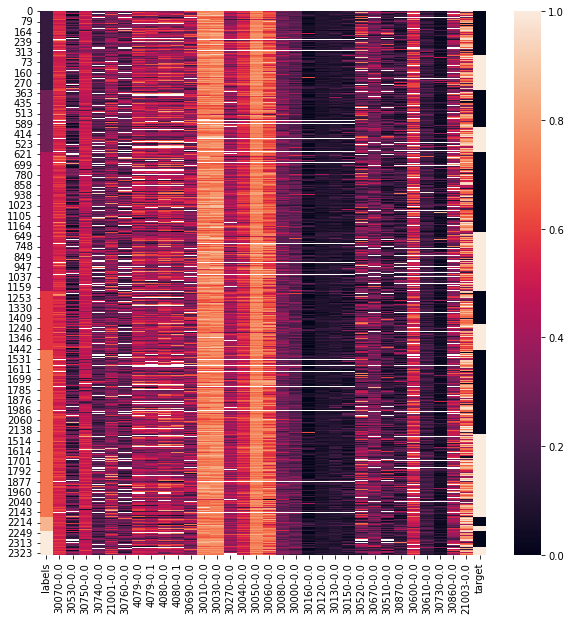

In [300]:
plt.figure(figsize=(10,10))
cb_features_with_metabolomic_labels_normalized_with_labels_normalized_with_target = cb_features_with_metabolomic_labels_normalized_with_labels_normalized.merge(final_classified_patients, on = 'eid', how = 'left')

sns.heatmap(cb_features_with_metabolomic_labels_normalized_with_labels_normalized_with_target.sort_values(by = ['labels', 'target']).drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']))

Below we merge the clinical-biological features with the clusters.

In [301]:
cluster_1_cb_features = cluster_1[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_2_cb_features = cluster_2[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_3_cb_features = cluster_3[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_4_cb_features = cluster_4[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_5_cb_features = cluster_5[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_6_cb_features = cluster_6[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')
cluster_7_cb_features = cluster_7[['eid']].merge(prediabetes_with_features_from_literature_to_keep, on = 'eid')

<a class="anchor" id="Stat_testing_cb"></a>

# Statistical Testing Using Clinical-Biological Features

# Cluster 1

Below we look at a one-vs-all t-test comparison between cluster 1 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 1 for comparison.

In [302]:
not_cluster_1_cb_features = cluster_2_cb_features.append([cluster_3_cb_features, cluster_4_cb_features, cluster_5_cb_features, cluster_6_cb_features, cluster_7_cb_features])
not_cluster_1_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    5472277      14.46       83.9       45.3      6.098    29.1423   
1    4697424      15.89      110.6       43.2      5.371    30.3767   
2    2424811      13.47       87.6       43.5      4.932    37.1187   
3    3053028      13.58       48.4       34.3      5.630    23.7228   
4    1247189      12.84       50.7       43.9        NaN    31.8040   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.365      88.0      85.0     144.0  ...       62.2       39.7   
1        1.179      91.0      93.0     115.0  ...       96.6       38.8   
2        1.370      87.0      86.0     132.0  ...      108.5       46.1   
3        1.734      89.0      92.0     168.0  ...       79.0       22.8   
4          NaN      85.0      80.0     132.0  ...      110.3       30.9   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        73.26         56            1            0            0            0   
1        72.37         45            1            0            0            0   
2        68.50         68            1            0            0            0   
3        83.15         52            1            0            0            0   
4          NaN         48            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[1998 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [303]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_1_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_1_cb_features[cluster_1_cb_features[i].notnull()]
    filtered_df2 = not_cluster_1_cb_features[not_cluster_1_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=0.114 pval=0.735
Statistic and pval for Column 30530-0.0: stat=0.012 pval=0.912
Statistic and pval for Column 30750-0.0: stat=1.799 pval=0.180
Statistic and pval for Column 30740-0.0: stat=0.157 pval=0.692
Statistic and pval for Column 21001-0.0: stat=0.930 pval=0.335
Statistic and pval for Column 30760-0.0: stat=0.332 pval=0.564
Statistic and pval for Column 4079-0.0: stat=0.005 pval=0.944
Statistic and pval for Column 4079-0.1: stat=0.731 pval=0.393
Statistic and pval for Column 4080-0.0: stat=0.320 pval=0.572
Statistic and pval for Column 4080-0.1: stat=0.258 pval=0.612
Statistic and pval for Column 30690-0.0: stat=0.000 pval=0.987
Statistic and pval for Column 30010-0.0: stat=0.010 pval=0.922
Statistic and pval for Column 30030-0.0: stat=0.821 pval=0.365
Statistic and pval for Column 30270-0.0: stat=1.462 pval=0.227
Statistic and pval for Column 30040-0.0: stat=0.005 pval=0.943
Statistic and pval for Column 30050-0.0: stat=0.051 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [304]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=0.090 pval=0.928
Statistic and pval for Column 30530-0.0: stat=-1.736 pval=0.083
Statistic and pval for Column 30750-0.0: stat=1.164 pval=0.244
Statistic and pval for Column 30740-0.0: stat=0.629 pval=0.530
Statistic and pval for Column 21001-0.0: stat=-0.412 pval=0.681
Statistic and pval for Column 30760-0.0: stat=-0.696 pval=0.486
Statistic and pval for Column 4079-0.0: stat=0.520 pval=0.603
Statistic and pval for Column 4079-0.1: stat=1.893 pval=0.058
Statistic and pval for Column 4080-0.0: stat=-1.170 pval=0.242
Statistic and pval for Column 4080-0.1: stat=-0.158 pval=0.874
Statistic and pval for Column 30690-0.0: stat=0.002 pval=0.999
Statistic and pval for Column 30010-0.0: stat=-0.595 pval=0.552
Statistic and pval for Column 30030-0.0: stat=0.116 pval=0.908
Statistic and pval for Column 30270-0.0: stat=0.872 pval=0.383
Statistic and pval for Column 30040-0.0: stat=1.231 pval=0.218
Statistic and pval for Column 30050-0.0: stat=1.855 p

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [305]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [306]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=0.090 pval=29.706
Statistic and pval for Column 30530-0.0: stat=-1.736 pval=2.647
Statistic and pval for Column 30750-0.0: stat=1.164 pval=7.823
Statistic and pval for Column 30740-0.0: stat=0.629 pval=16.949
Statistic and pval for Column 21001-0.0: stat=-0.412 pval=21.779
Statistic and pval for Column 30760-0.0: stat=-0.696 pval=15.560
Statistic and pval for Column 4079-0.0: stat=0.520 pval=19.308
Statistic and pval for Column 4079-0.1: stat=1.893 pval=1.871
Statistic and pval for Column 4080-0.0: stat=-1.170 pval=7.753
Statistic and pval for Column 4080-0.1: stat=-0.158 pval=27.975
Statistic and pval for Column 30690-0.0: stat=0.002 pval=31.954
Statistic and pval for Column 30010-0.0: stat=-0.595 pval=17.662
Statistic and pval for Column 30030-0.0: stat=0.116 pval=29.046
Statistic and pval for Column 30270-0.0: stat=0.872 pval=12.268
Statistic and pval for Column 30040-0.0: stat=1.231 pval=6.992
Statistic and pval for Column 30050-0.0: st

In [307]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [308]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=0.090 pval=207.939
Statistic and pval for Column 30530-0.0: stat=-1.736 pval=18.528
Statistic and pval for Column 30750-0.0: stat=1.164 pval=54.764
Statistic and pval for Column 30740-0.0: stat=0.629 pval=118.642
Statistic and pval for Column 21001-0.0: stat=-0.412 pval=152.456
Statistic and pval for Column 30760-0.0: stat=-0.696 pval=108.921
Statistic and pval for Column 4079-0.0: stat=0.520 pval=135.155
Statistic and pval for Column 4079-0.1: stat=1.893 pval=13.098
Statistic and pval for Column 4080-0.0: stat=-1.170 pval=54.273
Statistic and pval for Column 4080-0.1: stat=-0.158 pval=195.824
Statistic and pval for Column 30690-0.0: stat=0.002 pval=223.680
Statistic and pval for Column 30010-0.0: stat=-0.595 pval=123.631
Statistic and pval for Column 30030-0.0: stat=0.116 pval=203.320
Statistic and pval for Column 30270-0.0: stat=0.872 pval=85.874
Statistic and pval for Column 30040-0.0: stat=1.231 pval=48.943
Statistic and pval for Column

In [309]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

## There are NO significant clinical-biological factors for cluster 1.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 1.

In [310]:
from scipy.stats import ttest_ind

significant_features_equal_c1_cb = []
underexpressed_features_equal_c1_cb  = []
overexpressed_features_equal_c1_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c1_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c1_cb.append(i)
        else:
            overexpressed_features_equal_c1_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=0.090 pval=207.939
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=-1.736 pval=18.528
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=1.164 pval=54.764
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=0.629 pval=118.642
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=-0.412 pval=152.456
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=-0.696 pval=108.921
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=0.520 pval=135.155
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=1.893 pval=13.098
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=-1.170 pval=54.273
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=-0.158 pval=195.824
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=0.002 pval=223.680
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=-0.595 pval=123.631
NOT SIGNIFICANT
Statistic and pval for Column 

In [311]:
from scipy.stats import ttest_ind

significant_features_unequal_c1_cb = []
underexpressed_features_unequal_c1_cb = []
overexpressed_features_unequal_c1_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_1_cb_features[i], not_cluster_1_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c1_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c1_cb.append(i)
        else:
            overexpressed_features_unequal_c1_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Below we create a list of significant features for cluster 1 underexpressed and overexpressed features.

In [312]:
sig_metabolites_underexpressed_c1_cb = underexpressed_features_equal_c1_cb + underexpressed_features_unequal_c1_cb
print(len(sig_metabolites_underexpressed_c1_cb))
sig_metabolites_overexpressed_c1_cb = overexpressed_features_equal_c1_cb + overexpressed_features_unequal_c1_cb
print(len(sig_metabolites_overexpressed_c1_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [313]:
total_significant_cb_features_c1 = sig_metabolites_underexpressed_c1_cb + sig_metabolites_overexpressed_c1_cb
total_significant_cb_features_c1

[]

# Cluster 2

Below we look at a one-vs-all t-test comparison between cluster 2 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 2 for comparison.

In [314]:
not_cluster_2_cb_features = cluster_1_cb_features.append([cluster_3_cb_features, cluster_4_cb_features, cluster_5_cb_features, cluster_6_cb_features, cluster_7_cb_features])
not_cluster_2_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    2469642      12.55      118.8       36.8      5.630    39.2390   
1    4767340      15.80      111.8       45.0      5.207    30.7306   
2    2341969      13.37       36.9       42.6      4.594    24.2288   
3    2152644      14.12       67.1       42.7      5.153    28.2407   
4    1104962      15.89      103.6       42.9      5.750    34.7807   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.039      77.0      74.0     130.0  ...      122.4       26.1   
1        0.914      90.0      85.0     140.0  ...      134.0       39.7   
2        1.611      73.0      77.0     130.0  ...       59.0       26.5   
3        2.047      89.0      99.0     153.0  ...      108.8       33.3   
4        0.833      74.0      86.0     125.0  ...       82.3       54.7   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        67.76         59            1            0            0            0   
1        83.03         61            1            0            0            0   
2        72.78         68            1            0            0            0   
3        76.99         64            1            0            0            0   
4        67.64         68            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[2073 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [315]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_2_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_2_cb_features[cluster_2_cb_features[i].notnull()]
    filtered_df2 = not_cluster_2_cb_features[not_cluster_2_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=3.605 pval=0.058
Statistic and pval for Column 30530-0.0: stat=2.011 pval=0.156
Statistic and pval for Column 30750-0.0: stat=2.367 pval=0.124
Statistic and pval for Column 30740-0.0: stat=0.081 pval=0.776
Statistic and pval for Column 21001-0.0: stat=0.026 pval=0.872
Statistic and pval for Column 30760-0.0: stat=1.387 pval=0.239
Statistic and pval for Column 4079-0.0: stat=0.248 pval=0.619
Statistic and pval for Column 4079-0.1: stat=1.515 pval=0.218
Statistic and pval for Column 4080-0.0: stat=0.633 pval=0.426
Statistic and pval for Column 4080-0.1: stat=0.110 pval=0.740
Statistic and pval for Column 30690-0.0: stat=0.327 pval=0.567
Statistic and pval for Column 30010-0.0: stat=5.707 pval=0.017
Statistic and pval for Column 30030-0.0: stat=5.395 pval=0.020
Statistic and pval for Column 30270-0.0: stat=2.870 pval=0.090
Statistic and pval for Column 30040-0.0: stat=1.837 pval=0.175
Statistic and pval for Column 30050-0.0: stat=2.207 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [316]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=1.093 pval=0.274
Statistic and pval for Column 30530-0.0: stat=-0.399 pval=0.690
Statistic and pval for Column 30750-0.0: stat=-1.092 pval=0.275
Statistic and pval for Column 30740-0.0: stat=-0.399 pval=0.690
Statistic and pval for Column 21001-0.0: stat=-0.572 pval=0.568
Statistic and pval for Column 30760-0.0: stat=0.045 pval=0.964
Statistic and pval for Column 4079-0.0: stat=0.395 pval=0.693
Statistic and pval for Column 4079-0.1: stat=0.086 pval=0.931
Statistic and pval for Column 4080-0.0: stat=-0.455 pval=0.649
Statistic and pval for Column 4080-0.1: stat=0.068 pval=0.945
Statistic and pval for Column 30690-0.0: stat=0.671 pval=0.502
Statistic and pval for Column 30270-0.0: stat=-3.165 pval=0.002
Statistic and pval for Column 30040-0.0: stat=-1.795 pval=0.073
Statistic and pval for Column 30050-0.0: stat=-1.577 pval=0.115
Statistic and pval for Column 30060-0.0: stat=-0.766 pval=0.444
Statistic and pval for Column 30080-0.0: stat=0.52

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [317]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30010-0.0: stat=-0.050 pval=0.961
Statistic and pval for Column 30030-0.0: stat=-1.140 pval=0.255
Statistic and pval for Column 30000-0.0: stat=-2.087 pval=0.038


Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [318]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=1.093 pval=8.781
Statistic and pval for Column 30530-0.0: stat=-0.399 pval=22.069
Statistic and pval for Column 30750-0.0: stat=-1.092 pval=8.804
Statistic and pval for Column 30740-0.0: stat=-0.399 pval=22.074
Statistic and pval for Column 21001-0.0: stat=-0.572 pval=18.164
Statistic and pval for Column 30760-0.0: stat=0.045 pval=30.851
Statistic and pval for Column 4079-0.0: stat=0.395 pval=22.172
Statistic and pval for Column 4079-0.1: stat=0.086 pval=29.806
Statistic and pval for Column 4080-0.0: stat=-0.455 pval=20.778
Statistic and pval for Column 4080-0.1: stat=0.068 pval=30.253
Statistic and pval for Column 30690-0.0: stat=0.671 pval=16.070
Statistic and pval for Column 30270-0.0: stat=-3.165 pval=0.050
Statistic and pval for Column 30040-0.0: stat=-1.795 pval=2.331
Statistic and pval for Column 30050-0.0: stat=-1.577 pval=3.675
Statistic and pval for Column 30060-0.0: stat=-0.766 pval=14.192
Statistic and pval for Column 30080-0.0:

In [319]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30010-0.0: stat=-0.050 pval=30.737
Statistic and pval for Column 30030-0.0: stat=-1.140 pval=8.169
Statistic and pval for Column 30000-0.0: stat=-2.087 pval=1.203


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [320]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=1.093 pval=61.467
Statistic and pval for Column 30530-0.0: stat=-0.399 pval=154.480
Statistic and pval for Column 30750-0.0: stat=-1.092 pval=61.630
Statistic and pval for Column 30740-0.0: stat=-0.399 pval=154.518
Statistic and pval for Column 21001-0.0: stat=-0.572 pval=127.145
Statistic and pval for Column 30760-0.0: stat=0.045 pval=215.954
Statistic and pval for Column 4079-0.0: stat=0.395 pval=155.207
Statistic and pval for Column 4079-0.1: stat=0.086 pval=208.639
Statistic and pval for Column 4080-0.0: stat=-0.455 pval=145.445
Statistic and pval for Column 4080-0.1: stat=0.068 pval=211.773
Statistic and pval for Column 30690-0.0: stat=0.671 pval=112.487
Statistic and pval for Column 30270-0.0: stat=-3.165 pval=0.352
Statistic and pval for Column 30040-0.0: stat=-1.795 pval=16.316
Statistic and pval for Column 30050-0.0: stat=-1.577 pval=25.723
Statistic and pval for Column 30060-0.0: stat=-0.766 pval=99.346
Statistic and pval for Colu

In [321]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30010-0.0: stat=-0.050 pval=215.161
Statistic and pval for Column 30030-0.0: stat=-1.140 pval=57.186
Statistic and pval for Column 30000-0.0: stat=-2.087 pval=8.424


## There are NO significant clinical-biological factors for cluster 2.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 2.

In [322]:
from scipy.stats import ttest_ind

significant_features_equal_c2_cb = []
underexpressed_features_equal_c2_cb  = []
overexpressed_features_equal_c2_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c2_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c2_cb.append(i)
        else:
            overexpressed_features_equal_c2_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=1.093 pval=61.467
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=-0.399 pval=154.480
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=-1.092 pval=61.630
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=-0.399 pval=154.518
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=-0.572 pval=127.145
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=0.045 pval=215.954
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=0.395 pval=155.207
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=0.086 pval=208.639
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=-0.455 pval=145.445
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=0.068 pval=211.773
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=0.671 pval=112.487
NOT SIGNIFICANT
Statistic and pval for Column 30270-0.0: stat=-3.165 pval=0.352
NOT SIGNIFICANT
Statistic and pval for Column 

In [323]:
from scipy.stats import ttest_ind

significant_features_unequal_c2_cb = []
underexpressed_features_unequal_c2_cb = []
overexpressed_features_unequal_c2_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_2_cb_features[i], not_cluster_2_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c2_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c2_cb.append(i)
        else:
            overexpressed_features_unequal_c2_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30010-0.0: stat=-0.050 pval=215.161
NOT SIGNIFICANT
Statistic and pval for Column 30030-0.0: stat=-1.140 pval=57.186
NOT SIGNIFICANT
Statistic and pval for Column 30000-0.0: stat=-2.087 pval=8.424
NOT SIGNIFICANT


Below we create a list of significant features for cluster 2 underexpressed and overexpressed features.

In [324]:
sig_metabolites_underexpressed_c2_cb = underexpressed_features_equal_c2_cb + underexpressed_features_unequal_c2_cb
print(len(sig_metabolites_underexpressed_c2_cb))
sig_metabolites_overexpressed_c2_cb = overexpressed_features_equal_c2_cb + overexpressed_features_unequal_c2_cb
print(len(sig_metabolites_overexpressed_c2_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [325]:
total_significant_cb_features_c2 = sig_metabolites_underexpressed_c2_cb + sig_metabolites_overexpressed_c2_cb
total_significant_cb_features_c2

[]

# Cluster 3

Below we look at a one-vs-all t-test comparison between cluster 3 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 3 for comparison.

In [326]:
not_cluster_3_cb_features = cluster_1_cb_features.append([cluster_2_cb_features, cluster_4_cb_features, cluster_5_cb_features, cluster_6_cb_features, cluster_7_cb_features])
not_cluster_3_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    2469642      12.55      118.8       36.8      5.630    39.2390   
1    4767340      15.80      111.8       45.0      5.207    30.7306   
2    2341969      13.37       36.9       42.6      4.594    24.2288   
3    2152644      14.12       67.1       42.7      5.153    28.2407   
4    1104962      15.89      103.6       42.9      5.750    34.7807   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.039      77.0      74.0     130.0  ...      122.4       26.1   
1        0.914      90.0      85.0     140.0  ...      134.0       39.7   
2        1.611      73.0      77.0     130.0  ...       59.0       26.5   
3        2.047      89.0      99.0     153.0  ...      108.8       33.3   
4        0.833      74.0      86.0     125.0  ...       82.3       54.7   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        67.76         59            1            0            0            0   
1        83.03         61            1            0            0            0   
2        72.78         68            1            0            0            0   
3        76.99         64            1            0            0            0   
4        67.64         68            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[1740 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [327]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_3_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_3_cb_features[cluster_3_cb_features[i].notnull()]
    filtered_df2 = not_cluster_3_cb_features[not_cluster_3_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=0.341 pval=0.560
Statistic and pval for Column 30530-0.0: stat=0.277 pval=0.599
Statistic and pval for Column 30750-0.0: stat=0.778 pval=0.378
Statistic and pval for Column 30740-0.0: stat=0.691 pval=0.406
Statistic and pval for Column 21001-0.0: stat=0.081 pval=0.776
Statistic and pval for Column 30760-0.0: stat=1.605 pval=0.205
Statistic and pval for Column 4079-0.0: stat=1.440 pval=0.230
Statistic and pval for Column 4079-0.1: stat=0.813 pval=0.367
Statistic and pval for Column 4080-0.0: stat=0.477 pval=0.490
Statistic and pval for Column 4080-0.1: stat=0.625 pval=0.429
Statistic and pval for Column 30690-0.0: stat=0.310 pval=0.578
Statistic and pval for Column 30010-0.0: stat=0.294 pval=0.587
Statistic and pval for Column 30030-0.0: stat=1.172 pval=0.279
Statistic and pval for Column 30270-0.0: stat=1.319 pval=0.251
Statistic and pval for Column 30040-0.0: stat=0.091 pval=0.763
Statistic and pval for Column 30050-0.0: stat=0.550 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [328]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=-0.640 pval=0.522
Statistic and pval for Column 30530-0.0: stat=0.261 pval=0.794
Statistic and pval for Column 30750-0.0: stat=0.202 pval=0.840
Statistic and pval for Column 30740-0.0: stat=-0.550 pval=0.582
Statistic and pval for Column 21001-0.0: stat=-0.449 pval=0.654
Statistic and pval for Column 30760-0.0: stat=0.822 pval=0.411
Statistic and pval for Column 4079-0.0: stat=1.084 pval=0.278
Statistic and pval for Column 4079-0.1: stat=0.615 pval=0.539
Statistic and pval for Column 4080-0.0: stat=1.597 pval=0.110
Statistic and pval for Column 4080-0.1: stat=1.932 pval=0.053
Statistic and pval for Column 30690-0.0: stat=-0.406 pval=0.685
Statistic and pval for Column 30010-0.0: stat=0.288 pval=0.773
Statistic and pval for Column 30030-0.0: stat=0.829 pval=0.407
Statistic and pval for Column 30270-0.0: stat=1.602 pval=0.109
Statistic and pval for Column 30040-0.0: stat=0.633 pval=0.527
Statistic and pval for Column 30050-0.0: stat=-0.195 pv

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [329]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [330]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=-0.640 pval=16.717
Statistic and pval for Column 30530-0.0: stat=0.261 pval=25.411
Statistic and pval for Column 30750-0.0: stat=0.202 pval=26.886
Statistic and pval for Column 30740-0.0: stat=-0.550 pval=18.628
Statistic and pval for Column 21001-0.0: stat=-0.449 pval=20.914
Statistic and pval for Column 30760-0.0: stat=0.822 pval=13.161
Statistic and pval for Column 4079-0.0: stat=1.084 pval=8.911
Statistic and pval for Column 4079-0.1: stat=0.615 pval=17.237
Statistic and pval for Column 4080-0.0: stat=1.597 pval=3.530
Statistic and pval for Column 4080-0.1: stat=1.932 pval=1.711
Statistic and pval for Column 30690-0.0: stat=-0.406 pval=21.918
Statistic and pval for Column 30010-0.0: stat=0.288 pval=24.743
Statistic and pval for Column 30030-0.0: stat=0.829 pval=13.032
Statistic and pval for Column 30270-0.0: stat=1.602 pval=3.496
Statistic and pval for Column 30040-0.0: stat=0.633 pval=16.854
Statistic and pval for Column 30050-0.0: sta

In [331]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [332]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=-0.640 pval=117.018
Statistic and pval for Column 30530-0.0: stat=0.261 pval=177.876
Statistic and pval for Column 30750-0.0: stat=0.202 pval=188.200
Statistic and pval for Column 30740-0.0: stat=-0.550 pval=130.397
Statistic and pval for Column 21001-0.0: stat=-0.449 pval=146.397
Statistic and pval for Column 30760-0.0: stat=0.822 pval=92.128
Statistic and pval for Column 4079-0.0: stat=1.084 pval=62.375
Statistic and pval for Column 4079-0.1: stat=0.615 pval=120.656
Statistic and pval for Column 4080-0.0: stat=1.597 pval=24.707
Statistic and pval for Column 4080-0.1: stat=1.932 pval=11.975
Statistic and pval for Column 30690-0.0: stat=-0.406 pval=153.426
Statistic and pval for Column 30010-0.0: stat=0.288 pval=173.203
Statistic and pval for Column 30030-0.0: stat=0.829 pval=91.226
Statistic and pval for Column 30270-0.0: stat=1.602 pval=24.475
Statistic and pval for Column 30040-0.0: stat=0.633 pval=117.981
Statistic and pval for Column 3

In [333]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

## There are NO significant clinical-biological factors for cluster 3.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 3.

In [334]:
from scipy.stats import ttest_ind

significant_features_equal_c3_cb = []
underexpressed_features_equal_c3_cb  = []
overexpressed_features_equal_c3_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c3_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c3_cb.append(i)
        else:
            overexpressed_features_equal_c3_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=-0.640 pval=117.018
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=0.261 pval=177.876
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=0.202 pval=188.200
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=-0.550 pval=130.397
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=-0.449 pval=146.397
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=0.822 pval=92.128
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=1.084 pval=62.375
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=0.615 pval=120.656
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=1.597 pval=24.707
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=1.932 pval=11.975
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=-0.406 pval=153.426
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=0.288 pval=173.203
NOT SIGNIFICANT
Statistic and pval for Column 30

In [335]:
from scipy.stats import ttest_ind

significant_features_unequal_c3_cb = []
underexpressed_features_unequal_c3_cb = []
overexpressed_features_unequal_c3_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_3_cb_features[i], not_cluster_3_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c3_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c3_cb.append(i)
        else:
            overexpressed_features_unequal_c3_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Below we create a list of significant features for cluster 3 underexpressed and overexpressed features.

In [336]:
sig_metabolites_underexpressed_c3_cb = underexpressed_features_equal_c3_cb + underexpressed_features_unequal_c3_cb
print(len(sig_metabolites_underexpressed_c3_cb))
sig_metabolites_overexpressed_c3_cb = overexpressed_features_equal_c3_cb + overexpressed_features_unequal_c3_cb
print(len(sig_metabolites_overexpressed_c3_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [337]:
total_significant_cb_features_c3 = sig_metabolites_underexpressed_c3_cb + sig_metabolites_overexpressed_c3_cb
total_significant_cb_features_c3

[]

# Cluster 4

Below we look at a one-vs-all t-test comparison between cluster 4 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 4 for comparison.

In [338]:
not_cluster_4_cb_features = cluster_1_cb_features.append([cluster_2_cb_features, cluster_3_cb_features, cluster_5_cb_features, cluster_6_cb_features, cluster_7_cb_features])
not_cluster_4_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    2469642      12.55      118.8       36.8      5.630    39.2390   
1    4767340      15.80      111.8       45.0      5.207    30.7306   
2    2341969      13.37       36.9       42.6      4.594    24.2288   
3    2152644      14.12       67.1       42.7      5.153    28.2407   
4    1104962      15.89      103.6       42.9      5.750    34.7807   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.039      77.0      74.0     130.0  ...      122.4       26.1   
1        0.914      90.0      85.0     140.0  ...      134.0       39.7   
2        1.611      73.0      77.0     130.0  ...       59.0       26.5   
3        2.047      89.0      99.0     153.0  ...      108.8       33.3   
4        0.833      74.0      86.0     125.0  ...       82.3       54.7   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        67.76         59            1            0            0            0   
1        83.03         61            1            0            0            0   
2        72.78         68            1            0            0            0   
3        76.99         64            1            0            0            0   
4        67.64         68            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[2089 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [339]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_4_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_4_cb_features[cluster_4_cb_features[i].notnull()]
    filtered_df2 = not_cluster_4_cb_features[not_cluster_4_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=0.671 pval=0.413
Statistic and pval for Column 30530-0.0: stat=0.344 pval=0.557
Statistic and pval for Column 30750-0.0: stat=0.043 pval=0.835
Statistic and pval for Column 30740-0.0: stat=0.168 pval=0.682
Statistic and pval for Column 21001-0.0: stat=1.644 pval=0.200
Statistic and pval for Column 30760-0.0: stat=3.318 pval=0.069
Statistic and pval for Column 4079-0.0: stat=0.117 pval=0.733
Statistic and pval for Column 4079-0.1: stat=1.774 pval=0.183
Statistic and pval for Column 4080-0.0: stat=1.452 pval=0.228
Statistic and pval for Column 4080-0.1: stat=0.909 pval=0.340
Statistic and pval for Column 30690-0.0: stat=0.300 pval=0.584
Statistic and pval for Column 30010-0.0: stat=2.694 pval=0.101
Statistic and pval for Column 30030-0.0: stat=2.656 pval=0.103
Statistic and pval for Column 30270-0.0: stat=0.075 pval=0.785
Statistic and pval for Column 30040-0.0: stat=0.188 pval=0.665
Statistic and pval for Column 30050-0.0: stat=0.052 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [340]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=0.394 pval=0.694
Statistic and pval for Column 30530-0.0: stat=0.031 pval=0.975
Statistic and pval for Column 30750-0.0: stat=-0.636 pval=0.525
Statistic and pval for Column 30740-0.0: stat=2.695 pval=0.007
Statistic and pval for Column 21001-0.0: stat=0.272 pval=0.786
Statistic and pval for Column 30760-0.0: stat=1.267 pval=0.205
Statistic and pval for Column 4079-0.0: stat=1.079 pval=0.281
Statistic and pval for Column 4079-0.1: stat=0.266 pval=0.790
Statistic and pval for Column 4080-0.0: stat=1.228 pval=0.219
Statistic and pval for Column 4080-0.1: stat=0.436 pval=0.663
Statistic and pval for Column 30690-0.0: stat=0.830 pval=0.407
Statistic and pval for Column 30010-0.0: stat=-0.582 pval=0.561
Statistic and pval for Column 30030-0.0: stat=0.360 pval=0.719
Statistic and pval for Column 30270-0.0: stat=2.153 pval=0.031
Statistic and pval for Column 30040-0.0: stat=1.503 pval=0.133
Statistic and pval for Column 30050-0.0: stat=1.379 pval=

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [341]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [342]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=0.394 pval=22.200
Statistic and pval for Column 30530-0.0: stat=0.031 pval=31.199
Statistic and pval for Column 30750-0.0: stat=-0.636 pval=16.804
Statistic and pval for Column 30740-0.0: stat=2.695 pval=0.227
Statistic and pval for Column 21001-0.0: stat=0.272 pval=25.147
Statistic and pval for Column 30760-0.0: stat=1.267 pval=6.571
Statistic and pval for Column 4079-0.0: stat=1.079 pval=8.980
Statistic and pval for Column 4079-0.1: stat=0.266 pval=25.289
Statistic and pval for Column 4080-0.0: stat=1.228 pval=7.021
Statistic and pval for Column 4080-0.1: stat=0.436 pval=21.221
Statistic and pval for Column 30690-0.0: stat=0.830 pval=13.016
Statistic and pval for Column 30010-0.0: stat=-0.582 pval=17.950
Statistic and pval for Column 30030-0.0: stat=0.360 pval=22.994
Statistic and pval for Column 30270-0.0: stat=2.153 pval=1.005
Statistic and pval for Column 30040-0.0: stat=1.503 pval=4.255
Statistic and pval for Column 30050-0.0: stat=1.

In [343]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [344]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=0.394 pval=155.399
Statistic and pval for Column 30530-0.0: stat=0.031 pval=218.391
Statistic and pval for Column 30750-0.0: stat=-0.636 pval=117.625
Statistic and pval for Column 30740-0.0: stat=2.695 pval=1.589
Statistic and pval for Column 21001-0.0: stat=0.272 pval=176.029
Statistic and pval for Column 30760-0.0: stat=1.267 pval=45.999
Statistic and pval for Column 4079-0.0: stat=1.079 pval=62.859
Statistic and pval for Column 4079-0.1: stat=0.266 pval=177.025
Statistic and pval for Column 4080-0.0: stat=1.228 pval=49.148
Statistic and pval for Column 4080-0.1: stat=0.436 pval=148.547
Statistic and pval for Column 30690-0.0: stat=0.830 pval=91.110
Statistic and pval for Column 30010-0.0: stat=-0.582 pval=125.648
Statistic and pval for Column 30030-0.0: stat=0.360 pval=160.957
Statistic and pval for Column 30270-0.0: stat=2.153 pval=7.036
Statistic and pval for Column 30040-0.0: stat=1.503 pval=29.787
Statistic and pval for Column 30050-

In [345]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

## There are NO significant clinical-biological factors for cluster 4.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 4.

In [346]:
from scipy.stats import ttest_ind

significant_features_equal_c4_cb = []
underexpressed_features_equal_c4_cb  = []
overexpressed_features_equal_c4_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c4_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c4_cb.append(i)
        else:
            overexpressed_features_equal_c4_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=0.394 pval=155.399
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=0.031 pval=218.391
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=-0.636 pval=117.625
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=2.695 pval=1.589
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=0.272 pval=176.029
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=1.267 pval=45.999
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=1.079 pval=62.859
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=0.266 pval=177.025
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=1.228 pval=49.148
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=0.436 pval=148.547
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=0.830 pval=91.110
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=-0.582 pval=125.648
NOT SIGNIFICANT
Statistic and pval for Column 30030-

In [347]:
from scipy.stats import ttest_ind

significant_features_unequal_c4_cb = []
underexpressed_features_unequal_c4_cb = []
overexpressed_features_unequal_c4_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_4_cb_features[i], not_cluster_4_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c4_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c4_cb.append(i)
        else:
            overexpressed_features_unequal_c4_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Below we create a list of significant features for cluster 4 underexpressed and overexpressed features.

In [348]:
sig_metabolites_underexpressed_c4_cb = underexpressed_features_equal_c4_cb + underexpressed_features_unequal_c4_cb
print(len(sig_metabolites_underexpressed_c4_cb))
sig_metabolites_overexpressed_c4_cb = overexpressed_features_equal_c4_cb + overexpressed_features_unequal_c4_cb
print(len(sig_metabolites_overexpressed_c4_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [349]:
total_significant_cb_features_c4 = sig_metabolites_underexpressed_c4_cb + sig_metabolites_overexpressed_c4_cb
total_significant_cb_features_c4

[]

# Cluster 5

Below we look at a one-vs-all t-test comparison between cluster 5 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 5 for comparison.

In [350]:
not_cluster_5_cb_features = cluster_1_cb_features.append([cluster_2_cb_features, cluster_3_cb_features, cluster_4_cb_features, cluster_6_cb_features, cluster_7_cb_features])
not_cluster_5_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    2469642      12.55      118.8       36.8      5.630    39.2390   
1    4767340      15.80      111.8       45.0      5.207    30.7306   
2    2341969      13.37       36.9       42.6      4.594    24.2288   
3    2152644      14.12       67.1       42.7      5.153    28.2407   
4    1104962      15.89      103.6       42.9      5.750    34.7807   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.039      77.0      74.0     130.0  ...      122.4       26.1   
1        0.914      90.0      85.0     140.0  ...      134.0       39.7   
2        1.611      73.0      77.0     130.0  ...       59.0       26.5   
3        2.047      89.0      99.0     153.0  ...      108.8       33.3   
4        0.833      74.0      86.0     125.0  ...       82.3       54.7   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        67.76         59            1            0            0            0   
1        83.03         61            1            0            0            0   
2        72.78         68            1            0            0            0   
3        76.99         64            1            0            0            0   
4        67.64         68            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[1617 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [351]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_5_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_5_cb_features[cluster_5_cb_features[i].notnull()]
    filtered_df2 = not_cluster_5_cb_features[not_cluster_5_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=1.707 pval=0.191
Statistic and pval for Column 30530-0.0: stat=0.085 pval=0.771
Statistic and pval for Column 30750-0.0: stat=0.356 pval=0.551
Statistic and pval for Column 30740-0.0: stat=0.013 pval=0.908
Statistic and pval for Column 21001-0.0: stat=0.077 pval=0.782
Statistic and pval for Column 30760-0.0: stat=3.023 pval=0.082
Statistic and pval for Column 4079-0.0: stat=1.706 pval=0.192
Statistic and pval for Column 4079-0.1: stat=6.756 pval=0.009
Statistic and pval for Column 4080-0.0: stat=0.682 pval=0.409
Statistic and pval for Column 4080-0.1: stat=1.621 pval=0.203
Statistic and pval for Column 30690-0.0: stat=0.046 pval=0.830
Statistic and pval for Column 30010-0.0: stat=0.002 pval=0.968
Statistic and pval for Column 30030-0.0: stat=0.540 pval=0.463
Statistic and pval for Column 30270-0.0: stat=0.176 pval=0.675
Statistic and pval for Column 30040-0.0: stat=0.011 pval=0.917
Statistic and pval for Column 30050-0.0: stat=0.231 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [352]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=-0.081 pval=0.936
Statistic and pval for Column 30530-0.0: stat=1.340 pval=0.181
Statistic and pval for Column 30750-0.0: stat=1.230 pval=0.219
Statistic and pval for Column 30740-0.0: stat=-1.514 pval=0.130
Statistic and pval for Column 21001-0.0: stat=1.874 pval=0.061
Statistic and pval for Column 30760-0.0: stat=-1.519 pval=0.129
Statistic and pval for Column 4079-0.0: stat=-2.012 pval=0.044
Statistic and pval for Column 4080-0.0: stat=-0.815 pval=0.415
Statistic and pval for Column 4080-0.1: stat=-1.312 pval=0.190
Statistic and pval for Column 30690-0.0: stat=-0.706 pval=0.480
Statistic and pval for Column 30010-0.0: stat=-0.445 pval=0.657
Statistic and pval for Column 30030-0.0: stat=-1.091 pval=0.275
Statistic and pval for Column 30270-0.0: stat=-0.953 pval=0.341
Statistic and pval for Column 30040-0.0: stat=-0.853 pval=0.394
Statistic and pval for Column 30050-0.0: stat=-0.818 pval=0.414
Statistic and pval for Column 30060-0.0: stat=

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [353]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 4079-0.1: stat=-2.000 pval=0.046


Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [354]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=-0.081 pval=29.938
Statistic and pval for Column 30530-0.0: stat=1.340 pval=5.776
Statistic and pval for Column 30750-0.0: stat=1.230 pval=7.003
Statistic and pval for Column 30740-0.0: stat=-1.514 pval=4.168
Statistic and pval for Column 21001-0.0: stat=1.874 pval=1.952
Statistic and pval for Column 30760-0.0: stat=-1.519 pval=4.125
Statistic and pval for Column 4079-0.0: stat=-2.012 pval=1.418
Statistic and pval for Column 4080-0.0: stat=-0.815 pval=13.294
Statistic and pval for Column 4080-0.1: stat=-1.312 pval=6.065
Statistic and pval for Column 30690-0.0: stat=-0.706 pval=15.359
Statistic and pval for Column 30010-0.0: stat=-0.445 pval=21.012
Statistic and pval for Column 30030-0.0: stat=-1.091 pval=8.810
Statistic and pval for Column 30270-0.0: stat=-0.953 pval=10.910
Statistic and pval for Column 30040-0.0: stat=-0.853 pval=12.604
Statistic and pval for Column 30050-0.0: stat=-0.818 pval=13.234
Statistic and pval for Column 30060-0.0

In [355]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 4079-0.1: stat=-2.000 pval=1.461


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [356]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=-0.081 pval=209.563
Statistic and pval for Column 30530-0.0: stat=1.340 pval=40.435
Statistic and pval for Column 30750-0.0: stat=1.230 pval=49.023
Statistic and pval for Column 30740-0.0: stat=-1.514 pval=29.175
Statistic and pval for Column 21001-0.0: stat=1.874 pval=13.663
Statistic and pval for Column 30760-0.0: stat=-1.519 pval=28.878
Statistic and pval for Column 4079-0.0: stat=-2.012 pval=9.927
Statistic and pval for Column 4080-0.0: stat=-0.815 pval=93.055
Statistic and pval for Column 4080-0.1: stat=-1.312 pval=42.452
Statistic and pval for Column 30690-0.0: stat=-0.706 pval=107.512
Statistic and pval for Column 30010-0.0: stat=-0.445 pval=147.085
Statistic and pval for Column 30030-0.0: stat=-1.091 pval=61.672
Statistic and pval for Column 30270-0.0: stat=-0.953 pval=76.370
Statistic and pval for Column 30040-0.0: stat=-0.853 pval=88.230
Statistic and pval for Column 30050-0.0: stat=-0.818 pval=92.638
Statistic and pval for Column

In [357]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 4079-0.1: stat=-2.000 pval=10.230


## There are NO significant clinical-biological factors for cluster 5.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 5.

In [358]:
from scipy.stats import ttest_ind

significant_features_equal_c5_cb = []
underexpressed_features_equal_c5_cb  = []
overexpressed_features_equal_c5_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c5_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c5_cb.append(i)
        else:
            overexpressed_features_equal_c5_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=-0.081 pval=209.563
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=1.340 pval=40.435
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=1.230 pval=49.023
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=-1.514 pval=29.175
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=1.874 pval=13.663
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=-1.519 pval=28.878
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=-2.012 pval=9.927
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=-0.815 pval=93.055
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=-1.312 pval=42.452
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=-0.706 pval=107.512
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=-0.445 pval=147.085
NOT SIGNIFICANT
Statistic and pval for Column 30030-0.0: stat=-1.091 pval=61.672
NOT SIGNIFICANT
Statistic and pval for Column 30

In [359]:
from scipy.stats import ttest_ind

significant_features_unequal_c5_cb = []
underexpressed_features_unequal_c5_cb = []
overexpressed_features_unequal_c5_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_5_cb_features[i], not_cluster_5_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c5_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c5_cb.append(i)
        else:
            overexpressed_features_unequal_c5_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 4079-0.1: stat=-2.000 pval=10.230
NOT SIGNIFICANT


Below we create a list of significant features for cluster 5 underexpressed and overexpressed features.

In [360]:
sig_metabolites_underexpressed_c5_cb = underexpressed_features_equal_c5_cb + underexpressed_features_unequal_c5_cb
print(len(sig_metabolites_underexpressed_c5_cb))
sig_metabolites_overexpressed_c5_cb = overexpressed_features_equal_c5_cb + overexpressed_features_unequal_c5_cb
print(len(sig_metabolites_overexpressed_c5_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [361]:
total_significant_cb_features_c5 = sig_metabolites_underexpressed_c5_cb + sig_metabolites_overexpressed_c5_cb
total_significant_cb_features_c5

[]

# Cluster 6

Below we look at a one-vs-all t-test comparison between cluster 6 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 6 for comparison.

In [362]:
not_cluster_6_cb_features = cluster_1_cb_features.append([cluster_2_cb_features, cluster_3_cb_features, cluster_4_cb_features, cluster_5_cb_features, cluster_7_cb_features])
not_cluster_6_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  \
0    2469642      12.55      118.8       36.8      5.630    39.2390   
1    4767340      15.80      111.8       45.0      5.207    30.7306   
2    2341969      13.37       36.9       42.6      4.594    24.2288   
3    2152644      14.12       67.1       42.7      5.153    28.2407   
4    1104962      15.89      103.6       42.9      5.750    34.7807   
..       ...        ...        ...        ...        ...        ...   
96   5713955      13.69       54.7       43.5      6.014    31.8753   
97   4604230      14.08       36.3       42.4      4.420    24.4706   
98   3985141      14.11       95.7       45.3        NaN    22.7933   
99   2398455      14.80       53.0       43.2      4.889    24.5312   
100  5300315      13.20       37.8        NaN      4.515    21.0440   

     30760-0.0  4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  \
0        1.039      77.0      74.0     130.0  ...      122.4       26.1   
1        0.914      90.0      85.0     140.0  ...      134.0       39.7   
2        1.611      73.0      77.0     130.0  ...       59.0       26.5   
3        2.047      89.0      99.0     153.0  ...      108.8       33.3   
4        0.833      74.0      86.0     125.0  ...       82.3       54.7   
..         ...       ...       ...       ...  ...        ...        ...   
96       1.140      88.0      86.0     164.0  ...       87.7       40.7   
97       1.718      91.0      83.0     159.0  ...       58.4       29.2   
98         NaN      82.0      82.0     158.0  ...        NaN        NaN   
99       1.563      55.0      58.0     128.0  ...      106.2       15.2   
100      2.112       NaN       NaN       NaN  ...       78.2       36.0   

     30860-0.0  21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0        67.76         59            1            0            0            0   
1        83.03         61            1            0            0            0   
2        72.78         68            1            0            0            0   
3        76.99         64            1            0            0            0   
4        67.64         68            1            0            0            0   
..         ...        ...          ...          ...          ...          ...   
96       71.72         69            1            0            0            0   
97       77.96         66            1            0            0            0   
98         NaN         63            0            1            0            0   
99       63.17         67            1            0            0            0   
100      72.08         61            0            1            0            0   

     Ethnicity_4  Ethnicity_5  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
96             0            0  
97             0            0  
98             0            0  
99             0            0  
100            0            0  

[2279 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [363]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_6_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_6_cb_features[cluster_6_cb_features[i].notnull()]
    filtered_df2 = not_cluster_6_cb_features[not_cluster_6_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=0.589 pval=0.443
Statistic and pval for Column 30530-0.0: stat=2.122 pval=0.145
Statistic and pval for Column 30750-0.0: stat=1.288 pval=0.257
Statistic and pval for Column 30740-0.0: stat=0.289 pval=0.591
Statistic and pval for Column 21001-0.0: stat=0.359 pval=0.549
Statistic and pval for Column 30760-0.0: stat=0.617 pval=0.432
Statistic and pval for Column 4079-0.0: stat=0.196 pval=0.658
Statistic and pval for Column 4079-0.1: stat=0.408 pval=0.523
Statistic and pval for Column 4080-0.0: stat=0.162 pval=0.687
Statistic and pval for Column 4080-0.1: stat=0.077 pval=0.781
Statistic and pval for Column 30690-0.0: stat=0.750 pval=0.387
Statistic and pval for Column 30010-0.0: stat=0.679 pval=0.410
Statistic and pval for Column 30030-0.0: stat=0.753 pval=0.386
Statistic and pval for Column 30270-0.0: stat=0.006 pval=0.939
Statistic and pval for Column 30040-0.0: stat=2.070 pval=0.150
Statistic and pval for Column 30050-0.0: stat=2.036 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [364]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=-0.483 pval=0.629
Statistic and pval for Column 30530-0.0: stat=-0.517 pval=0.605
Statistic and pval for Column 30750-0.0: stat=-0.599 pval=0.549
Statistic and pval for Column 30740-0.0: stat=0.446 pval=0.655
Statistic and pval for Column 21001-0.0: stat=-1.334 pval=0.182
Statistic and pval for Column 30760-0.0: stat=1.055 pval=0.291
Statistic and pval for Column 4079-0.0: stat=-0.664 pval=0.507
Statistic and pval for Column 4079-0.1: stat=-0.005 pval=0.996
Statistic and pval for Column 4080-0.0: stat=-0.647 pval=0.518
Statistic and pval for Column 4080-0.1: stat=-0.932 pval=0.352
Statistic and pval for Column 30690-0.0: stat=1.536 pval=0.125
Statistic and pval for Column 30010-0.0: stat=1.071 pval=0.284
Statistic and pval for Column 30030-0.0: stat=0.643 pval=0.520
Statistic and pval for Column 30270-0.0: stat=-0.736 pval=0.462
Statistic and pval for Column 30040-0.0: stat=-0.804 pval=0.421
Statistic and pval for Column 30050-0.0: stat=-0.

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [365]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [366]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=-0.483 pval=20.140
Statistic and pval for Column 30530-0.0: stat=-0.517 pval=19.360
Statistic and pval for Column 30750-0.0: stat=-0.599 pval=17.571
Statistic and pval for Column 30740-0.0: stat=0.446 pval=20.975
Statistic and pval for Column 21001-0.0: stat=-1.334 pval=5.836
Statistic and pval for Column 30760-0.0: stat=1.055 pval=9.323
Statistic and pval for Column 4079-0.0: stat=-0.664 pval=16.209
Statistic and pval for Column 4079-0.1: stat=-0.005 pval=31.868
Statistic and pval for Column 4080-0.0: stat=-0.647 pval=16.567
Statistic and pval for Column 4080-0.1: stat=-0.932 pval=11.251
Statistic and pval for Column 30690-0.0: stat=1.536 pval=3.989
Statistic and pval for Column 30010-0.0: stat=1.071 pval=9.097
Statistic and pval for Column 30030-0.0: stat=0.643 pval=16.644
Statistic and pval for Column 30270-0.0: stat=-0.736 pval=14.773
Statistic and pval for Column 30040-0.0: stat=-0.804 pval=13.480
Statistic and pval for Column 30050-0.

In [367]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [368]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=-0.483 pval=140.983
Statistic and pval for Column 30530-0.0: stat=-0.517 pval=135.520
Statistic and pval for Column 30750-0.0: stat=-0.599 pval=123.000
Statistic and pval for Column 30740-0.0: stat=0.446 pval=146.822
Statistic and pval for Column 21001-0.0: stat=-1.334 pval=40.855
Statistic and pval for Column 30760-0.0: stat=1.055 pval=65.261
Statistic and pval for Column 4079-0.0: stat=-0.664 pval=113.466
Statistic and pval for Column 4079-0.1: stat=-0.005 pval=223.073
Statistic and pval for Column 4080-0.0: stat=-0.647 pval=115.968
Statistic and pval for Column 4080-0.1: stat=-0.932 pval=78.760
Statistic and pval for Column 30690-0.0: stat=1.536 pval=27.926
Statistic and pval for Column 30010-0.0: stat=1.071 pval=63.681
Statistic and pval for Column 30030-0.0: stat=0.643 pval=116.508
Statistic and pval for Column 30270-0.0: stat=-0.736 pval=103.410
Statistic and pval for Column 30040-0.0: stat=-0.804 pval=94.358
Statistic and pval for Co

In [369]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

## There are NO significant clinical-biological factors for cluster 6.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 6.

In [370]:
from scipy.stats import ttest_ind

significant_features_equal_c6_cb = []
underexpressed_features_equal_c6_cb  = []
overexpressed_features_equal_c6_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c6_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c6_cb.append(i)
        else:
            overexpressed_features_equal_c6_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=-0.483 pval=140.983
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=-0.517 pval=135.520
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=-0.599 pval=123.000
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=0.446 pval=146.822
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=-1.334 pval=40.855
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=1.055 pval=65.261
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=-0.664 pval=113.466
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=-0.005 pval=223.073
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=-0.647 pval=115.968
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=-0.932 pval=78.760
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=1.536 pval=27.926
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=1.071 pval=63.681
NOT SIGNIFICANT
Statistic and pval for Column

In [371]:
from scipy.stats import ttest_ind

significant_features_unequal_c6_cb = []
underexpressed_features_unequal_c6_cb = []
overexpressed_features_unequal_c6_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_6_cb_features[i], not_cluster_6_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c6_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c6_cb.append(i)
        else:
            overexpressed_features_unequal_c6_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Below we create a list of significant features for cluster 6 underexpressed and overexpressed features.

In [372]:
sig_metabolites_underexpressed_c6_cb = underexpressed_features_equal_c6_cb + underexpressed_features_unequal_c6_cb
print(len(sig_metabolites_underexpressed_c6_cb))
sig_metabolites_overexpressed_c6_cb = overexpressed_features_equal_c6_cb + overexpressed_features_unequal_c6_cb
print(len(sig_metabolites_overexpressed_c6_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [373]:
total_significant_cb_features_c6 = sig_metabolites_underexpressed_c6_cb + sig_metabolites_overexpressed_c6_cb
total_significant_cb_features_c6

[]

# Cluster 7

Below we look at a one-vs-all t-test comparison between cluster 7 and the rest of the data. To do this, we create a dataframe for all patients not in cluster 7 for comparison.

In [374]:
not_cluster_7_cb_features = cluster_1_cb_features.append([cluster_2_cb_features, cluster_3_cb_features, cluster_4_cb_features, cluster_5_cb_features, cluster_6_cb_features])
not_cluster_7_cb_features

eid  30070-0.0  30530-0.0  30750-0.0  30740-0.0  21001-0.0  30760-0.0  \
0   2469642      12.55      118.8       36.8      5.630    39.2390      1.039   
1   4767340      15.80      111.8       45.0      5.207    30.7306      0.914   
2   2341969      13.37       36.9       42.6      4.594    24.2288      1.611   
3   2152644      14.12       67.1       42.7      5.153    28.2407      2.047   
4   1104962      15.89      103.6       42.9      5.750    34.7807      0.833   
..      ...        ...        ...        ...        ...        ...        ...   
55  3325786      13.50      178.0       43.7      4.470    45.5418      1.026   
56  3386859      14.70       35.1       43.0      4.350    28.5461      1.340   
57  4520518      13.11      175.4       45.6      6.415    25.3439      0.730   
58  4210100      14.60       35.8       43.8      5.259    32.2359      1.553   
59  1397141      13.20       96.6       43.3      5.621    23.2708      1.629   

    4079-0.0  4079-0.1  4080-0.0  ...  30610-0.0  30730-0.0  30860-0.0  \
0       77.0      74.0     130.0  ...      122.4       26.1      67.76   
1       90.0      85.0     140.0  ...      134.0       39.7      83.03   
2       73.0      77.0     130.0  ...       59.0       26.5      72.78   
3       89.0      99.0     153.0  ...      108.8       33.3      76.99   
4       74.0      86.0     125.0  ...       82.3       54.7      67.64   
..       ...       ...       ...  ...        ...        ...        ...   
55     100.0     102.0     177.0  ...       74.5       27.8      71.83   
56      85.0      82.0     164.0  ...      120.0       29.2      75.94   
57      84.0      93.0     156.0  ...       86.7       87.2      71.90   
58      84.0      85.0     124.0  ...       75.0       29.9      70.41   
59      68.0      64.0     134.0  ...       75.8       13.4      66.83   

    21003-0.0  Ethnicity_0  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0          59            1            0            0            0   
1          61            1            0            0            0   
2          68            1            0            0            0   
3          64            1            0            0            0   
4          68            1            0            0            0   
..        ...          ...          ...          ...          ...   
55         60            1            0            0            0   
56         66            0            1            0            0   
57         60            1            0            0            0   
58         65            1            0            0            0   
59         66            1            0            0            0   

    Ethnicity_4  Ethnicity_5  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0  
..          ...          ...  
55            0            0  
56            0            0  
57            0            0  
58            0            0  
59            0            0  

[2238 rows x 40 columns]

Below we run Levene's test on all standard deviations. Notice that we need to add notnull() for this to work since Levene's test assumes all values are full. We create two lists which contain the values which are or are not statistically significant as a reuslt of Levene's test. We need to do this so that we can run different types of independent t tests depending on the results.

In [375]:
from scipy.stats import levene

equal_variance = []
unequal_variance = []

for i in cluster_7_cb_features.drop(columns = ['eid', '31-0.0', 'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'Ethnicity_4', 'Ethnicity_5']):
    filtered_df = cluster_7_cb_features[cluster_7_cb_features[i].notnull()]
    filtered_df2 = not_cluster_7_cb_features[not_cluster_7_cb_features[i].notnull()]
    stat, pval = levene(filtered_df[i], filtered_df2[i])
    if pval < 0.05:
        unequal_variance.append(i)
    else:
        equal_variance.append(i)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (stat, pval))


Statistic and pval for Column 30070-0.0: stat=1.967 pval=0.161
Statistic and pval for Column 30530-0.0: stat=0.084 pval=0.772
Statistic and pval for Column 30750-0.0: stat=0.076 pval=0.783
Statistic and pval for Column 30740-0.0: stat=0.148 pval=0.700
Statistic and pval for Column 21001-0.0: stat=0.439 pval=0.508
Statistic and pval for Column 30760-0.0: stat=0.219 pval=0.640
Statistic and pval for Column 4079-0.0: stat=0.334 pval=0.563
Statistic and pval for Column 4079-0.1: stat=0.470 pval=0.493
Statistic and pval for Column 4080-0.0: stat=0.000 pval=0.998
Statistic and pval for Column 4080-0.1: stat=0.733 pval=0.392
Statistic and pval for Column 30690-0.0: stat=2.309 pval=0.129
Statistic and pval for Column 30010-0.0: stat=0.819 pval=0.366
Statistic and pval for Column 30030-0.0: stat=2.060 pval=0.151
Statistic and pval for Column 30270-0.0: stat=6.420 pval=0.011
Statistic and pval for Column 30040-0.0: stat=1.401 pval=0.237
Statistic and pval for Column 30050-0.0: stat=2.058 pval=0.

Below we run our statistical tests for all columns that have been shown to not have unequal variances (statistically speaking).

In [376]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30070-0.0: stat=-0.536 pval=0.592
Statistic and pval for Column 30530-0.0: stat=0.376 pval=0.707
Statistic and pval for Column 30750-0.0: stat=-2.131 pval=0.033
Statistic and pval for Column 30740-0.0: stat=-0.373 pval=0.709
Statistic and pval for Column 21001-0.0: stat=-1.072 pval=0.284
Statistic and pval for Column 30760-0.0: stat=0.036 pval=0.971
Statistic and pval for Column 4079-0.0: stat=-0.415 pval=0.678
Statistic and pval for Column 4079-0.1: stat=-0.796 pval=0.426
Statistic and pval for Column 4080-0.0: stat=-0.182 pval=0.855
Statistic and pval for Column 4080-0.1: stat=-0.937 pval=0.349
Statistic and pval for Column 30690-0.0: stat=-1.032 pval=0.302
Statistic and pval for Column 30010-0.0: stat=1.573 pval=0.116
Statistic and pval for Column 30030-0.0: stat=1.396 pval=0.163
Statistic and pval for Column 30040-0.0: stat=-0.433 pval=0.665
Statistic and pval for Column 30050-0.0: stat=-0.144 pval=0.886
Statistic and pval for Column 30060-0.0: stat=0.

Below we run our statistical independent t tests for all columns that have been shown to have statistically unequal variances.

In [377]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval))

Statistic and pval for Column 30270-0.0: stat=-0.773 pval=0.441


Below we account for multiple testing correction by multiplying the p-values by the number of numerical features (32)

In [378]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30070-0.0: stat=-0.536 pval=18.939
Statistic and pval for Column 30530-0.0: stat=0.376 pval=22.633
Statistic and pval for Column 30750-0.0: stat=-2.131 pval=1.063
Statistic and pval for Column 30740-0.0: stat=-0.373 pval=22.694
Statistic and pval for Column 21001-0.0: stat=-1.072 pval=9.079
Statistic and pval for Column 30760-0.0: stat=0.036 pval=31.070
Statistic and pval for Column 4079-0.0: stat=-0.415 pval=21.709
Statistic and pval for Column 4079-0.1: stat=-0.796 pval=13.639
Statistic and pval for Column 4080-0.0: stat=-0.182 pval=27.367
Statistic and pval for Column 4080-0.1: stat=-0.937 pval=11.171
Statistic and pval for Column 30690-0.0: stat=-1.032 pval=9.670
Statistic and pval for Column 30010-0.0: stat=1.573 pval=3.711
Statistic and pval for Column 30030-0.0: stat=1.396 pval=5.213
Statistic and pval for Column 30040-0.0: stat=-0.433 pval=21.289
Statistic and pval for Column 30050-0.0: stat=-0.144 pval=28.344
Statistic and pval for Column 30060-0.

In [379]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*32))

Statistic and pval for Column 30270-0.0: stat=-0.773 pval=14.115


Below we account for multiple testing correction FOR ALL T-TESTS IN TOTAL ACROSS ALL CLUSTER TESTING by multiplying the p-values by the number of features*number of tests = 7 (224)

In [380]:
from scipy.stats import ttest_ind

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30070-0.0: stat=-0.536 pval=132.574
Statistic and pval for Column 30530-0.0: stat=0.376 pval=158.430
Statistic and pval for Column 30750-0.0: stat=-2.131 pval=7.440
Statistic and pval for Column 30740-0.0: stat=-0.373 pval=158.860
Statistic and pval for Column 21001-0.0: stat=-1.072 pval=63.556
Statistic and pval for Column 30760-0.0: stat=0.036 pval=217.491
Statistic and pval for Column 4079-0.0: stat=-0.415 pval=151.966
Statistic and pval for Column 4079-0.1: stat=-0.796 pval=95.475
Statistic and pval for Column 4080-0.0: stat=-0.182 pval=191.567
Statistic and pval for Column 4080-0.1: stat=-0.937 pval=78.199
Statistic and pval for Column 30690-0.0: stat=-1.032 pval=67.688
Statistic and pval for Column 30010-0.0: stat=1.573 pval=25.974
Statistic and pval for Column 30030-0.0: stat=1.396 pval=36.488
Statistic and pval for Column 30040-0.0: stat=-0.433 pval=149.021
Statistic and pval for Column 30050-0.0: stat=-0.144 pval=198.410
Statistic and pval for Col

In [381]:
from scipy.stats import ttest_ind

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))

Statistic and pval for Column 30270-0.0: stat=-0.773 pval=98.806


## There are NO significant clinical-biological factors for cluster 7.

## Below we account for the direction of differentiation as well as the significance of the p-values. We create a list of significantly overexpressed and underexpressed clinical-biological features for cluster 7.

In [382]:
from scipy.stats import ttest_ind

significant_features_equal_c7_cb = []
underexpressed_features_equal_c7_cb  = []
overexpressed_features_equal_c7_cb  = []

for i in equal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit')
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_equal_c7_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_equal_c7_cb.append(i)
        else:
            overexpressed_features_equal_c7_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30070-0.0: stat=-0.536 pval=132.574
NOT SIGNIFICANT
Statistic and pval for Column 30530-0.0: stat=0.376 pval=158.430
NOT SIGNIFICANT
Statistic and pval for Column 30750-0.0: stat=-2.131 pval=7.440
NOT SIGNIFICANT
Statistic and pval for Column 30740-0.0: stat=-0.373 pval=158.860
NOT SIGNIFICANT
Statistic and pval for Column 21001-0.0: stat=-1.072 pval=63.556
NOT SIGNIFICANT
Statistic and pval for Column 30760-0.0: stat=0.036 pval=217.491
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.0: stat=-0.415 pval=151.966
NOT SIGNIFICANT
Statistic and pval for Column 4079-0.1: stat=-0.796 pval=95.475
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.0: stat=-0.182 pval=191.567
NOT SIGNIFICANT
Statistic and pval for Column 4080-0.1: stat=-0.937 pval=78.199
NOT SIGNIFICANT
Statistic and pval for Column 30690-0.0: stat=-1.032 pval=67.688
NOT SIGNIFICANT
Statistic and pval for Column 30010-0.0: stat=1.573 pval=25.974
NOT SIGNIFICANT
Statistic and pval for Column 

In [383]:
from scipy.stats import ttest_ind

significant_features_unequal_c7_cb = []
underexpressed_features_unequal_c7_cb = []
overexpressed_features_unequal_c7_cb = []

for i in unequal_variance:
    t_stat, t_pval = ttest_ind(cluster_7_cb_features[i], not_cluster_7_cb_features[i], nan_policy = 'omit', equal_var = False)
    print('Statistic and pval for Column ' + str(i) + ': stat=%.3f pval=%.3f' % (t_stat, t_pval*224))
    if t_pval*224 < 0.05:
        significant_features_unequal_c7_cb.append(i)
        print('SIGNIFICANT')
        if t_stat < 0:
            underexpressed_features_unequal_c7_cb.append(i)
        else:
            overexpressed_features_unequal_c7_cb.append(i)
    else:
        print('NOT SIGNIFICANT')

Statistic and pval for Column 30270-0.0: stat=-0.773 pval=98.806
NOT SIGNIFICANT


Below we create a list of significant features for cluster 7 underexpressed and overexpressed features.

In [384]:
sig_metabolites_underexpressed_c7_cb = underexpressed_features_equal_c7_cb + underexpressed_features_unequal_c7_cb
print(len(sig_metabolites_underexpressed_c7_cb))
sig_metabolites_overexpressed_c7_cb = overexpressed_features_equal_c7_cb + overexpressed_features_unequal_c7_cb
print(len(sig_metabolites_overexpressed_c7_cb))

0
0


Below we combine these to find the total number of significant clinical-biological features.

In [385]:
total_significant_cb_features_c7 = sig_metabolites_underexpressed_c7_cb + sig_metabolites_overexpressed_c7_cb
total_significant_cb_features_c7

[]

## Unique Cluster Overexpressed Features

Below we show the significant overexpressed features unique to every cluster. 

In [386]:
unique_overexpressed_features_c1_cb = np.setdiff1d(sig_metabolites_overexpressed_c1_cb, (sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c6_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c1_cb

array([], dtype=float64)

In [387]:
unique_overexpressed_features_c2_cb = np.setdiff1d(sig_metabolites_overexpressed_c2_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c6_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c2_cb

array([], dtype=float64)

In [388]:
unique_overexpressed_features_c3_cb = np.setdiff1d(sig_metabolites_overexpressed_c3_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c6_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c3_cb

array([], dtype=float64)

In [389]:
unique_overexpressed_features_c4_cb = np.setdiff1d(sig_metabolites_overexpressed_c4_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c6_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c4_cb

array([], dtype=float64)

In [390]:
unique_overexpressed_features_c5_cb = np.setdiff1d(sig_metabolites_overexpressed_c5_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c6_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c5_cb

array([], dtype=float64)

In [391]:
unique_overexpressed_features_c6_cb = np.setdiff1d(sig_metabolites_overexpressed_c6_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c7_cb))
unique_overexpressed_features_c6_cb

array([], dtype=float64)

In [392]:
unique_overexpressed_features_c7_cb = np.setdiff1d(sig_metabolites_overexpressed_c7_cb, (sig_metabolites_overexpressed_c1_cb + sig_metabolites_overexpressed_c2_cb + sig_metabolites_overexpressed_c3_cb + sig_metabolites_overexpressed_c4_cb + sig_metabolites_overexpressed_c5_cb + sig_metabolites_overexpressed_c6_cb))
unique_overexpressed_features_c7_cb

array([], dtype=float64)

## Overexpression Results: NONE

## Unique Cluster Underexpressed Features

Below we show the significant underexpressed features unique to every cluster. 

In [393]:
unique_underexpressed_features_c1_cb = np.setdiff1d(sig_metabolites_underexpressed_c1_cb, (sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c6_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c1_cb

array([], dtype=float64)

In [394]:
unique_underexpressed_features_c2_cb = np.setdiff1d(sig_metabolites_underexpressed_c2_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c6_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c2_cb

array([], dtype=float64)

In [395]:
unique_underexpressed_features_c3_cb = np.setdiff1d(sig_metabolites_underexpressed_c3_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c6_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c3_cb

array([], dtype=float64)

In [396]:
unique_underexpressed_features_c4_cb = np.setdiff1d(sig_metabolites_underexpressed_c4_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c6_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c4_cb

array([], dtype=float64)

In [397]:
unique_underexpressed_features_c5_cb = np.setdiff1d(sig_metabolites_underexpressed_c5_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c6_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c5_cb

array([], dtype=float64)

In [398]:
unique_underexpressed_features_c6_cb = np.setdiff1d(sig_metabolites_underexpressed_c6_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c7_cb))
unique_underexpressed_features_c6_cb

array([], dtype=float64)

In [399]:
unique_underexpressed_features_c7_cb = np.setdiff1d(sig_metabolites_underexpressed_c7_cb, (sig_metabolites_underexpressed_c1_cb + sig_metabolites_underexpressed_c2_cb + sig_metabolites_underexpressed_c3_cb + sig_metabolites_underexpressed_c4_cb + sig_metabolites_underexpressed_c5_cb + sig_metabolites_underexpressed_c6_cb))
unique_underexpressed_features_c7_cb

array([], dtype=float64)

## Underexpression Results: NONE